In [10]:
%matplotlib notebook

from amsre_averaged_v7 import AMSREaveraged
from quikscat_daily_v4 import QuikScatDaily

import numpy as np
import sys
import netCDF4 as nc4
import matplotlib.pyplot as plt
from pycurrents.data.timetools import ddtime, day_to_dt64, dt64_to_ymdhms



## Run Functions

In [11]:
def getdates(day1, day2):
    '''
    Parameters: First and Last Date in Form yyyy/mm/dd hh:mm:ss'
    
    Return: array containing decimal dates (starting 1-1-1), 
    starting from day1 to day2, spacing is 1
    '''   
    day1 = ddtime(1,day1)
    day2 = ddtime(1,day2)
    time = np.arange(day1, day2+1)
    return time

def timearr(day1,day2): #day1 = '2009/01/01 00:00:00',day2 = '2009/01/31 00:00:00'):   
    '''
    Parameters: First and Last Date in Form yyyy/mm/dd hh:mm:ss'
    
    Return: array containing str dates in form yyyymmd, it includes every
    day from day1 to day2
    '''  
    tarr = getdates(day1,day2)
    t = day_to_dt64(1,tarr)
    t = dt64_to_ymdhms(t)
    ttt = ['','','']
    tttt = np.empty(len(t), dtype=int)   
    for i in range(len(t)):
        tt = t[i] 
        #delete hh,mm, and ss column
        tt = np.delete(tt,5,0)
        tt = np.delete(tt,4,0)
        tt = np.delete(tt,3,0)

        #ensures mm and dd have two didgits (e.g. 1 is 01)
        if tt[1] < 10:
            ttt[1] = ('0' + str(tt[1]))
        else:
            ttt[1] = str(tt[1])          
        if tt[2] < 10:
            ttt[2] = ('0' + str(tt[2]))
        else:
            ttt[2] = str(tt[2])      
    
        ttt[0] = str(tt[0])
        tttt[i] = ''.join(ttt)      
    tttt = list(map(str, tttt))   
    return tttt



In [12]:
t_str = timearr('2003/01/01 00:00:00','2008/12/31 00:00:00')
day = getdates('2003/01/01 00:00:00','2008/12/31 00:00:00')
dt64 = day_to_dt64(1,day)
ymdhms = dt64_to_ymdhms(dt64)

In [13]:
def monthly_avg(data, time):
    '''
    Function allows you to average data by each month.

    Paramaters: data to average and time in decimal form
    Returns: (1) data averaged by each month and (2) year and month
    '''

    t = day_to_dt64(1,time)
    ymdhms = dt64_to_ymdhms(t)
    
    ym = ymdhms[:,0:2]
    y = ymdhms[:,0]
    m = ymdhms[:,1]
    
    #get unique values of [year, month]
    ym_uniq, idx = np.unique(ym,return_index=True,axis=0)
    
    #divide data where the months changee
    idx = np.append(idx, len(ym)+1)
    mmean = [np.nanmean(data[idx[i]:idx[i+1]-1,:,:]) for i in range(len(idx)-1)]
    
    #split data based on where the month changes
    split = np.split(data, idx, axis = 0)
    
    #makes string mm/yyyy for plotting purposes
    m_str = [str(ym_uniq[i,0]) + '/' + str(ym_uniq[i,1]) for i in range(len(ym_uniq[:,0]))] 
     
    return mmean, ym, m_str



In [14]:
def seasonal_avg(data,ym):
    '''
    Takes seasonal average of the entire data set, combining the years together to 
    produce a 4 separate data arrays that have a spatial represention for each season. 
    '''
    data_DJF = data[(ym[:,1] == 12) | (ym[:,1] == 1) | (ym[:,1] == 2),:,:]

    data_MAM = data[(ym[:,1] == 3) | (ym[:,1] == 4) | (ym[:,1] == 5),:,:]

    data_JJA = data[(ym[:,1] == 6) | (ym[:,1] == 7) | (ym[:,1] == 8),:,:]

    data_SON = data[(ym[:,1] == 9) | (ym[:,1] == 10) | (ym[:,1] == 11),:,:]

    DJF_avg = np.nanmean(data_DJF,axis=0)
    MAM_avg = np.nanmean(data_MAM,axis=0)
    JJA_avg = np.nanmean(data_JJA,axis=0)
    SON_avg = np.nanmean(data_SON,axis=0)
    
    return DJF_avg, MAM_avg, JJA_avg, SON_avg


In [15]:
def seasonal_avg2(data,ym,dimension=None):
    '''
    Takes seasonal average for each year. Does not combine the years together.
    Winter season includes december from the previous year. 
    Ex: DJF could be 12/2002, 1/2003, and 2/2003
    
    ym = [year, month] [year, month] ... shaped arrays that are the same 
    length as the first indice of the data array. Can obtain in monthly_avg function.
    
    '''
    
    #create indexing that isolates years from December of previous year to November
    #finds the index of where the year changes and creates array of the years
    y,idx = np.unique(ym[:,0],return_index=True,axis=0)
    #add on the last index to idx for ease when indexing in loop
    idx = np.append(idx,len(ym[:,0])-1)
    #subtract by 31 to include December from the previous year
    idx = idx-31
    #turn first index into 0 so it doesnt pull december from a different year
    idx[0]=0
    
    #get number of years for appending purposes in loop
    ylen = y[-1]-y[0]+1
    ylen = np.int(ylen)

    
    #initialize
    size = [ylen,data.shape[1],data.shape[2]]
    DJF_avg2D = np.empty(size)
    MAM_avg2D = np.empty(size)
    JJA_avg2D = np.empty(size)
    SON_avg2D = np.empty(size)
    
    DJF_avg = np.empty(ylen)
    MAM_avg = np.empty(ylen)
    JJA_avg = np.empty(ylen)
    SON_avg = np.empty(ylen)    
    
    for i in range(ylen):
        #isolates time array and data by each year
        ymtemp = ym[idx[i]:idx[i+1],1]
        datatemp = data[idx[i]:idx[i+1],:,:]
        
        #isolates data by seasons, still in 3D arrays
        data_DJF = datatemp[(ymtemp == 12) | (ymtemp == 1) | (ymtemp == 2),:,:]
        data_MAM = datatemp[(ymtemp == 3) | (ymtemp == 4) | (ymtemp == 5),:,:]
        data_JJA = datatemp[(ymtemp == 6) | (ymtemp == 7) | (ymtemp == 8),:,:]
        data_SON = datatemp[(ymtemp == 9) | (ymtemp == 10) | (ymtemp == 11),:,:]
        
        if dimension == "2D":
            
            DJF_avg2D[i,:,:] = np.nanmean(data_DJF,axis=0)
            MAM_avg2D[i,:,:] = np.nanmean(data_MAM,axis=0)
            JJA_avg2D[i,:,:] = np.nanmean(data_JJA,axis=0)
            SON_avg2D[i,:,:] = np.nanmean(data_SON,axis=0)
            
        elif dimension == "1D":
            DJF_avg[i] = np.nanmean(data_DJF)
            MAM_avg[i] = np.nanmean(data_MAM)
            JJA_avg[i] = np.nanmean(data_JJA)
            SON_avg[i] = np.nanmean(data_SON)
         
        else:
            print("Select a dimension to average over. Choose either '1D' or '2D'")
        
    print("December of", y[0]-1,"is not included in DJF for",y[0])
    
    if dimension == "2D":
        return DJF_avg2D, MAM_avg2D, JJA_avg2D, SON_avg2D, y
    elif dimension == "1D":
        return DJF_avg, MAM_avg, JJA_avg, SON_avg, y


In [16]:
def annual_avg(data,ym,dimension=None):
    
    #finds the index of where the year changes and creates array of the years
    y,idx = np.unique(ym[:,0],return_index=True,axis=0)

    #add on the last index to idx for ease when indexing in loop
    idx = np.append(idx,len(ym[:,0]))
    
    ylen = y[-1]-y[0]+1
    ylen = np.int(ylen)
    
    data_avg1D = np.empty(ylen)
    data_avg2D = np.empty([ylen,data.shape[1],data.shape[2]])

    
    for i in range(ylen):
        if dimension == "1D":
            data_avg1D[i] = np.nanmean(data[idx[i]:idx[i+1]]) 
        elif dimension == "2D":
            data_avg2D[i,:,:] = np.nanmean(data[idx[i]:idx[i+1]],axis=0)

    if dimension == "1D":
        return data_avg1D,y
        
    elif dimension == "2D":
        return data_avg2D,y


In [17]:
def custom_div_cmap(numcolors=11, name='custom_div_cmap',
                    mincol='blue', midcol='white', maxcol='red'):
    """ Create a custom diverging colormap with three colors
    
    Default is blue to white to red with 11 colors.  Colors can be specified
    in any way understandable by matplotlib.colors.ColorConverter.to_rgb()
    """

    from matplotlib.colors import LinearSegmentedColormap 
    
    cmap = LinearSegmentedColormap.from_list(name=name, 
                                             colors =[mincol, midcol, maxcol],
                                             N=numcolors)
    return cmap

#pc = ax.pcolormesh(lonAsmooth,latAsmooth,Q5, cmap=custom_div_cmap(mincol='#1b7837', maxcol='#762a83'))
#pc = ax.pcolormesh(lonAsmooth,latAsmooth,Q5,cmap=plt.cm.get_cmap('Blues'))
#pc = ax.pcolormesh(lonAsmooth,latAsmooth,Q5,cmap=plt.cm.get_cmap('RdBu_r'))
#pc = ax.pcolormesh(lonAsmooth,latAsmooth,Q5,cmap=plt.cm.get_cmap('RdBu'))
#pc = ax.pcolormesh(lonAsmooth,latAsmooth,Q5,cmap=plt.cm.get_cmap('seismic'),vmin=-40, vmax=40)
#ax.contour(lonAsmooth,latAsmooth,Q5,[0],colors='0.4', linewidths=1)
#ax.contour(lonAsmooth,latAsmooth,Q5,[0],colors='white', linewidths=1)

In [18]:
def data_slice(latpt,lonpt,data,lat,lon):

    indi = find_nearest(lat, latpt[0])
    indf = find_nearest(lat, latpt[1])
    sl = np.arange(indi, indf)
    latsl = lat[sl]

    indi2 = find_nearest(lon,lonpt[0])
    indf2 = find_nearest(lon, lonpt[1])
    sl = np.arange(indi2, indf2)
    lonsl = lon[sl]
    
    if data.ndim == 2:
        datasl = data[indi:indf, indi2:indf2]
    elif data.ndim == 3:
        datasl = data[:,indi:indf, indi2:indf2]
    
    return latsl, lonsl, datasl

In [19]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx#, array[idx]


In [20]:
#got from Air_Temp document

def get_regions(N,region):
    N=N*0.25*0.5
    
    if region == 'A':

        #Agulhas (S to S and E to E)
        latERpt = [-51-(N-0.25),-32+(N+0.25)]
        lonERpt = [5-(N-0.25),80+(N+0.25)]
        latER,lonER,UER = data_slice(latERpt,lonERpt,U)
        _,_,VER = data_slice(latERpt,lonERpt,V)
        _,_,sstER = data_slice(latERpt,lonERpt,sst5)        
        wspdER = np.sqrt(np.add(np.square(UER),np.square(VER)))
        _,_,sphER = data_slice(latERpt,lonERpt,SPH)
   
        return latER,lonER,VER,UER,wspdER,sstER,sphER

    elif region == 'GS':
        #Gulf Stream (36 N to 47.75 N and 289 W to 323.75 W)
        latWBCpt = [36-(N-0.25),47.75+(N+0.25)]
        lonWBCpt = [-71-(N-0.25),-36.25+(N+0.25)]
        latWBC,lonWBC,UWBC = data_slice(latWBCpt,lonWBCpt,U)
        _,_,VWBC = data_slice(latWBCpt,lonWBCpt,V)
        _,_,sstWBC = data_slice(latWBCpt,lonWBCpt,sst5)
        wspdWBC = np.sqrt(np.add(np.square(UWBC),np.square(VWBC)))
        _,_,sphWBC = data_slice(latWBCpt,lonWBCpt,SPH)
        
        return latWBC,lonWBC,VWBC,UWBC,wspdWBC,sstWBC,sphWBC

    elif region == 'K':
        #Kuroshio (120 E to 180 E and 26 to 48 N)
        latKpt = [24-(N-0.25),48+(N+0.25)]
        lonKpt = [135-(N-0.25),180+(N+0.25)]
        latK,lonK,UK = data_slice(latKpt,lonKpt,U)
        _,_,VK = data_slice(latKpt,lonKpt,V)
        _,_,sstK = data_slice(latKpt,lonKpt,sst5)
        wspdK = np.sqrt(np.add(np.square(UK),np.square(VK)))
        _,_,sphK = data_slice(latKpt,lonKpt,SPH)

        return latK,lonK,VK,UK,wspdK,sstK,sphK

    else:
        return 'Choose either region K, A, or GS'

In [21]:
def calculate_QL(SST,U):
    '''
    Description: calculates Latent Heat
    
    Parameters: Sea Surface Temperature and Wind Speed
    '''
    
    #guesstimated constants:
    p = 1026.8 #hPa
    Md = 28.97 #g
    Mw = 18.016 #g
    rho = 1.178
    Lv = 2500000
    Ce = .001
    
    #calculates saturation humidity (qs) from saturation vapor pressure (e)
    
    e = 6.1094*np.exp((17.625*SST)/(SST + 243.04))
    ep = e/p
    qs = (Mw*ep)/(Md - Md*ep + Mw*ep)
    qa = 0.7*qs #estimation
    
    #calculates Evaporation
    E = rho*Ce*U*(qs-qa)
    
    #calculates Latent Heat
    QL = Lv*E
    
    return QL  #W/m^2

## Read in Data

In [22]:
f = nc4.Dataset('/Users/baileydonaldson/python/plot_heat_flux/KuroshioN29Qa_corr.nc','r')
grp = f.groups['Regional_data']

lon_K = grp.variables['Longitude'][:]
lat_K = grp.variables['Latitude'][:]
Q4_K = grp.variables['Clausius Clapeyron (Q4)'][:,:,:]
Q5_K = grp.variables['Covariability of SST and U (Q5)'][:,:,:]
Q6_K = grp.variables['Covariability of U and SPH (Q6)'][:,:,:]

f.close()

f = nc4.Dataset('/Users/baileydonaldson/python/plot_heat_flux/AgulhasN29Qa_corr.nc','r')
grp = f.groups['Regional_data']

lon_A = grp.variables['Longitude'][:]
lat_A = grp.variables['Latitude'][:]
Q4_A = grp.variables['Clausius Clapeyron (Q4)'][:,:,:]
Q5_A = grp.variables['Covariability of SST and U (Q5)'][:,:,:]
Q6_A = grp.variables['Covariability of U and SPH (Q6)'][:,:,:]

f.close()


In [23]:
f = nc4.Dataset('/Users/baileydonaldson/python/plot_heat_flux/KuroshioN29Qa_corr.nc','r')
grp = f.groups['Regional_data']

lon_K = grp.variables['Longitude'][43:180]
lat_K = grp.variables['Latitude'][47:79]
time = grp.variables['Time'][:]

wspdavg_K = grp.variables['Wind Speed'][:,47:79,43:180]
sst_K = grp.variables['Sea Surface Temperature'][:,47:79,43:180]
wspdavgsm_K =grp.variables['Wind Speed Smooth'][:,47:79,43:180]
sstsm_K = grp.variables['Sea Surface Temperature Smooth'][:,47:79,43:180]
wdir_K = grp.variables['Wind Direction'][:,47:79,43:180]
wdirsm_K = grp.variables['Wind Direction Smooth'][:,47:79,43:180]
sph_K = grp.variables['Specific Humidity'][:,47:79,43:180]
sphsm_K = grp.variables['Specific Humidity Smooth'][:,47:79,43:180]

Q_K = grp.variables['Latent Heat Flux Observational (Q)'][:,47:79,43:180]
Q1_K = grp.variables['Latent Heat Flux Large Scale (Q1)'][:,47:79,43:180]
#Q2_K = grp.variables['Linear Term, Function of T  (Q2)'][:,47:79,43:180]
#Q3_K = grp.variables['Linear Term, Function of U (Q3)'][:,47:79,43:180]
Q4_K = grp.variables['Clausius Clapeyron (Q4)'][:,47:79,43:180]
Q5_K = grp.variables['Covariability of SST and U (Q5)'][:,47:79,43:180]
Q6_K = grp.variables['Covariability of U and SPH (Q6)'][:,47:79,43:180]
sststd_K = grp.variables['Standard Deviation of SST'][:,47:79,43:180]
sphstd_K = grp.variables['Standard Deviation of SPH'][:,47:79,43:180]
UT_K = grp.variables["U'T'"][:,47:79,43:180]
UH_K = grp.variables["U'H'"][:,47:79,43:180]
T2_K = grp.variables["T'^2'"][:,47:79,43:180]
QDTDT_K = grp.variables["LHF Second Derivative with respect to SST'"][:,47:79,43:180]
QDUDT_K = grp.variables["LHF Second Derivative with respect to SST' and U'"][:,47:79,43:180]
QDUDH_K = grp.variables["LHF Second Derivative with respect to U' and SPH'"][:,47:79,43:180]

f.close()

In [24]:
t_str = timearr('2003/01/01 00:00:00','2008/12/31 00:00:00')
day = getdates('2003/01/01 00:00:00','2008/12/31 00:00:00')
dt64 = day_to_dt64(1,day)
ymdhms = dt64_to_ymdhms(dt64)

In [25]:
f = nc4.Dataset('/Users/baileydonaldson/python/plot_heat_flux/AgulhasN29Qa_corr.nc','r')
grp = f.groups['Regional_data']

#print(f)
#print(grp)
lon_A = grp.variables['Longitude'][25:213]
lat_A = grp.variables['Latitude'][26:50]

wspdavg_A = grp.variables['Wind Speed'][:,26:50,25:213]
sst_A = grp.variables['Sea Surface Temperature'][:,26:50,25:213]
wspdavgsm_A =grp.variables['Wind Speed Smooth'][:,26:50,25:213]
sstsm_A = grp.variables['Sea Surface Temperature Smooth'][:,26:50,25:213]
wdir_A = grp.variables['Wind Direction'][:,26:50,25:213]
wdirsm_A = grp.variables['Wind Direction Smooth'][:,26:50,25:213]
sph_A = grp.variables['Specific Humidity'][:,26:50,25:213]
sphsm_A = grp.variables['Specific Humidity Smooth'][:,26:50,25:213]

Q_A = grp.variables['Latent Heat Flux Observational (Q)'][:,26:50,25:213]
Q1_A = grp.variables['Latent Heat Flux Large Scale (Q1)'][:,26:50,25:213]
#Q2_A = grp.variables['Linear Term, Function of T  (Q2)'][:,26:50,25:213]
#Q3_A = grp.variables['Linear Term, Function of U (Q3)'][:,26:50,25:213]
Q4_A = grp.variables['Clausius Clapeyron (Q4)'][:,26:50,25:213]
Q5_A = grp.variables['Covariability of SST and U (Q5)'][:,26:50,25:213]
Q6_A = grp.variables['Covariability of U and SPH (Q6)'][:,26:50,25:213]
sststd_A = grp.variables['Standard Deviation of SST'][:,26:50,25:213]
sphstd_A = grp.variables['Standard Deviation of SPH'][:,26:50,25:213]
UT_A = grp.variables["U'T'"][:,26:50,25:213]
UH_A = grp.variables["U'H'"][:,26:50,25:213]
T2_A = grp.variables["T'^2'"][:,26:50,25:213]
QDTDT_A = grp.variables["LHF Second Derivative with respect to SST'"][:,26:50,25:213]
QDUDT_A = grp.variables["LHF Second Derivative with respect to SST' and U'"][:,26:50,25:213]
QDUDH_A = grp.variables["LHF Second Derivative with respect to U' and SPH'"][:,26:50,25:213]

f.close()

In [26]:
print(lon_A.shape)
print(lon_K[0])
print(lon_K[-1])
print(lat_K[0])
print(lat_K[-1])
print(lat_A.shape)
print(Q_A.shape)
print(UT_A.shape)
print(wdir_A.shape)
print(wdirsm_K.shape)

(188,)
145.75
179.75
35.75
43.5
(24,)
(2192, 24, 188)
(2192, 24, 188)
(2192, 24, 188)
(2192, 32, 137)


In [27]:
f = nc4.Dataset('/Users/baileydonaldson/python/plot_heat_flux/GulfStreamN29Qa_corr.nc','r')
grp = f.groups['Regional_data']

#print(f)
#print(grp)
lon_GS = grp.variables['Longitude'][:]
lat_GS = grp.variables['Latitude'][:]

wspdavg_GS = grp.variables['Wind Speed'][:,:,:]
sst_GS = grp.variables['Sea Surface Temperature'][:,:,:]
wspdavgsm_GS =grp.variables['Wind Speed Smooth'][:,:,:]
sstsm_GS = grp.variables['Sea Surface Temperature Smooth'][:,:,:]
wdir_GS = grp.variables['Wind Direction'][:,:,:]
wdirsm_GS = grp.variables['Wind Direction Smooth'][:,:,:]
sph_GS = grp.variables['Specific Humidity'][:,:,:]
sphsm_GS = grp.variables['Specific Humidity Smooth'][:,:,:]

Q_GS = grp.variables['Latent Heat Flux Observational (Q)'][:,:,:]
Q1_GS = grp.variables['Latent Heat Flux Large Scale (Q1)'][:,:,:]
#Q2_GS = grp.variables['Linear Term, Function of T  (Q2)'][:,:,:]
#Q3_GS = grp.variables['Linear Term, Function of U (Q3)'][:,:,:]
Q4_GS = grp.variables['Clausius Clapeyron (Q4)'][:,:,:]
Q5_GS = grp.variables['Covariability of SST and U (Q5)'][:,:,:]
Q6_GS = grp.variables['Covariability of U and SPH (Q6)'][:,:,:]
sststd_GS = grp.variables['Standard Deviation of SST'][:,:,:]
sphstd_GS = grp.variables['Standard Deviation of SPH'][:,:,:]
UT_GS = grp.variables["U'T'"][:,:,:]
UH_GS = grp.variables["U'H'"][:,:,:]
T2_GS = grp.variables["T'^2'"][:,:,:]
QDTDT_GS = grp.variables["LHF Second Derivative with respect to SST'"][:,:,:]
QDUDT_GS = grp.variables["LHF Second Derivative with respect to SST' and U'"][:,:,:]
QDUDH_GS = grp.variables["LHF Second Derivative with respect to U' and SPH'"][:,:,:]

f.close()


In [28]:
f = nc4.Dataset('/Users/baileydonaldson/python/plot_heat_flux/ERA5TA_GS.nc','r')
grp = f.groups['Regional_data']
Ta_GS = grp.variables['Air Temperature'][:,:,:]
Tasm_GS = grp.variables['Air Temperature Smooth'][:,:,:]
f.close()

f = nc4.Dataset('/Users/baileydonaldson/python/plot_heat_flux/ERA5TA_K.nc','r')
grp = f.groups['Regional_data']
Ta_K = grp.variables['Air Temperature'][:,47:79,43:180]
Tasm_K = grp.variables['Air Temperature Smooth'][:,47:79,43:180]
f.close()

f = nc4.Dataset('/Users/baileydonaldson/python/plot_heat_flux/ERA5TA_A.nc','r')
grp = f.groups['Regional_data']
Ta_A = grp.variables['Air Temperature'][:,26:50,25:213]
Tasm_A = grp.variables['Air Temperature Smooth'][:,26:50,25:213]
f.close()

Ta_A[np.where(np.isnan(sst_A) == True)]= None
Tasm_A[np.where(np.isnan(sstsm_A) == True)]= None
Ta_K[np.where(np.isnan(sst_K) == True)]= None
Tasm_K[np.where(np.isnan(sstsm_K) == True)]= None
Ta_GS[np.where(np.isnan(sst_GS) == True)]= None
Tasm_GS[np.where(np.isnan(sstsm_GS) == True)]= None


In [29]:
p = 1026.8 #hPa
Md = 28.97 #g
Mw = 18.016 #g
rho = 1.178
Lv = 2500000
Ce = .001
    
#calculates saturation humidity (qs) from saturation vapor pressure (e)
    
e = 6.1094*np.exp((17.625*sst_GS)/(sst_GS + 243.04))
ep = e/p
qs_GS = (Mw*ep)/(Md - Md*ep + Mw*ep)

e = 6.1094*np.exp((17.625*sstsm_GS)/(sstsm_GS + 243.04))
ep = e/p
qssm_GS = (Mw*ep)/(Md - Md*ep + Mw*ep)

e = 6.1094*np.exp((17.625*sst_K)/(sst_K + 243.04))
ep = e/p
qs_K = (Mw*ep)/(Md - Md*ep + Mw*ep)

e = 6.1094*np.exp((17.625*sstsm_K)/(sstsm_K + 243.04))
ep = e/p
qssm_K = (Mw*ep)/(Md - Md*ep + Mw*ep)

e = 6.1094*np.exp((17.625*sst_A)/(sst_A + 243.04))
ep = e/p
qs_A = (Mw*ep)/(Md - Md*ep + Mw*ep)

e = 6.1094*np.exp((17.625*sstsm_A)/(sstsm_A + 243.04))
ep = e/p
qssm_A = (Mw*ep)/(Md - Md*ep + Mw*ep)


## Calulate Averages

In [20]:
print('Q mean',np.nanmean(Q_A))
print('Q max',np.nanmax(Q_A))
print('95% Q Agulhas: ',np.nanpercentile(Q_A,95))
print('Q min',np.nanmin(Q_A))
print('5% Q Agulhas: ',np.nanpercentile(Q_A,5))

print('Q4 mean',np.nanmean(Q4_A))
print('Q4 max',np.nanmax(Q4_A))
print('95% Q4 Agulhas: ',np.nanpercentile(Q4_A,95))
print('Q4 min',np.nanmin(Q4_A))
print('5% Q4 Agulhas: ',np.nanpercentile(Q4_A,5))

print('Q5 mean',np.nanmean(Q5_A))
print('Q5 max',np.nanmax(Q5_A))
print('95% Q5 Agulhas: ',np.nanpercentile(Q5_A,95))
print('Q5 min',np.nanmin(Q5_A))
print('5% Q5 Agulhas: ',np.nanpercentile(Q5_A,5))


print('Q6 mean',np.nanmean(Q6_A))
print('Q6 max',np.nanmax(Q6_A))
print('95% Q6 Agulhas: ',np.nanpercentile(Q6_A,95))
print('Q6 min',np.nanmin(Q6_A))
print('5% Q6 Agulhas: ',np.nanpercentile(Q6_A,5))

Q mean 74.26344
Q max 418.02133
95% Q Agulhas:  177.97617416381834
Q min -88.1314
5% Q Agulhas:  1.6181146442890169
Q4 mean 5.440504
Q4 max 23.688768
95% Q4 Agulhas:  10.259934520721433
Q4 min 0.068120494
5% Q4 Agulhas:  1.9452690541744233
Q5 mean -2.550046
Q5 max 42.833282
95% Q5 Agulhas:  10.909094381332396
Q5 min -42.896187
5% Q5 Agulhas:  -14.915066242218018
Q6 mean 0.60632557
Q6 max 45.023933
95% Q6 Agulhas:  7.904700112342833
Q6 min -37.9866
5% Q6 Agulhas:  -6.917613959312439


In [21]:
print('95% Q Agulhas: ',np.nanpercentile(Q_A,95))
print('95% Q Kuroshio: ',np.nanpercentile(Q_K,95))
print('95% Q GS: ',np.nanpercentile(Q_GS,95))

print('95% Q4 Agulhas: ',np.nanpercentile(Q4_A,95))
print('95% Q4 Kuroshio: ',np.nanpercentile(Q4_K,95))
print('95% Q4 GS: ',np.nanpercentile(Q4_GS,95))

print('95% Q5 Agulhas: ',np.nanpercentile(Q5_A,95))
print('95% Q5 Kuroshio: ',np.nanpercentile(Q5_K,95))
print('95% Q5 GS: ',np.nanpercentile(Q5_GS,95))

print('95% Q6 Agulhas: ',np.nanpercentile(Q6_A,95))
print('95% Q6 Kuroshio: ',np.nanpercentile(Q6_K,95))
print('95% Q6 GS: ',np.nanpercentile(Q6_GS,95))

95% Q Agulhas:  177.97617416381834
95% Q Kuroshio:  197.23172378540033
95% Q GS:  236.814443206787
95% Q4 Agulhas:  10.259934520721433
95% Q4 Kuroshio:  7.102518105506894
95% Q4 GS:  14.9742483139038
95% Q5 Agulhas:  10.909094381332396
95% Q5 Kuroshio:  11.260731172561645
95% Q5 GS:  14.185219621658307
95% Q6 Agulhas:  7.904700112342833
95% Q6 Kuroshio:  7.451760149002066
95% Q6 GS:  7.66992859840393


In [28]:
print('99% Q Agulhas: ',np.nanpercentile(Q_A,99))
print('99% Q Kuroshio: ',np.nanpercentile(Q_K,99))
print('99% Q GS: ',np.nanpercentile(Q_GS,99))

print('99% Q4 Agulhas: ',np.nanpercentile(Q4_A,99))
print('99% Q4 Kuroshio: ',np.nanpercentile(Q4_K,99))
print('99% Q4 GS: ',np.nanpercentile(Q4_GS,99))

print('99% Q5 Agulhas: ',np.nanpercentile(Q5_A,99))
print('99% Q5 Kuroshio: ',np.nanpercentile(Q5_K,99))
print('99% Q5 GS: ',np.nanpercentile(Q5_GS,99))

print('99% Q6 Agulhas: ',np.nanpercentile(Q6_A,99))
print('99% Q6 Kuroshio: ',np.nanpercentile(Q6_K,99))
print('99% Q6 GS: ',np.nanpercentile(Q6_GS,99))

99% Q Agulhas:  233.4603758239759
99% Q Kuroshio:  260.98524322509763
99% Q GS:  318.3442639160155
99% Q4 Agulhas:  12.914395713806165
99% Q4 Kuroshio:  9.923920602798457
99% Q4 GS:  22.11572427749618
99% Q5 Agulhas:  18.096540164947516
99% Q5 Kuroshio:  17.399218959808344
99% Q5 GS:  25.442232704162542
99% Q6 Agulhas:  12.948454856872559
99% Q6 Kuroshio:  13.88247628211975
99% Q6 GS:  13.965130043029674


In [29]:
print('1% Q Agulhas: ',np.nanpercentile(Q_A,1))
print('1% Q Kuroshio: ',np.nanpercentile(Q_K,1))
print('1% Q GS: ',np.nanpercentile(Q_GS,1))

print('1% Q4 Agulhas: ',np.nanpercentile(Q4_A,1))
print('1% Q4 Kuroshio: ',np.nanpercentile(Q4_K,1))
print('1% Q4 GS: ',np.nanpercentile(Q4_GS,1))

print('1% Q5 Agulhas: ',np.nanpercentile(Q5_A,1))
print('1% Q5 Kuroshio: ',np.nanpercentile(Q5_K,1))
print('1% Q5 GS: ',np.nanpercentile(Q5_GS,1))

print('1% Q6 Agulhas: ',np.nanpercentile(Q6_A,1))
print('1% Q6 Kuroshio: ',np.nanpercentile(Q6_K,1))
print('1% Q6 GS: ',np.nanpercentile(Q6_GS,1))

1% Q Agulhas:  -21.957222595214844
1% Q Kuroshio:  -33.27567581176758
1% Q GS:  -14.410239763259888
1% Q4 Agulhas:  1.1675838434696197
1% Q4 Kuroshio:  0.6896723628044128
1% Q4 GS:  0.10073566660284997
1% Q5 Agulhas:  -19.944511127471923
1% Q5 Kuroshio:  -16.248797245025635
1% Q5 GS:  -17.057705421447753
1% Q6 Agulhas:  -13.663506889343262
1% Q6 Kuroshio:  -15.965906991958619
1% Q6 GS:  -16.39193109512329


In [31]:
#total rectification era
Q4Q5 = np.add(Q4_A,Q5_A)
Q4Q5Q6 = np.add(Q4Q5,Q6_A)
print('mean A: ',np.nanmean(Q4Q5Q6))
print('max A: ',np.nanmax(Q4Q5Q6))
print('99% epsilon Agulhas: ',np.nanpercentile(Q4Q5Q6,99))
print('min A: ',np.nanmin(Q4Q5Q6))
print('1% epsilon Agulhas: ',np.nanpercentile(Q4Q5Q6,1))

Q4Q5 = np.add(Q4_K,Q5_K)
Q4Q5Q6 = np.add(Q4Q5,Q6_K)
print('mean K: ',np.nanmean(Q4Q5Q6))
print('max K: ',np.nanmax(Q4Q5Q6))
print('99% epsilon Kuroshio: ',np.nanpercentile(Q4Q5Q6,99))
print('min K: ',np.nanmin(Q4Q5Q6))
print('1% epsilon K: ',np.nanpercentile(Q4Q5Q6,1))

Q4Q5 = np.add(Q4_GS,Q5_GS)
Q4Q5Q6 = np.add(Q4Q5,Q6_GS)
print('mean GS: ',np.nanmean(Q4Q5Q6))
print('max GS: ',np.nanmax(Q4Q5Q6))
print('99% epsilon GS: ',np.nanpercentile(Q4Q5Q6,99))
print('min GS: ',np.nanmin(Q4Q5Q6))
print('1% epsilon GS: ',np.nanpercentile(Q4Q5Q6,1))


mean A:  3.4967864
max A:  43.360554
99% epsilon Agulhas:  18.72935972213747
min A:  -36.08023
1% epsilon Agulhas:  -12.572034606933594
mean K:  2.8658109
max K:  41.67107
99% epsilon Kuroshio:  17.03620250701904
min K:  -27.438038
1% epsilon K:  -9.713503036499024
mean GS:  4.3605127
max GS:  74.63076
99% epsilon GS:  31.77763956069941
min GS:  -31.177452
1% epsilon GS:  -11.105683870315552


In [22]:
print('Q mean',np.nanmean(Q_GS))
print('Q max',np.nanmax(Q_GS))
print('95% Q max GS: ',np.nanpercentile(Q_GS,95))
print('Q min',np.nanmin(Q_GS))
print('5% Q GS: ',np.nanpercentile(Q_GS,5))

print('Q4 mean',np.nanmean(Q4_GS))
print('Q4 max',np.nanmax(Q4_GS))
print('95% Q4 max GS: ',np.nanpercentile(Q4_GS,95))
print('Q4 min',np.nanmin(Q4_GS))
print('5% Q4 GS: ',np.nanpercentile(Q4_GS,5))

print('Q5 mean',np.nanmean(Q5_GS))
print('Q5 max',np.nanmax(Q5_GS))
print('95% Q5 max GS: ',np.nanpercentile(Q5_GS,95))
print('Q5 min',np.nanmin(Q5_GS))
print('5% Q5 GS: ',np.nanpercentile(Q5_GS,5))

print('Q6 mean',np.nanmean(Q6_GS))
print('Q6 max',np.nanmax(Q6_GS))
print('95% Q6 max GS: ',np.nanpercentile(Q6_GS,95))
print('Q6 min',np.nanmin(Q6_GS))
print('5% Q6 GS: ',np.nanpercentile(Q6_GS,5))


Q mean 101.376564
Q max 555.2944
95% Q max GS:  236.814443206787
Q min -111.19582
5% Q GS:  14.480023336410524
Q4 mean 4.3102484
Q4 max 45.64732
95% Q4 max GS:  14.9742483139038
Q4 min 0.013017747
5% Q4 GS:  0.20227320790290831
Q5 mean 0.73099947
Q5 max 59.79907
95% Q5 max GS:  14.185219621658307
Q5 min -45.5383
5% Q5 GS:  -9.736990451812744
Q6 mean -0.68074447
Q6 max 39.40009
95% Q6 max GS:  7.66992859840393
Q6 min -55.41568
5% Q6 GS:  -9.299485445022583


In [23]:
print('Q mean',np.nanmean(Q_K))
print('Q max',np.nanmax(Q_K))
print('95% Q Kuroshio: ',np.nanpercentile(Q_K,95))
print('Q min',np.nanmin(Q_K))
print('5% Q Kuroshio: ',np.nanpercentile(Q_K,5))

print('Q4 mean',np.nanmean(Q4_K))
print('Q4 max',np.nanmax(Q4_K))
print('95% Q4 Kuroshio: ',np.nanpercentile(Q4_K,95))
print('Q4 min',np.nanmin(Q4_K))
print('5% Q4 Kuroshio: ',np.nanpercentile(Q4_K,5))

print('Q5 mean',np.nanmean(Q5_K))
print('Q5 max',np.nanmax(Q5_K))
print('95% Q5 Kuroshio: ',np.nanpercentile(Q5_K,95))
print('Q5 min',np.nanmin(Q5_K))
print('5% Q5 Kuroshio: ',np.nanpercentile(Q5_K,5))

print('Q6 mean',np.nanmean(Q6_K))
print('Q6 max',np.nanmax(Q6_K))
print('95% Q6 Kuroshio: ',np.nanpercentile(Q6_K,95))
print('Q6 min',np.nanmin(Q6_K))
print('5% Q6 Kuroshio: ',np.nanpercentile(Q6_K,5))


Q mean 75.54531
Q max 464.88437
95% Q Kuroshio:  197.23172378540033
Q min -101.81422
5% Q Kuroshio:  -6.0217892646789535
Q4 mean 3.355635
Q4 max 21.011082
95% Q4 Kuroshio:  7.102518105506894
Q4 min 0.075693116
5% Q4 Kuroshio:  1.0923085033893587
Q5 mean -0.0948624
Q5 max 37.317677
95% Q5 Kuroshio:  11.260731172561645
Q5 min -34.042652
5% Q5 Kuroshio:  -10.783806180953981
Q6 mean -0.39496133
Q6 max 43.949585
95% Q6 Kuroshio:  7.451760149002066
Q6 min -38.544716
5% Q6 Kuroshio:  -8.731910514831544


In [24]:
print('5% Q Agulhas: ',np.nanpercentile(Q_A,5))
print('5% Q Kuroshio: ',np.nanpercentile(Q_K,5))
print('5% Q GS: ',np.nanpercentile(Q_GS,5))

print('5% Q4 Agulhas: ',np.nanpercentile(Q4_A,5))
print('5% Q4 Kuroshio: ',np.nanpercentile(Q4_K,5))
print('5% Q4 GS: ',np.nanpercentile(Q4_GS,5))

print('5% Q5 Agulhas: ',np.nanpercentile(Q5_A,5))
print('5% Q5 Kuroshio: ',np.nanpercentile(Q5_K,5))
print('5% Q5 GS: ',np.nanpercentile(Q5_GS,5))

print('5% Q6 Agulhas: ',np.nanpercentile(Q6_A,5))
print('5% Q6 Kuroshio: ',np.nanpercentile(Q6_K,5))
print('5% Q6 GS: ',np.nanpercentile(Q6_GS,5))

5% Q Agulhas:  1.6181146442890169
5% Q Kuroshio:  -6.0217892646789535
5% Q GS:  14.480023336410524
5% Q4 Agulhas:  1.9452690541744233
5% Q4 Kuroshio:  1.0923085033893587
5% Q4 GS:  0.20227320790290831
5% Q5 Agulhas:  -14.915066242218018
5% Q5 Kuroshio:  -10.783806180953981
5% Q5 GS:  -9.736990451812744
5% Q6 Agulhas:  -6.917613959312439
5% Q6 Kuroshio:  -8.731910514831544
5% Q6 GS:  -9.299485445022583


## Epsilon

In [25]:
Q4Q5 = np.add(Q4_GS,Q5_GS)
Q4Q5Q6 = np.add(Q4Q5,Q6_GS)
print('GS mean:',np.nanmean(Q4Q5Q6))
print('GS max:',np.nanmax(Q4Q5Q6))
print('GS 95th%:',np.nanpercentile(Q4Q5Q6,95))
print('GS min:',np.nanmin(Q4Q5Q6))
print('GS 5th%:',np.nanpercentile(Q4Q5Q6,5))

Q4Q5 = np.add(Q4_K,Q5_K)
Q4Q5Q6 = np.add(Q4Q5,Q6_K)
print('K mean:',np.nanmean(Q4Q5Q6))
print('K max:',np.nanmax(Q4Q5Q6))
print('K 95%:',np.nanpercentile(Q4Q5Q6,95))
print('K min:',np.nanmin(Q4Q5Q6))
print('K 5%:',np.nanpercentile(Q4Q5Q6,5))


Q4Q5 = np.add(Q4_A,Q5_A)
Q4Q5Q6 = np.add(Q4Q5,Q6_A)
print('A mean: ',np.nanmean(Q4Q5Q6))
print('A max: ',np.nanmax(Q4Q5Q6))
print('A 95th%:',np.nanpercentile(Q4Q5Q6,95))
print('A min: ',np.nanmin(Q4Q5Q6))
print('A 5th%:',np.nanpercentile(Q4Q5Q6,5))


GS mean: 4.3605127
GS max: 74.63076
GS 95th%: 20.578624916076656
GS min: -31.177452
GS 5th%: -5.846130824089051
K mean: 2.8658109
K max: 41.67107
K 95%: 11.292730236053465
K min: -27.438038
K 5%: -4.590171408653259
A mean:  3.4967864
A max:  43.360554
A 95th%: 13.03110065460205
A min:  -36.08023
A 5th%: -6.957352566719055


In [33]:
Q4Q5 = np.add(Q4_A,Q5_A)
Q4Q5Q6 = np.add(Q4Q5,Q6_A)
QQ1 = np.subtract(Q_A,Q1_A)
Q_diffA = np.subtract(QQ1,Q4Q5Q6)
print('mean epsilon A: ',np.nanmean(Q_diffA))
print('max epsilon A: ',np.nanmax(Q_diffA))
print('95% epsilon Agulhas: ',np.nanpercentile(Q_diffA,95))
print('99% epsilon Agulhas: ',np.nanpercentile(Q_diffA,99))
print('min epsilon A: ',np.nanmin(Q_diffA))
print('5% epsilon Agulhas: ',np.nanpercentile(Q_diffA,5))
print('1% epsilon Agulhas: ',np.nanpercentile(Q_diffA,1))

Q4Q5 = np.add(Q4_K,Q5_K)
Q4Q5Q6 = np.add(Q4Q5,Q6_K)
QQ1 = np.subtract(Q_K,Q1_K)
Q_diffK = np.subtract(QQ1,Q4Q5Q6)
print('mean epsilon K: ',np.nanmean(Q_diffK))
print('max epsilon K: ',np.nanmax(Q_diffK))
print('95% epsilon Kuroshio: ',np.nanpercentile(Q_diffK,95))
print('99% epsilon Kuroshio: ',np.nanpercentile(Q_diffK,99))
print('min epsilon K: ',np.nanmin(Q_diffK))
print('5% epsilon K: ',np.nanpercentile(Q_diffK,5))
print('1% epsilon Kuroshio: ',np.nanpercentile(Q_diffK,1))

Q4Q5 = np.add(Q4_GS,Q5_GS)
Q4Q5Q6 = np.add(Q4Q5,Q6_GS)
QQ1 = np.subtract(Q_GS,Q1_GS)
Q_diffGS = np.subtract(QQ1,Q4Q5Q6)
print('mean epsilon GS: ',np.nanmean(Q_diffGS))
print('max epsilon GS: ',np.nanmax(Q_diffGS))
print('95% epsilon GS: ',np.nanpercentile(Q_diffGS,95))
print('99% epsilon GS: ',np.nanpercentile(Q_diffGS,99))
print('min epsilon GS: ',np.nanmin(Q_diffGS))
print('5% epsilon GS: ',np.nanpercentile(Q_diffGS,5))
print('1% epsilon GS: ',np.nanpercentile(Q_diffGS,1))


mean epsilon A:  0.03220624
max epsilon A:  4.3822784
95% epsilon Agulhas:  0.7593068361282347
99% epsilon Agulhas:  1.2824506473541266
min epsilon A:  -3.4334335
5% epsilon Agulhas:  -0.6551893711090088
1% epsilon Agulhas:  -1.132427158355713
mean epsilon K:  -0.025392609
max epsilon K:  2.7457705
95% epsilon Kuroshio:  0.45627090930938685
99% epsilon Kuroshio:  0.8000621795654297
min epsilon K:  -3.3248806
5% epsilon K:  -0.5317506790161133
1% epsilon Kuroshio:  -0.9403599381446839
mean epsilon GS:  -0.20327075
max epsilon GS:  8.735395
95% epsilon GS:  0.6846294879913319
99% epsilon GS:  1.6849977016448836
min epsilon GS:  -9.512562
5% epsilon GS:  -1.6297207832336427
1% epsilon GS:  -3.058251323699951


In [34]:
Q4Q5 = np.add(Q4_A,Q5_A)
Q4Q5Q6 = np.add(Q4Q5,Q6_A)
Q4Q5Q6Q1 = np.add(Q4Q5Q6,Q1_A)
Q_diffA = np.subtract(Q_A,Q4Q5Q6Q1)
print('mean A: ',np.nanmean(Q_diffA))
print('max A: ',np.nanmax(Q_diffA))
print('95% epsilon Agulhas: ',np.nanpercentile(Q_diffA,95))
print('min A: ',np.nanmin(Q_diffA))
print('5% epsilon Agulhas: ',np.nanpercentile(Q_diffA,5))

Q4Q5 = np.add(Q4_K,Q5_K)
Q4Q5Q6 = np.add(Q4Q5,Q6_K)
Q4Q5Q6Q1 = np.add(Q4Q5Q6,Q1_K)
Q_diffK = np.subtract(Q_K,Q4Q5Q6Q1)
print('mean K: ',np.nanmean(Q_diffK))
print('max K: ',np.nanmax(Q_diffK))
print('95% epsilon Kuroshio: ',np.nanpercentile(Q_diffK,95))
print('min K: ',np.nanmin(Q_diffK))
print('5% epsilon K: ',np.nanpercentile(Q_diffK,5))

Q4Q5 = np.add(Q4_GS,Q5_GS)
Q4Q5Q6 = np.add(Q4Q5,Q6_GS)
Q4Q5Q6Q1 = np.add(Q4Q5Q6,Q1_GS)
Q_diffGS = np.subtract(Q_GS,Q4Q5Q6Q1)
print('mean GS: ',np.nanmean(Q_diffGS))
print('max GS: ',np.nanmax(Q_diffGS))
print('95% epsilon GS: ',np.nanpercentile(Q_diffGS,95))
print('min GS: ',np.nanmin(Q_diffGS))
print('5% epsilon GS: ',np.nanpercentile(Q_diffGS,5))



mean A:  0.032206234
max A:  4.3822784
95% epsilon Agulhas:  0.7593076467514033
min A:  -3.4334335
5% epsilon Agulhas:  -0.6551895141601562
mean K:  -0.025392603
max K:  2.7457733
95% epsilon Kuroshio:  0.45626995563507045
min K:  -3.3248825
5% epsilon K:  -0.5317535400390625
mean GS:  -0.20327075
max GS:  8.735395
95% epsilon GS:  0.6846294879913319
min GS:  -9.512558
5% epsilon GS:  -1.6297225952148438


In [ ]:
fig, axs = plt.subplots(nrows=3)
fig.subplots_adjust(hspace=1)

zero = np.zeros(len(time))

i = np.arange(0, len(time)+1, 183)
temp = np.array(t_str)
temp = temp[i]
yyyymm_str = ['2003/1','2003/7','2004/1','2004/7','2005/1','2005/7','2006/1','2006/7','2007/1','2007/7','2008/1','2008/7']


ax = axs[0]
ax.plot(t_str,np.nanmean(Q_diffGS,axis=(1,2)))
#ax.plot(t_str,zero)
ax.set_ylabel('$W/m^2$',fontsize='small')
ax.set_title('$\epsilon$ of Gulf Stream Reanalysis',fontsize='medium')
#ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
#ax.set_ylim([.5,8])
ax.grid()

ax = axs[1]
ax.plot(t_str,np.nanmean(Q_diffK,axis=(1,2)))
#ax.plot(t_str,zero)
ax.set_title('$\epsilon$ of Kuroshio Reanalysis',fontsize='medium')
ax.set_ylabel('$W/m^2$',fontsize='small')
#ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
#ax.set_ylim([.5,8])
ax.grid()

ax = axs[2]
ax.plot(t_str,np.nanmean(Q_diffA,axis=(1,2)))
#ax.plot(t_str,zero)
ax.set_title('$\epsilon$ of Agulhas Reanalysis',fontsize='medium')
ax.set_ylabel('$W/m^2$',fontsize='small')
ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
#ax.set_ylim([.5,8])
ax.grid()


In [ ]:
plt.savefig('epsilon_daily_erav1.png', dpi=300, bbox_inches='tight')


## Rectification Daily Average Line plots

In [ ]:
fig, axs = plt.subplots(nrows=3)
fig.subplots_adjust(hspace=1)

i = np.arange(0, len(time)+1, 183)
temp = np.array(t_str)
temp = temp[i]
yyyymm_str = ['2003/1','2003/7','2004/1','2004/7','2005/1','2005/7','2006/1','2006/7','2007/1','2007/7','2008/1','2008/7']


ax = axs[0]
ax.plot(t_str,np.nanmean(Ta_GS,axis=(1,2)))
#ax.legend(bbox_to_anchor=(1.008, 1.33),fontsize='x-small', loc='upper right', ncol=2)
ax.set_ylabel('ºC',fontsize='small')
ax.set_title('Air Temperature in Gulf Stream',fontsize='medium')
#ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
ax.set_ylim([2,24])
ax.grid()

ax = axs[1]
ax.plot(t_str,np.nanmean(Ta_K,axis=(1,2)))
#ax.legend(bbox_to_anchor=(1.008, 1.33),fontsize='x-small', loc='upper right', ncol=2)
ax.set_title('Air Temperature in Kuroshio',fontsize='medium')
ax.set_ylabel('ºC',fontsize='small')
#ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
ax.set_ylim([2,24])
ax.grid()

ax = axs[2]
ax.plot(t_str,np.nanmean(Ta_A,axis=(1,2)))
#ax.legend(bbox_to_anchor=(1.008, 1.33),fontsize='x-small', loc='upper right', ncol=2)
ax.set_title('Air Temperature in Agulhas',fontsize='medium')
ax.set_ylabel('ºC',fontsize='small')
ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
ax.set_ylim([2,24])
ax.grid()

In [ ]:
plt.savefig('Ta_daily_era.png', dpi=300, bbox_inches='tight')

In [ ]:
fig, axs = plt.subplots(nrows=3)
fig.subplots_adjust(hspace=1)

i = np.arange(0, len(time)+1, 183)
temp = np.array(t_str)
temp = temp[i]
yyyymm_str = ['2003/1','2003/7','2004/1','2004/7','2005/1','2005/7','2006/1','2006/7','2007/1','2007/7','2008/1','2008/7']


ax = axs[0]
ax.plot(t_str,np.nanmean(wspdavg_GS,axis=(1,2)),label='U',linewidth=1.3)
ax.plot(t_str,np.nanmean(sst_GS,axis=(1,2)),label='SST',linewidth=1.3)
ax.legend(bbox_to_anchor=(1.008, 1.33),fontsize='x-small', loc='upper right', ncol=2)
ax.set_ylabel('m/s or ºC',fontsize='small')
ax.set_title('Wind Speed & SST in Gulf Stream',fontsize='medium')
#ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
ax.set_ylim([2,25])
ax.grid()

ax = axs[1]
ax.plot(t_str,np.nanmean(wspdavg_K,axis=(1,2)),label='U',linewidth=1.3)
ax.plot(t_str,np.nanmean(sst_K,axis=(1,2)),label='SST',linewidth=1.3)
ax.legend(bbox_to_anchor=(1.008, 1.33),fontsize='x-small', loc='upper right', ncol=2)
ax.set_title('Wind Speed & SST in Kuroshio',fontsize='medium')
ax.set_ylabel('m/s or ºC',fontsize='small')
#ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
ax.set_ylim([2,25])
ax.grid()

ax = axs[2]
ax.plot(t_str,np.nanmean(wspdavg_A,axis=(1,2)),label='U',linewidth=1.3)
ax.plot(t_str,np.nanmean(sst_A,axis=(1,2)),label='SST',linewidth=1.3)
ax.legend(bbox_to_anchor=(1.008, 1.33),fontsize='x-small', loc='upper right', ncol=2)
ax.set_title('Wind Speed & SST in Agulhas',fontsize='medium')
ax.set_ylabel('m/s or ºC',fontsize='small')
ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
ax.set_ylim([2,25])
ax.grid()


In [ ]:
plt.savefig('sst&u_daily_era.png', dpi=300, bbox_inches='tight')


In [ ]:
fig, axs = plt.subplots(nrows=3)
fig.subplots_adjust(hspace=1)

i = np.arange(0, len(time)+1, 183)
temp = np.array(t_str)
temp = temp[i]
yyyymm_str = ['2003/1','2003/7','2004/1','2004/7','2005/1','2005/7','2006/1','2006/7','2007/1','2007/7','2008/1','2008/7']


ax = axs[0]
ax.plot(t_str,np.nanmean(Q_GS,axis=(1,2)))
ax.set_ylabel('$W/m^2$',fontsize='small')
ax.set_title('Large Scale LHF $Q_0$ in Gulf Stream',fontsize='medium')
#ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
ax.set_ylim([-50,320])
ax.grid()

ax = axs[1]
ax.plot(t_str,np.nanmean(Q_K,axis=(1,2)))
ax.set_title('Large-Scale LHF $Q_0$ in Kuroshio',fontsize='medium')
ax.set_ylabel('$W/m^2$',fontsize='small')
#ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
ax.set_ylim([-50,320])
ax.grid()

ax = axs[2]
ax.plot(t_str,np.nanmean(Q_A,axis=(1,2)))
ax.set_title('Large-Scale LHF $Q_0$ in Agulhas',fontsize='medium')
ax.set_ylabel('$W/m^2$',fontsize='small')
ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
ax.set_ylim([-50,320])
ax.grid()


In [ ]:
plt.savefig('q0_daily_era.png', dpi=300, bbox_inches='tight')

In [ ]:
fig, axs = plt.subplots(nrows=3)
fig.subplots_adjust(hspace=.9)

zero = np.zeros(len(time))

i = np.arange(0, len(time)+1, 183)
temp = np.array(t_str)
temp = temp[i]
yyyymm_str = ['2003/1','2003/7','2004/1','2004/7','2005/1','2005/7','2006/1','2006/7','2007/1','2007/7','2008/1','2008/7']


ax = axs[0]
ax.plot(t_str,np.nanmean(Q4_GS,axis=(1,2)))
#ax.plot(t_str,zero)
ax.set_ylabel('$W/m^2$',fontsize='small')
ax.set_title('$Q_{CC}$ Reanalysis Daily Average',fontsize='medium')
#ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=18,fontsize='small')
#ax.set_ylim([6,16])
ax.grid()

ax = axs[1]
ax.plot(t_str,np.nanmean(Q5_GS,axis=(1,2)))
#ax.plot(t_str,zero)
ax.set_title('$Q_{UT}$ Reanalysis Daily Average',fontsize='medium')
ax.set_ylabel('$W/m^2$',fontsize='small')
#ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=18,fontsize='small')
#ax.set_ylim([.85,1.13])
ax.grid()

ax = axs[2]
ax.plot(t_str,np.nanmean(Q6_GS,axis=(1,2)))
#ax.plot(t_str,zero)
ax.set_title('$Q_{UH}$ Reanalysis Daily Average',fontsize='medium')
ax.set_ylabel('$W/m^2$',fontsize='small')
ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=18,fontsize='small')
#ax.set_ylim([.85,1.13])
ax.grid()


In [ ]:
plt.savefig('qcc&qut&quh_daily_era_GS.png', dpi=300, bbox_inches='tight')


In [ ]:
fig, axs = plt.subplots(nrows=3)
fig.subplots_adjust(hspace=1)

zero = np.zeros(len(time))

i = np.arange(0, len(time)+1, 183)
temp = np.array(t_str)
temp = temp[i]
yyyymm_str = ['2003/1','2003/7','2004/1','2004/7','2005/1','2005/7','2006/1','2006/7','2007/1','2007/7','2008/1','2008/7']


ax = axs[0]
ax.plot(t_str,np.nanmean(wspdavg_K,axis=(1,2)),label='U',linewidth=1.5)
ax.plot(t_str,np.nanmean(sst_K,axis=(1,2)),label='SST',linewidth=1.5)
ax.set_ylabel('m/s and ºC',fontsize='small')
ax.set_title('Wind Speed and SST Daily Average',fontsize='medium')
ax.legend(bbox_to_anchor=(1.01, 1.33),fontsize='x-small', loc='upper right', ncol=2)
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
#ax.set_ylim([6,16])
ax.grid()

ax = axs[1]
ax.plot(t_str,np.nanmean(sph_K,axis=(1,2)),label='Specific Humidity $q_a$',linewidth=1.5)
ax.plot(t_str,np.nanmean(qs_K,axis=(1,2)),label='Saturation Humidity $q_s$',linewidth=1.5)
ax.legend(bbox_to_anchor=(1.01, 1.55),fontsize='x-small', loc='upper right', ncol=1)
ax.set_title('Humidity Daily Average',fontsize='medium')
ax.set_ylabel('g/kg',fontsize='small')
#ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
#ax.set_ylim([.85,1.13])
ax.grid()

ax = axs[2]
ax.plot(t_str,np.nanmean(Q_K,axis=(1,2)),linewidth=1.5)
#ax.plot(t_str,zero)
ax.set_title('Large Scale LHF $Q_0$ Daily Average',fontsize='medium')
ax.set_ylabel('$W/m^2$',fontsize='small')
ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
#ax.set_ylim([.85,1.13])
ax.grid()


In [ ]:
plt.savefig('u&sph&q0_daily_era_K.png', dpi=300, bbox_inches='tight')


In [ ]:
fig, axs = plt.subplots(nrows=3)
fig.subplots_adjust(hspace=1)

zero = np.zeros(len(time))

i = np.arange(0, len(time)+1, 183)
temp = np.array(t_str)
temp = temp[i]
yyyymm_str = ['2003/1','2003/7','2004/1','2004/7','2005/1','2005/7','2006/1','2006/7','2007/1','2007/7','2008/1','2008/7']


ax = axs[0]
ax.plot(t_str,np.nanmean(Q6_GS,axis=(1,2)))
#ax.plot(t_str,zero)
ax.set_ylabel('$W/m^2$',fontsize='small')
ax.set_title('$Q_{UH}$ of Gulf Stream Reanalysis',fontsize='medium')
#ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
ax.set_ylim([-14,11])
ax.grid()

ax = axs[1]
ax.plot(t_str,np.nanmean(Q6_K,axis=(1,2)))
#ax.plot(t_str,zero)
ax.set_title('$Q_{UH}$ of Kuroshio Reanalysis',fontsize='medium')
ax.set_ylabel('$W/m^2$',fontsize='small')
#ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
ax.set_ylim([-14,11])
ax.grid()

ax = axs[2]
ax.plot(t_str,np.nanmean(Q6_A,axis=(1,2)))
#ax.plot(t_str,zero)
ax.set_title('$Q_{UH}$ of Agulhas Reanalysis',fontsize='medium')
ax.set_ylabel('$W/m^2$',fontsize='small')
#ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
ax.set_ylim([-14,11])
ax.grid()

In [ ]:
plt.savefig('quh_daily_erav1.png', dpi=300, bbox_inches='tight')


In [ ]:
fig, axs = plt.subplots(nrows=3)#,figsize=(6,6))
fig.subplots_adjust(hspace=.9)

i = np.arange(0, len(time)+1, 183)
temp = np.array(t_str)
temp = temp[i]
yyyymm_str = ['2003/1','2003/7','2004/1','2004/7','2005/1','2005/7','2006/1','2006/7','2007/1','2007/7','2008/1','2008/7']


ax = axs[0]
ax.plot(t_str,np.nanmean(Q4_GS,axis=(1,2)),label='$Q_{CC}$',linewidth=1,zorder=3)
ax.plot(t_str,np.nanmean(Q5_GS,axis=(1,2)),label='$Q_{UT}$',linewidth=1,alpha=0.6,zorder=2)
ax.plot(t_str,np.nanmean(Q6_GS,axis=(1,2)),label='$Q_{UH}$',linewidth=1,alpha=0.8,zorder=1)
ax.set_ylabel('$W/m^2$',fontsize='small')
ax.set_title('$Q_{CC}$, $Q_{UT}$, and $Q_{UH}$ in Gulf Stream',fontsize='medium')
#ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=16,fontsize='small')
ax.legend(loc='upper right', fontsize='x-small', ncol=2,bbox_to_anchor=(1.01, 1.5))
ax.set_ylim([-15,17])
ax.grid()

ax = axs[1]
ax.plot(t_str,np.nanmean(Q4_K,axis=(1,2)),label='$Q_{CC}$',linewidth=1,zorder=3)
ax.plot(t_str,np.nanmean(Q5_K,axis=(1,2)),label='$Q_{UT}$',linewidth=1,alpha=0.6,zorder=2)
ax.plot(t_str,np.nanmean(Q6_K,axis=(1,2)),label='$Q_{UH}$',linewidth=1,alpha=0.8,zorder=1)
ax.set_title('$Q_{CC}$, $Q_{UT}$, and $Q_{UH}$ in Kuroshio',fontsize='medium')
ax.set_ylabel('$W/m^2$',fontsize='small')
#ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=16,fontsize='small')
#ax.legend(loc='upper right', fontsize='x-small', ncol=2,bbox_to_anchor=(1.01, 1.5))
ax.set_ylim([-15,17])
ax.grid()

ax = axs[2]
ax.plot(t_str,np.nanmean(Q4_A,axis=(1,2)),label='$Q_{CC}$',linewidth=1,zorder=3)
ax.plot(t_str,np.nanmean(Q5_A,axis=(1,2)),label='$Q_{UT}$',linewidth=1,alpha=0.6,zorder=2)
ax.plot(t_str,np.nanmean(Q6_A,axis=(1,2)),label='$Q_{UH}$',linewidth=1,alpha=0.8,zorder=1)
ax.set_title('$Q_{CC}$, $Q_{UT}$, and $Q_{UH}$ in Agulhas',fontsize='medium')
ax.set_ylabel('$W/m^2$',fontsize='small')
ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=16,fontsize='small')
#ax.legend(loc='upper right', fontsize='x-small', ncol=2,bbox_to_anchor=(1.01, 1.5))
ax.set_ylim([-17,15])
ax.grid()


In [ ]:
plt.savefig('qcc&qut$quh_daily_era.png', dpi=300, bbox_inches='tight')



In [ ]:
Q4prct_GS = np.nanmean(Q4_GS/Q_GS,axis=(1,2))*100
Q5prct_GS = np.nanmean(Q5_GS/Q_GS,axis=(1,2))*100
Q6prct_GS = np.nanmean(Q6_GS/Q_GS,axis=(1,2))*100

Q4prct_K = np.nanmean(Q4_K/Q_K,axis=(1,2))*100
Q5prct_K = np.nanmean(Q5_K/Q_K,axis=(1,2))*100
Q6prct_K = np.nanmean(Q6_K/Q_K,axis=(1,2))*100

Q4prct_A = np.nanmean(Q4_A/Q_A,axis=(1,2))*100
Q5prct_A = np.nanmean(Q5_A/Q_A,axis=(1,2))*100
Q6prct_A = np.nanmean(Q6_A/Q_A,axis=(1,2))*100



In [ ]:
Q4prct_GS = np.nanmean(Q4_GS,axis=(1,2))/np.nanmean(Q_GS,axis=(1,2))*100
Q5prct_GS = np.nanmean(Q5_GS,axis=(1,2))/np.nanmean(Q_GS,axis=(1,2))*100
Q6prct_GS = np.nanmean(Q6_GS,axis=(1,2))/np.nanmean(Q_GS,axis=(1,2))*100

Q4prct_K = np.nanmean(Q4_K,axis=(1,2))/np.nanmean(Q_K,axis=(1,2))*100
Q5prct_K = np.nanmean(Q5_K,axis=(1,2))/np.nanmean(Q_K,axis=(1,2))*100
Q6prct_K = np.nanmean(Q6_K,axis=(1,2))/np.nanmean(Q_K,axis=(1,2))*100

Q4prct_A = np.nanmean(Q4_A,axis=(1,2))/np.nanmean(Q_A,axis=(1,2))*100
Q5prct_A = np.nanmean(Q5_A,axis=(1,2))/np.nanmean(Q_A,axis=(1,2))*100
Q6prct_A = np.nanmean(Q6_A,axis=(1,2))/np.nanmean(Q_A,axis=(1,2))*100


In [ ]:
print(np.nanmean(Q4prct_GS[np.where((Q4prct_GS > -200) & (Q4prct_GS < 200))]))
print(np.nanmean(Q5prct_GS[np.where((Q5prct_GS > -200) & (Q5prct_GS < 200))]))
print(np.nanmean(Q6prct_GS[np.where((Q6prct_GS > -200) & (Q6prct_GS < 200))]))

print(np.nanmean(Q4prct_K[np.where((Q4prct_K > -200) & (Q4prct_K < 200))]))
print(np.nanmean(Q5prct_K[np.where((Q5prct_K > -200) & (Q5prct_K < 200))]))
print(np.nanmean(Q6prct_K[np.where((Q6prct_K > -200) & (Q6prct_K < 200))]))

print(np.nanmean(Q4prct_A[np.where((Q4prct_A > -200) & (Q4prct_A < 200))]))
print(np.nanmean(Q5prct_A[np.where((Q5prct_A > -200) & (Q5prct_A < 200))]))
print(np.nanmean(Q6prct_A[np.where((Q6prct_A > -200) & (Q6prct_A < 200))]))


In [ ]:
fig, axs = plt.subplots(nrows=3)
fig.subplots_adjust(hspace=.9)

i = np.arange(0, len(time)+1, 183)
temp = np.array(t_str)
temp = temp[i]
yyyymm_str = ['2003/1','2003/7','2004/1','2004/7','2005/1','2005/7','2006/1','2006/7','2007/1','2007/7','2008/1','2008/7']


ax = axs[0]
ax.plot(t_str,Q4prct_GS,label='$Q_{CC}$',linewidth=1)
ax.plot(t_str,Q5prct_GS,label='$Q_{UT}$',linewidth=1,alpha=0.65)
ax.plot(t_str,Q6prct_GS,label='$Q_{UH}$',linewidth=1,alpha=0.8)
ax.set_ylabel('%',fontsize='small')
ax.set_title('$Q_{CC}$%, $Q_{UT}$%, and $Q_{UH}$ of $Q_0$ in Gulf Stream',fontsize='medium')
#ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=16,fontsize='small')
ax.legend(loc='upper right', fontsize='x-small', ncol=1,bbox_to_anchor=(1.01, 1.5))
ax.set_ylim([-60,60])
ax.grid()

ax = axs[1]
ax.plot(t_str,Q4prct_K,label='$Q_{CC}$',linewidth=1)
ax.plot(t_str,Q5prct_K,label='$Q_{UT}$',linewidth=1,alpha=0.65)
ax.plot(t_str,Q6prct_K,label='$Q_{UH}$',linewidth=1,alpha=0.8)
ax.set_title('$Q_{CC}$%, $Q_{UT}$%, and $Q_{UH}$ of $Q_0$ in Kuroshio',fontsize='medium')
ax.set_ylabel('%',fontsize='small')
#ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=16,fontsize='small')
ax.legend(loc='upper right', fontsize='x-small', ncol=1,bbox_to_anchor=(1.01, 1.5))
ax.set_ylim([-60,60])
ax.grid()

ax = axs[2]
ax.plot(t_str,Q4prct_A,label='$Q_{CC}$',linewidth=1)
ax.plot(t_str,Q5prct_A,label='$Q_{UT}$',linewidth=1,alpha=0.65)
ax.plot(t_str,Q6prct_A,label='$Q_{UH}$',linewidth=1,alpha=0.8)
ax.set_title('$Q_{CC}$% and $Q_{UT}$%, $Q_0$, and $Q_{UH}$ in Agulhas',fontsize='medium')
ax.set_ylabel('%',fontsize='small')
ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=16,fontsize='small')
ax.legend(loc='upper right', fontsize='x-small', ncol=1,bbox_to_anchor=(1.01, 1.5))
ax.set_ylim([-60,60])
ax.grid()



In [ ]:
plt.savefig('qcc&qutprct_dailyera.png', dpi=300, bbox_inches='tight')


In [ ]:
fig, axs = plt.subplots(nrows=4,ncols=2,figsize=(15,9))
fig.subplots_adjust(hspace=.9)

i = np.arange(0, len(time)+1, 183)
temp = np.array(t_str)
temp = temp[i]
yyyymm_str = ['2003/1','2003/7','2004/1','2004/7','2005/1','2005/7','2006/1','2006/7','2007/1','2007/7','2008/1','2008/7']


ax = axs[0,0]
ax.plot(t_str,np.nanmean(wspdavgsm_GS,axis=(1,2)),label='U',linewidth=1.5,zorder=2)
ax.plot(t_str,np.nanmean(sstsm_GS,axis=(1,2)),label='SST',linewidth=1.5,alpha=0.9,zorder=3)
ax.set_ylabel('ºC and m/s',fontsize='small')
ax.set_title('Low Pass Wind Speed and SST in Gulf Stream',fontsize='medium')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=16,fontsize='small')
ax.legend(loc='upper right', fontsize='x-small', ncol=2,bbox_to_anchor=(1.01, 1.25))
#ax.set_ylim([-13,15])
ax.grid()

ax = axs[1,0]
ax.plot(t_str,np.nanmean(sph_GS,axis=(1,2)),label='Specific Humidity $q_a$',linewidth=1.5)
ax.plot(t_str,np.nanmean(qs_GS,axis=(1,2)),label='Saturation Humidity $q_s$',linewidth=1.5)
ax.set_title('Humidity in Gulf Stream',fontsize='medium')
ax.set_ylabel('g/kg',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=16,fontsize='small')
ax.legend(loc='upper right', fontsize='x-small', ncol=1,bbox_to_anchor=(1.01, 1.4))
#ax.set_ylim([-13,15])
ax.grid()

ax = axs[2,0]
ax.plot(t_str,np.nanmean(std_GS,axis=(1,2)),linewidth=1.5)
ax.set_title('SST Standard Deviation in Gulf Stream',fontsize='medium')
ax.set_ylabel('ºC',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=16,fontsize='small')
#ax.set_ylim([-13,15])
ax.grid()

ax = axs[3,0]
ax.plot(t_str,np.nanmean(UT_GS,axis=(1,2)),linewidth=1.5)
ax.set_title("U'T' Low Pass in Gulf Stream",fontsize='medium')
ax.set_ylabel('ºC m/s',fontsize='small')
ax.set_xticks(i)
ax.set_xlabel('Date',fontsize='small')
ax.set_xticklabels(yyyymm_str, rotation=16,fontsize='small')
#ax.set_ylim([-13,15])
ax.grid()

ax = axs[0,1]
ax.plot(t_str,np.nanmean(UH_GS,axis=(1,2)),linewidth=1.5)
ax.set_title("U'H' Low Pass in Gulf Stream",fontsize='medium')
ax.set_ylabel('m/s*g/kg',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=16,fontsize='small')
#ax.set_ylim([-13,15])
ax.grid()

ax = axs[1,1]
ax.plot(t_str,np.nanmean(Q_GS,axis=(1,2)),linewidth=1)
ax.set_title('$Q_0$ in Gulf Stream',fontsize='medium')
ax.set_ylabel('$W/m^2$',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
#ax.set_ylim([-13,15])
ax.grid()

ax = axs[2,1]
ax.plot(t_str,np.nanmean(Q4_GS,axis=(1,2)),linewidth=1.5,label='$Q_{CC}$',zorder=2)
ax.plot(t_str,np.nanmean(Q5_GS,axis=(1,2)),linewidth=1.5,label='$Q_{UT}$',alpha=0.7,zorder=1)
ax.set_title('$Q_{CC}$ and $Q_{UT}$ in Gulf Stream',fontsize='medium')
ax.set_ylabel('$W/m^2$',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
ax.legend(loc='upper right', fontsize='x-small', ncol=2,bbox_to_anchor=(1.01, 1.25))
#ax.set_ylim([-13,15])
ax.grid()

ax = axs[3,1]
ax.plot(t_str,np.nanmean(Q6_GS,axis=(1,2)),linewidth=1.5)
ax.set_title('Covariability $Q_{UH}$ in Gulf Stream',fontsize='medium')
ax.set_ylabel('$W/m^2$',fontsize='small')
ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
#ax.set_ylim([-13,15])
ax.grid()


In [ ]:
plt.savefig('var&rect_dailyera_GS.png', dpi=300, bbox_inches='tight')


In [ ]:
print(QDUDH_K[0,0,0])

In [ ]:
fig, axs = plt.subplots(nrows=3,ncols=2,figsize=(15,6))
fig.subplots_adjust(hspace=.9)

i = np.arange(0, len(time)+1, 183)
temp = np.array(t_str)
temp = temp[i]
yyyymm_str = ['2003/1','2003/7','2004/1','2004/7','2005/1','2005/7','2006/1','2006/7','2007/1','2007/7','2008/1','2008/7']


ax = axs[0,0]
ax.plot(t_str,np.nanmean(std_GS,axis=(1,2)),linewidth=1.5)
ax.set_title('SST Standard Deviation in Gulf Stream',fontsize='medium')
ax.set_ylabel('ºC',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=16,fontsize='small')
#ax.set_ylim([-13,15])
ax.grid()

ax = axs[1,0]
ax.plot(t_str,np.nanmean(UT_GS,axis=(1,2)),linewidth=1.5)
ax.set_title("U'T' Low Pass in Gulf Stream",fontsize='medium')
ax.set_ylabel('ºC m/s',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=16,fontsize='small')
#ax.set_ylim([-13,15])
ax.grid()

ax = axs[2,0]
ax.plot(t_str,np.nanmean(UH_GS,axis=(1,2)),linewidth=1.5)
ax.set_title("U'H' Low Pass in Gulf Stream",fontsize='medium')
ax.set_ylabel('m/s*g/kg ',fontsize='small')
ax.set_xticks(i)
ax.set_xlabel('Date',fontsize='small')
ax.set_xticklabels(yyyymm_str, rotation=16,fontsize='small')
#ax.set_ylim([-13,15])
ax.grid()

ax = axs[0,1]
ax.plot(t_str,np.nanmean(Q4_GS,axis=(1,2)),linewidth=1.5,label='$Q_{CC}$')
ax.set_title('$Q_{CC}$ in Gulf Stream',fontsize='medium')
ax.set_ylabel('$W/m^2$',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
#ax.set_ylim([-13,15])
ax.grid()

ax = axs[1,1]
ax.plot(t_str,np.nanmean(Q5_GS,axis=(1,2)),linewidth=1.5,label='$Q_{UT}$')
ax.set_title('$Q_{UT}$ in Gulf Stream',fontsize='medium')
ax.set_ylabel('$W/m^2$',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
#ax.set_ylim([-13,15])
ax.grid()

ax = axs[2,1]
ax.plot(t_str,np.nanmean(Q6_GS,axis=(1,2)),linewidth=1.5)
ax.set_title('$Q_{UH}$ in Gulf Stream',fontsize='medium')
ax.set_ylabel('$W/m^2$',fontsize='small')
ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
#ax.set_ylim([-13,15])
ax.grid()




In [ ]:
plt.savefig('var&rect_dailyera_GSv2.png', dpi=300, bbox_inches='tight')


In [ ]:
fig, axs = plt.subplots(nrows=4,figsize=(7,7.5))
fig.subplots_adjust(hspace=.8)

i = np.arange(0, len(time)+1, 183)
temp = np.array(t_str)
temp = temp[i]
yyyymm_str = ['2003/1','2003/7','2004/1','2004/7','2005/1','2005/7','2006/1','2006/7','2007/1','2007/7','2008/1','2008/7']


ax = axs[0]
ax.plot(t_str,np.nanmean(Q_GS,axis=(1,2)),'#ff8707',linewidth=1)
ax.set_title('Large Scale LHF $Q_0$ in Gulf Stream',fontsize='medium')
ax.set_ylabel('$W/m^2$',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
#ax.set_ylim([-13,15])
ax.grid()

ax = axs[1]
ax.plot(t_str,np.nanmean(Q4_GS,axis=(1,2)),'#ff8707',linewidth=1)
ax.set_title('Clausius Clapeyron $Q_{CC}$ in Gulf Stream',fontsize='medium')
ax.set_ylabel('$W/m^2$',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
#ax.set_ylim([-13,15])
ax.grid()

ax = axs[2]
ax.plot(t_str,np.nanmean(Q5_GS,axis=(1,2)),'#ff8707',linewidth=1)
ax.set_title('Covariability $Q_{UT}$ in Gulf Stream',fontsize='medium')
ax.set_ylabel('$W/m^2$',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
#ax.set_ylim([-13,15])
ax.grid()

ax = axs[3]
ax.plot(t_str,np.nanmean(Q6_GS,axis=(1,2)),'#ff8707',linewidth=1)
ax.set_title('Covariability $Q_{UH}$ in Gulf Stream',fontsize='medium')
ax.set_ylabel('$W/m^2$',fontsize='small')
ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
#ax.set_ylim([-13,15])
ax.grid()




In [ ]:
plt.savefig('rect_dailyera_GSy.png', dpi=300, bbox_inches='tight')


## Compare Humidity

In [ ]:
#for thesis
fig, axs = plt.subplots(nrows=3)
fig.subplots_adjust(hspace=0.9)

i = np.arange(0, len(time)+1, 183)
temp = np.array(t_str)
temp = temp[i]
yyyymm_str = ['2003/1','2003/7','2004/1','2004/7','2005/1','2005/7','2006/1','2006/7','2007/1','2007/7','2008/1','2008/7']

ax = axs[0]
ax.plot(t_str,np.nanmean(SPH_GS,axis=(1,2)),linewidth=1.2,label='Reanalysis')
ax.plot(t_str,np.nanmean(qs_GS*0.7,axis=(1,2)),linewidth=1.2,label='Estimated 70%')
ax.plot(t_str,np.nanmean(qs_GS*.98,axis=(1,2)),linewidth=1.2,label='Estimated 98%')
ax.set_title('Specific Humidity ($q_a$) Gulf Stream',fontsize='medium')
ax.set_ylabel('g/kg',fontsize='small')
ax.legend(loc='upper right', fontsize='x-small', ncol=1,bbox_to_anchor=(1.01, 1.66))
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=16,fontsize='small')
ax.grid()

ax = axs[1]
ax.plot(t_str,np.nanmean(SPH_K,axis=(1,2)),linewidth=1.2,label='Reanalysis')
ax.plot(t_str,np.nanmean(qs_K*0.7,axis=(1,2)),linewidth=1.2,label='Estimated 70%')
ax.plot(t_str,np.nanmean(qs_K*.98,axis=(1,2)),linewidth=1.2,label='Estimated 98%')
ax.set_title('Specific Humidity ($q_a$) Kuroshio',fontsize='medium')
ax.set_ylabel('g/kg',fontsize='small')
#ax.legend(loc='upper right', fontsize='x-small', ncol=1,bbox_to_anchor=(1.01, 1.42))
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=16,fontsize='small')
ax.grid()

ax = axs[2]
ax.plot(t_str,np.nanmean(SPH_A,axis=(1,2)),linewidth=1.2,label='Reanalysis')
ax.plot(t_str,np.nanmean(qs_A*0.7,axis=(1,2)),linewidth=1.2,label='Estimated 70%')
ax.plot(t_str,np.nanmean(qs_A*.98,axis=(1,2)),linewidth=1.2,label='Estimated 98%')
ax.set_title('Specific Humidity ($q_a$) Agulhas',fontsize='medium')
ax.set_ylabel('g/kg',fontsize='small')
#ax.legend(loc='upper right', fontsize='x-small', ncol=1,bbox_to_anchor=(1.01, 1.42))
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=16,fontsize='small')
ax.grid()


In [ ]:
plt.savefig('sphcomparev2.png', dpi=300, bbox_inches='tight')

## PDF and CDF of Nonlinearities

In [ ]:
#PDF of Q4 and Q5
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(hspace=0.3,wspace=0.3)

ax = axs[0, 0]
ax.hist(np.ravel(Q4_GS), bins=np.arange(0,np.nanmax(Q4_GS),.5), density=True)
ax.set_title('Q4 GS')

ax = axs[1, 0]
ax.hist(np.ravel(Q5_GS), bins=np.arange(np.nanmin(Q5_GS),np.nanmax(Q5_GS),.5), density=True)
ax.set_title('Q5 GS')

ax = axs[0, 1]
ax.hist(np.ravel(Q_GS), bins=np.arange(np.nanmin(Q_GS),np.nanmax(Q_GS),10), density=True)
ax.set_title('Q GS')

ax = axs[1, 1]
#ax.hist(np.ravel(Q1_GS), **kwargs)
ax.hist(np.ravel(Q1_GS),bins=np.arange(np.nanmin(Q1_GS),np.nanmax(Q1_GS),10), density=True)
ax.set_title('Q1 GS')

In [ ]:
#PDF of Q4 and Q5
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(hspace=0.3,wspace=0.2)
#kwargs = dict(bins=nbins, density=True)

ax = axs[0, 0]
ax.hist(np.ravel(Q4_A), bins=np.arange(0,np.nanmax(Q4_A),.25), density=True)
ax.set_title('Q4 Agulhas')

ax = axs[1, 0]
ax.hist(np.ravel(Q5_A), bins=np.arange(np.nanmin(Q5_A),np.nanmax(Q5_A),.25), density=True)
ax.set_title('Q5 Agulhas')

ax = axs[0, 1]
ax.hist(np.ravel(Q4_K), bins=np.arange(np.nanmin(Q4_K),np.nanmax(Q4_K),.25), density=True)
ax.set_title('Q4 Kuroshio')

ax = axs[1, 1]
#ax.hist(np.ravel(Q1_GS), **kwargs)
ax.hist(np.ravel(Q5_K),bins=np.arange(np.nanmin(Q5_K),np.nanmax(Q5_K),.25), density=True)
ax.set_title('Q5 Kuroshio')

In [ ]:
#PDF of Q4 and Q5
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(hspace=0.3,wspace=0.2)
#kwargs = dict(bins=nbins, density=True)

ax = axs[0, 0]
ax.hist(np.ravel(Q4_GS), bins=np.arange(0,np.nanmax(Q4_Av2),.25), density=True)
ax.set_title('Q4 Gulf Stream')

ax = axs[1, 0]
ax.hist(np.ravel(Q5_GS), bins=np.arange(np.nanmin(Q5_Av2),np.nanmax(Q5_Av2),.25), density=True)
ax.set_title('Q5 Gulf Stream')

ax = axs[0, 1]
#ax.hist(np.ravel(Q4_Kv2), bins=np.arange(np.nanmin(Q4_Kv2),np.nanmax(Q4_Kv2),.25), density=True)
#ax.set_title('Q4 Kuroshio')

ax = axs[1, 1]
#ax.hist(np.ravel(Q1_GS), **kwargs)
#ax.hist(np.ravel(Q5_Kv2),bins=np.arange(np.nanmin(Q5_Kv2),np.nanmax(Q5_Kv2),.25), density=True)
#ax.set_title('Q5 Kuroshio')

In [ ]:
#PDF of Q4 and Q5
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(hspace=0.3,wspace=0.2)


ax = axs[0, 0]
temp = np.nanmean(Q4_GSv2,axis=(1,2))
ax.hist(temp, bins=np.arange(np.nanmin(temp),np.nanmax(temp),.05), density=True)
ax.set_title('Q4 Gulf Stream')

ax = axs[1, 0]
temp = np.nanmean(Q5_GSv2,axis=(1,2))
ax.hist(temp, bins=np.arange(np.nanmin(temp),np.nanmax(temp),.05), density=True)
ax.set_title('Q5 Gulf Stream')

ax = axs[0, 1]
temp = np.nanmean(Q4_Kv2,axis=(1,2))
ax.hist(temp, bins=np.arange(np.nanmin(temp),np.nanmax(temp),.01), density=True)
ax.set_title('Q4 Kuroshio')

ax = axs[1, 1]
temp = np.nanmean(Q5_Kv2,axis=(1,2))
ax.hist(temp,bins=np.arange(np.nanmin(temp),np.nanmax(temp),.01), density=True)
ax.set_title('Q5 Kuroshio')

## One Year of Nonlinearities

In [ ]:
print(time)
print(ymdhms[0])
print(ymdhms[365])
i = np.arange(0, len(time)+1, 183)
print(i)
i = [0,31,59,90,120,151,181,212,243,273,304,334]
test = ymdhms[0:365]
print(ymdhms[i])

In [ ]:
fig, axs = plt.subplots(nrows=3)
fig.subplots_adjust(hspace=0.7)

i = [0,31,59,90,120,151,181,212,243,273,304,334]
print(np.nanmean(Q5_GS5[0:365,:,:],axis=(1,2)).shape)
#i = [0,31,59,90,120,151,181,212,500]
#temp = np.array(t_str)
#temp = temp[i]
yyyymm_str = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

ax = axs[0]
ax.plot(time[0:365],np.nanmean(Q4_GS5[0:365,:,:],axis=(1,2)),linewidth=1.5,label='QCC',zorder=3)
ax.plot(time[0:365],np.nanmean(Q5_GS5[0:365,:,:],axis=(1,2)),linewidth=1.2,label='QUT',zorder=1)
ax.plot(time[0:365],np.nanmean(Q6_GS5[0:365,:,:],axis=(1,2)),linewidth=1.2,label='QUH',zorder=2)
ax.set_title('Nonlinearities in Gulf Stream 2003')
ax.set_ylabel('W/m^2',fontsize='small')
ax.legend(loc='upper right', fontsize='x-small', ncol=2,bbox_to_anchor=(1.01, 1.32))
ax.legend(bbox_to_anchor=(1.008, 1.0),fontsize='x-small', loc='upper right', ncol=3)
ax.set_xticks(time[i])
ax.set_xticklabels(yyyymm_str, rotation=20,fontsize='small')

ax = axs[1]
ax.plot(time[0:365],np.nanmean(Q4_K5[0:365,:,:],axis=(1,2)),linewidth=1.5,label='QCC',zorder=3)
ax.plot(time[0:365],np.nanmean(Q5_K5[0:365,:,:],axis=(1,2)),linewidth=1.2,label='QUT',zorder=1)
ax.plot(time[0:365],np.nanmean(Q6_K5[0:365,:,:],axis=(1,2)),linewidth=1.2,label='QUH',zorder=2)
ax.set_title('Nonlinearities in Kuroshio 2003')
ax.set_ylabel('W/m^2',fontsize='small')
ax.legend(loc='upper right', fontsize='x-small', ncol=2,bbox_to_anchor=(1.01, 1.32))
ax.legend(bbox_to_anchor=(1.008, 1.0),fontsize='x-small', loc='upper right', ncol=3)
ax.set_xticks(time[i])
ax.set_xticklabels(yyyymm_str, rotation=20,fontsize='small')

ax = axs[2]
ax.plot(time[0:365],np.nanmean(Q4_A5[0:365,:,:],axis=(1,2)),linewidth=1.5,label='QCC',zorder=3)
ax.plot(time[0:365],np.nanmean(Q5_A5[0:365,:,:],axis=(1,2)),linewidth=1.2,label='QUT',zorder=1)
ax.plot(time[0:365],np.nanmean(Q6_A5[0:365,:,:],axis=(1,2)),linewidth=1.2,label='QUH',zorder=2)
ax.set_title('Nonlinearities in Agulhas 2003')
ax.set_ylabel('W/m^2',fontsize='small')
ax.legend(loc='upper right', fontsize='x-small', ncol=2,bbox_to_anchor=(1.01, 1.32))
ax.legend(bbox_to_anchor=(1.008, 1.0),fontsize='x-small', loc='upper right', ncol=3)
ax.set_xticks(time[i])
ax.set_xticklabels(yyyymm_str, rotation=20,fontsize='small')





In [ ]:
print(lat_GS[18:33])
print(lon_GS[64:90])

In [ ]:
fig, axs = plt.subplots(nrows=3)
fig.subplots_adjust(hspace=0.7)

i = [0,31,59,90,120,151,181,212,243,273,304,334]
print(np.nanmean(Q5_GS5[0:365,:,:],axis=(1,2)).shape)
#i = [0,31,59,90,120,151,181,212,500]
#temp = np.array(t_str)
#temp = temp[i]
yyyymm_str = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

ax = axs[0]
ax.plot(time[0:365],np.nanmean(Q_GS[0:365,:,:],axis=(1,2)),linewidth=1.5)
ax.set_title('Large Scale LHF (Q0) in Gulf Stream 2003',fontsize='medium')
ax.set_ylabel('W/m^2',fontsize='small')
ax.legend(loc='upper right', fontsize='x-small', ncol=2,bbox_to_anchor=(1.01, 1.32))
ax.legend(bbox_to_anchor=(1.008, 1.0),fontsize='x-small', loc='upper right', ncol=3)
ax.set_xticks(time[i])
ax.set_xticklabels(yyyymm_str, rotation=20,fontsize='small')

ax = axs[1]
ax.plot(time[0:365],np.nanmean(Q4_GS[0:365,:,:],axis=(1,2)),linewidth=1.5)
ax.set_title('Clausius Clapeyron (QCC) in Gulf Stream 2003',fontsize='medium')
ax.set_ylabel('W/m^2',fontsize='small')
ax.legend(loc='upper right', fontsize='x-small', ncol=2,bbox_to_anchor=(1.01, 1.32))
ax.legend(bbox_to_anchor=(1.008, 1.0),fontsize='x-small', loc='upper right', ncol=3)
ax.set_xticks(time[i])
ax.set_xticklabels(yyyymm_str, rotation=20,fontsize='small')


ax = axs[2]
ax.plot(time[0:365],np.nanmean(Q5_GS[0:365,:,:],axis=(1,2)),linewidth=1.5)
ax.set_title('Covariability (QUT) in Gulf Stream 2003',fontsize='medium')
ax.set_ylabel('W/m^2',fontsize='small')
ax.legend(loc='upper right', fontsize='x-small', ncol=2,bbox_to_anchor=(1.01, 1.32))
ax.legend(bbox_to_anchor=(1.008, 1.0),fontsize='x-small', loc='upper right', ncol=3)
ax.set_xticks(time[i])
ax.set_xticklabels(yyyymm_str, rotation=20,fontsize='small')
ax.set_xlabel('Month',fontsize='small')



In [ ]:
fig, axs = plt.subplots(nrows=3)
fig.subplots_adjust(hspace=0.7)

i = [0,31,59,90,120,151,181,212,243,273,304,334]
print(np.nanmean(Q5_GS5[0:365,:,:],axis=(1,2)).shape)
#i = [0,31,59,90,120,151,181,212,500]
#temp = np.array(t_str)
#temp = temp[i]
yyyymm_str = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

ax = axs[0]
ax.plot(time[0:365],np.nanmean(sstsm_GS[0:365,:,:],axis=(1,2)),linewidth=1.5)
ax.set_title('Sea Surface Temperature LP in Gulf Stream 2003',fontsize='medium')
ax.set_ylabel('ºC',fontsize='small')
ax.legend(loc='upper right', fontsize='x-small', ncol=2,bbox_to_anchor=(1.01, 1.32))
ax.legend(bbox_to_anchor=(1.008, 1.0),fontsize='x-small', loc='upper right', ncol=3)
ax.set_xticks(time[i])
ax.set_xticklabels(yyyymm_str, rotation=20,fontsize='small')

ax = axs[1]
ax.plot(time[0:365],np.nanmean(std_GS[0:365,:,:]-sst_GS[0:365,:,:],axis=(1,2)),linewidth=1.5)
ax.set_title('Sea Surface Temperature std in Gulf Stream 2003',fontsize='medium')
ax.set_ylabel('ºC',fontsize='small')
ax.legend(loc='upper right', fontsize='x-small', ncol=2,bbox_to_anchor=(1.01, 1.32))
ax.legend(bbox_to_anchor=(1.008, 1.0),fontsize='x-small', loc='upper right', ncol=3)
ax.set_xticks(time[i])
ax.set_xticklabels(yyyymm_str, rotation=20,fontsize='small')

ax = axs[2]
ax.plot(time[0:365],np.nanmean(wspdAsm_GS[0:365,:,:],axis=(1,2)),linewidth=1.5)
ax.set_title('Wind Speed LP in Gulf Stream 2003',fontsize='medium')
ax.set_ylabel('m/s',fontsize='small')
ax.legend(loc='upper right', fontsize='x-small', ncol=2,bbox_to_anchor=(1.01, 1.32))
ax.legend(bbox_to_anchor=(1.008, 1.0),fontsize='x-small', loc='upper right', ncol=3)
ax.set_xticks(time[i])
ax.set_xticklabels(yyyymm_str, rotation=20,fontsize='small')


In [ ]:
print(Q_GS.shape)
print(lat_GS[19:29])
print(lon_GS[62:93])

In [ ]:
#one year and zoomed in
print(lat_GS[19:29])
print(lon_GS[62:93])

fig, axs = plt.subplots(nrows=3)
fig.subplots_adjust(hspace=0.7)

i = [0,31,59,90,120,151,181,212,243,273,304,334]
print(np.nanmean(Q5_GS5[0:365,:,:],axis=(1,2)).shape)
#i = [0,31,59,90,120,151,181,212,500]
#temp = np.array(t_str)
#temp = temp[i]
yyyymm_str = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

ax = axs[0]
ax.plot(time[0:365],np.nanmean(Q_GS[0:365,19:29,62:93],axis=(1,2)),linewidth=1.5)
ax.set_title('Large Scale LHF (Q0) in Gulf Stream 2003',fontsize='medium')
ax.set_ylabel('W/m^2',fontsize='small')
ax.legend(loc='upper right', fontsize='x-small', ncol=2,bbox_to_anchor=(1.01, 1.32))
ax.legend(bbox_to_anchor=(1.008, 1.0),fontsize='x-small', loc='upper right', ncol=3)
ax.set_xticks(time[i])
ax.set_xticklabels(yyyymm_str, rotation=20,fontsize='small')

ax = axs[1]
ax.plot(time[0:365],np.nanmean(Q4_GS[0:365,19:29,62:93],axis=(1,2)),linewidth=1.5)
ax.set_title('Clausius Clapeyron (QCC) in Gulf Stream 2003',fontsize='medium')
ax.set_ylabel('W/m^2',fontsize='small')
ax.legend(loc='upper right', fontsize='x-small', ncol=2,bbox_to_anchor=(1.01, 1.32))
ax.legend(bbox_to_anchor=(1.008, 1.0),fontsize='x-small', loc='upper right', ncol=3)
ax.set_xticks(time[i])
ax.set_xticklabels(yyyymm_str, rotation=20,fontsize='small')


ax = axs[2]
ax.plot(time[0:365],np.nanmean(Q5_GS[0:365,19:29,62:93],axis=(1,2)),linewidth=1.5)
ax.set_title('Covariability (QUT) in Gulf Stream 2003',fontsize='medium')
ax.set_ylabel('W/m^2',fontsize='small')
ax.legend(loc='upper right', fontsize='x-small', ncol=2,bbox_to_anchor=(1.01, 1.32))
ax.legend(bbox_to_anchor=(1.008, 1.0),fontsize='x-small', loc='upper right', ncol=3)
ax.set_xticks(time[i])
ax.set_xticklabels(yyyymm_str, rotation=20,fontsize='small')
ax.set_xlabel('Month',fontsize='small')


In [ ]:
#one year and zoomed in
print(lat_GS[19:29])
print(lon_GS[62:93])


fig, axs = plt.subplots(nrows=3)
fig.subplots_adjust(hspace=0.7)

i = [0,31,59,90,120,151,181,212,243,273,304,334]
print(np.nanmean(Q5_GS5[0:365,:,:],axis=(1,2)).shape)
#i = [0,31,59,90,120,151,181,212,500]
#temp = np.array(t_str)
#temp = temp[i]
yyyymm_str = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

ax = axs[0]
ax.plot(time[0:365],np.nanmean(sstsm_GS[0:365,19:29,62:93],axis=(1,2)),linewidth=1.5)
ax.set_title('Sea Surface Temperature LP in Gulf Stream 2003',fontsize='medium')
ax.set_ylabel('ºC',fontsize='small')
ax.legend(loc='upper right', fontsize='x-small', ncol=2,bbox_to_anchor=(1.01, 1.32))
ax.legend(bbox_to_anchor=(1.008, 1.0),fontsize='x-small', loc='upper right', ncol=3)
ax.set_xticks(time[i])
ax.set_xticklabels(yyyymm_str, rotation=20,fontsize='small')

ax = axs[1]
ax.plot(time[0:365],np.nanmean(std_GS[0:365,19:29,62:93],axis=(1,2)),linewidth=1.5)
ax.set_title('Sea Surface Temperature Std in Gulf Stream 2003',fontsize='medium')
ax.set_ylabel('ºC',fontsize='small')
ax.legend(loc='upper right', fontsize='x-small', ncol=2,bbox_to_anchor=(1.01, 1.32))
ax.legend(bbox_to_anchor=(1.008, 1.0),fontsize='x-small', loc='upper right', ncol=3)
ax.set_xticks(time[i])
ax.set_xticklabels(yyyymm_str, rotation=20,fontsize='small')

ax = axs[2]
ax.plot(time[0:365],np.nanmean(wspdAsm_GS[0:365,19:29,62:93],axis=(1,2)),linewidth=1.5)
ax.set_title('Wind Speed LP in Gulf Stream 2003',fontsize='medium')
ax.set_ylabel('m/s',fontsize='small')
ax.legend(loc='upper right', fontsize='x-small', ncol=2,bbox_to_anchor=(1.01, 1.32))
ax.legend(bbox_to_anchor=(1.008, 1.0),fontsize='x-small', loc='upper right', ncol=3)
ax.set_xticks(time[i])
ax.set_xticklabels(yyyymm_str, rotation=20,fontsize='small')
ax.set_xlabel('Month',fontsize='small')

## Zoom into High Rectification Regions

In [ ]:

fig, ax = plt.subplots()
pc = ax.pcolormesh(lon_K,lat_K,np.nanmean(Q4_K,axis=0),vmax=1.5)
pc = ax.contour(lon_K,lat_K,np.nanmean(Q5_K,axis=0),colors='white',linewidths=1,levels=[-0.8,-0.4,-0.2,0,.2,.4,.8,1.6,2.2,2.4])
ax.clabel(pc,inline=1, fontsize=6,fmt='%1.1f')

fig.colorbar(pc,ax=ax)
ax.set_title('Q4 of the Agulhas')
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')

In [ ]:
latsl_GS, lonsl_GS, Q4sl_GS = data_slice([40.25,42.75],[304,312],Q4_GS,lat_GS,lon_GS)
_, _, Q5sl_GS = data_slice([40.25,42.75],[304,312],Q5_GS,lat_GS,lon_GS)

latsl_K, lonsl_K, Q4sl_K = data_slice([36,43.5],[146,157],Q4_K,lat_K,lon_K)
_, _, Q5sl_K = data_slice([36,43.5],[146,157],Q5_K,lat_K,lon_K)

latsl_A, lonsl_A, Q4sl_A = data_slice([-43,-38.5],[43,53],Q4_A,lat_A,lon_A)
_, _, Q5sl_A = data_slice([-43,-38.5],[43,53],Q5_A,lat_A,lon_A)



In [ ]:
fig, axs = plt.subplots(nrows=3)
fig.subplots_adjust(hspace=.9)

i = np.arange(0, len(time)+1, 183)
temp = np.array(t_str)
temp = temp[i]
yyyymm_str = ['2003/1','2003/7','2004/1','2004/7','2005/1','2005/7','2006/1','2006/7','2007/1','2007/7','2008/1','2008/7']


ax = axs[0]
ax.plot(t_str,np.nanmean(Q4sl_GS,axis=(1,2)),label='$Q_{CC}$',linewidth=1)
ax.plot(t_str,np.nanmean(Q5sl_GS,axis=(1,2)),label='$Q_{UT}$',linewidth=1,alpha=0.65)
ax.set_ylabel('$W/m^2$',fontsize='small')
ax.set_title('$Q_{CC}$ and $Q_{UT}$ in Gulf Stream High Rectification Region',fontsize='medium')
#ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=16,fontsize='small')
ax.legend(loc='upper right', fontsize='x-small', ncol=2,bbox_to_anchor=(1.01, 1.07))
#ax.set_ylim([-9,17])
ax.grid()

ax = axs[1]
ax.plot(t_str,np.nanmean(Q4sl_K,axis=(1,2)),label='$Q_{CC}$',linewidth=1)
ax.plot(t_str,np.nanmean(Q5sl_K,axis=(1,2)),label='$Q_{UT}$',linewidth=1,alpha=0.65)
ax.set_title('$Q_{CC}$ and $Q_{UT}$ in Kuroshio High Rectification Region',fontsize='medium')
ax.set_ylabel('$W/m^2$',fontsize='small')
#ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=16,fontsize='small')
ax.legend(loc='upper right', fontsize='x-small', ncol=2,bbox_to_anchor=(1.01, 1.07))
#ax.set_ylim([-9,17])
ax.grid()

ax = axs[2]
ax.plot(t_str,np.nanmean(Q4sl_A,axis=(1,2)),label='$Q_{CC}$',linewidth=1)
ax.plot(t_str,np.nanmean(Q5sl_A,axis=(1,2)),label='$Q_{UT}$',linewidth=1,alpha=0.65)
ax.set_title('$Q_{CC}$ and $Q_{UT}$ in Agulhas High Rectification Region',fontsize='medium')
ax.set_ylabel('$W/m^2$',fontsize='small')
ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=16,fontsize='small')
ax.legend(loc='upper right', fontsize='x-small', ncol=2,bbox_to_anchor=(1.01, 1.07))
#ax.set_ylim([-9,17])
ax.grid()


In [ ]:
plt.savefig('qcc&qut_daily_zoominv2.png', dpi=300, bbox_inches='tight')

## SST vs qs (Clausius Claperyon)

In [ ]:
p = 1026.8 #hPa
Md = 28.97 #g
Mw = 18.016 #g

#invent SST
sst_fake = np.arange(0,25,1)
print(sst_fake)

#Kuroshio Satellite
e = 6.1094*np.exp((17.625*sst_fake)/(sst_fake + 243.04))
ep = e/p
qs_fake = (Mw*ep)/(Md - Md*ep + Mw*ep)
qa_fake = 0.7*qs_fake




In [ ]:



fig, ax = plt.subplots()
fig.subplots_adjust()

ax.plot(sst_fake,qs_fake)
ax.set_title('Saturation Humidity vs. Temperature')
ax.set_ylabel('Saturation Humidity (g/kg)')
ax.set_xlabel('Temperature (ºC)')

In [ ]:
fig, ax = plt.subplots()
fig.subplots_adjust()

ax.plot(np.ravel(Ta_GS[0:365,:,:]),np.ravel(sph_GS[0:365,:,:]))
ax.set_title('Saturation Humidity vs. Temperature')
ax.set_ylabel('Saturation Humidity (g/kg)')
ax.set_xlabel('Temperature (ºC)')



## Compare Filter Sizes

In [ ]:
#f = nc4.Dataset('/Users/baileydonaldson/python/plot_heat_flux/GulfStreamN11avg.nc','r')
#grp = f.groups['Regional_data']
#Q4_N11=grp.variables['Clausius Clapeyron (Q4)'][:,:,:]
#Q5_N11=grp.variables['Covariability of SST and U (Q5)'][:,:,:]
#f.close()

f = nc4.Dataset('/Users/baileydonaldson/python/plot_heat_flux/GulfStreamN19avg.nc','r')
grp = f.groups['Regional_data']
Q4_N19=grp.variables['Clausius Clapeyron (Q4)'][:,:,:]
Q5_N19=grp.variables['Covariability of SST and U (Q5)'][:,:,:]
ut_N19 = grp.variables["U'T'"][:,:,:]
f.close()

f = nc4.Dataset('/Users/baileydonaldson/python/plot_heat_flux/GulfStreamN29avg.nc','r')
grp = f.groups['Regional_data']
Q4_N29=grp.variables['Clausius Clapeyron (Q4)'][:,:,:]
Q5_N29=grp.variables['Covariability of SST and U (Q5)'][:,:,:]
ut_N29 = grp.variables["U'T'"][:,:,:]
f.close()

f = nc4.Dataset('/Users/baileydonaldson/python/plot_heat_flux/GulfStreamN35avg.nc','r')
grp = f.groups['Regional_data']
Q4_N35=grp.variables['Clausius Clapeyron (Q4)'][:,:,:]
Q5_N35=grp.variables['Covariability of SST and U (Q5)'][:,:,:]
ut_N35 = grp.variables["U'T'"][:,:,:]
f.close()



In [ ]:
#print('Q4 GS N11:', np.nanmean(Q4_N11))
#print('Q5 GS N11:', np.nanmean(Q5_N11))
print('Q4 GS N19:', np.nanmean(Q4_N19))
print('Q5 GS N19:', np.nanmean(Q5_N19))
print('Q4 GS N29:', np.nanmean(Q4_N29))
print('Q5 GS N29:', np.nanmean(Q5_N29))
print('Q4 GS N35:', np.nanmean(Q4_N35))
print('Q5 GS N35:', np.nanmean(Q5_N35))


In [ ]:
_, ym, _ = monthly_avg(sst, day)

Q4_N11_DJF, Q4_N11_MAM, Q4_N11_JJA, Q4_N11_SON, y = seasonal_avg2(Q4_N11,ym,dimension="1D")
Q5_N11_DJF, Q5_N11_MAM, Q5_N11_JJA, Q5_N11_SON, _ = seasonal_avg2(Q5_N11,ym,dimension="1D")

Q4_N13_DJF, Q4_N13_MAM, Q4_N13_JJA, Q4_N13_SON, _ = seasonal_avg2(Q4_N13,ym,dimension="1D")
Q5_N13_DJF, Q5_N13_MAM, Q5_N13_JJA, Q5_N13_SON, _ = seasonal_avg2(Q5_N13,ym,dimension="1D")

Q4_N15_DJF, Q4_N15_MAM, Q4_N15_JJA, Q4_N15_SON, _ = seasonal_avg2(Q4_N15,ym,dimension="1D")
Q5_N15_DJF, Q5_N15_MAM, Q5_N15_JJA, Q5_N15_SON, _ = seasonal_avg2(Q5_N15,ym,dimension="1D")

Q4_N17_DJF, Q4_N17_MAM, Q4_N17_JJA, Q4_N17_SON, _ = seasonal_avg2(Q4_N17,ym,dimension="1D")
Q5_N17_DJF, Q5_N17_MAM, Q5_N17_JJA, Q5_N17_SON, _ = seasonal_avg2(Q5_N17,ym,dimension="1D")

Q4_N19_DJF, Q4_N19_MAM, Q4_N19_JJA, Q4_N19_SON, _ = seasonal_avg2(Q4_N19,ym,dimension="1D")
Q5_N19_DJF, Q5_N19_MAM, Q5_N19_JJA, Q5_N19_SON, _ = seasonal_avg2(Q5_N19,ym,dimension="1D")

Q4_N21_DJF, Q4_N21_MAM, Q4_N21_JJA, Q4_N21_SON, _ = seasonal_avg2(Q4_N21,ym,dimension="1D")
Q5_N21_DJF, Q5_N21_MAM, Q5_N21_JJA, Q5_N21_SON, _ = seasonal_avg2(Q5_N21,ym,dimension="1D")

Q4_N23_DJF, Q4_N23_MAM, Q4_N23_JJA, Q4_N23_SON, _ = seasonal_avg2(Q4_N23,ym,dimension="1D")
Q5_N23_DJF, Q5_N23_MAM, Q5_N23_JJA, Q5_N23_SON, _ = seasonal_avg2(Q5_N23,ym,dimension="1D")


In [ ]:
_, ym, _ = monthly_avg(Q4_N11, day)

#Q4_N11_avg,y = annual_avg(Q4_N11,ym,dimension="1D")
#Q5_N11_avg,_ = annual_avg(Q5_N11,ym,dimension="1D")
#ut_N11_avg,_ = annual_avg(ut_N11,ym,dimension="1D")

Q4_N19_avg,_ = annual_avg(Q4_N19,ym,dimension="1D")
Q5_N19_avg,_ = annual_avg(Q5_N19,ym,dimension="1D")
ut_N19_avg,_ = annual_avg(ut_N19,ym,dimension="1D")

Q4_N29_avg,_ = annual_avg(Q4_N29,ym,dimension="1D")
Q5_N29_avg,_ = annual_avg(Q5_N29,ym,dimension="1D")
ut_N29_avg,_ = annual_avg(ut_N29,ym,dimension="1D")

Q4_N35_avg,_ = annual_avg(Q4_N35,ym,dimension="1D")
Q5_N35_avg,_ = annual_avg(Q5_N35,ym,dimension="1D")
ut_N35_avg,_ = annual_avg(ut_N35,ym,dimension="1D")


In [ ]:
fig, axs = plt.subplots(nrows=3)
fig.subplots_adjust(hspace=.7)

ax = axs[0]
#ax.plot(y,Q4_N11_avg,label='N11,2.75º,305km')
ax.plot(y,Q4_N19_avg,label='N19,4.75º,527km')
ax.plot(y,Q4_N29_avg,label='N29,7.25º,805km')
ax.plot(y,Q4_N35_avg,label='N35,8.75º,971km')
ax.legend(bbox_to_anchor=(1.08, 1.0),loc='upper right', fontsize='x-small')
ax.set_title('Q4 Gulf Stream')
ax.set_ylabel('W/m^2')
ax.set_xlabel('Date')

ax = axs[1]
#ax.plot(y,Q5_N11_avg,label='N11,2.75º,305km')
ax.plot(y,Q5_N19_avg,label='N19,4.75º,527km')
ax.plot(y,Q5_N29_avg,label='N29,7.25º,805km')
ax.plot(y,Q5_N35_avg,label='N35,8.75º,971km')
ax.legend(bbox_to_anchor=(1.08, 1.0),fontsize='x-small', loc='upper right')
ax.set_title('Q5 Gulf Stream')
ax.set_ylabel('W/m^2')
ax.set_xlabel('Date')

ax = axs[2]
#ax.plot(y,Q5_N11_avg,label='N11,2.75º,305km')
ax.plot(y,ut_N19_avg,label='N19,4.75º,527km')
ax.plot(y,ut_N29_avg,label='N29,7.25º,805km')
ax.plot(y,ut_N35_avg,label='N35,8.75º,971km')
ax.legend(bbox_to_anchor=(1.08, 1.0),fontsize='x-small', loc='upper right')
ax.set_title("U'T' Gulf Stream")
ax.set_ylabel('W/m^2')
ax.set_xlabel('Date')

## Compare Filter Size with std and covair

In [ ]:
f = nc4.Dataset('/Users/baileydonaldson/python/heat_flux/KuroshioN11A.nc','r')
grp = f.groups['Regional_data']
wspdA_N11 = grp.variables['Wind Speed Ascending'][:,:,:]
sst_N11 = grp.variables['Sea Surface Temperature'][:,:,:]
wspdAsm_N11 =grp.variables['Wind Speed Ascending Smooth'][:,:,:]
sstsm_N11 = grp.variables['Sea Surface Temperature Smooth'][:,:,:]
std_N11 = grp.variables['Standard Deviation of Sea Surface Temperature'][:,:,:]
f.close()

f = nc4.Dataset('/Users/baileydonaldson/python/heat_flux/KuroshioN13A.nc','r')
grp = f.groups['Regional_data']
wspdA_N13 = grp.variables['Wind Speed Ascending'][:,:,:]
sst_N13 = grp.variables['Sea Surface Temperature'][:,:,:]
wspdAsm_N13 =grp.variables['Wind Speed Ascending Smooth'][:,:,:]
sstsm_N13 = grp.variables['Sea Surface Temperature Smooth'][:,:,:]
std_N13 = grp.variables['Standard Deviation of Sea Surface Temperature'][:,:,:]
f.close()

f = nc4.Dataset('/Users/baileydonaldson/python/heat_flux/KuroshioN15A.nc','r')
grp = f.groups['Regional_data']
wspdA_N15 = grp.variables['Wind Speed Ascending'][:,:,:]
sst_N15 = grp.variables['Sea Surface Temperature'][:,:,:]
wspdAsm_N15 =grp.variables['Wind Speed Ascending Smooth'][:,:,:]
sstsm_N15 = grp.variables['Sea Surface Temperature Smooth'][:,:,:]
std_N15 = grp.variables['Standard Deviation of Sea Surface Temperature'][:,:,:]
f.close()

f = nc4.Dataset('/Users/baileydonaldson/python/heat_flux/KuroshioN17A.nc','r')
grp = f.groups['Regional_data']
wspdA_N17 = grp.variables['Wind Speed Ascending'][:,:,:]
sst_N17 = grp.variables['Sea Surface Temperature'][:,:,:]
wspdAsm_N17 =grp.variables['Wind Speed Ascending Smooth'][:,:,:]
sstsm_N17 = grp.variables['Sea Surface Temperature Smooth'][:,:,:]
std_N17 = grp.variables['Standard Deviation of Sea Surface Temperature'][:,:,:]
f.close()

f = nc4.Dataset('/Users/baileydonaldson/python/heat_flux/KuroshioN19A.nc','r')
grp = f.groups['Regional_data']
wspdA_N19 = grp.variables['Wind Speed Ascending'][:,:,:]
sst_N19 = grp.variables['Sea Surface Temperature'][:,:,:]
wspdAsm_N19 =grp.variables['Wind Speed Ascending Smooth'][:,:,:]
sstsm_N19 = grp.variables['Sea Surface Temperature Smooth'][:,:,:]
std_N19 = grp.variables['Standard Deviation of Sea Surface Temperature'][:,:,:]
f.close()

f = nc4.Dataset('/Users/baileydonaldson/python/heat_flux/KuroshioN21A.nc','r')
grp = f.groups['Regional_data']
wspdA_N21 = grp.variables['Wind Speed Ascending'][:,:,:]
sst_N21 = grp.variables['Sea Surface Temperature'][:,:,:]
wspdAsm_N21 =grp.variables['Wind Speed Ascending Smooth'][:,:,:]
sstsm_N21 = grp.variables['Sea Surface Temperature Smooth'][:,:,:]
std_N21 = grp.variables['Standard Deviation of Sea Surface Temperature'][:,:,:]
f.close()

f = nc4.Dataset('/Users/baileydonaldson/python/heat_flux/KuroshioN23A.nc','r')
grp = f.groups['Regional_data']
wspdA_N23 = grp.variables['Wind Speed Ascending'][:,:,:]
sst_N23 = grp.variables['Sea Surface Temperature'][:,:,:]
wspdAsm_N23 =grp.variables['Wind Speed Ascending Smooth'][:,:,:]
sstsm_N23 = grp.variables['Sea Surface Temperature Smooth'][:,:,:]
std_N23 = grp.variables['Standard Deviation of Sea Surface Temperature'][:,:,:]
f.close()




In [ ]:
_, ym, _ = monthly_avg(sst, day)

wspdAp_N11 = wspdA_N11 - wspdAsm_N11
sstp_Nll = sst_N11 - sstsm_N11
covair_N11 = wspdAp_N11*sstp_Nll

wspdAp_N13 = wspdA_N13 - wspdAsm_N13
sstp_Nl3 = sst_N13 - sstsm_N13
covair_N13 = wspdAp_N13*sstp_Nl3

wspdAp_N15 = wspdA_N15 - wspdAsm_N15
sstp_Nl5 = sst_N15 - sstsm_N15
covair_N15 = wspdAp_N15*sstp_Nl5

wspdAp_N17 = wspdA_N17 - wspdAsm_N17
sstp_Nl7 = sst_N17 - sstsm_N17
covair_N17 = wspdAp_N17*sstp_Nl7

wspdAp_N19 = wspdA_N19 - wspdAsm_N19
sstp_Nl9 = sst_N19 - sstsm_N19
covair_N19 = wspdAp_N19*sstp_Nl9

wspdAp_N21 = wspdA_N21 - wspdAsm_N21
sstp_N2l = sst_N21 - sstsm_N21
covair_N21 = wspdAp_N21*sstp_N2l

wspdAp_N23 = wspdA_N23 - wspdAsm_N23
sstp_N23 = sst_N23 - sstsm_N23
covair_N23 = wspdAp_N23*sstp_N23


std_N11_DJF, std_N11_MAM, std_N11_JJA, std_N11_SON, y = seasonal_avg2(std_N11,ym,dimension="1D")
covair_N11_DJF, covair_N11_MAM, covair_N11_JJA, covair_N11_SON, _ = seasonal_avg2(covair_N11,ym,dimension="1D")

std_N13_DJF, std_N13_MAM, std_N13_JJA, std_N13_SON, _ = seasonal_avg2(std_N13,ym,dimension="1D")
covair_N13_DJF, covair_N13_MAM, covair_N13_JJA, covair_N13_SON, _ = seasonal_avg2(covair_N13,ym,dimension="1D")

std_N15_DJF, std_N15_MAM, std_N15_JJA, std_N15_SON, _ = seasonal_avg2(std_N15,ym,dimension="1D")
covair_N15_DJF, covair_N15_MAM, covair_N15_JJA, covair_N15_SON, _ = seasonal_avg2(covair_N15,ym,dimension="1D")

std_N17_DJF, std_N17_MAM, std_N17_JJA, std_N17_SON, _ = seasonal_avg2(std_N17,ym,dimension="1D")
covair_N17_DJF, covair_N17_MAM, covair_N17_JJA, covair_N17_SON, _ = seasonal_avg2(covair_N17,ym,dimension="1D")

std_N19_DJF, std_N19_MAM, std_N19_JJA, std_N19_SON, _ = seasonal_avg2(std_N19,ym,dimension="1D")
covair_N19_DJF, covair_N19_MAM, covair_N19_JJA, covair_N19_SON, _ = seasonal_avg2(covair_N19,ym,dimension="1D")

std_N21_DJF, std_N21_MAM, std_N21_JJA, std_N21_SON, _ = seasonal_avg2(std_N21,ym,dimension="1D")
covair_N21_DJF, covair_N21_MAM, covair_N21_JJA, covair_N21_SON, _ = seasonal_avg2(covair_N21,ym,dimension="1D")

std_N23_DJF, std_N23_MAM, std_N23_JJA, std_N23_SON, _ = seasonal_avg2(std_N23,ym,dimension="1D")
covair_N23_DJF, covair_N23_MAM, covair_N23_JJA, covair_N23_SON, _ = seasonal_avg2(covair_N23,ym,dimension="1D")


In [ ]:
np.nanmax(covair_N23)

## Temporally Plot Monthly Averages

In [ ]:
#take monhly averages
sst_mmean, ym, m_str = monthly_avg(sst_A, day)
wspdA_mmean, _, _ = monthly_avg(wspdavg_A, day)
Q_mmean, _, _ = monthly_avg(Q_A, day)
Q1_mmean, _, _ = monthly_avg(Q1_A, day)
Q4_mmean, _, _ = monthly_avg(Q4_A, day)
Q5_mmean, _, _ = monthly_avg(Q5_A, day)
std_mmean, _, _ = monthly_avg(std_A, day)

In [ ]:
Q4_mmeanGS, ym, m_str = monthly_avg(Q4_GS, day)
Q5_mmeanGS, _, _ = monthly_avg(Q5_GS, day)
Q6_mmeanGS, _, _ = monthly_avg(Q6_GS, day)

Q4_mmeanK, _, _ = monthly_avg(Q4_K, day)
Q5_mmeanK, _, _ = monthly_avg(Q5_K, day)
Q6_mmeanK, _, _ = monthly_avg(Q6_K, day)

Q4_mmeanA, _, _ = monthly_avg(Q4_A, day)
Q5_mmeanA, _, _ = monthly_avg(Q5_A, day)
Q6_mmeanA, _, _ = monthly_avg(Q6_A, day)

In [ ]:
fig, axs = plt.subplots(nrows=3)
fig.subplots_adjust(hspace=1)

j = np.arange(0, len(m_str)+1, 6)
j[-1] = j[-1]-1
m_str_short = [m_str[j[a]] for a in range(len(j))]
i = np.arange(0, len(m_str)+1, 6)

ax = axs[0]
ax.plot(m_str,Q4_mmeanGS,label='$Q_{CC}$')
ax.plot(m_str,Q5_mmeanGS,label='$Q_{UT}$')
ax.plot(m_str,Q6_mmeanGS,label='$Q_{UH}$')
ax.legend(loc='upper right', fontsize='x-small',ncol=1,bbox_to_anchor=(1.009, 1.55))
ax.set_title('Monthly Averaged $Q_{CC}$, $Q_{UT}$, and $Q_{UH}$ in Gulf Stream',fontsize='medium')
ax.set_ylabel('$W/m^2$',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(m_str_short, rotation=17,fontsize='small')
ax.set_ylim([-7.5,8])
ax.grid()

ax = axs[1]
ax.plot(m_str,Q4_mmeanK,label='$Q_{CC}$')
ax.plot(m_str,Q5_mmeanK,label='$Q_{UT}$')
ax.plot(m_str,Q6_mmeanK,label='$Q_{UH}$')
#ax.legend(loc='upper right', fontsize='x-small',ncol=1,bbox_to_anchor=(1.009, 1.4))
ax.set_title('Monthly Averaged $Q_{CC}$, $Q_{UT}$, and $Q_{UH}$ in Kuroshio',fontsize='medium')
ax.set_ylabel('$W/m^2$',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(m_str_short, rotation=17,fontsize='small')
ax.set_ylim([-7.5,8])
ax.grid()

ax = axs[2]
ax.plot(m_str,Q4_mmeanA,label='$Q_{CC}$')
ax.plot(m_str,Q5_mmeanA,label='$Q_{UT}$')
ax.plot(m_str,Q6_mmeanA,label='$Q_{UH}$')
#ax.legend(loc='upper right', fontsize='x-small',ncol=1,bbox_to_anchor=(1.009, 1.4))
ax.set_title('Monthly Averaged $Q_{CC}$, $Q_{UT}$, and $Q_{UH}$ in Agulhas',fontsize='medium')
ax.set_ylabel('$W/m^2$',fontsize='small')
ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(m_str_short, rotation=17,fontsize='small')
ax.set_ylim([-7.5,8])
ax.grid()



In [ ]:
plt.savefig('rect_monthly_era.png', dpi=300, bbox_inches='tight')

In [ ]:
i = np.arange(0, len(time)+1, 183)
i = [0, 183, 366, 549, 732, 915, 1098, 1281, 1464, 1647, 1830, 2013]
print(i)
print(len(time))
a=np.nanmean(Q4_GS,axis=(1,2))
print(a.shape)
print(time)

In [ ]:
#graph seasonal cycle of wind and sst std



## Spatially Plot Seasonal Averages

In [ ]:
#take seasonal averages
sst_DJF, sst_MAM, sst_JJA, sst_SON = seasonal_avg(sst_A,ym)
wspdA_DJF, wspdA_MAM, wspdA_JJA, wspdA_SON = seasonal_avg(wspdA_A,ym)
Q_DJF, Q_MAM, Q_JJA, Q_SON = seasonal_avg(Q_A,ym)
Q1_DJF, Q1_MAM, Q1_JJA, Q1_SON = seasonal_avg(Q1_A,ym)
Q4_DJF, Q4_MAM, Q4_JJA, Q4_SON = seasonal_avg(Q4_A,ym)
Q5_DJF, Q5_MAM, Q5_JJA, Q5_SON = seasonal_avg(Q5_A,ym)
std_DJF, std_MAM, std_JJA, std_SON = seasonal_avg(std_A,ym)



In [ ]:
#PLOT SST' AND U' THEN AVERAGE 
sstHP_A = np.subtract(sst_A,sstsm_A)
sstHP_DJF, sstHP_MAM, sstHP_JJA, sstHP_SON = seasonal_avg(sstHP_A,ym)

wspdAHP_A = np.subtract(wspdA_A,wspdAsm_A)
wspdAHP_DJF, wspdAHP_MAM, wspdAHP_JJA, wspdAHP_SON = seasonal_avg(wspdAHP_A,ym)

 

In [ ]:
#averge all time together to get map
Qmean = np.nanmean(Q_GS,axis=0)
QHP = np.subtract(Q_GS,Q1_GS)
QHPmean = np.nanmean(QHP,axis=0)
Q4mean = np.nanmean(Q4_GS,axis=0)
Q5mean = np.nanmean(Q5_GS,axis=0)

In [ ]:
fig, axs = plt.subplots(2,2)
fig.subplots_adjust(hspace=0.4,wspace=.3)

ax = axs[0,0]
pc = ax.pcolormesh(lon_GS,lat_GS,Qmean)
fig.colorbar(pc,ax=ax)
ax.set_title('Q from 2003-2008',fontsize='medium')
ax.set_ylabel('Latitude',fontsize='small')

ax = axs[0,1]
pc = ax.pcolormesh(lon_GS,lat_GS,QHPmean)
fig.colorbar(pc,ax=ax)
ax.set_title('Q-Q1 from 2003-2008 ERA5',fontsize='medium')

ax = axs[1,0]
pc = ax.pcolormesh(lon_GS,lat_GS,Q4mean)
fig.colorbar(pc,ax=ax)
ax.set_title('Q4 from 2003-2008',fontsize='medium')
ax.set_xlabel('Longitude',fontsize='small')
ax.set_ylabel('Latitude',fontsize='small')

ax = axs[1,1]
pc = ax.pcolormesh(lon_GS,lat_GS,Q5mean)
fig.colorbar(pc,ax=ax)
ax.set_title('Q5 from 2003-2008',fontsize='medium')
ax.set_xlabel('Longitude',fontsize='small')


In [ ]:
fig, axs = plt.subplots(2,2)
fig.subplots_adjust(hspace=.35,wspace=.3)

ax = axs[0,0]
pc = ax.pcolormesh(lon_A,lat_A,Q_DJF)
fig.colorbar(pc,ax=ax)
ax.set_title('Averaged')
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title('Q DJF 2003-2008',fontsize='medium')

ax = axs[0,1]
pc = ax.pcolormesh(lon_A,lat_A,Q_MAM)
fig.colorbar(pc,ax=ax)
ax.set_title('Q MAM 2003-2008',fontsize='medium')

ax = axs[1,0]
pc = ax.pcolormesh(lon_A,lat_A,Q_JJA)
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude',fontsize='small')
ax.set_title('Q JJA 2003-2008',fontsize='medium')

ax = axs[1,1]
pc = ax.pcolormesh(lon_A,lat_A,Q_SON)
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude',fontsize='small')
ax.set_title('Q SON 2003-2008',fontsize='medium')

In [ ]:
fig, axs = plt.subplots(2,2)
fig.subplots_adjust(hspace=.3,wspace=.25)

ax = axs[0,0]
pc = ax.pcolormesh(lon_A,lat_A,Q4_DJF,vmin=0,vmax=1.25)
fig.colorbar(pc,ax=ax)
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title('Q4 DJF 2003-2008',fontsize='medium')

ax = axs[0,1]
pc = ax.pcolormesh(lon_A,lat_A,Q4_MAM,vmin=0,vmax=1.25)
fig.colorbar(pc,ax=ax)
ax.set_title('Q4 MAM 2003-2008',fontsize='medium')

ax = axs[1,0]
pc = ax.pcolormesh(lon_A,lat_A,Q4_JJA,vmin=0,vmax=1.25)
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude',fontsize='small')
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title('Q4 JJA 2003-2008',fontsize='medium')

ax = axs[1,1]
pc = ax.pcolormesh(lon_A,lat_A,Q4_SON,vmin=0,vmax=1.25)
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude',fontsize='small')
ax.set_title('Q4 SON 2003-2008',fontsize='medium')

In [ ]:
fig, axs = plt.subplots(2,2)
fig.subplots_adjust(hspace=.4,wspace=.35)

ax = axs[0,0]
pc = ax.pcolormesh(lon_A,lat_A,Q5_DJF,vmax=1,vmin=-.2)
fig.colorbar(pc,ax=ax)
ax.set_title('Averaged')
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title('Q5 DJF 2003-2008',fontsize='medium')

ax = axs[0,1]
pc = ax.pcolormesh(lon_A,lat_A,Q5_MAM,vmax=1,vmin=-.2)
fig.colorbar(pc,ax=ax)
ax.set_title('Q5 MAM 2003-2008',fontsize='medium')

ax = axs[1,0]
pc = ax.pcolormesh(lon_A,lat_A,Q5_JJA,vmax=1,vmin=-.2)
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude',fontsize='small')
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title('Q5 JJA 2003-2008',fontsize='medium')

ax = axs[1,1]
pc = ax.pcolormesh(lon_A,lat_A,Q5_SON,vmax=1,vmin=-.2)
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude',fontsize='small')
ax.set_title('Q5 SON 2003-2008',fontsize='medium')

## Plot Wspd and SST Anomalies

In [ ]:
#HP=high pass filter
wspdAHP_GS = np.asarray(wspdA_GS - wspdAsm_GS)
sstHP_GS = np.asarray(sst_GS - sstsm_GS)

##########[239:246,:,:] 8/28/2003-9/3/2003
########[100:107,:,:] 4/11/2003-4/17/2003

sstHP_DJF_GS, sstHP_MAM_GS, sstHP_JJA_GS, sstHP_SON_GS, y = seasonal_avg2(sstHP_GS,ym,dimension="2D")
wspdAHP_DJF_GS, wspdAHP_MAM_GS, wspdAHP_JJA_GS, wspdAHP_SON_GS, y = seasonal_avg2(wspdAHP_GS,ym,dimension="2D")
_, _, _, sst2_SON_GS, y = seasonal_avg2(sst_GS,ym,dimension="2D")

wspdAHP_mean_GS = np.nanmean(wspdAHP_GS[239:246,:,:],axis=0)
sstHP_mean_GS = np.nanmean(sstHP_GS[239:246,:,:],axis=0)


In [ ]:
ymdhms[507]

In [ ]:
#wspdAHP_mean_GS = np.nanmean(wspdAHP_GS[100:107,:,:],axis=0)
#sstHP_mean_GS = np.nanmean(sstHP_GS[100:107,:,:],axis=0)

wspdAHP_mean_GS = np.nanmean(wspdAHP_GS[500:507,:,:],axis=0)
sstHP_mean_GS = np.nanmean(sstHP_GS[500:507,:,:],axis=0)

wspdAHP_mean_GS[np.where(np.isnan(sstHP_mean_GS) == True)]= None

fig, ax = plt.subplots()
pc = ax.pcolormesh(lon_GS,lat_GS,sstHP_mean_GS,vmax=4.5)
fig.colorbar(pc,ax=ax)
pc = ax.contour(lon_GS,lat_GS,wspdAHP_mean_GS,colors='white',linewidths=1)
ax.clabel(pc,inline=1, fontsize=6,fmt='%1.1f')
#pc = ax.contour(lon,lat,sst2_SON[3,:,:],colors='black',linewidths=1)
#ax.set_title("Gulf Stream SST'(color) and U'(contour) 8/28/2003-9/3/2003")
ax.set_title("Gulf Stream SST'(color) and U'(contour) 5/15/2004-5/22/2004")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

## Compare reanalysis data with satellite data humidity

In [ ]:
fig, axs = plt.subplots(nrows=3)
fig.subplots_adjust(hspace=.9)

i = np.arange(0, len(time)+1, 183)
temp = np.array(t_str)
temp = temp[i]
yyyymm_str = ['2003/1','2003/7','2004/1','2004/7','2005/1','2005/7','2006/1','2006/7','2007/1','2007/7','2008/1','2008/7']


ax = axs[0]
ax.plot(t_str,np.nanmean(Q_K_sat,axis=(1,2)),label='Satellite',linewidth=1,zorder=2)
ax.plot(t_str,np.nanmean(Q_Ktemp,axis=(1,2)),label='Reanalysis',linewidth=1,alpha=0.8,zorder=1)
ax.set_ylabel('$W/m^2$',fontsize='small')
ax.set_title('$Q_0$ Trial Comparison Daily Average',fontsize='medium')
#ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=16,fontsize='small')
ax.legend(loc='upper right', fontsize='x-small', ncol=2,bbox_to_anchor=(1.01, 1.07))
#ax.set_ylim([-9,17])
ax.grid()

ax = axs[1]
ax.plot(t_str,np.nanmean(Q4_K_sat,axis=(1,2)),label='Satellite',linewidth=1)
ax.plot(t_str,np.nanmean(Q4_Ktemp,axis=(1,2)),label='Reanalysis',linewidth=1,alpha=0.8)
ax.set_title('$Q_{CC}$ Trial Comparison Daily Average',fontsize='medium')
ax.set_ylabel('$W/m^2$',fontsize='small')
#ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=16,fontsize='small')
ax.legend(loc='upper right', fontsize='x-small', ncol=2,bbox_to_anchor=(1.01, 1.07))
#ax.set_ylim([-9,17])
ax.grid()

ax = axs[2]
ax.plot(t_str,np.nanmean(Q5_K_sat,axis=(1,2)),label='Satellite',linewidth=1,zorder=1)
ax.plot(t_str,np.nanmean(Q5_Ktemp,axis=(1,2)),label='Reanalysis',linewidth=1,alpha=0.8,zorder=0)
ax.set_title('$Q_{UT}$ Trial Comparison Daily Average',fontsize='medium')
ax.set_ylabel('$W/m^2$',fontsize='small')
ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=16,fontsize='small')
ax.legend(loc='upper right', fontsize='x-small', ncol=2,bbox_to_anchor=(1.01, 1.07))
#ax.set_ylim([-9,17])
ax.grid()



In [ ]:
plt.savefig('q0&qcc&qut_comparison_daily_K.png', dpi=300, bbox_inches='tight')

In [ ]:
fig, axs = plt.subplots(nrows=3)
fig.subplots_adjust(hspace=.9)

i = np.arange(0, len(time)+1, 183)
temp = np.array(t_str)
temp = temp[i]
yyyymm_str = ['2003/1','2003/7','2004/1','2004/7','2005/1','2005/7','2006/1','2006/7','2007/1','2007/7','2008/1','2008/7']


ax = axs[0]
ax.plot(t_str,np.nanmean(Q4_GS_sat,axis=(1,2)),label='Satellite',linewidth=1)
ax.plot(t_str,np.nanmean(Q4_GStemp,axis=(1,2)),label='Reanalysis',linewidth=1,alpha=0.8)
ax.set_title('$Q_{CC}$ Trial Comparison Daily Average',fontsize='medium')
ax.set_ylabel('$W/m^2$',fontsize='small')
#ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=16,fontsize='small')
ax.legend(loc='upper right', fontsize='x-small', ncol=1,bbox_to_anchor=(1.01, 1.48))
#ax.set_ylim([-9,17])
ax.grid()

ax = axs[1]
ax.plot(t_str,np.nanmean(Q5_GS_sat,axis=(1,2)),label='Satellite',linewidth=1,zorder=1)
ax.plot(t_str,np.nanmean(Q5_GStemp,axis=(1,2)),label='Reanalysis',linewidth=1,alpha=0.8,zorder=0)
ax.set_title('$Q_{UT}$ Trial Comparison Daily Average',fontsize='medium')
ax.set_ylabel('$W/m^2$',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=16,fontsize='small')
#ax.legend(loc='upper right', fontsize='x-small', ncol=2,bbox_to_anchor=(1.01, 1.07))
#ax.set_ylim([-9,17])
ax.grid()

ax = axs[2]
ax.plot(t_str,np.nanmean(Q6_GS,axis=(1,2)),'#ff8707',label='Reanalysis',linewidth=1,alpha=0.9,zorder=1)
ax.set_ylabel('$W/m^2$',fontsize='small')
ax.set_title('$Q_{UH}$ Daily Average',fontsize='medium')
ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=16,fontsize='small')
#ax.legend(loc='upper right', fontsize='x-small', ncol=2,bbox_to_anchor=(1.01, 1.07))
#ax.set_ylim([-9,17])
ax.grid()


In [ ]:
plt.savefig('qcc&qut&quh_comparison_daily_GS.png', dpi=300, bbox_inches='tight')


## Compare Ascending and Descending Wind

## Humidity vs rectification

## Overplotting Random things

In [ ]:
Q4_GS_mean = np.nanmean(Q4_GS,axis=0)
Q5_GS_mean = np.nanmean(Q5_GS,axis=0)
Q6_GS_mean = np.nanmean(Q6_GS,axis=0)
Q5_GS_std = np.nanstd(Q5_GS,axis=0)
Q6_GS_std = np.nanstd(Q6_GS,axis=0)
sststd_GS_mean = np.nanmean(std_GS,axis=0)

Q4_K_mean = np.nanmean(Q4_K,axis=0)
Q5_K_mean = np.nanmean(Q5_K,axis=0)
Q6_K_mean = np.nanmean(Q6_K,axis=0)
Q5_K_std = np.nanstd(Q5_K,axis=0)
Q6_K_std = np.nanstd(Q6_K,axis=0)
sststd_K_mean = np.nanmean(std_K,axis=0)

Q4_A_mean = np.nanmean(Q4_A,axis=0)
Q5_A_mean = np.nanmean(Q5_A,axis=0)
Q6_A_mean = np.nanmean(Q6_A,axis=0)
Q5_A_std = np.nanstd(Q5_A,axis=0)
Q6_A_std = np.nanstd(Q6_A,axis=0)
sststd_A_mean = np.nanmean(std_A,axis=0)



In [ ]:

fig, ax = plt.subplots()
pc = ax.pcolormesh(lon_A,lat_A,Q6_A_std)
fig.colorbar(pc,ax=ax)


ax.set_title("Agulhas $Q_{UT}$")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')


In [ ]:

fig, ax = plt.subplots()
pc = ax.pcolormesh(lon_A,lat_A,sststd_A_mean)
fig.colorbar(pc,ax=ax)
pc = ax.contour(lon_A,lat_A,Q5_A_mean,colors='white',linewidths=.8,levels=[-4,-3,-2,-1,0,1,2,3,4])
ax.clabel(pc,inline=1, fontsize=8,fmt='%1.1f')
pc = ax.contour(lon_A,lat_A,Q4_A_mean,colors='blue',linewidths=1,linestyles='dashed',levels=[0,1,2,3])
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
pc = ax.contour(lon_A,lat_A,Q6_A_mean,colors='yellow',linewidths=1,linestyles='solid',levels=[-3,-2,-1,0,1,2,3])
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')

ax.set_title("Agulhas $Q_{CC}$, $Q_{UT}$, and $Q_{UH}$ Mean")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')


In [ ]:
plt.savefig('rectmean_space_alltime_A.png', dpi=300, bbox_inches='tight')



In [ ]:
fig, ax = plt.subplots()
pc = ax.pcolormesh(lon_A,lat_A,sststd_A_mean)
fig.colorbar(pc,ax=ax)
pc = ax.contour(lon_A,lat_A,Q5_A_std,colors='white',linewidths=.8,levels=[0,1,2,3,4,5,6,7,8,9,10])
ax.clabel(pc,inline=1, fontsize=8,fmt='%1.1f')
pc = ax.contour(lon_A,lat_A,Q4_A_mean,colors='blue',linewidths=1,linestyles='dashed',levels=[0,1,2,3,4,5,6,7,8,9,10])
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
pc = ax.contour(lon_A,lat_A,Q6_A_std,colors='yellow',linewidths=1,linestyles='solid',levels=[0,1,2,3,4,5,6,7,8,9,10])
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')

ax.set_title("Agulhas $Q_{CC}$ Mean, $Q_{UT}$ Std, and $Q_{UH}$ Std")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

In [ ]:
plt.savefig('rectstd_space_alltime_A.png', dpi=300, bbox_inches='tight')



In [ ]:
#temp = np.subtract(sst_GS,sstsm_GS)
#ssthp = np.nanmean(temp,axis=0)

sst_all = np.nanmean(std_K,axis=0)
sst_all[np.where(np.isnan(Q4_K_mean) == True)]= None

fig, ax = plt.subplots()
pc = ax.pcolormesh(lon_K,lat_K,sststd_K_mean)
fig.colorbar(pc,ax=ax)
pc = ax.contour(lon_K,lat_K,Q5_K_mean,colors='white',linewidths=.8,levels=[-3,-2,-1,0,1,2,3])#,levels=[-3,-2,-1.5,-1,-.5,0,.5,1,1.5,2,3])
ax.clabel(pc,inline=1, fontsize=8,fmt='%1.1f')
pc = ax.contour(lon_K,lat_K,Q4_K_mean,colors='blue',linewidths=1,linestyles='dashed',levels=[-3,-2,-1,0,1,2,3])#,levels=[0,.5,1,1.5,2])
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
pc = ax.contour(lon_K,lat_K,Q6_K_mean,colors='yellow',linewidths=1,linestyles='solid',levels=[-3,-2,-1,0,1,2,3])#,levels=[-3,-2,-1.5,-1,-.5,0,0.5,1,1.5,2,3])
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')

ax.set_title("Kuroshio $Q_{CC}$, $Q_{UT}$, and $Q_{UH}$ Mean Reanalysis")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')


In [ ]:
plt.savefig('rectmean_space_alltime_Kv2.png', dpi=300, bbox_inches='tight')


In [ ]:
sst_all = np.nanmean(std_K,axis=0)
sst_all[np.where(np.isnan(Q4_K_mean) == True)]= None

fig, ax = plt.subplots()
pc = ax.pcolormesh(lon_K,lat_K,sststd_K_mean)
fig.colorbar(pc,ax=ax)
pc = ax.contour(lon_K,lat_K,Q5_K_std,colors='white',linewidths=.8,levels=[0,1,2,3,4,5,6,7,8,9])
ax.clabel(pc,inline=1, fontsize=8,fmt='%1.1f')
pc = ax.contour(lon_K,lat_K,Q4_K_mean,colors='blue',linewidths=1,linestyles='dashed',levels=[0,1,2,3,4,5,6,7,8,9])
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
pc = ax.contour(lon_K,lat_K,Q6_K_std,colors='yellow',linewidths=1,linestyles='solid',levels=[0,1,2,3,4,5,6,7,8,9])
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')

ax.set_title("Kuroshio $Q_{CC}$ Mean, $Q_{UT}$ Std, and $Q_{UH}$ Std Reanalysis")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

In [ ]:
plt.savefig('rectstd_space_alltime_K.png', dpi=300, bbox_inches='tight')


In [ ]:
fig, ax = plt.subplots()
pc = ax.pcolormesh(lon_GS,lat_GS,sststd_GS_mean)
fig.colorbar(pc,ax=ax)
pc = ax.contour(lon_GS,lat_GS,Q5_GS_mean,colors='white',linewidths=.8,levels=[-6,-4,-2,0,2,4,6,8])#,levels=[-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8])
ax.clabel(pc,inline=1, fontsize=8,fmt='%1.1f')
pc = ax.contour(lon_GS,lat_GS,Q4_GS_mean,colors='blue',linewidths=1,linestyles='dashed',levels=[-6,-4,-2,0,2,4,6,8])#,levels=[0,1,2,4,5,6,7,8])
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
pc = ax.contour(lon_GS,lat_GS,Q6_GS_mean,colors='yellow',linewidths=1,linestyles='solid',levels=[-6,-4,-2,0,2,4,6,8])#,levels=[-4,-3,-2,-1,0,1,2,3,4,5,6,7,8])
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')

ax.set_title("Gulf Stream $Q_{CC}$, $Q_{UT}$, and $Q_{UH}$ Mean Reanalysis")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')


In [ ]:
plt.savefig('rectmean_space_alltime_GS.png', dpi=300, bbox_inches='tight')


In [ ]:
fig, ax = plt.subplots()
pc = ax.pcolormesh(lon_GS,lat_GS,sststd_GS_mean)
fig.colorbar(pc,ax=ax)
pc = ax.contour(lon_GS,lat_GS,Q5_GS_std,colors='white',linewidths=.8,levels=[0,2,4,6,8,10,12,14,16])
ax.clabel(pc,inline=1, fontsize=8,fmt='%1.1f')
pc = ax.contour(lon_GS,lat_GS,Q4_GS_mean,colors='blue',linewidths=1,linestyles='dashed',levels=[0,2,4,6,8,10])
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
pc = ax.contour(lon_GS,lat_GS,Q6_GS_std,colors='yellow',linewidths=1,linestyles='solid',levels=[0,2,4,6,8,10])
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')

ax.set_title("Gulf Stream $Q_{CC}$ Mean, $Q_{UT}$ Std, and $Q_{UH}$ Std Reanalysis")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

In [ ]:
plt.savefig('rectstd_space_alltime_GS.png', dpi=300, bbox_inches='tight')


In [ ]:
print(ymdhms[70:74])
print(ymdhms[239:246])
print(Q5_GS.shape)


#fig, ax = plt.subplots()
#ax.plot(np.nanmean(Q5_K[0:100,:,:],axis=(1,2)))


In [ ]:
fig, ax = plt.subplots()

d=[70,71,72,73,74,75]
pc = ax.pcolormesh(lon_GS,lat_GS,np.nanmean(std_GS[d,:,:],axis=0))
fig.colorbar(pc,ax=ax)
pc = ax.contour(lon_GS,lat_GS,np.nanmean(Q5_GS[d,:,:],axis=0),colors='white',linewidths=.8,linestyles='solid',levels=[-6,-4,-2,0,2,4,6,8])
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
pc = ax.contour(lon_GS,lat_GS,np.nanmean(Q4_GS[d,:,:],axis=0),colors='blue',linewidths=1,linestyles='dashed',levels=[-6,-4,-2,0,2,4,6,8])
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
pc = ax.contour(lon_GS,lat_GS,np.nanmean(Q6_GS[d,:,:],axis=0),colors='yellow',linewidths=1,linestyles='solid',levels=[-6,-4,-2,0,2,4,6,8])
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
ax.set_title("Gulf Stream Rectification 3/12/2003-3/17/2003")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')


In [ ]:
plt.savefig('qccb&qutw&quhy_space_1wk_GS.png', dpi=300, bbox_inches='tight')


In [ ]:
fig, ax = plt.subplots()

d=[70,71,72,73,74,75]
pc = ax.pcolormesh(lon_K,lat_K,np.nanmean(std_K[d,:,:],axis=0))
fig.colorbar(pc,ax=ax)
pc = ax.contour(lon_K,lat_K,np.nanmean(Q5_K[d,:,:],axis=0),colors='white',linewidths=.8,linestyles='solid',levels=[-6,-4,-2,0,2,4,6])
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
pc = ax.contour(lon_K,lat_K,np.nanmean(Q4_K[d,:,:],axis=0),colors='blue',linewidths=1,linestyles='dashed',levels=[0,.5,1,1.5,2,4,6])
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
pc = ax.contour(lon_K,lat_K,np.nanmean(Q6_K[d,:,:],axis=0),colors='yellow',linewidths=.8,linestyles='solid',levels=[-6,-4,-2,0,2,4,6])
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
ax.set_title("Kuroshio Rectification 3/12/2003-3/16/2003")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

In [ ]:
plt.savefig('qccb&qutw&quhy_space_1wk_K.png', dpi=300, bbox_inches='tight')


In [ ]:
fig, ax = plt.subplots()

d=[70,71,72,73,74,75]
pc = ax.pcolormesh(lon_A,lat_A,np.nanmean(std_A[d,:,:],axis=0))
fig.colorbar(pc,ax=ax)
pc = ax.contour(lon_A,lat_A,np.nanmean(Q5_A[d,:,:],axis=0),colors='white',linewidths=.8,linestyles='solid',levels=[-4,-2,0,2,4])
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
pc = ax.contour(lon_A,lat_A,np.nanmean(Q4_A[d,:,:],axis=0),colors='blue',linewidths=1,linestyles='dashed',levels=[-4,-2,0,1,2,4])
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
pc = ax.contour(lon_A,lat_A,np.nanmean(Q6_A[d,:,:],axis=0),colors='yellow',linewidths=.8,linestyles='solid',levels=[-4,-2,0,2,4])
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')

ax.set_title("Agulhas Rectification 3/12/2003-3/16/2003")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

In [ ]:
plt.savefig('qccb&qutw&quhy_space_1wk_A.png', dpi=300, bbox_inches='tight')


In [ ]:
fig, ax = plt.subplots()

d=[70,71,72,73,74,75]
pc = ax.pcolormesh(lon_GS,lat_GS,np.nanmean(Q4_GS[d,:,:],axis=0))
fig.colorbar(pc,ax=ax)
pc = ax.contour(lon_GS,lat_GS,np.nanmean(Q5_GS[d,:,:],axis=0),colors='white',linewidths=.8,linestyles='solid',levels=[-6,-4,-2,0,2,4,6,8])
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
pc = ax.contour(lon_GS,lat_GS,np.nanmean(Q6_GS[d,:,:],axis=0),colors='yellow',linewidths=1,linestyles='solid',levels=[-6,-4,-2,0,2,4,6,8])
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')

ax.set_title("Gulf Stream Rectification 3/12/2003-3/17/2003")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')


In [ ]:
plt.savefig('qcc&qutw&quhy_space_1wk_GS.png', dpi=300, bbox_inches='tight')


In [ ]:
fig, ax = plt.subplots()

d=[70,71,72,73,74,75]
pc = ax.pcolormesh(lon_K,lat_K,np.nanmean(Q4_K[d,:,:],axis=0))
fig.colorbar(pc,ax=ax)
pc = ax.contour(lon_K,lat_K,np.nanmean(Q5_K[d,:,:],axis=0),colors='white',linewidths=.8,linestyles='solid',levels=[-6,-4,-2,0,2,4,6])
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
pc = ax.contour(lon_K,lat_K,np.nanmean(Q6_K[d,:,:],axis=0),colors='yellow',linewidths=.8,linestyles='solid',levels=[-6,-4,-2,0,2,4,6])
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')

ax.set_title("Kuroshio Rectification 3/12/2003-3/16/2003")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

In [ ]:
plt.savefig('qcc&qutw&quhy_space_1wk_K.png', dpi=300, bbox_inches='tight')


In [ ]:
fig, ax = plt.subplots()

d=[70,71,72,73,74,75]
pc = ax.pcolormesh(lon_A,lat_A,np.nanmean(Q4_A[d,:,:],axis=0))
fig.colorbar(pc,ax=ax)
pc = ax.contour(lon_A,lat_A,np.nanmean(Q5_A[d,:,:],axis=0),colors='white',linewidths=.8,linestyles='solid',levels=[-4,-2,0,2,4])
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
pc = ax.contour(lon_A,lat_A,np.nanmean(Q6_A[d,:,:],axis=0),colors='yellow',linewidths=.8,linestyles='solid',levels=[-4,-2,0,2,4])
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')

ax.set_title("Agulhas Rectification 3/12/2003-3/16/2003")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

In [ ]:
plt.savefig('qcc&qutw&quhy_space_1wk_A.png', dpi=300, bbox_inches='tight')


In [ ]:
_, ym, m_str = monthly_avg(sst_A, day)

Q4_DJF_GS, _, _, _, y = seasonal_avg2(Q4_GS,ym,dimension="2D")
Q5_DJF_GS, _, _, _, y = seasonal_avg2(Q5_GS,ym,dimension="2D")
Q6_DJF_GS, _, _, _, y = seasonal_avg2(Q6_GS,ym,dimension="2D")
std_DJF_GS, _, _, _, y = seasonal_avg2(std_GS,ym,dimension="2D")

Q4_DJF_K, _, _, _, y = seasonal_avg2(Q4_K,ym,dimension="2D")
Q5_DJF_K, _, _, _, y = seasonal_avg2(Q5_K,ym,dimension="2D")
Q6_DJF_K, _, _, _, y = seasonal_avg2(Q6_K,ym,dimension="2D")
std_DJF_K, _, _, _, y = seasonal_avg2(std_K,ym,dimension="2D")

Q4_DJF_A, _, _, _, y = seasonal_avg2(Q4_A,ym,dimension="2D")
Q5_DJF_A, _, _, _, y = seasonal_avg2(Q5_A,ym,dimension="2D")
Q6_DJF_A, _, _, _, y = seasonal_avg2(Q6_A,ym,dimension="2D")
std_DJF_A, _, _, _, y = seasonal_avg2(std_A,ym,dimension="2D")


In [ ]:
fig, ax = plt.subplots()

pc = ax.pcolormesh(lon_GS,lat_GS,std_DJF_GS[1,:,:])
fig.colorbar(pc,ax=ax)
pc = ax.contour(lon_GS,lat_GS,Q5_DJF_GS[1,:,:],colors='white',linewidths=.8,linestyles='solid',levels=[-6,-4,-2,0,2,4,6,8,10])
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
pc = ax.contour(lon_GS,lat_GS,Q4_DJF_GS[1,:,:],colors='blue',linewidths=1,linestyles='dashed',levels=[-4,-2,0,2,4,6,8,10])
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
pc = ax.contour(lon_GS,lat_GS,Q6_DJF_GS[1,:,:],colors='yellow',linewidths=1,linestyles='solid',levels=[-6,-4,-2,0,2,4,6])
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
ax.set_title("Gulf Stream Rectification DJF 2004")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

In [ ]:
plt.savefig('qccb&qutw&quhy_space_djf04_GS.png', dpi=300, bbox_inches='tight')


In [ ]:
fig, ax = plt.subplots()

pc = ax.pcolormesh(lon_K,lat_K,std_DJF_K[1,:,:])
fig.colorbar(pc,ax=ax)
pc = ax.contour(lon_K,lat_K,Q5_DJF_K[1,:,:],colors='white',linewidths=.8,linestyles='solid',levels=[-4,-3,-2,-1,0,1,2,3,4])
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
pc = ax.contour(lon_K,lat_K,Q4_DJF_K[1,:,:],colors='blue',linewidths=1,linestyles='dashed',levels=[0,.5,1,2,3,4])
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
pc = ax.contour(lon_K,lat_K,Q6_DJF_K[1,:,:],colors='yellow',linewidths=.8,linestyles='solid',levels=[-4,-3,-2,-1,0,1,2,3,4])
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')

ax.set_title("Kuroshio Rectification DJF 2004")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')


In [ ]:
plt.savefig('qccb&qutw&quhy_space_djf04_K.png', dpi=300, bbox_inches='tight')


In [ ]:
fig, ax = plt.subplots()

pc = ax.pcolormesh(lon_A,lat_A,std_DJF_A[1,:,:])
fig.colorbar(pc,ax=ax)
pc = ax.contour(lon_A,lat_A,Q5_DJF_A[1,:,:],colors='white',linewidths=.8,linestyles='solid',levels=[-5,-4,-3,-2,-1,0,1,2,3])
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
pc = ax.contour(lon_A,lat_A,Q4_DJF_A[1,:,:],colors='blue',linewidths=1,linestyles='dashed',levels=[-3,-2,-1,0,1,2,3])
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
pc = ax.contour(lon_A,lat_A,Q6_DJF_A[1,:,:],colors='yellow',linewidths=.8,linestyles='solid',levels=[-5,-4,-3,-2,-1,0,1,2,3])
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')

ax.set_title("Agulhas Rectification DJF 2004")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')


In [ ]:
plt.savefig('qccb&qutw&quhy_space_djf04_A.png', dpi=300, bbox_inches='tight')


In [ ]:
fig, ax = plt.subplots()

pc = ax.pcolormesh(lon_GS,lat_GS,Q4_DJF_GS[1,:,:])
fig.colorbar(pc,ax=ax)
pc = ax.contour(lon_GS,lat_GS,Q5_DJF_GS[1,:,:],colors='white',linewidths=.8,linestyles='solid',levels=[-6,-4,-2,0,2,4,6,8,10])
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
pc = ax.contour(lon_GS,lat_GS,Q6_DJF_GS[1,:,:],colors='yellow',linewidths=1,linestyles='solid',levels=[-6,-4,-2,0,2,4,6,8,10])
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
ax.set_title("Gulf Stream Rectification DJF 2004")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

In [ ]:
plt.savefig('qcc&qutw&quhy_space_djf04_GS.png', dpi=300, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots()

pc = ax.pcolormesh(lon_K,lat_K,Q4_DJF_K[1,:,:])
fig.colorbar(pc,ax=ax)
pc = ax.contour(lon_K,lat_K,Q5_DJF_K[1,:,:],colors='white',linewidths=.8,linestyles='solid',levels=[-4,-3,-2,-1,0,1,2,3,4])
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
pc = ax.contour(lon_K,lat_K,Q6_DJF_K[1,:,:],colors='yellow',linewidths=.8,linestyles='solid',levels=[-4,-3,-2,-1,0,1,2,3,4])
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')

ax.set_title("Kuroshio Rectification DJF 2004")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')


In [ ]:
plt.savefig('qcc&qutw&quhy_space_djf04_K.png', dpi=300, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots()

pc = ax.pcolormesh(lon_A,lat_A,Q4_DJF_A[1,:,:])
fig.colorbar(pc,ax=ax)
pc = ax.contour(lon_A,lat_A,Q5_DJF_A[1,:,:],colors='white',linewidths=.8,linestyles='solid',levels=[-5,-4,-3,-2,-1,0,1,2,3])
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
pc = ax.contour(lon_A,lat_A,Q6_DJF_A[1,:,:],colors='yellow',linewidths=.8,linestyles='solid',levels=[-5,-4,-3,-2,-1,0,1,2,3])
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')

ax.set_title("Agulhas Rectification DJF 2004")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

In [ ]:
plt.savefig('qcc&qutw&quhy_space_djf04_A.png', dpi=300, bbox_inches='tight')

## Maps for Paper

In [292]:
Q4_GS_mean = np.nanmean(Q4_GS,axis=0)
Q5_GS_mean = np.nanmean(Q5_GS,axis=0)
Q6_GS_mean = np.nanmean(Q6_GS,axis=0)
Q4_GS_std= np.nanstd(Q4_GS,axis=0)
Q5_GS_std= np.nanstd(Q5_GS,axis=0)
Q6_GS_std= np.nanstd(Q6_GS,axis=0)
sststd_GS_mean = np.nanmean(sststd_GS,axis=0)

Q4_K_mean = np.nanmean(Q4_K,axis=0)
Q5_K_mean = np.nanmean(Q5_K,axis=0)
Q6_K_mean = np.nanmean(Q6_K,axis=0)
Q4_K_std = np.nanstd(Q4_K,axis=0)
Q5_K_std = np.nanstd(Q5_K,axis=0)
Q6_K_std = np.nanstd(Q6_K,axis=0)
sststd_K_mean = np.nanmean(sststd_K,axis=0)

Q4_A_mean = np.nanmean(Q4_A,axis=0)
Q5_A_mean = np.nanmean(Q5_A,axis=0)
Q6_A_mean = np.nanmean(Q6_A,axis=0)
Q4_A_std = np.nanstd(Q4_A,axis=0)
Q5_A_std = np.nanstd(Q5_A,axis=0)
Q6_A_std = np.nanstd(Q6_A,axis=0)
sststd_A_mean = np.nanmean(sststd_A,axis=0)


/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Me

In [ ]:
fig, axs = plt.subplots(3,2,figsize=(6.5,9.5))
fig.subplots_adjust(hspace=0.3,wspace=0.05)
fig.suptitle('Rectification of LHF with Reanalysis Data in 2003-2008', fontsize=13,x=0.5, y=.94)

lvl=[-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]

ax = axs[0,0]
pc = ax.pcolormesh(lon_GS,lat_GS,Q4_GS_mean,cmap='twilight',vmax=13)
pc = ax.contour(lon_GS,lat_GS,Q5_GS_mean,colors='white',linewidths=.8,levels=lvl)
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
pc = ax.contour(lon_GS,lat_GS,Q6_GS_mean,colors='red',linewidths=.8,levels=lvl)
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
ax.set_title('Mean in Gulf Stream',fontsize='medium')
ax.set_ylabel('Latitude',fontsize='small')
#ax.set_xlabel('Longitude',fontsize='small')

ax = axs[0,1]
pc = ax.pcolormesh(lon_GS,lat_GS,Q4_GS_std,cmap='twilight',vmax=13)
pc = ax.contour(lon_GS,lat_GS,Q5_GS_std,colors='white',linewidths=.8,levels=lvl)
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
pc = ax.contour(lon_GS,lat_GS,Q6_GS_std,colors='red',linewidths=.8,levels=lvl)
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
ax.set_title('Standard Deviation in Gulf Stream',fontsize='medium')
plt.setp(ax.get_yticklabels(), visible=False)
#ax.set_xlabel('Longitude',fontsize='small')

ax = axs[1,0]
pc = ax.pcolormesh(lon_K,lat_K,Q4_K_mean,cmap='twilight',vmax=13)
pc = ax.contour(lon_K,lat_K,Q5_K_mean,colors='white',linewidths=.8,levels=lvl)
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
pc = ax.contour(lon_K,lat_K,Q6_K_mean,colors='red',linewidths=.8,levels=lvl)
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
ax.set_title('Mean in Kuroshio',fontsize='medium')
ax.set_ylabel('Latitude',fontsize='small')
#ax.set_xlabel('Longitude',fontsize='small')

ax = axs[1,1]
pc = ax.pcolormesh(lon_K,lat_K,Q4_K_std,cmap='twilight',vmax=13)
pc = ax.contour(lon_K,lat_K,Q5_K_std,colors='white',linewidths=.8,levels=lvl)
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
pc = ax.contour(lon_K,lat_K,Q6_K_std,colors='red',linewidths=.8,levels=lvl)
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
ax.set_title('Standard Deviation in Kuroshio',fontsize='medium')
plt.setp(ax.get_yticklabels(), visible=False)
#ax.set_xlabel('Longitude',fontsize='small')

ax = axs[2,0]
pc = ax.pcolormesh(lon_A,lat_A,Q4_A_mean,cmap='twilight',vmax=13)
pc = ax.contour(lon_A,lat_A,Q5_A_mean,colors='white',linewidths=.8,levels=lvl)
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
pc = ax.contour(lon_A,lat_A,Q6_A_mean,colors='red',linewidths=.8,levels=lvl)
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
ax.set_title('Mean in Agulhas',fontsize='medium')
ax.set_xlabel('Longitude',fontsize='small')
ax.set_ylabel('Latitude',fontsize='small')

ax = axs[2,1]
pc = ax.pcolormesh(lon_A,lat_A,Q4_A_std,cmap='twilight',vmax=13)
fig.colorbar(pc, ax=axs,fraction=0.04,label='$LHF_{CC}$ W/m$^2$')
pc = ax.contour(lon_A,lat_A,Q5_A_std,colors='white',linewidths=.8,levels=lvl)
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
pc = ax.contour(lon_A,lat_A,Q6_A_std,colors='red',linewidths=.8,levels=lvl)
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
ax.set_title('Standard Deviation in Agulhas',fontsize='medium')
plt.setp(ax.get_yticklabels(), visible=False)
ax.set_xlabel('Longitude',fontsize='small')


In [ ]:
plt.savefig('PAPER_eramaps.png', dpi=300, bbox_inches='tight')

In [295]:
print(lat_GS[0],lat_GS[-1])
print(lon_GS[0],lon_GS[-1])

print(lat_K[0],lat_K[-1])
print(lon_K[0],lon_K[-1])

print(lat_A[0],lat_A[-1])
print(lon_A[0],lon_A[-1])

36.0 47.75
289.0 323.75
35.75 43.5
145.75 179.75
-44.5 -38.75
11.25 58.0


<IPython.core.display.Javascript object>


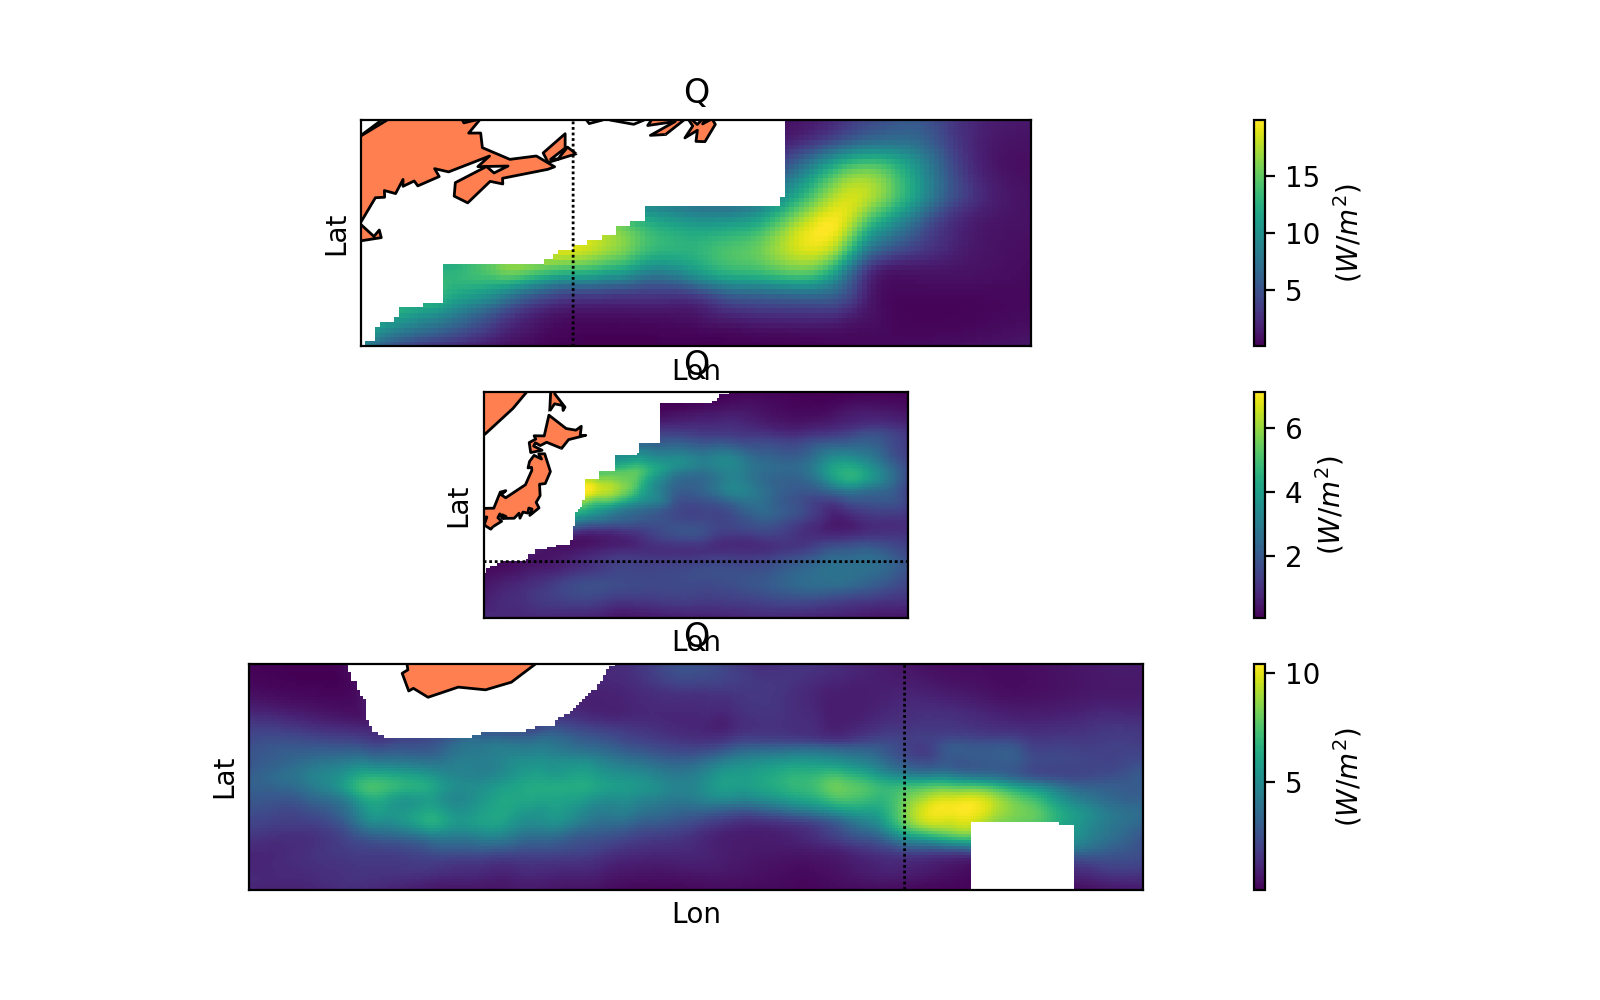

In [310]:
fig, axs = plt.subplots(nrows=3,figsize=(8,5))
#m = Basemap(projection='mill',llcrnrlat=-90,urcrnrlat=90,llcrnrlon=-180,urcrnrlon=180,resolution='c')
mGS = Basemap(projection='cyl',llcrnrlat=lat_GS[0],urcrnrlat=lat_GS[-1],llcrnrlon=lon_GS[0]-360,urcrnrlon=lon_GS[-1]-360,resolution='c')
mK = Basemap(projection='cyl',llcrnrlat=lat_K[0],urcrnrlat=lat_K[-1],llcrnrlon=lon_K[0],urcrnrlon=lon_K[-1],resolution='c')
mA = Basemap(projection='cyl',llcrnrlat=lat_A[0],urcrnrlat=lat_A[-1],llcrnrlon=lon_A[0],urcrnrlon=lon_A[-1],resolution='c')

#m = Basemap(llcrnrlat=36,urcrnrlat=47.75,llcrnrlon=-71,urcrnrlon=-36.25)
ax=axs[0]
pc = ax.pcolormesh(lon_GS-360,lat_GS,Q4_GS[0,:,:])
fig.colorbar(pc,ax=ax,label="($W/m^2$)")
mGS.drawcoastlines(ax=ax)
mGS.drawparallels(np.arange(-90.,120.,30.),ax=ax)
mGS.drawmeridians(np.arange(0.,360.,60.),ax=ax)
mGS.fillcontinents(color='coral',ax=ax)
ax.set_xlabel("Lon")
ax.set_ylabel("Lat")
ax.set_title("Q")
ax.grid()

ax=axs[1]
pc = ax.pcolormesh(lon_K,lat_K,Q4_K[10,:,:])
fig.colorbar(pc,ax=ax,label="($W/m^2$)")
mK.drawcoastlines(ax=ax)
mK.drawparallels(np.arange(-90.,120.,30.),ax=ax)
mK.drawmeridians(np.arange(0.,360.,60.),ax=ax)
mK.fillcontinents(color='coral',ax=ax)
ax.set_xlabel("Lon")
ax.set_ylabel("Lat")
ax.set_title("Q")
ax.grid()

ax=axs[2]
pc = ax.pcolormesh(lon_A,lat_A,Q4_A[10,:,:])
fig.colorbar(pc,ax=ax,label="($W/m^2$)")
mA.drawcoastlines(ax=ax)
mA.drawparallels(np.arange(-90.,120.,30.),ax=ax)
mA.drawmeridians(np.arange(0.,360.,60.),ax=ax)
mA.fillcontinents(color='coral',ax=ax)
ax.set_xlabel("Lon")
ax.set_ylabel("Lat")
ax.set_title("Q")
ax.grid()



<IPython.core.display.Javascript object>


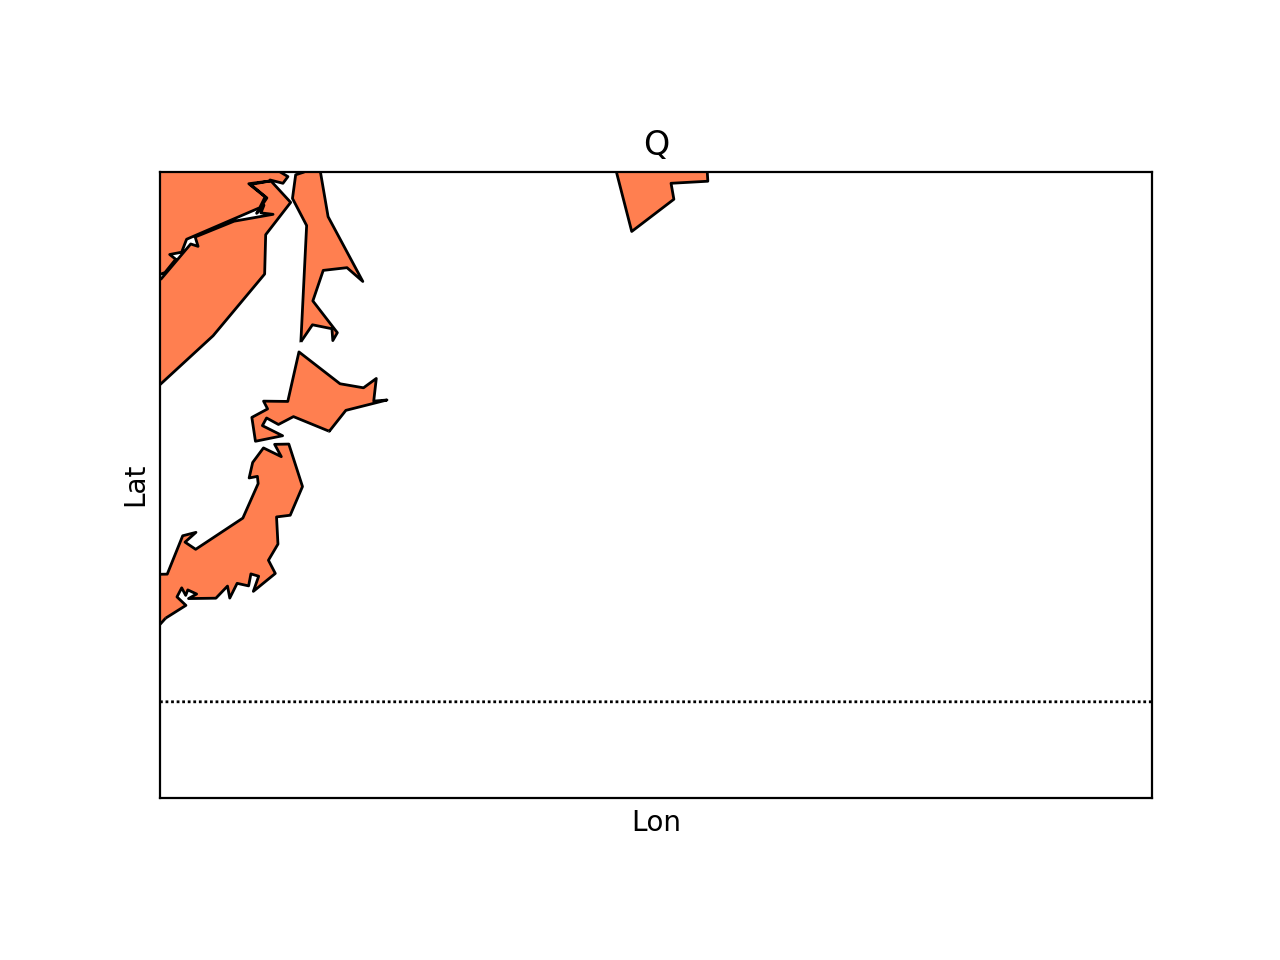

In [304]:
fig, ax = plt.subplots()
m = Basemap(projection='cyl',llcrnrlat=lat_K[0]-10,urcrnrlat=lat_K[-1]+10,llcrnrlon=lon_K[0]-10,urcrnrlon=lon_K[-1],resolution='c')

#pc = ax.pcolormesh(lon_GS-360,lat_GS,Q_GS[0,:,:])
#pc = ax.pcolormesh(lon_K,lat_K,Q_K[0,:,:])
#fig.colorbar(pc,ax=ax,label="($W/m^2$)")
m.drawcoastlines(ax=ax)
m.drawparallels(np.arange(-90.,120.,30.),ax=ax)
m.drawmeridians(np.arange(0.,360.,60.),ax=ax)
m.fillcontinents(color='coral',ax=ax)
ax.set_xlabel("Lon")
ax.set_ylabel("Lat")
ax.set_title("Q")
ax.grid()

In [ ]:
fig, axs = plt.subplots(3,2,figsize=(6.5,9.5))
fig.subplots_adjust(hspace=0.3,wspace=0.05)
fig.suptitle('Rectification of LHF with Reanalysis Data in 2003-2008', fontsize=13,x=0.5, y=.94)

lvl=[-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]

ax = axs[0,0]
pc = ax.pcolormesh(lon_GS,lat_GS,Q4_GS_mean,cmap='twilight',vmax=13)
pc = ax.contour(lon_GS,lat_GS,Q5_GS_mean,colors='white',linewidths=.8,levels=lvl)
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
pc = ax.contour(lon_GS,lat_GS,Q6_GS_mean,colors='red',linewidths=.8,levels=lvl)
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
ax.set_title('Mean in Gulf Stream',fontsize='medium')
ax.set_ylabel('Latitude',fontsize='small')
#ax.set_xlabel('Longitude',fontsize='small')

ax = axs[0,1]
pc = ax.pcolormesh(lon_GS,lat_GS,Q4_GS_std,cmap='twilight',vmax=13)
pc = ax.contour(lon_GS,lat_GS,Q5_GS_std,colors='white',linewidths=.8,levels=lvl)
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
pc = ax.contour(lon_GS,lat_GS,Q6_GS_std,colors='red',linewidths=.8,levels=lvl)
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
ax.set_title('Standard Deviation in Gulf Stream',fontsize='medium')
plt.setp(ax.get_yticklabels(), visible=False)
#ax.set_xlabel('Longitude',fontsize='small')

ax = axs[1,0]
pc = ax.pcolormesh(lon_K,lat_K,Q4_K_mean,cmap='twilight',vmax=13)
pc = ax.contour(lon_K,lat_K,Q5_K_mean,colors='white',linewidths=.8,levels=lvl)
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
pc = ax.contour(lon_K,lat_K,Q6_K_mean,colors='red',linewidths=.8,levels=lvl)
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
ax.set_title('Mean in Kuroshio',fontsize='medium')
ax.set_ylabel('Latitude',fontsize='small')
#ax.set_xlabel('Longitude',fontsize='small')

ax = axs[1,1]
pc = ax.pcolormesh(lon_K,lat_K,Q4_K_std,cmap='twilight',vmax=13)
pc = ax.contour(lon_K,lat_K,Q5_K_std,colors='white',linewidths=.8,levels=lvl)
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
pc = ax.contour(lon_K,lat_K,Q6_K_std,colors='red',linewidths=.8,levels=lvl)
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
ax.set_title('Standard Deviation in Kuroshio',fontsize='medium')
plt.setp(ax.get_yticklabels(), visible=False)
#ax.set_xlabel('Longitude',fontsize='small')

ax = axs[2,0]
pc = ax.pcolormesh(lon_A,lat_A,Q4_A_mean,cmap='twilight',vmax=13)
pc = ax.contour(lon_A,lat_A,Q5_A_mean,colors='white',linewidths=.8,levels=lvl)
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
pc = ax.contour(lon_A,lat_A,Q6_A_mean,colors='red',linewidths=.8,levels=lvl)
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
ax.set_title('Mean in Agulhas',fontsize='medium')
ax.set_xlabel('Longitude',fontsize='small')
ax.set_ylabel('Latitude',fontsize='small')

ax = axs[2,1]
pc = ax.pcolormesh(lon_A,lat_A,Q4_A_std,cmap='twilight',vmax=13)
fig.colorbar(pc, ax=axs,fraction=0.04,label='$LHF_{CC}$ W/m$^2$')
pc = ax.contour(lon_A,lat_A,Q5_A_std,colors='white',linewidths=.8,levels=lvl)
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
pc = ax.contour(lon_A,lat_A,Q6_A_std,colors='red',linewidths=.8,levels=lvl)
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
ax.set_title('Standard Deviation in Agulhas',fontsize='medium')
plt.setp(ax.get_yticklabels(), visible=False)
ax.set_xlabel('Longitude',fontsize='small')


## Plot Derivatives

In [ ]:
#get derivatives:

def calculate_QL(SST,U,rh=0.7):
    '''
    Description: calculates Latent Heat
    
    Parameters: Sea Surface Temperature and Wind Speed
    rh = relative humidity
    '''
    
    #guesstimated constants:
    p = 1026.8 #hPa
    Md = 28.97 #g
    Mw = 18.016 #g
    rho = 1.178
    Lv = 2500000
    Ce = .001
    
    #calculates saturation humidity (qs) from saturation vapor pressure (e)
    
    e = 6.1094*np.exp((17.625*SST)/(SST + 243.04))
    ep = e/p
    qs = (Mw*ep)/(Md - Md*ep + Mw*ep)
    qa = rh*qs #estimation
    
    #calculates Evaporation
    E = rho*Ce*U*(qs-qa)
    
    #calculates Latent Heat
    QL = Lv*E
    
    return QL #W/m^2


def calculate_QL2(SST,U,qa):
    '''
    Description: calculates Latent Heat
    
    Parameters: Sea Surface Temperature and Wind Speed
    '''
    
    #guesstimated constants:
    p = 1026.8 #hPa
    Md = 28.97 #g
    Mw = 18.016 #g
    rho = 1.178
    Lv = 2500000
    Ce = .001
    
    #calculates saturation humidity (qs) from saturation vapor pressure (e)
    
    e = 6.1094*np.exp((17.625*SST)/(SST + 243.04))
    ep = e/p
    qs = (Mw*ep)/(Md - Md*ep + Mw*ep)
    #qa = 0.7*qs #estimation
    
    #calculates Evaporation
    E = rho*Ce*U*(qs-qa)
    
    #calculates Latent Heat
    QL = Lv*E
    
    return QL #W/m^2

In [ ]:
def derivatives(SSTsm,Usm,SPHsm=None,SPH=True,N=17,D=0.1,DH=0.00001,RH=0.7):
    '''
    Find first and second derivatives of LHF.
    
    SSTsm = smoothed sea surface temperature 
    Usm = smoothed Wind velocity
    SPHsm = smoothed Specific Humidity
    N = smoothing filter size
    D = delta of wind and sst
    DH = delta of specific humidity
    
    '''
  
    
    #derivatives WITH specific humidity
    if SPH==True:
        Q1 = calculate_QL2(SSTsm,Usm,SPHsm)
        Q_DT = (calculate_QL2(SSTsm+(D/2),Usm,SPHsm) - calculate_QL2(SSTsm-(D/2),Usm,SPHsm))/(D)
        Q_DU = (calculate_QL2(SSTsm,Usm+(D/2),SPHsm) - calculate_QL2(SSTsm,Usm-(D/2),SPHsm))/(D)
        Q_DH = (calculate_QL2(SSTsm,Usm,SPHsm+(DH/2)) - calculate_QL2(SSTsm,Usm,SPHsm-(DH/2)))/(DH)
        Q_DTT = (calculate_QL2(SSTsm+D,Usm,SPHsm) - 2*Q1 + calculate_QL2(SSTsm-D,Usm,SPHsm)) / (D*D)
        Q_DTDU = (calculate_QL2(SSTsm+(D/2),Usm+(D/2),SPHsm)-calculate_QL2(SSTsm+(D/2),Usm-(D/2),SPHsm) - \
            calculate_QL2(SSTsm-(D/2),Usm+(D/2),SPHsm)+calculate_QL2(SSTsm-(D/2),Usm-(D/2),SPHsm))/(D*D)

        rho = 1.178
        Ce = .001
        Lv = 2500000
        Q_DUDH = Lv*rho*Ce*(-1) 
        
    #derivatives WITHOUT specific humidity
    if SPH==False:
        Q1 = calculate_QL(SSTsm,Usm,rh=RH)
        Q_DT = (calculate_QL(SSTsm+D,Usm,rh=RH) - calculate_QL(SSTsm-D,Usm,rh=RH))/(2*D)
        Q_DU = (calculate_QL(SSTsm,Usm+(D/2),rh=RH) - calculate_QL(SSTsm,Usm-(D/2),rh=RH))/(D)
        Q_DH = None
        Q_DTT = (calculate_QL(SSTsm+D,Usm,rh=RH) - 2*Q1 + calculate_QL(SSTsm-D,Usm,rh=RH)) / (D*D)
        Q_DTDU = (calculate_QL(SSTsm+D,Usm+D,rh=RH)-calculate_QL(SSTsm+D,Usm-D,rh=RH) - \
        calculate_QL(SSTsm-D,Usm+D,rh=RH)+calculate_QL(SSTsm-D,Usm-D,rh=RH))/(4*D*D)

        Q_DUDH = None      
    

        
    return Q1, Q_DT, Q_DU, Q_DH, Q_DTT, Q_DTDU, Q_DUDH
    
    

In [ ]:
linear_sstsm = np.linspace(0,32,num=64)
const_sstsm = np.full(64,20)
linear_wspdsm = np.linspace(0,32,num=64)
const_wspdsm = np.full(64,20)
linear_SPHsm = np.linspace(0,1,num=64)
const_SPHsm = np.full(64,0.4)


#print(fake_wspdsm)

In [ ]:
Q1, Q_DT, Q_DU, _, Q_DTT, Q_DTDU, _ = derivatives(linear_sstsm,const_wspdsm,SPH=False,RH=0)
Q12, Q_DT2, Q_DU2, _, Q_DTT2, Q_DTDU2, _ = derivatives(linear_sstsm,const_wspdsm,SPH=False,RH=0.7)
Q13, Q_DT3, Q_DU3, _, Q_DTT3, Q_DTDU3, _ = derivatives(linear_sstsm,const_wspdsm,SPH=False,RH=0.9)

_, _, _, _, Q_DTT_5, Q_DTDU_5, _ = derivatives(linear_sstsm,const_wspdsm,SPH=False,RH=0)
_, _, _, _, Q_DTT_9, Q_DTDU_9, _ = derivatives(linear_sstsm,const_wspdsm,SPH=False,RH=0)
_, Q_DT_era, Q_DU_era, Q_DH_era, Q_DTT_era, Q_DTDU_era, Q_DUDH_era = derivatives(linear_sstsm,const_wspdsm,const_SPHsm,SPH=True)



#_, _, _, _, Q_DTT_era, Q_DTDU_era, _ = derivatives(linear_sstsm,linear_wspdsm,linear_SPHsm,SPH=True)
#_, _, _, _, Q_DTT_era, Q_DTDU_era, _ = derivatives(linear_sstsm,linear_wspdsm,np.full(64,0.8),SPH=True)




In [ ]:

fig, ax = plt.subplots()


ax.plot(linear_wspdsm,Q_DTT,label='DTT qa=(0%)*qs')
ax.plot(linear_wspdsm,Q_DTT_5,'+',label='DTT qa=(0%)*qs')
ax.plot(linear_wspdsm,Q_DTT_9,'.',label='DTT qa=(0%)*qs')
ax.plot(linear_wspdsm,Q_DTT_era,label='DTT era')

#ax.plot(linear_wspdsm,Q_DTDU,label='DTDU qa=(70%)*qs')
#ax.plot(linear_wspdsm,Q_DTDU_5,'+',label='DTDU qa=(50%)*qs')
#ax.plot(linear_wspdsm,Q_DTDU_9,'.',label='DTDU qa=(90%)*qs')
#ax.plot(linear_wspdsm,Q_DTDU_era,label='DTDU era')

#ax.plot(Q_DTT,Q_DTTb)
#ax.plot(linear_wspdsm,Q_DTDUb,label='DTDU b')


ax.legend(loc='upper right', fontsize='x-small', ncol=1)
ax.set_title('Q_DTT, constant U (20 m/s)')
ax.set_ylabel('LHF (W/m^2)')
ax.set_xlabel('SST (ºC)')


In [ ]:

fig, ax = plt.subplots()
ax.plot(linear_wspdsm,Q1,label='low pass qa=qs*0%')
ax.plot(linear_wspdsm,Q12,label='low pass qa=qs*70%')
ax.plot(linear_wspdsm,Q13,label='low pass qa=qs*90%')

#ax.plot(linear_wspdsm,Q_DTT,label='DTT qa=(0%)*qs')
#ax.plot(linear_wspdsm,Q_DTT_5,'+',label='DTT qa=(0%)*qs')
#ax.plot(linear_wspdsm,Q_DTT_9,'.',label='DTT qa=(0%)*qs')
#ax.plot(linear_wspdsm,Q_DTT_era,label='DTT era')

#ax.plot(linear_wspdsm,Q_DTDU,label='DTDU qa=(70%)*qs')
#ax.plot(linear_wspdsm,Q_DTDU_5,'+',label='DTDU qa=(50%)*qs')
#ax.plot(linear_wspdsm,Q_DTDU_9,'.',label='DTDU qa=(90%)*qs')
#ax.plot(linear_wspdsm,Q_DTDU_era,label='DTDU era')

#ax.plot(Q_DTT,Q_DTTb)
#ax.plot(linear_wspdsm,Q_DTDUb,label='DTDU b')


ax.legend(loc='upper right', fontsize='x-small', ncol=1)
ax.set_title('Low Pass LHF, constant U (20 m/s)')
ax.set_ylabel('LHF (W/m^2)')
ax.set_xlabel('SST (ºC)')


## Plot U', SST', and q'

## Total Q4 and Q5 Golbally and Temporally

In [ ]:
print(Q.shape)

In [ ]:
print('mean of Q4: ',np.nanmean(Q4))
print('mean of Q5: ',np.nanmean(Q5))
print('mean of large scale Q: ',np.nanmean(Q))
print('percent of Q4:',np.nanmean(Q4)*100/np.nanmean(Q),'%')
print('percent of Q5:',np.nanmean(Q5)*100/np.nanmean(Q),'%')

#get the average of Q4 and Q5 only if they coincide with large enough sst std
a = np.nanmean(Q4[np.where(std > 2.7)])
b = np.nanmean(Q5[np.where(std > 2.7)])
c = np.nanmean(Q[np.where(std > 2.7)])
print('mean of Q4 in high sst std places: ',a)
print('mean of Q5 in high sst std places: ',b)
print('mean of large scale Q in high sst std places: ',c)
print('percent of Q4 in high sst std places:',(a*100)/c,'%')
print('percent of Q5 in high sst std places:',(b*100)/c,'%')


# Find Instances of Large Rectification
## Satellite

In [ ]:
#Q1_GS_ERAQ 
#wspd5_GS 
#wspd5sm_GS 
#sst5_GS 
#sst5sm_GS 
#qa5_GS 
#qa5sm_GS 

#temp = Q4_K

#print(np.nanmax(temp))
#print(np.where(temp == np.nanmax(temp)))
print(ymdhms[784])
print(ymdhms[787])

In [ ]:
fig, axs = plt.subplots(2,2)
fig.subplots_adjust(hspace=.3,wspace=.3)

lt = lat_K
ln = lon_K
var = Q5_K[784:788,:,:]
time_str = ['2/23/2005', '2/24/2005', '2/25/2005', '2/26/2005']

ax = axs[0,0]
pc = ax.pcolormesh(ln,lt,var[0,:,:])
fig.colorbar(pc,ax=ax)
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title('QUT '+ time_str[0],fontsize='medium')

ax = axs[0,1]
pc = ax.pcolormesh(ln,lt,var[1,:,:])
fig.colorbar(pc,ax=ax,label="W/m^2")
ax.set_title('QUT '+ time_str[1],fontsize='medium')

ax = axs[1,0]
pc = ax.pcolormesh(ln,lt,var[2,:,:])
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude',fontsize='small')
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title('QUT '+ time_str[2],fontsize='medium')

ax = axs[1,1]
pc = ax.pcolormesh(ln,lt,var[3,:,:])
fig.colorbar(pc,ax=ax,label="W/m^2")
ax.set_xlabel('Longitude',fontsize='small')
ax.set_title('QUT '+ time_str[3],fontsize='medium')



In [ ]:
fig, axs = plt.subplots(2,2)
fig.subplots_adjust(hspace=.3,wspace=.3)

#lt = lat_K
#ln = lon_K
var = Q4_K[784:788,:,:]
#time_str = ['3/30/2003', '3/31/2003', '4/1/2003', '4/2/2003']

ax = axs[0,0]
pc = ax.pcolormesh(ln,lt,var[0,:,:])
fig.colorbar(pc,ax=ax)
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title('QCC '+ time_str[0],fontsize='medium')

ax = axs[0,1]
pc = ax.pcolormesh(ln,lt,var[1,:,:])
fig.colorbar(pc,ax=ax,label="W/m^2")
ax.set_title('QCC ' + time_str[1],fontsize='medium')

ax = axs[1,0]
pc = ax.pcolormesh(ln,lt,var[2,:,:])
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude',fontsize='small')
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title('QCC ' + time_str[2],fontsize='medium')

ax = axs[1,1]
pc = ax.pcolormesh(ln,lt,var[3,:,:])
fig.colorbar(pc,ax=ax,label="W/m^2")
ax.set_xlabel('Longitude',fontsize='small')
ax.set_title('QCC ' + time_str[3],fontsize='medium')


In [ ]:
fig, axs = plt.subplots(2,2)
fig.subplots_adjust(hspace=.3,wspace=.3)

#lt = lat_K
#ln = lon_K
var = sstsm_K[784:788,:,:]
#var2 = std_GS[544:548,:,:]
#time_str = ['3/30/2003', '3/31/2003', '4/1/2003', '4/2/2003']

ax = axs[0,0]
pc = ax.pcolormesh(ln,lt,var[0,:,:])
fig.colorbar(pc,ax=ax)
#pc = ax.contour(ln,lt,var2[0,:,:],colors='blue',linewidths=.7,linestyles='dashed')
#ax.clabel(pc, fontsize=7,fmt='%1.1f',colors='white')
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title('SST LP '+ time_str[0],fontsize='medium')

ax = axs[0,1]
pc = ax.pcolormesh(ln,lt,var[1,:,:])
fig.colorbar(pc,ax=ax,label="ºC")
#pc = ax.contour(ln,lt,var2[1,:,:],colors='blue',linewidths=.7,linestyles='dashed')
#ax.clabel(pc, fontsize=7,fmt='%1.1f',colors='white')
ax.set_title('SST LP ' + time_str[1],fontsize='medium')

ax = axs[1,0]
pc = ax.pcolormesh(ln,lt,var[2,:,:])
fig.colorbar(pc,ax=ax)
#pc = ax.contour(ln,lt,var2[1,:,:],colors='blue',linewidths=.7,linestyles='dashed')
#ax.clabel(pc, fontsize=7,fmt='%1.1f',colors='white')
ax.set_xlabel('Longitude',fontsize='small')
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title('SST LP ' + time_str[2],fontsize='medium')

ax = axs[1,1]
pc = ax.pcolormesh(ln,lt,var[3,:,:])
fig.colorbar(pc,ax=ax,label="ºC")
#pc = ax.contour(ln,lt,var2[3,:,:],colors='blue',linewidths=.7,linestyles='dashed')
#ax.clabel(pc, fontsize=7,fmt='%1.1f',colors='white')
ax.set_xlabel('Longitude',fontsize='small')
ax.set_title('SST LP ' + time_str[3],fontsize='medium')


In [ ]:
fig, axs = plt.subplots(2,2)
fig.subplots_adjust(hspace=.3,wspace=.4)

#lt = lat_K
#ln = lon_K
var = qs_K[784:788,:,:]-qa_K[784:788,:,:]
#time_str = ['3/30/2003', '3/31/2003', '4/1/2003', '4/2/2003']

ax = axs[0,0]
pc = ax.pcolormesh(ln,lt,var[0,:,:])
fig.colorbar(pc,ax=ax)
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title('qs-qa ' + time_str[0],fontsize='medium')

ax = axs[0,1]
pc = ax.pcolormesh(ln,lt,var[1,:,:])
fig.colorbar(pc,ax=ax,label="g/kg")
ax.set_title('qs-qa ' + time_str[1],fontsize='medium')

ax = axs[1,0]
pc = ax.pcolormesh(ln,lt,var[2,:,:])
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude',fontsize='small')
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title('qs-qa ' + time_str[2],fontsize='medium')

ax = axs[1,1]
pc = ax.pcolormesh(ln,lt,var[3,:,:])
fig.colorbar(pc,ax=ax,label="g/kg")
ax.set_xlabel('Longitude',fontsize='small')
ax.set_title('qs-qa ' + time_str[3],fontsize='medium')


In [ ]:
fig, axs = plt.subplots(2,2)
fig.subplots_adjust(hspace=.3,wspace=.3)

#lt = lat_K
#ln = lon_K
var = wspdavgsm_K[784:788,:,:]
#time_str = ['3/30/2003', '3/31/2003', '4/1/2003', '4/2/2003']

ax = axs[0,0]
pc = ax.pcolormesh(ln,lt,var[0,:,:])
fig.colorbar(pc,ax=ax)
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title('U LP ' + time_str[0],fontsize='medium')

ax = axs[0,1]
pc = ax.pcolormesh(ln,lt,var[1,:,:])
fig.colorbar(pc,ax=ax,label="m/s")
ax.set_title('U LP ' + time_str[1],fontsize='medium')

ax = axs[1,0]
pc = ax.pcolormesh(ln,lt,var[2,:,:])
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude',fontsize='small')
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title('U LP ' + time_str[2],fontsize='medium')

ax = axs[1,1]
pc = ax.pcolormesh(ln,lt,var[3,:,:])
fig.colorbar(pc,ax=ax,label="m/s")
ax.set_xlabel('Longitude',fontsize='small')
ax.set_title('U LP ' + time_str[3],fontsize='medium')


In [ ]:
fig, axs = plt.subplots(2,2)
fig.subplots_adjust(hspace=.3,wspace=.3)

#lt = lat_K
#ln = lon_K
var = wspdavg_K[784:788,:,:]
#time_str = ['3/30/2003', '3/31/2003', '4/1/2003', '4/2/2003']

ax = axs[0,0]
pc = ax.pcolormesh(ln,lt,var[0,:,:])
fig.colorbar(pc,ax=ax)
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title('Wind Speed ' + time_str[0],fontsize='medium')

ax = axs[0,1]
pc = ax.pcolormesh(ln,lt,var[1,:,:])
fig.colorbar(pc,ax=ax,label="m/s")
ax.set_title('Wind Speed ' + time_str[1],fontsize='medium')

ax = axs[1,0]
pc = ax.pcolormesh(ln,lt,var[2,:,:])
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude',fontsize='small')
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title('Wind Speed ' + time_str[2],fontsize='medium')

ax = axs[1,1]
pc = ax.pcolormesh(ln,lt,var[3,:,:])
fig.colorbar(pc,ax=ax,label="m/s")
ax.set_xlabel('Longitude',fontsize='small')
ax.set_title('Wind Speed ' + time_str[3],fontsize='medium')

In [ ]:
fig, axs = plt.subplots(2,2)
fig.subplots_adjust(hspace=.3,wspace=.3)

#lt = lat_K
#ln = lon_K
var = std_K[784:788,:,:]
#time_str = ['3/30/2003', '3/31/2003', '4/1/2003', '4/2/2003']

ax = axs[0,0]
pc = ax.pcolormesh(ln,lt,var[0,:,:])
fig.colorbar(pc,ax=ax)
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title("SST'^2 "+ time_str[0],fontsize='medium')

ax = axs[0,1]
pc = ax.pcolormesh(ln,lt,var[1,:,:])
fig.colorbar(pc,ax=ax,label="ºC")
ax.set_title("SST'^2 " + time_str[1],fontsize='medium')

ax = axs[1,0]
pc = ax.pcolormesh(ln,lt,var[2,:,:])
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude',fontsize='small')
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title("SST'^2 " + time_str[2],fontsize='medium')

ax = axs[1,1]
pc = ax.pcolormesh(ln,lt,var[3,:,:])
fig.colorbar(pc,ax=ax,label="ºC")
ax.set_xlabel('Longitude',fontsize='small')
ax.set_title("SST'^2 " + time_str[3],fontsize='medium')

In [ ]:
fig, axs = plt.subplots(2,2)
fig.subplots_adjust(hspace=.3,wspace=.3)

#lt = lat_K
#ln = lon_K
var = UT_K[784:788,:,:]
#time_str = ['3/30/2003', '3/31/2003', '4/1/2003', '4/2/2003']

ax = axs[0,0]
pc = ax.pcolormesh(ln,lt,var[0,:,:])
fig.colorbar(pc,ax=ax)
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title("U'T' "+ time_str[0],fontsize='medium')

ax = axs[0,1]
pc = ax.pcolormesh(ln,lt,var[1,:,:])
fig.colorbar(pc,ax=ax,label="ºC*m/s")
ax.set_title("U'T' " + time_str[1],fontsize='medium')

ax = axs[1,0]
pc = ax.pcolormesh(ln,lt,var[2,:,:])
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude',fontsize='small')
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title("U'T' " + time_str[2],fontsize='medium')

ax = axs[1,1]
pc = ax.pcolormesh(ln,lt,var[3,:,:])
fig.colorbar(pc,ax=ax,label="ºC*m/s")
ax.set_xlabel('Longitude',fontsize='small')
ax.set_title("U'T' " + time_str[3],fontsize='medium')

In [ ]:
fig, axs = plt.subplots(2,2)
fig.subplots_adjust(hspace=.3,wspace=.3)

#lt = lat_K
#ln = lon_K
var = QDTDT_K[784:788,:,:]
#time_str = ['3/30/2003', '3/31/2003', '4/1/2003', '4/2/2003']

ax = axs[0,0]
pc = ax.pcolormesh(ln,lt,var[0,:,:])
fig.colorbar(pc,ax=ax)
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title("QDTDT "+ time_str[0],fontsize='medium')

ax = axs[0,1]
pc = ax.pcolormesh(ln,lt,var[1,:,:])
fig.colorbar(pc,ax=ax)
ax.set_title("QDTDT " + time_str[1],fontsize='medium')

ax = axs[1,0]
pc = ax.pcolormesh(ln,lt,var[2,:,:])
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude',fontsize='small')
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title("QDTDT " + time_str[2],fontsize='medium')

ax = axs[1,1]
pc = ax.pcolormesh(ln,lt,var[3,:,:])
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude',fontsize='small')
ax.set_title("QDTDT " + time_str[3],fontsize='medium')

In [ ]:
fig, axs = plt.subplots(2,2)
fig.subplots_adjust(hspace=.3,wspace=.3)

#lt = lat_K
#ln = lon_K
var = QDUDT_K[784:788,:,:]
#time_str = ['3/30/2003', '3/31/2003', '4/1/2003', '4/2/2003']

ax = axs[0,0]
pc = ax.pcolormesh(ln,lt,var[0,:,:])
fig.colorbar(pc,ax=ax)
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title("QDUDT "+ time_str[0],fontsize='medium')

ax = axs[0,1]
pc = ax.pcolormesh(ln,lt,var[1,:,:])
fig.colorbar(pc,ax=ax)
ax.set_title("QDUDT " + time_str[1],fontsize='medium')

ax = axs[1,0]
pc = ax.pcolormesh(ln,lt,var[2,:,:])
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude',fontsize='small')
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title("QDUDT " + time_str[2],fontsize='medium')

ax = axs[1,1]
pc = ax.pcolormesh(ln,lt,var[3,:,:])
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude',fontsize='small')
ax.set_title("QDUDT " + time_str[3],fontsize='medium')

In [ ]:
fig, axs = plt.subplots(2,2)
fig.subplots_adjust(hspace=.3,wspace=.3)

#lt = lat_K
#ln = lon_K
var = wdiravg_K[784:788,:,:]
#time_str = ['3/30/2003', '3/31/2003', '4/1/2003', '4/2/2003']

ax = axs[0,0]
pc = ax.pcolormesh(ln,lt,var[0,:,:])
fig.colorbar(pc,ax=ax)
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title("Wind Direction "+ time_str[0],fontsize='medium')

ax = axs[0,1]
pc = ax.pcolormesh(ln,lt,var[1,:,:])
fig.colorbar(pc,ax=ax)
ax.set_title("Wind Direction " + time_str[1],fontsize='medium')

ax = axs[1,0]
pc = ax.pcolormesh(ln,lt,var[2,:,:])
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude',fontsize='small')
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title("Wind Direction " + time_str[2],fontsize='medium')

ax = axs[1,1]
pc = ax.pcolormesh(ln,lt,var[3,:,:])
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude',fontsize='small')
ax.set_title("Wind Direction " + time_str[3],fontsize='medium')

In [ ]:
a = 784
b = 786
c = np.ravel(Q4_K[a:b,:,:])
d = np.ravel(Q5_K[a:b,:,:])
e = np.ravel(sstsm_K[a:b,:,:])
f = np.ravel(std_K[a:b,:,:])
g = np.ravel(wspdavgsm_K[a:b,:,:])
h = np.ravel(UT_K[a:b,:,:])
i = np.ravel(QDTDT_K[a:b,:,:])
j = np.ravel(QDUDT_K[a:b,:,:])
k = np.ravel(wdiravg_K[a:b,:,:])

fig, axs = plt.subplots()
fig.subplots_adjust()

axs.plot(c,'.',label='Q4',linewidth=1.5, markevery=20)
axs.plot(f,'.',label='sst std',alpha=0.3,markevery=20)
#axs.plot(g,'.',label='wspd lp',alpha=0.3,markevery=20)
axs.set_ylabel('W/m^2',fontsize='small')
axs.legend(loc='upper right', fontsize='x-small')
axs.grid()


## Reanalysis

In [ ]:

temp = Q4_K5

print(np.nanmax(temp))
print(np.where(temp == np.nanmax(temp)))
print(ymdhms[410])

In [ ]:
fig, axs = plt.subplots(2,2)
fig.subplots_adjust(hspace=.3,wspace=.3)

lt = lat5_K
ln = lon5_K

ax = axs[0,0]
pc = ax.pcolormesh(ln,lt,Q4_K5[409,:,:])
fig.colorbar(pc,ax=ax)
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title('QCC 2/14/04',fontsize='medium')

ax = axs[0,1]
pc = ax.pcolormesh(ln,lt,Q4_K5[410,:,:])
fig.colorbar(pc,ax=ax)
ax.set_title('QCC 2/15/04',fontsize='medium')

ax = axs[1,0]
pc = ax.pcolormesh(ln,lt,Q4_K5[411,:,:])
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude',fontsize='small')
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title('QCC 2/16/04',fontsize='medium')

ax = axs[1,1]
pc = ax.pcolormesh(ln,lt,Q4_K5[412,:,:])
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude',fontsize='small')
ax.set_title('QCC 2/17/04',fontsize='medium')

In [ ]:
fig, axs = plt.subplots(2,2)
fig.subplots_adjust(hspace=.3,wspace=.3)

lt = lat5_K
ln = lon5_K

ax = axs[0,0]
pc = ax.pcolormesh(ln,lt,Q5_K5[409,:,:])
fig.colorbar(pc,ax=ax)
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title('QUT 2/14/04',fontsize='medium')

ax = axs[0,1]
pc = ax.pcolormesh(ln,lt,Q5_K5[410,:,:])
fig.colorbar(pc,ax=ax)
ax.set_title('QUT 2/15/04',fontsize='medium')

ax = axs[1,0]
pc = ax.pcolormesh(ln,lt,Q5_K5[411,:,:])
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude',fontsize='small')
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title('QUT 2/16/04',fontsize='medium')

ax = axs[1,1]
pc = ax.pcolormesh(ln,lt,Q5_K5[412,:,:])
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude',fontsize='small')
ax.set_title('QUT 2/17/04',fontsize='medium')


In [ ]:
fig, axs = plt.subplots(2,2)
fig.subplots_adjust(hspace=.3,wspace=.3)

lt = lat5_K
ln = lon5_K
var = Q6_K5[409:413,:,:]

ax = axs[0,0]
pc = ax.pcolormesh(ln,lt,var[0,:,:])
fig.colorbar(pc,ax=ax)
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title('QUH 2/14/04',fontsize='medium')

ax = axs[0,1]
pc = ax.pcolormesh(ln,lt,var[1,:,:])
fig.colorbar(pc,ax=ax)
ax.set_title('QUH 2/15/04',fontsize='medium')

ax = axs[1,0]
pc = ax.pcolormesh(ln,lt,var[2,:,:])
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude',fontsize='small')
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title('QUH 2/16/04',fontsize='medium')

ax = axs[1,1]
pc = ax.pcolormesh(ln,lt,var[3,:,:])
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude',fontsize='small')
ax.set_title('QUH 2/17/04',fontsize='medium')

In [ ]:
fig, axs = plt.subplots(2,2)
fig.subplots_adjust(hspace=.3,wspace=.3)

lt = lat5_K
ln = lon5_K
var = sstsm5_K[409:413,:,:]
var2 = SSTstd_K5[409:413,:,:]

ax = axs[0,0]
pc = ax.pcolormesh(ln,lt,var[0,:,:])
fig.colorbar(pc,ax=ax)
pc = ax.contour(ln,lt,var2[0,:,:],colors='blue',linewidths=.7,linestyles='dashed')
ax.clabel(pc, fontsize=7,fmt='%1.1f',colors='white')
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title('SSTsm & sst std (contour) 2/14/04',fontsize='medium')

ax = axs[0,1]
pc = ax.pcolormesh(ln,lt,var[1,:,:])
fig.colorbar(pc,ax=ax)
pc = ax.contour(ln,lt,var2[1,:,:],colors='blue',linewidths=.7,linestyles='dashed')
ax.clabel(pc, fontsize=7,fmt='%1.1f',colors='white')
ax.set_title('SSTsm & sst std (contour) 2/15/04',fontsize='medium')

ax = axs[1,0]
pc = ax.pcolormesh(ln,lt,var[2,:,:])
fig.colorbar(pc,ax=ax)
pc = ax.contour(ln,lt,var2[2,:,:],colors='blue',linewidths=.7,linestyles='dashed')
ax.clabel(pc, fontsize=7,fmt='%1.1f',colors='white')
ax.set_xlabel('Longitude',fontsize='small')
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title('SSTsm & sst std (contour) 2/16/04',fontsize='medium')

ax = axs[1,1]
pc = ax.pcolormesh(ln,lt,var[3,:,:])
fig.colorbar(pc,ax=ax)
pc = ax.contour(ln,lt,var2[3,:,:],colors='blue',linewidths=.7,linestyles='dashed')
ax.clabel(pc, fontsize=7,fmt='%1.1f',colors='white')
ax.set_xlabel('Longitude',fontsize='small')
ax.set_title('SSTsm & sst std (contour) 2/17/04',fontsize='medium')


In [ ]:
fig, axs = plt.subplots(2,2)
fig.subplots_adjust(hspace=.3,wspace=.3)

lt = lat5_K
ln = lon5_K
var = qssm5_K[409:413,:,:]-SPHsm5_K[409:413,:,:]

ax = axs[0,0]
pc = ax.pcolormesh(ln,lt,var[0,:,:])
fig.colorbar(pc,ax=ax)
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title('qs-qa 2/14/04',fontsize='medium')

ax = axs[0,1]
pc = ax.pcolormesh(ln,lt,var[1,:,:])
fig.colorbar(pc,ax=ax)
ax.set_title('qs-qa 2/15/04',fontsize='medium')

ax = axs[1,0]
pc = ax.pcolormesh(ln,lt,var[2,:,:])
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude',fontsize='small')
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title('qs-qa 2/16/04',fontsize='medium')

ax = axs[1,1]
pc = ax.pcolormesh(ln,lt,var[3,:,:])
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude',fontsize='small')
ax.set_title('qs-qa 2/17/04',fontsize='medium')

In [ ]:
fig, axs = plt.subplots(2,2)
fig.subplots_adjust(hspace=.3,wspace=.3)

lt = lat5_K
ln = lon5_K
var = wspdsm5_K[409:413,:,:]

ax = axs[0,0]
pc = ax.pcolormesh(ln,lt,var[0,:,:])
fig.colorbar(pc,ax=ax)
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title('wspd sm 2/14/04',fontsize='medium')

ax = axs[0,1]
pc = ax.pcolormesh(ln,lt,var[1,:,:])
fig.colorbar(pc,ax=ax)
ax.set_title('wspd sm 2/15/04',fontsize='medium')

ax = axs[1,0]
pc = ax.pcolormesh(ln,lt,var[2,:,:])
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude',fontsize='small')
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title('wspd sm 2/16/04',fontsize='medium')

ax = axs[1,1]
pc = ax.pcolormesh(ln,lt,var[3,:,:])
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude',fontsize='small')
ax.set_title('wspd sm 2/17/04',fontsize='medium')


In [ ]:
fig, axs = plt.subplots(2,2)
fig.subplots_adjust(hspace=.3,wspace=.3)

lt = lat5_K
ln = lon5_K
var = wspd5_K[409:413,:,:]

ax = axs[0,0]
pc = ax.pcolormesh(ln,lt,var[0,:,:])
fig.colorbar(pc,ax=ax)
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title('wspd 2/14/04',fontsize='medium')

ax = axs[0,1]
pc = ax.pcolormesh(ln,lt,var[1,:,:])
fig.colorbar(pc,ax=ax)
ax.set_title('wspd 2/15/04',fontsize='medium')

ax = axs[1,0]
pc = ax.pcolormesh(ln,lt,var[2,:,:])
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude',fontsize='small')
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title('wspd 2/16/04',fontsize='medium')

ax = axs[1,1]
pc = ax.pcolormesh(ln,lt,var[3,:,:])
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude',fontsize='small')
ax.set_title('wspd 2/17/04',fontsize='medium')


## 2D PDFS

In [1]:
def makehistcount(varr,varh,br,bh):
    '''
    r will be y-axis and h will be x-axis
    br and bh is the box size of the histogram
    result counts the instances that data exists within the boxes
    '''

    
    #create "boxes" that sort our histogram and will be the x and y axis when we plot
    #r = np.arange(np.floor(np.nanmin(varr)),np.floor(np.nanmax(varr)),dr)
    r = np.linspace(np.nanmin(varr),np.nanmax(varr),br)
    dr = (np.nanmax(varr)-np.nanmin(varr))/br
    h = np.linspace(np.nanmin(varh),np.nanmax(varh),bh)
    dh = (np.nanmax(varh)-np.nanmin(varh))/bh
    
    #create resulting histogram matrix that will be plotted
    hist = np.zeros([len(r),len(h)],dtype=float)

    i = 0
    j = 0
    for i in range(len(r)):
        
        temp = varh[np.where((r[i] <= varr) & (r[i] + dr > varr))]
        
        for j in range(len(h)):
            
            hist[i,j] = np.count_nonzero((h[j] <= temp) & (h[j] + dh > temp))

    return r, h, hist


In [2]:
def makehistavg(varr,varh,varavg,br,bh):
    '''
    r will be y-axis and h will be x-axis
    br and bh is the box size of the histogram
    results average the varavg 
    '''

    
    #create "boxes" that sort our histogram and will be the x and y axis when we plot
    #r = np.arange(np.floor(np.nanmin(varr)),np.floor(np.nanmax(varr)),dr)
    r = np.linspace(np.nanmin(varr),np.nanmax(varr),br)
    dr = (np.nanmax(varr)-np.nanmin(varr))/br
    h = np.linspace(np.nanmin(varh),np.nanmax(varh),bh)
    dh = (np.nanmax(varh)-np.nanmin(varh))/bh
    
    #create resulting histogram matrix that will be plotted
    hist = np.zeros([len(r),len(h)],dtype=float)

    i = 0
    j = 0
    for i in range(len(r)):
        
        idxr = np.where((r[i] <= varr) & (r[i] + dr > varr))
        temp_varh = varh[idxr]
        temp_varavg = varavg[idxr]        
        
        for j in range(len(h)):
            
            idxh = np.where((h[j] <= temp_varh) & (h[j] + dh > temp_varh))
            hist[i,j] = np.nanmean(temp_varavg[idxh])

    return r, h, hist



In [3]:
def makehiststd(varr,varh,varavg,br,bh):
    '''
    r will be y-axis and h will be x-axis
    br and bh is the box size of the histogram
    results average the varavg 
    '''

    
    #create "boxes" that sort our histogram and will be the x and y axis when we plot
    #r = np.arange(np.floor(np.nanmin(varr)),np.floor(np.nanmax(varr)),dr)
    r = np.linspace(np.nanmin(varr),np.nanmax(varr),br)
    dr = (np.nanmax(varr)-np.nanmin(varr))/br
    h = np.linspace(np.nanmin(varh),np.nanmax(varh),bh)
    dh = (np.nanmax(varh)-np.nanmin(varh))/bh
    
    #create resulting histogram matrix that will be plotted
    hist = np.zeros([len(r),len(h)],dtype=float)

    i = 0
    j = 0
    for i in range(len(r)):
        
        idxr = np.where((r[i] <= varr) & (r[i] + dr > varr))
        temp_varh = varh[idxr]
        temp_varavg = varavg[idxr]        
        
        for j in range(len(h)):
            
            idxh = np.where((h[j] <= temp_varh) & (h[j] + dh > temp_varh))
            hist[i,j] = np.nanstd(temp_varavg[idxh])

    return r, h, hist


In [4]:
def makehistcount3x(varr1,varr2,varr3,varh1,varh2,varh3,br,bh):
    '''
    r will be y-axis and h will be x-axis
    br and bh is the box size of the histogram
    result counts the instances that data exists within the boxes
    '''

    #create "boxes" that sort our histogram and will be the x and y axis when we plot
    rmin = [np.nanmin(varr1),np.nanmin(varr2),np.nanmin(varr3)]
    rmax = [np.nanmax(varr1),np.nanmax(varr2),np.nanmax(varr3)]
    r = np.linspace(np.nanmin(rmin),np.nanmax(rmax),br) 
    dr = (np.nanmax(rmax)-np.nanmin(rmin))/br    
    
    hmin = [np.nanmin(varh1),np.nanmin(varh2),np.nanmin(varh3)]
    hmax = [np.nanmax(varh1),np.nanmax(varh2),np.nanmax(varh3)]
    h = np.linspace(np.nanmin(hmin),np.nanmax(hmax),bh)
    dh = (np.nanmax(hmax)-np.nanmin(hmin))/bh  
    
    #create resulting histogram matrix that will be plotted
    hist1 = np.zeros([len(r),len(h)],dtype=float)
    hist2 = np.zeros([len(r),len(h)],dtype=float)
    hist3 = np.zeros([len(r),len(h)],dtype=float)
    
    i = 0
    j = 0
    for i in range(len(r)):
        
        temp1 = varh1[np.where((r[i] <= varr1) & (r[i] + dr > varr1))]
        temp2 = varh2[np.where((r[i] <= varr2) & (r[i] + dr > varr2))]
        temp3 = varh3[np.where((r[i] <= varr3) & (r[i] + dr > varr3))]
        
        for j in range(len(h)):
            
            hist1[i,j] = np.count_nonzero((h[j] <= temp1) & (h[j] + dh > temp1))
            hist2[i,j] = np.count_nonzero((h[j] <= temp2) & (h[j] + dh > temp2))
            hist3[i,j] = np.count_nonzero((h[j] <= temp3) & (h[j] + dh > temp3))
            
    return r, h, hist1, hist2, hist3


In [5]:
def makehistavg3x(varr1,varr2,varr3,varh1,varh2,varh3,varavg1,varavg2,varavg3,br,bh):
    '''
    r will be y-axis and h will be x-axis
    br and bh is the box size of the histogram
    results average the varavg 
    '''

    
    #create "boxes" that sort our histogram and will be the x and y axis when we plot
    rmin = [np.nanmin(varr1),np.nanmin(varr2),np.nanmin(varr3)]
    rmax = [np.nanmax(varr1),np.nanmax(varr2),np.nanmax(varr3)]
    r = np.linspace(np.nanmin(rmin),np.nanmax(rmax),br) 
    dr = (np.nanmax(rmax)-np.nanmin(rmin))/br
    
    hmin = [np.nanmin(varh1),np.nanmin(varh2),np.nanmin(varh3)]
    hmax = [np.nanmax(varh1),np.nanmax(varh2),np.nanmax(varh3)]
    h = np.linspace(np.nanmin(hmin),np.nanmax(hmax),bh)
    dh = (np.nanmax(hmax)-np.nanmin(hmin))/bh   
    
    #create resulting histogram matrix that will be plotted
    hist1 = np.zeros([len(r),len(h)],dtype=float)
    hist2 = np.zeros([len(r),len(h)],dtype=float)
    hist3 = np.zeros([len(r),len(h)],dtype=float)

    i = 0
    j = 0
    for i in range(len(r)):
        
        idxr1 = np.where((r[i] <= varr1) & (r[i] + dr > varr1))
        temp_varh1 = varh1[idxr1]
        temp_varavg1 = varavg1[idxr1] 
        
        idxr2 = np.where((r[i] <= varr2) & (r[i] + dr > varr2))
        temp_varh2 = varh2[idxr2]
        temp_varavg2 = varavg2[idxr2] 
        
        idxr3 = np.where((r[i] <= varr3) & (r[i] + dr > varr3))
        temp_varh3 = varh3[idxr3]
        temp_varavg3 = varavg3[idxr3] 
        
        for j in range(len(h)):
            
            idxh1 = np.where((h[j] <= temp_varh1) & (h[j] + dh > temp_varh1))
            hist1[i,j] = np.nanmean(temp_varavg1[idxh1])

            idxh2 = np.where((h[j] <= temp_varh2) & (h[j] + dh > temp_varh2))
            hist2[i,j] = np.nanmean(temp_varavg2[idxh2])
            
            idxh3 = np.where((h[j] <= temp_varh3) & (h[j] + dh > temp_varh3))
            hist3[i,j] = np.nanmean(temp_varavg3[idxh3])
            
    return r, h, hist1, hist2, hist3


In [6]:
def makehiststd3x(varr1,varr2,varr3,varh1,varh2,varh3,varavg1,varavg2,varavg3,br,bh):
    '''
    r will be y-axis and h will be x-axis
    br and bh is the box size of the histogram
    results average the varavg 
    '''

    
    #create "boxes" that sort our histogram and will be the x and y axis when we plot
    rmin = [np.nanmin(varr1),np.nanmin(varr2),np.nanmin(varr3)]
    rmax = [np.nanmax(varr1),np.nanmax(varr2),np.nanmax(varr3)]
    r = np.linspace(np.nanmin(rmin),np.nanmax(rmax),br) 
    dr = (np.nanmax(rmax)-np.nanmin(rmin))/br
    
    hmin = [np.nanmin(varh1),np.nanmin(varh2),np.nanmin(varh3)]
    hmax = [np.nanmax(varh1),np.nanmax(varh2),np.nanmax(varh3)]
    h = np.linspace(np.nanmin(hmin),np.nanmax(hmax),bh)
    dh = (np.nanmax(hmax)-np.nanmin(hmin))/bh   
    
    #create resulting histogram matrix that will be plotted
    hist1 = np.zeros([len(r),len(h)],dtype=float)
    hist2 = np.zeros([len(r),len(h)],dtype=float)
    hist3 = np.zeros([len(r),len(h)],dtype=float)

    i = 0
    j = 0
    for i in range(len(r)):
        
        idxr1 = np.where((r[i] <= varr1) & (r[i] + dr > varr1))
        temp_varh1 = varh1[idxr1]
        temp_varavg1 = varavg1[idxr1] 
        
        idxr2 = np.where((r[i] <= varr2) & (r[i] + dr > varr2))
        temp_varh2 = varh2[idxr2]
        temp_varavg2 = varavg2[idxr2] 
        
        idxr3 = np.where((r[i] <= varr3) & (r[i] + dr > varr3))
        temp_varh3 = varh3[idxr3]
        temp_varavg3 = varavg3[idxr3] 
        
        for j in range(len(h)):
            
            idxh1 = np.where((h[j] <= temp_varh1) & (h[j] + dh > temp_varh1))
            hist1[i,j] = np.nanstd(temp_varavg1[idxh1])

            idxh2 = np.where((h[j] <= temp_varh2) & (h[j] + dh > temp_varh2))
            hist2[i,j] = np.nanstd(temp_varavg2[idxh2])
            
            idxh3 = np.where((h[j] <= temp_varh3) & (h[j] + dh > temp_varh3))
            hist3[i,j] = np.nanstd(temp_varavg3[idxh3])
            
    return r, h, hist1, hist2, hist3


In [7]:
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap

from matplotlib import cm 
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

cdict3 = {'red':  ((0.0, 0.0, 0.0),
                   (0.25, 0.0, 0.0),
                   (0.5, 0.8, 1.0),
                   (0.75, 1.0, 1.0),
                   (1.0, 0.4, 1.0)),

          'green': ((0.0, 0.0, 0.0),
                    (0.25, 0.0, 0.0),
                    (0.5, 0.9, 0.9),
                    (0.75, 0.0, 0.0),
                    (1.0, 0.0, 0.0)),

          'blue':  ((0.0, 0.0, 0.4),
                    (0.25, 1.0, 1.0),
                    (0.5, 1.0, 0.8),
                    (0.75, 0.0, 0.0),
                    (1.0, 0.0, 0.0))
          }

mpl.cm.register_cmap('BlueRed3',LinearSegmentedColormap('BlueRed3', cdict3))


## PDFs for Total Rectification

In [30]:
Q4Q5 = np.add(Q4_GS,Q5_GS)
nonlin_GS = np.add(Q4Q5, Q6_GS)

Q4Q5 = np.add(Q4_K,Q5_K)
nonlin_K = np.add(Q4Q5, Q6_K)

Q4Q5 = np.add(Q4_A,Q5_A)
nonlin_A = np.add(Q4Q5, Q6_A)

In [31]:
wGS=np.empty(wdirsm_GS.shape)
wGS[np.where(wdirsm_GS <= 180)]=wdirsm_GS[np.where(wdirsm_GS <= 180)]+180
wGS[np.where(wdirsm_GS > 180)]=wdirsm_GS[np.where(wdirsm_GS > 180)]-180

wK=np.empty(wdirsm_K.shape)
wK[np.where(wdirsm_K <= 180)]=wdirsm_K[np.where(wdirsm_K <= 180)]+180
wK[np.where(wdirsm_K > 180)]=wdirsm_K[np.where(wdirsm_K > 180)]-180

wA=np.empty(wdirsm_A.shape)
wA[np.where(wdirsm_A <= 180)]=wdirsm_A[np.where(wdirsm_A <= 180)]+180
wA[np.where(wdirsm_A > 180)]=wdirsm_A[np.where(wdirsm_A > 180)]-180


In [39]:
r, h, nonlin_histm_GS, nonlin_histm_K, nonlin_histm_A = makehistavg3x(wspdavgsm_GS,wspdavgsm_K,wspdavgsm_A,wGS,wK,wA,nonlin_GS,nonlin_K,nonlin_A,100,100)
r, h, nonlin_hists_GS, nonlin_hists_K, nonlin_hists_A = makehiststd3x(wspdavgsm_GS,wspdavgsm_K,wspdavgsm_A,wGS,wK,wA,nonlin_GS,nonlin_K,nonlin_A,100,100)


nonlin_histm_GS[np.where(nonlin_histm_GS == 0.0)] = None
nonlin_histm_K[np.where(nonlin_histm_K == 0.0)] = None
nonlin_histm_A[np.where(nonlin_histm_A == 0.0)] = None

nonlin_hists_GS[np.where(nonlin_hists_GS == 0.0)] = None
nonlin_hists_K[np.where(nonlin_hists_K == 0.0)] = None
nonlin_hists_A[np.where(nonlin_hists_A == 0.0)] = None



/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: Mean of empty slice


<IPython.core.display.Javascript object>


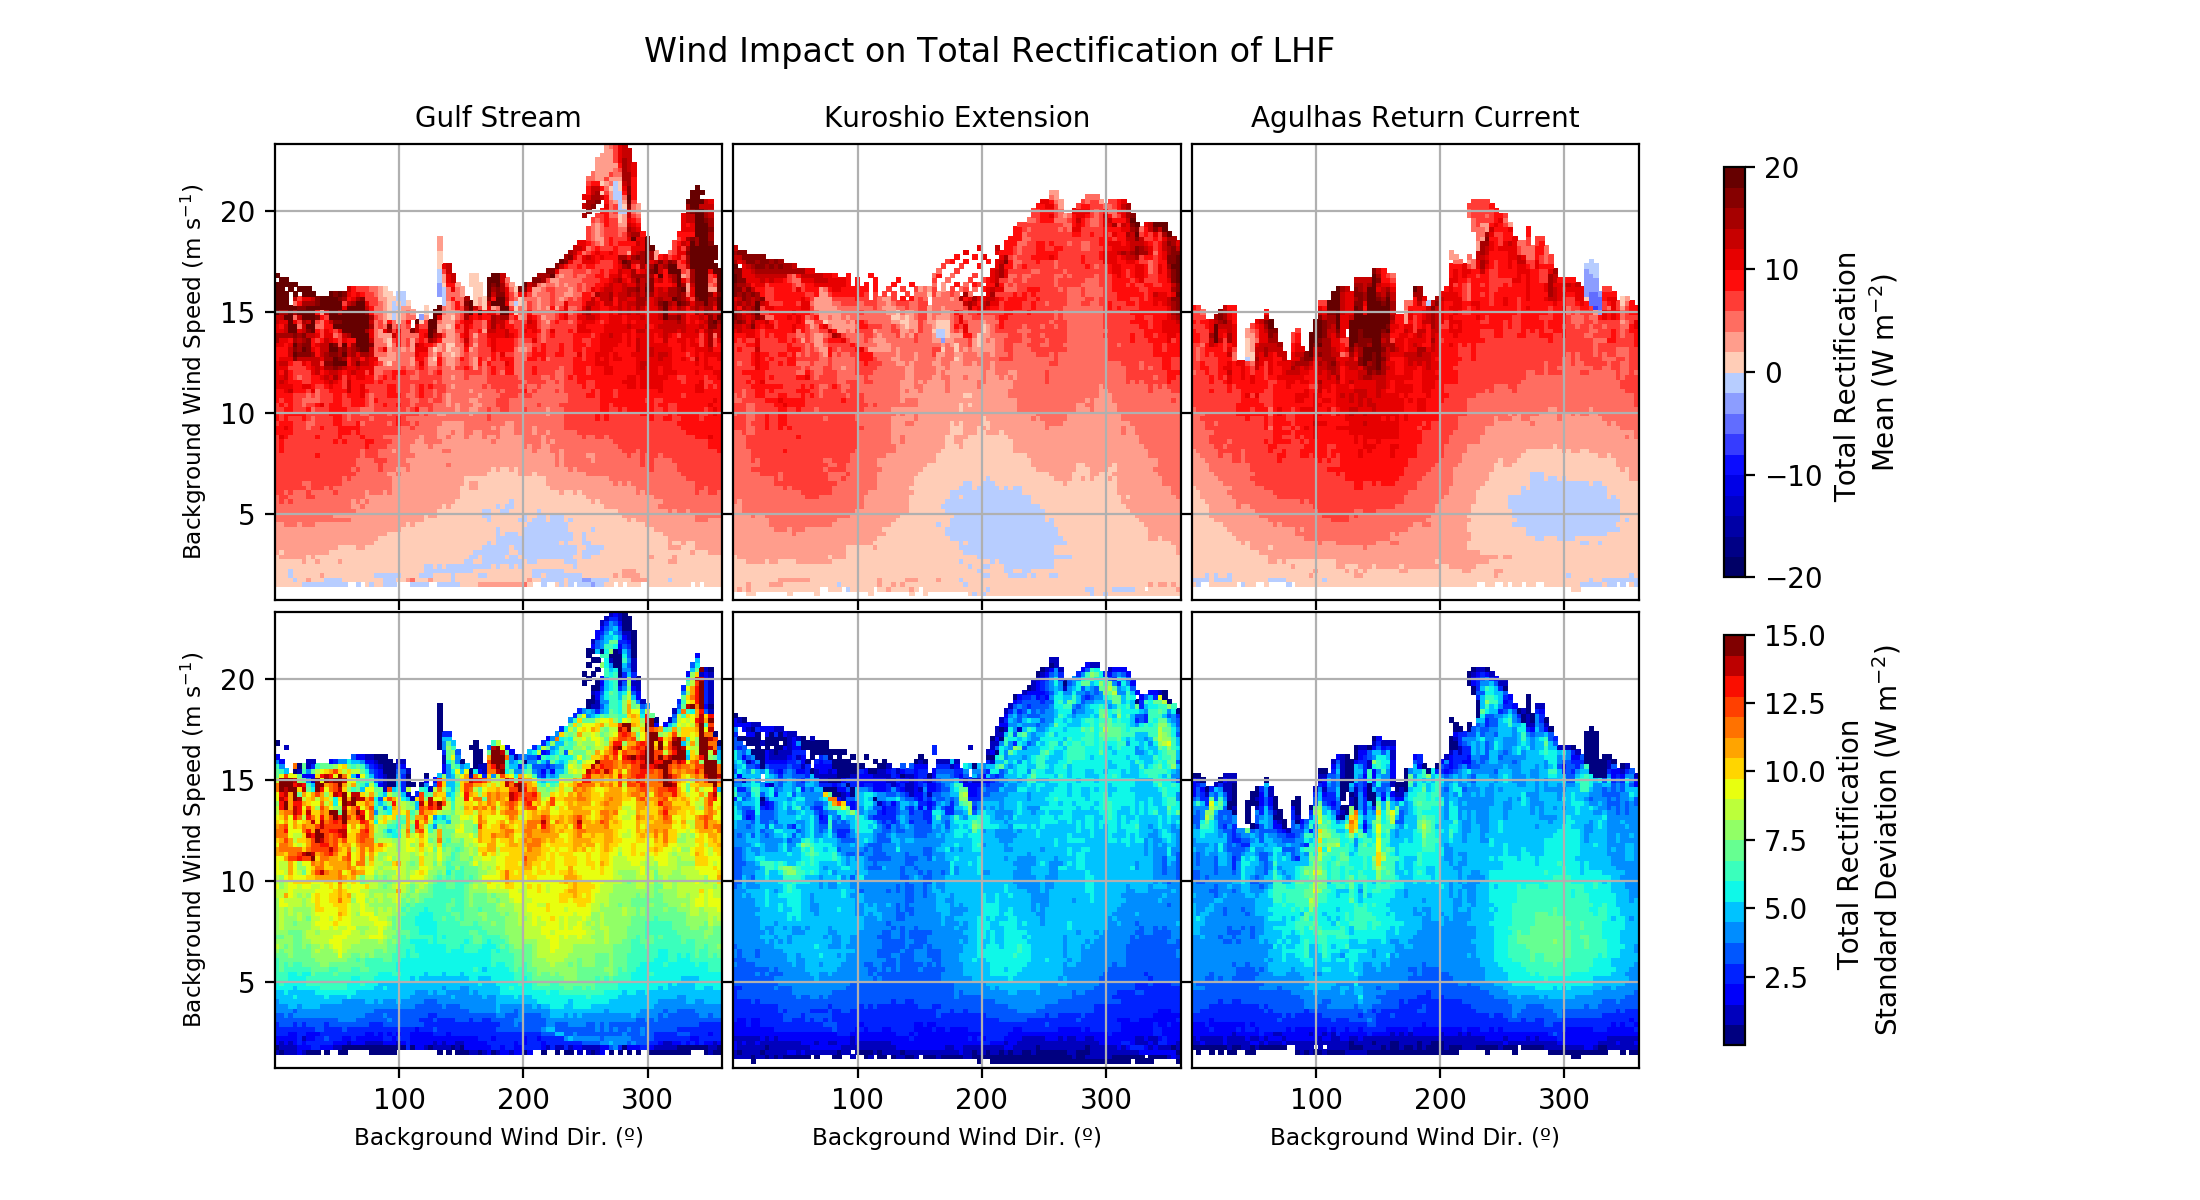

In [40]:
fig, axs = plt.subplots(2,3,figsize=(11,6))
fig.subplots_adjust(wspace=.025,hspace=0.025)
fig.suptitle('Wind Impact on Total Rectification of LHF', fontsize=12,x=0.45, y=.97)

ax = axs[0,0]
pc = ax.pcolormesh(h,r,nonlin_histm_GS,cmap=cm.get_cmap('BlueRed3', 20),vmin=-20,vmax=20)
ax.set_ylabel("Background Wind Speed (m s$^{-1}$)",fontsize='small')
ax.set_title("Gulf Stream",fontsize='medium')
plt.setp(ax.get_xticklabels(), visible=False)
ax.grid()

ax = axs[0,1]
pc = ax.pcolormesh(h,r,nonlin_histm_K,cmap=cm.get_cmap('BlueRed3', 20),vmin=-20,vmax=20)
ax.set_title("Kuroshio Extension",fontsize='medium')
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

ax = axs[0,2]
pc = ax.pcolormesh(h,r,nonlin_histm_A,cmap=cm.get_cmap('BlueRed3', 20),vmin=-20,vmax=20)
fig.colorbar(pc,ax=axs[0],label="Total Rectification \nMean (W m$^{-2}$)",shrink=.9)
ax.set_title("Agulhas Return Current",fontsize='medium')
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

######

ax = axs[1,0]
pc = ax.pcolormesh(h,r,nonlin_hists_GS,cmap=cm.get_cmap('jet', 20),vmax=15)
ax.set_ylabel("Background Wind Speed (m s$^{-1}$)",fontsize='small')
ax.set_xlabel("Background Wind Dir. (º)",fontsize='small')
ax.grid()

ax = axs[1,1]
pc = ax.pcolormesh(h,r,nonlin_hists_K,cmap=cm.get_cmap('jet', 20),vmax=15)
plt.setp(ax.get_yticklabels(), visible=False)
ax.set_xlabel("Background Wind Dir. (º)",fontsize='small')
ax.grid()

ax = axs[1,2]
pc = ax.pcolormesh(h,r,nonlin_hists_A,cmap=cm.get_cmap('jet', 20),vmax=15)
fig.colorbar(pc,ax=axs[1],label="Total Rectification \nStandard Deviation (W m$^{-2}$)",shrink=.9)
plt.setp(ax.get_yticklabels(), visible=False)
ax.set_xlabel("Background Wind Dir. (º)",fontsize='small')
ax.grid()




In [41]:
plt.savefig('PAPER_PDFU_era.png', dpi=300, bbox_inches='tight')


In [36]:
r3, h3, nonlin_histm_GS3, nonlin_histm_K3, nonlin_histm_A3 = makehistavg3x(sstsm_GS,sstsm_K,sstsm_A,sphsm_GS,sphsm_K,sphsm_A,nonlin_GS,nonlin_K,nonlin_A,100,100)
r3, h3, nonlin_hists_GS3, nonlin_hists_K3, nonlin_hists_A3 = makehiststd3x(sstsm_GS,sstsm_K,sstsm_A,sphsm_GS,sphsm_K,sphsm_A,nonlin_GS,nonlin_K,nonlin_A,100,100)

nonlin_histm_GS3[np.where(nonlin_histm_GS3 == 0.0)] = None
nonlin_histm_K3[np.where(nonlin_histm_K3 == 0.0)] = None
nonlin_histm_A3[np.where(nonlin_histm_A3 == 0.0)] = None

nonlin_hists_GS3[np.where(nonlin_hists_GS3 == 0.0)] = None
nonlin_hists_K3[np.where(nonlin_hists_K3 == 0.0)] = None
nonlin_hists_A3[np.where(nonlin_hists_A3 == 0.0)] = None


/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater_equal
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in less
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: Mean of empty slice


<IPython.core.display.Javascript object>


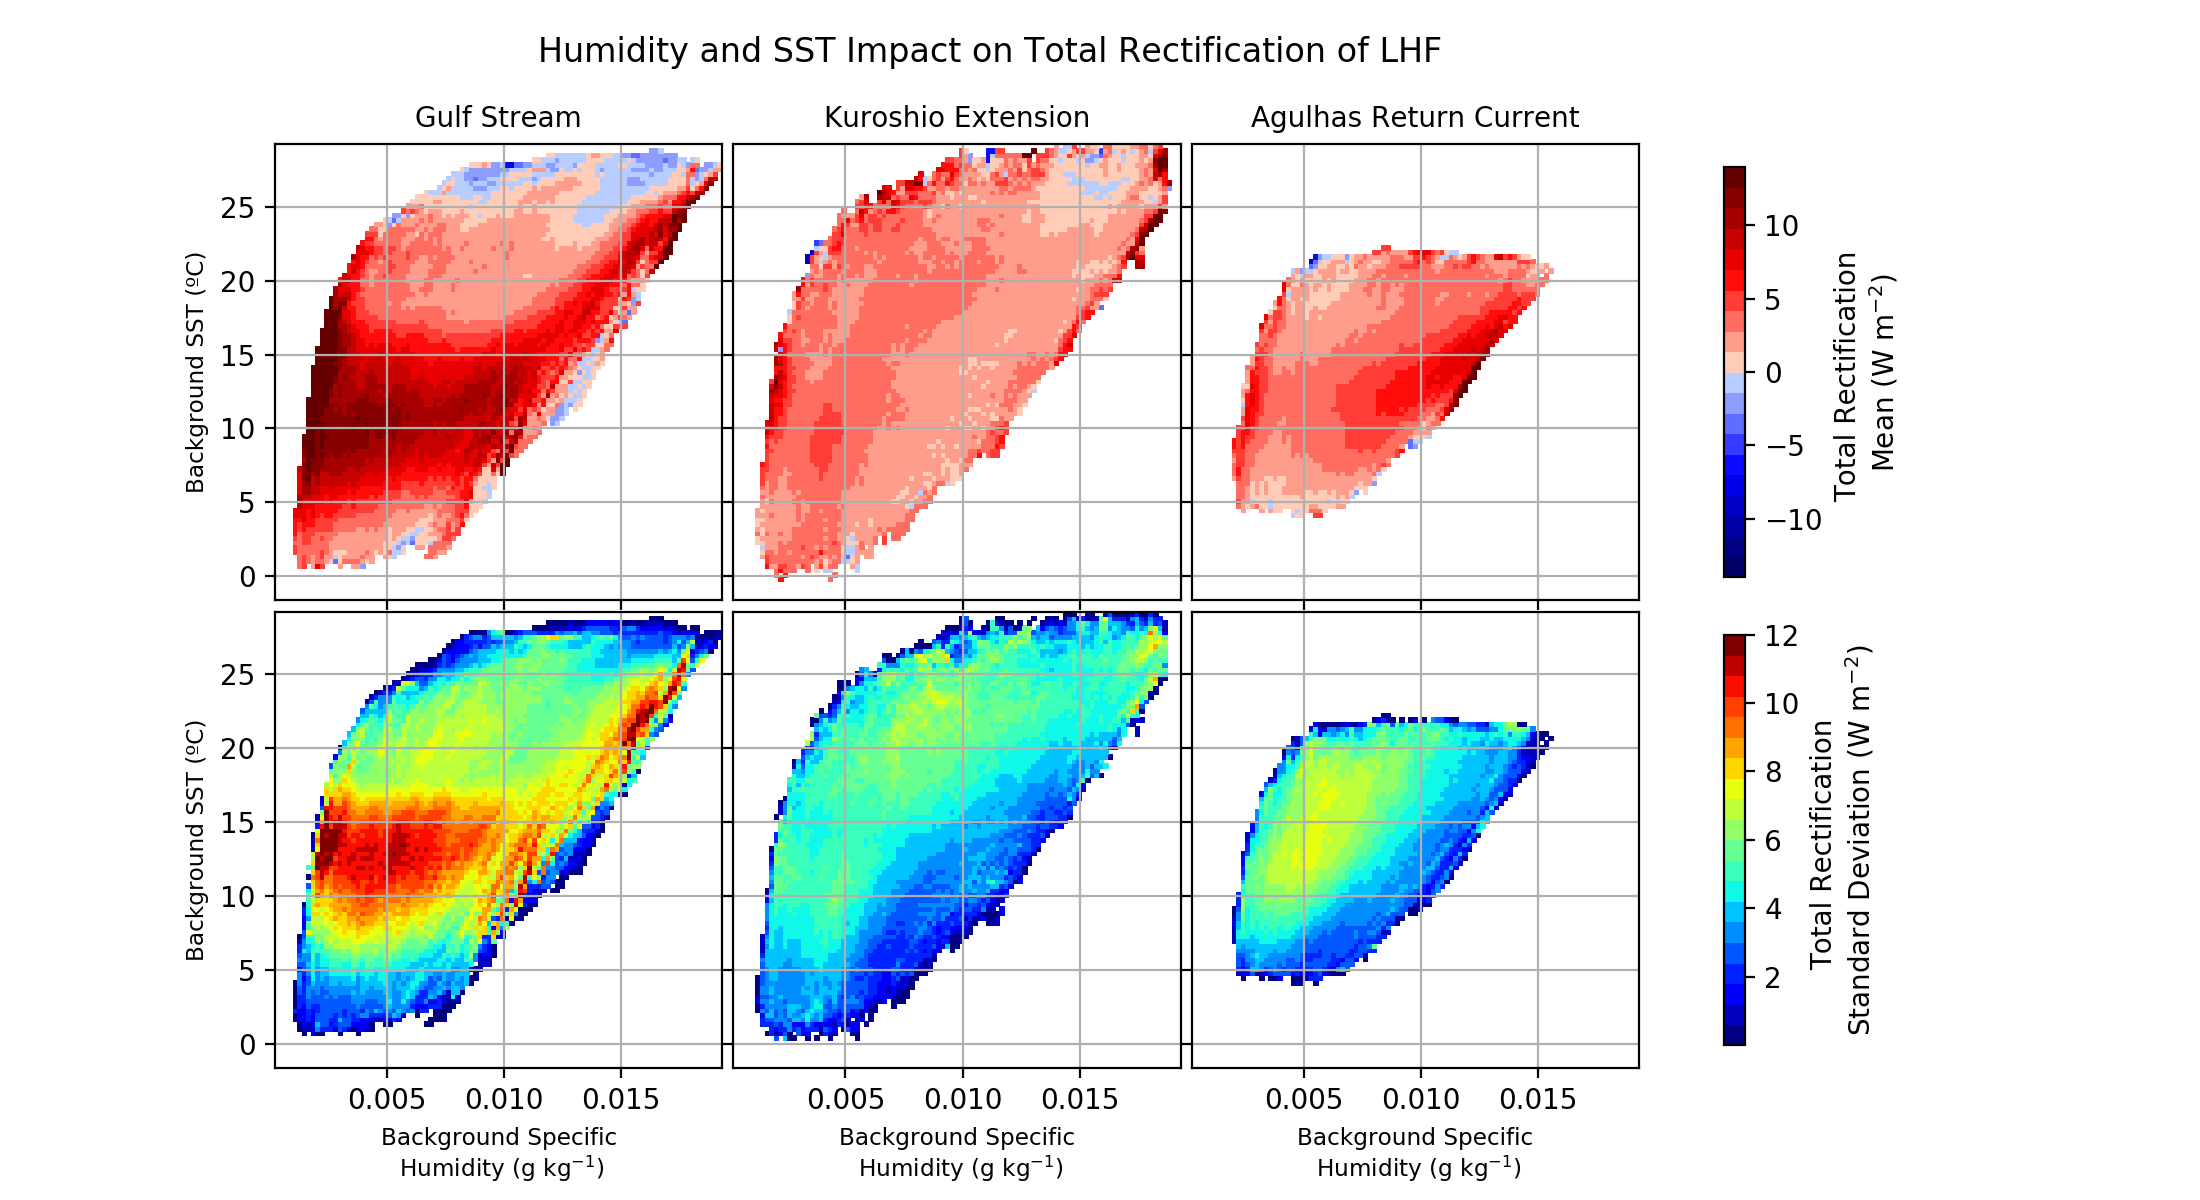

In [37]:
fig, axs = plt.subplots(2,3,figsize=(11,6))
fig.subplots_adjust(wspace=.025,hspace=0.025)
fig.suptitle('Humidity and SST Impact on Total Rectification of LHF', fontsize=12,x=0.45, y=.97)


ax = axs[0,0]
pc = ax.pcolormesh(h3,r3,nonlin_histm_GS3,cmap=cm.get_cmap('BlueRed3', 20),vmin=-14,vmax=14)
ax.set_ylabel("Background SST (ºC)",fontsize='small')
ax.set_title("Gulf Stream",fontsize='medium')
plt.setp(ax.get_xticklabels(), visible=False)
ax.grid()

ax = axs[0,1]
pc = ax.pcolormesh(h3,r3,nonlin_histm_K3,cmap=cm.get_cmap('BlueRed3', 20),vmin=-14,vmax=14)
ax.set_title("Kuroshio Extension",fontsize='medium')
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

ax = axs[0,2]
pc = ax.pcolormesh(h3,r3,nonlin_histm_A3,cmap=cm.get_cmap('BlueRed3', 20),vmin=-14,vmax=14)
fig.colorbar(pc,ax=axs[0],label="Total Rectification \nMean (W m$^{-2}$)",shrink=.9)
ax.set_title("Agulhas Return Current",fontsize='medium')
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

######

ax = axs[1,0]
pc = ax.pcolormesh(h3,r3,nonlin_hists_GS3,cmap=cm.get_cmap('jet', 20),vmax=12)
ax.set_ylabel("Background SST (ºC)",fontsize='small')
ax.set_xlabel("Background Specific\n Humidity (g kg$^{-1}$)",fontsize='small')
ax.grid()

ax = axs[1,1]
pc = ax.pcolormesh(h3,r3,nonlin_hists_K3,cmap=cm.get_cmap('jet', 20),vmax=12)
plt.setp(ax.get_yticklabels(), visible=False)
ax.set_xlabel("Background Specific\n Humidity (g kg$^{-1}$)",fontsize='small')
ax.grid()

ax =axs[1,2]
pc = ax.pcolormesh(h3,r3,nonlin_hists_A3,cmap=cm.get_cmap('jet', 20),vmax=12)
fig.colorbar(pc,ax=axs[1],label="Total Rectification \nStandard Deviation (W m$^{-2}$)",shrink=.9)
plt.setp(ax.get_yticklabels(), visible=False)
ax.set_xlabel("Background Specific\n Humidity (g kg$^{-1}$)",fontsize='small')
ax.grid()



In [38]:
plt.savefig('PAPER_PDFSSTQ_era.png', dpi=300, bbox_inches='tight')


In [57]:
r2, h2, nonlin_histm_GS2, nonlin_histm_K2, nonlin_histm_A2 = makehistavg3x(sststd_GS,sststd_K,sststd_A,sstsm_GS,sstsm_K,sstsm_A,nonlin_GS,nonlin_K,nonlin_A,100,100)
r2, h2, nonlin_hists_GS2, nonlin_hists_K2, nonlin_hists_A2 = makehiststd3x(sststd_GS,sststd_K,sststd_A,sstsm_GS,sstsm_K,sstsm_A,nonlin_GS,nonlin_K,nonlin_A,100,100)

nonlin_histm_GS2[np.where(nonlin_histm_GS2 == 0.0)] = None
nonlin_histm_K2[np.where(nonlin_histm_K2 == 0.0)] = None
nonlin_histm_A2[np.where(nonlin_histm_A2 == 0.0)] = None

nonlin_hists_GS2[np.where(nonlin_hists_GS2 == 0.0)] = None
nonlin_hists_K2[np.where(nonlin_hists_K2 == 0.0)] = None
nonlin_hists_A2[np.where(nonlin_hists_A2 == 0.0)] = None


/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater_equal
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in less
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater_equal
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


<IPython.core.display.Javascript object>


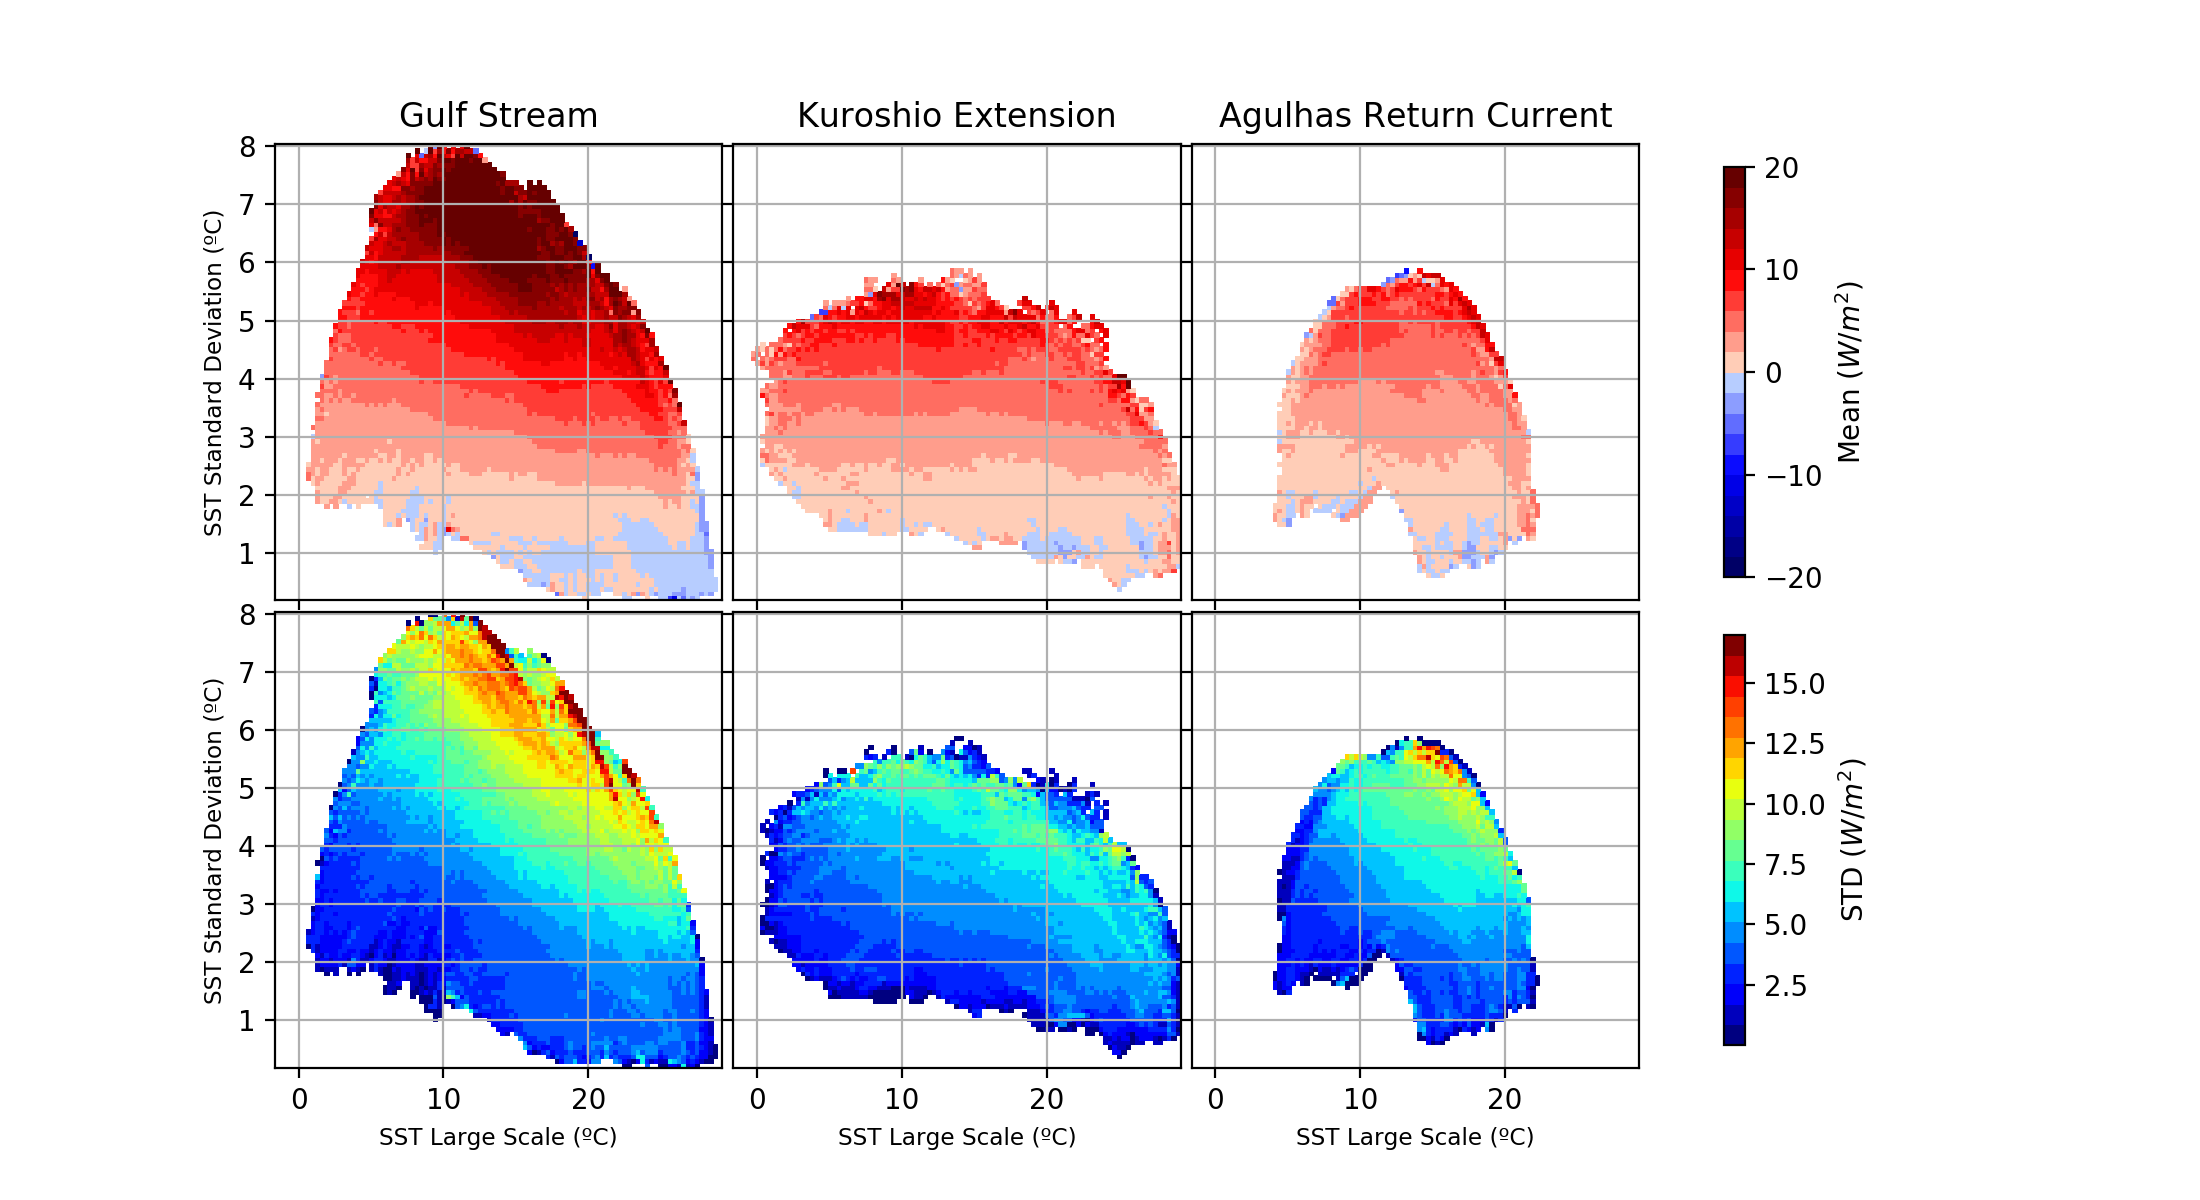

In [92]:
fig, axs = plt.subplots(2,3,figsize=(11,6))
fig.subplots_adjust(wspace=.025,hspace=0.025)

ax = axs[0,0]
pc = ax.pcolormesh(h2,r2,nonlin_histm_GS2,cmap=cm.get_cmap('BlueRed3', 20),vmin=-20,vmax=20)
ax.set_ylabel("SST Standard Deviation (ºC)",fontsize='small')
ax.set_title("Gulf Stream")
plt.setp(ax.get_xticklabels(), visible=False)
ax.grid()

ax = axs[0,1]
pc = ax.pcolormesh(h2,r2,nonlin_histm_K2,cmap=cm.get_cmap('BlueRed3', 20),vmin=-20,vmax=20)
ax.set_title("Kuroshio Extension")
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

ax = axs[0,2]
pc = ax.pcolormesh(h2,r2,nonlin_histm_A2,cmap=cm.get_cmap('BlueRed3', 20),vmin=-20,vmax=20)
fig.colorbar(pc,ax=axs[0],label="Mean ($W/m^2$)",shrink=.9)
ax.set_title("Agulhas Return Current")
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

######

ax = axs[1,0]
pc = ax.pcolormesh(h2,r2,nonlin_hists_GS2,cmap=cm.get_cmap('jet', 20),vmax=17)
ax.set_ylabel("SST Standard Deviation (ºC)",fontsize='small')
ax.set_xlabel("SST Large Scale (ºC)",fontsize='small')
ax.grid()

ax = axs[1,1]
pc = ax.pcolormesh(h2,r2,nonlin_hists_K2,cmap=cm.get_cmap('jet', 20),vmax=17)
plt.setp(ax.get_yticklabels(), visible=False)
ax.set_xlabel("SST Large Scale (ºC)",fontsize='small')
ax.grid()

ax = axs[1,2]
pc = ax.pcolormesh(h2,r2,nonlin_hists_A2,cmap=cm.get_cmap('jet', 20),vmax=17)
fig.colorbar(pc,ax=axs[1],label="STD ($W/m^2$)",shrink=.9)
plt.setp(ax.get_yticklabels(), visible=False)
ax.set_xlabel("SST Large Scale (ºC)",fontsize='small')
ax.grid()



In [66]:
r4, h4, nonlin_histm_GS4, nonlin_histm_K4, nonlin_histm_A4 = makehistavg3x(sststd_GS,sststd_K,sststd_A,sphsm_GS,sphsm_K,sphsm_A,nonlin_GS,nonlin_K,nonlin_A,100,100)
r4, h4, nonlin_hists_GS4, nonlin_hists_K4, nonlin_hists_A4 = makehiststd3x(sststd_GS,sststd_K,sststd_A,sphsm_GS,sphsm_K,sphsm_A,nonlin_GS,nonlin_K,nonlin_A,100,100)

nonlin_histm_GS4[np.where(nonlin_histm_GS4 == 0.0)] = None
nonlin_histm_K4[np.where(nonlin_histm_K4 == 0.0)] = None
nonlin_histm_A4[np.where(nonlin_histm_A4 == 0.0)] = None

nonlin_hists_GS4[np.where(nonlin_hists_GS4 == 0.0)] = None
nonlin_hists_K4[np.where(nonlin_hists_K4 == 0.0)] = None
nonlin_hists_A4[np.where(nonlin_hists_A4 == 0.0)] = None


/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater_equal
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in less
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater_equal
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


<IPython.core.display.Javascript object>


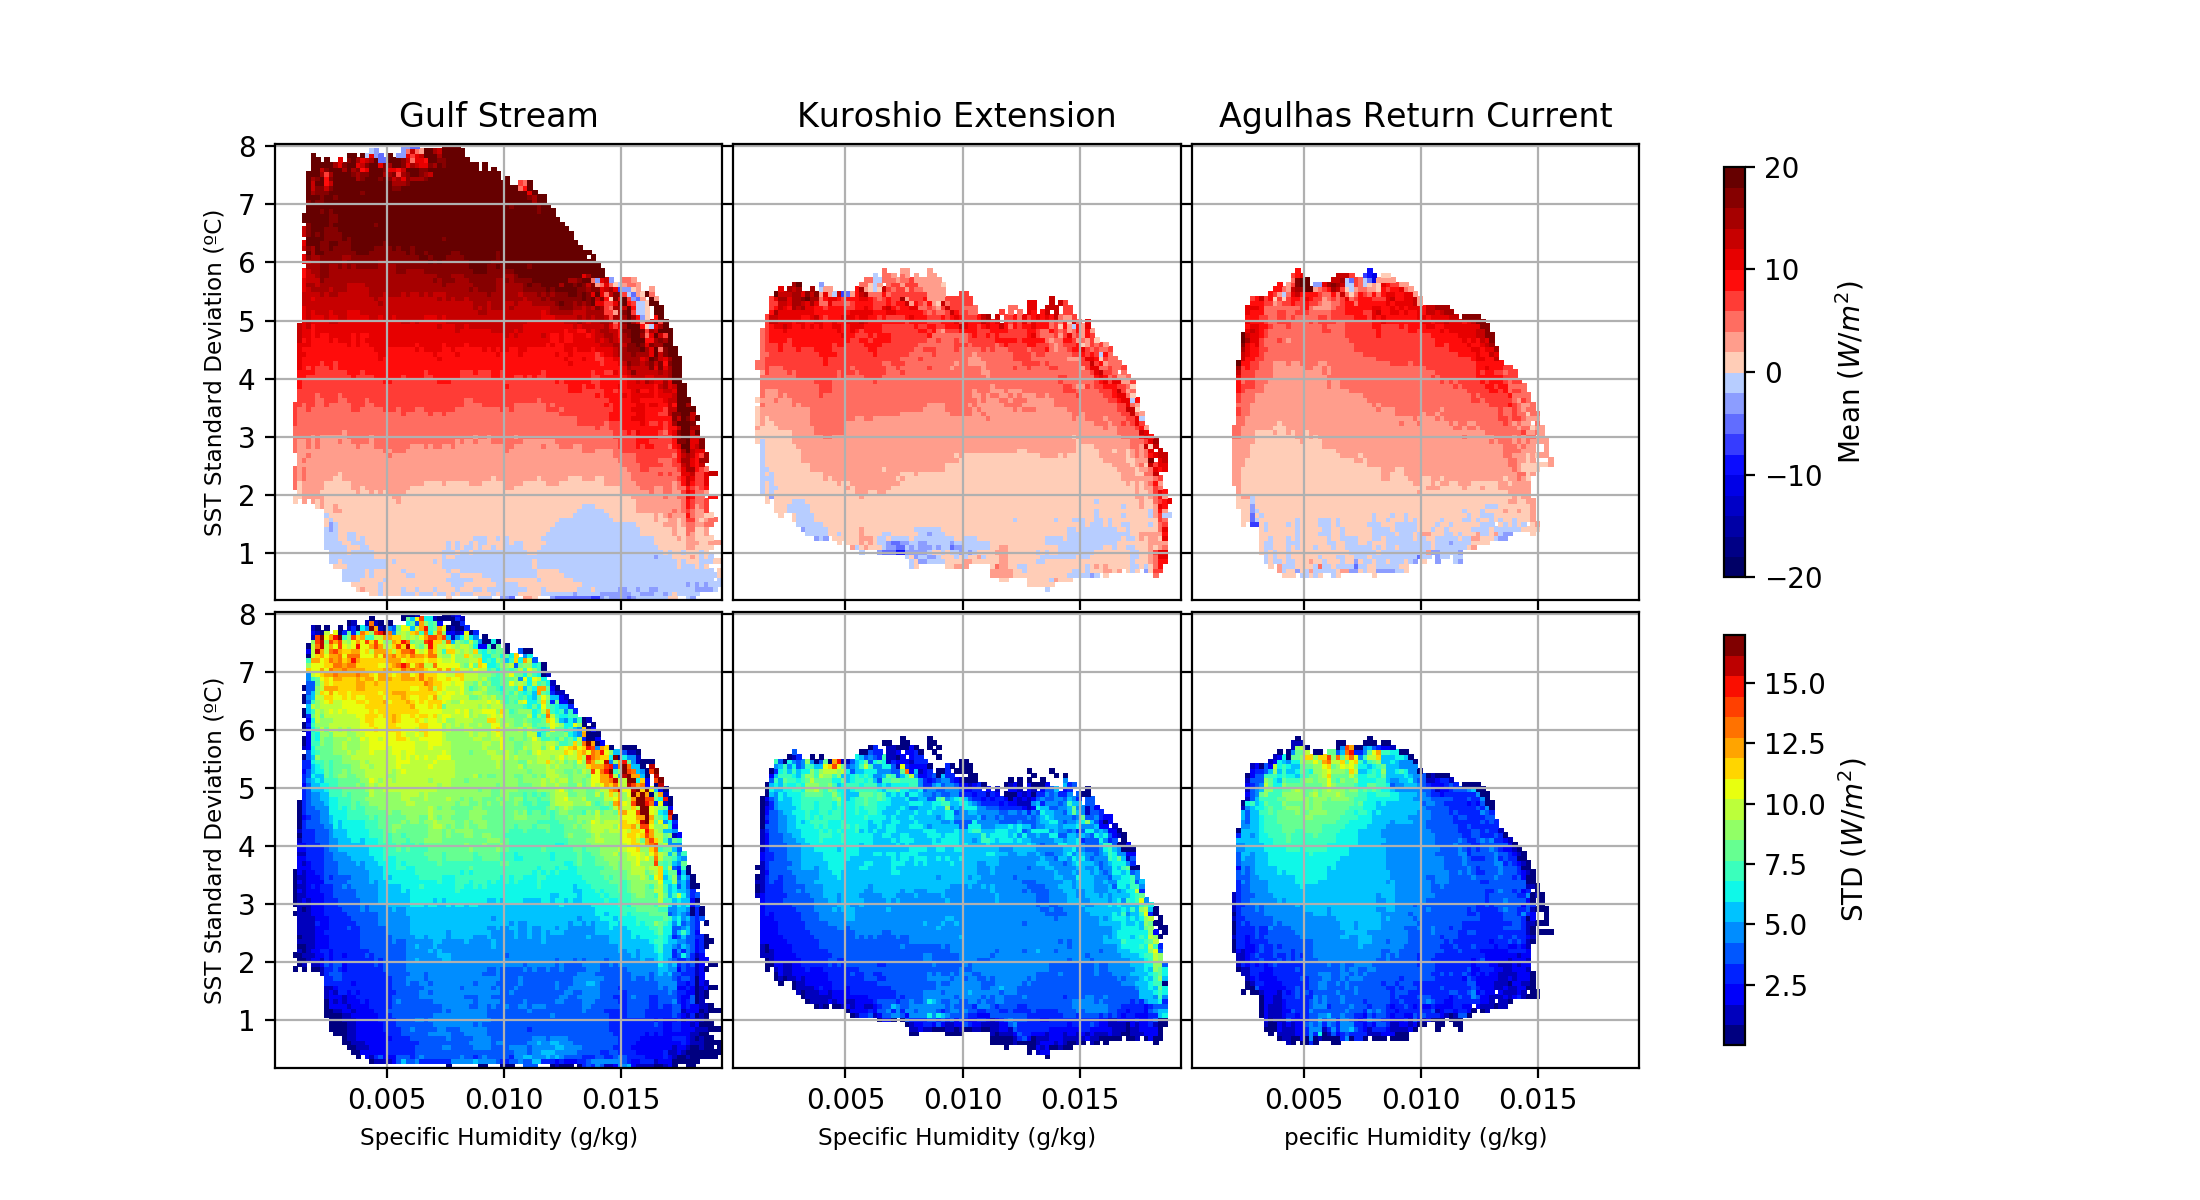

In [91]:
fig, axs = plt.subplots(2,3,figsize=(11,6))
fig.subplots_adjust(wspace=.025,hspace=0.025)

ax = axs[0,0]
pc = ax.pcolormesh(h4,r4,nonlin_histm_GS4,cmap=cm.get_cmap('BlueRed3', 20),vmin=-20,vmax=20)
ax.set_ylabel("SST Standard Deviation (ºC)",fontsize='small')
ax.set_title("Gulf Stream")
plt.setp(ax.get_xticklabels(), visible=False)
ax.grid()

ax = axs[0,1]
pc = ax.pcolormesh(h4,r4,nonlin_histm_K4,cmap=cm.get_cmap('BlueRed3', 20),vmin=-20,vmax=20)
ax.set_title("Kuroshio Extension")
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

ax = axs[0,2]
pc = ax.pcolormesh(h4,r4,nonlin_histm_A4,cmap=cm.get_cmap('BlueRed3', 20),vmin=-20,vmax=20)
fig.colorbar(pc,ax=axs[0],label="Mean ($W/m^2$)",shrink=.9)
ax.set_title("Agulhas Return Current")
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

######

ax = axs[1,0]
pc = ax.pcolormesh(h4,r4,nonlin_hists_GS4,cmap=cm.get_cmap('jet', 20),vmax=17)
ax.set_ylabel("SST Standard Deviation (ºC)",fontsize='small')
ax.set_xlabel("Specific Humidity (g/kg)",fontsize='small')
ax.grid()

ax = axs[1,1]
pc = ax.pcolormesh(h4,r4,nonlin_hists_K4,cmap=cm.get_cmap('jet', 20),vmax=17)
plt.setp(ax.get_yticklabels(), visible=False)
ax.set_xlabel("Specific Humidity (g/kg)",fontsize='small')
ax.grid()

ax = axs[1,2]
pc = ax.pcolormesh(h4,r4,nonlin_hists_A4,cmap=cm.get_cmap('jet', 20),vmax=17)
fig.colorbar(pc,ax=axs[1],label="STD ($W/m^2$)",shrink=.9)
plt.setp(ax.get_yticklabels(), visible=False)
ax.set_xlabel("pecific Humidity (g/kg)",fontsize='small')
ax.grid()



In [107]:
r, h, hist6_GS = makehistavg(sststd_GS,wGS,Q6_GS,100,100)
r, h, hist6s_GS = makehiststd(sststd_GS,wGS,Q6_GS,100,100)

hist6_GS[np.where(hist6_GS == 0.0)] = None
hist6s_GS[np.where(hist6s_GS == 0.0)] = None


/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater_equal
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


<IPython.core.display.Javascript object>


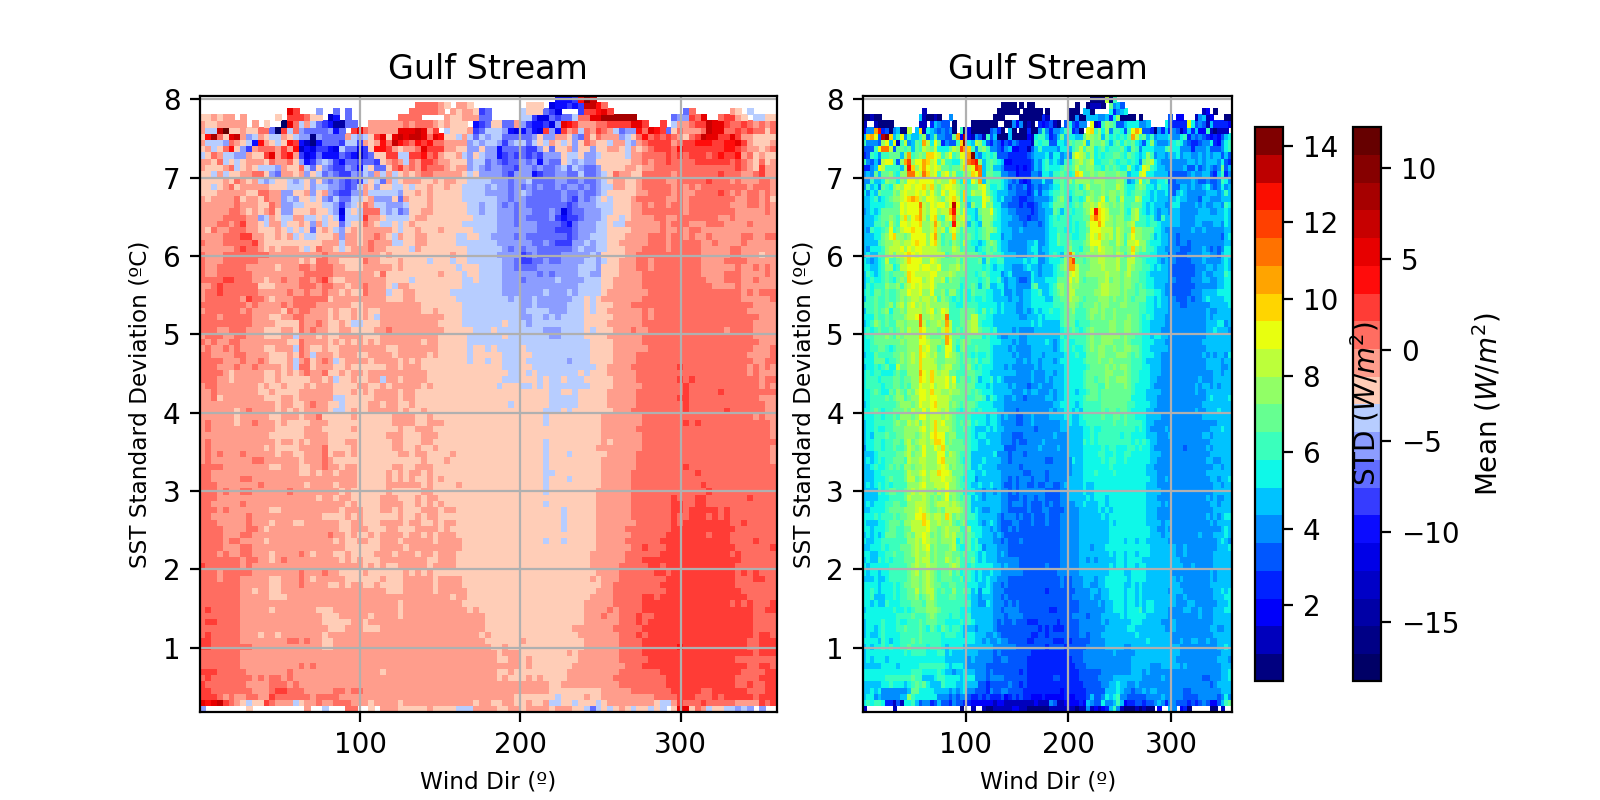

In [112]:
fig, axs = plt.subplots(ncols=2,figsize=(8,4))
fig.subplots_adjust(wspace=.15)

ax = axs[0]
pc = ax.pcolormesh(h,r,hist6_GS,cmap=cm.get_cmap('BlueRed3', 20))
ax.set_ylabel("SST Standard Deviation (ºC)",fontsize='small')
fig.colorbar(pc,ax=axs[1],label="Mean ($W/m^2$)",shrink=.9)
ax.set_title("Gulf Stream")
ax.set_xlabel("Wind Dir (º)",fontsize='small')
ax.grid()

ax = axs[1]
pc = ax.pcolormesh(h,r,hist6s_GS,cmap=cm.get_cmap('jet', 20))
ax.set_ylabel("SST Standard Deviation (ºC)",fontsize='small')
ax.set_title("Gulf Stream")
fig.colorbar(pc,ax=axs[1],label="STD ($W/m^2$)",shrink=.9)
ax.set_xlabel("Wind Dir (º)",fontsize='small')
ax.grid()


## Histograms, Rectification against SST and Wspd

In [21]:
#varr = sstsm_GS #y-axis
#varh = wspdavgsm_GS #x-axis
#varavg = UT_GS

#r, h, hist = makehistcount(varr,varh,120,80)


#y, x, hist = makehistavg(y-axis,x-axis,varavg,120,80)
r_GS, h_GS, hist_GS = makehistavg(sstsm_GS,wspdavgsm_GS,Q4_GS,100,100)
r_K, h_K, hist_K = makehistavg(sstsm_K,wspdavgsm_K,Q4_K,100,100)
r_A, h_A, hist_A = makehistavg(sstsm_A,wspdavgsm_A,Q4_A,100,100)



/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater_equal
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice


In [ ]:
fig, ax = plt.subplots()

hist_GS[np.where(hist_GS == 0.0)] = None

pc = ax.pcolormesh(h_GS,r_GS,hist_GS,cmap=plt.cm.get_cmap('gist_ncar'),vmax=20)

fig.colorbar(pc,ax=ax,label="$Q_{CC}$ ($W/m^2$)")
ax.set_xlabel("Wind Speed Low Pass (m/s)")
ax.set_ylabel("SST Low Pass (ºC)")
ax.set_title("Gulf Stream $Q_{CC}$ Reanalysis")
#plt.xticks(rotation = 10)
ax.grid()



In [ ]:
plt.savefig('qcc_composite_usmsstsm_GS_era.png', dpi=300, bbox_inches='tight')


In [ ]:
fig, ax = plt.subplots()

hist_K[np.where(hist_K == 0.0)] = None

pc = ax.pcolormesh(h_K,r_K,hist_K,cmap=plt.cm.get_cmap('gist_ncar'),vmax=11)

fig.colorbar(pc,ax=ax,label="$Q_{CC}$ ($W/m^2$)")
ax.set_xlabel("Wind Speed Low Pass (m/s)")
ax.set_ylabel("SST Low Pass (ºC)")
ax.set_title("Kuroshio $Q_{CC}$ Reanalysis")
#plt.xticks(rotation = 10)
ax.grid()

In [ ]:
plt.savefig('qcc_composite_usmsstsm_K_era.png', dpi=300, bbox_inches='tight')


In [ ]:
fig, ax = plt.subplots()

hist_A[np.where(hist_A == 0.0)] = None

pc = ax.pcolormesh(h_A,r_A,hist_A,cmap=plt.cm.get_cmap('gist_ncar'),vmax=13)

fig.colorbar(pc,ax=ax,label="$Q_{CC}$ ($W/m^2$)")
ax.set_xlabel("Wind Speed Low Pass (m/s)")
ax.set_ylabel("SST Low Pass (ºC)")
ax.set_title("Agulhas $Q_{CC}$ Reanalysis")
#plt.xticks(rotation = 10)
ax.grid()

In [ ]:
plt.savefig('qcc_composite_usmsstsm_A_era.png', dpi=300, bbox_inches='tight')


In [ ]:
fig, axs = plt.subplots(ncols=3,figsize=(14,3))
fig.subplots_adjust(wspace=.4)

hist_GS[np.where(hist_GS == 0.0)] = None
hist_K[np.where(hist_K == 0.0)] = None
hist_A[np.where(hist_A == 0.0)] = None

ax = axs[0]
pc = ax.pcolormesh(h_GS,r_GS,hist_GS,cmap=plt.cm.get_cmap('gist_ncar'),vmax=10)
#fig.colorbar(pc,ax=ax,label="$Q_{CC}$ ($W/m^2$)")
ax.set_xlabel("Wind Speed Low Pass (m/s)")
ax.set_ylabel("SST Low Pass (ºC)")
ax.set_title("Gulf Stream $Q_{CC}$ Reanalysis")
#plt.xticks(rotation = 10)
ax.grid()

ax = axs[1]
pc = ax.pcolormesh(h_K,r_K,hist_K,cmap=plt.cm.get_cmap('gist_ncar'),vmax=10)
#fig.colorbar(pc,ax=ax,label="$Q_{CC}$ ($W/m^2$)")
ax.set_xlabel("Wind Speed Low Pass (m/s)")
ax.set_ylabel("SST Low Pass (ºC)")
ax.set_title("Kuroshio $Q_{CC}$ Reanalysis")
#plt.xticks(rotation = 10)
ax.grid()

ax = axs[2]
pc = ax.pcolormesh(h_A,r_A,hist_A,cmap=plt.cm.get_cmap('gist_ncar'),vmax=10)
fig.colorbar(pc,ax=ax,label="$Q_{CC}$ ($W/m^2$)")
ax.set_xlabel("Wind Speed Low Pass (m/s)")
ax.set_ylabel("SST Low Pass (ºC)")
ax.set_title("Agulhas $Q_{CC}$ Reanalysis")
#plt.xticks(rotation = 10)
ax.grid()


In [ ]:
plt.savefig('qcc_composite_usmsstsm_era.png', dpi=300, bbox_inches='tight')


In [ ]:
r_GS, h_GS, hist_GS = makehistavg(sstsm_GS,wspdavgsm_GS,Q5_GS,100,100)
r_K, h_K, hist_K = makehistavg(sstsm_K,wspdavgsm_K,Q5_K,100,100)
r_A, h_A, hist_A = makehistavg(sstsm_A,wspdavgsm_A,Q5_A,100,100)


In [ ]:
fig, ax = plt.subplots()

hist_GS[np.where(hist_GS == 0.0)] = None

#ax.plot(r,c,'.')
#pc = ax.pcolormesh(h,r,hist)#,vmin=-12, vmax=12
pc = ax.pcolormesh(h_GS,r_GS,hist_GS,cmap=plt.cm.get_cmap('BlueRed3'),vmin=-8,vmax=8)

fig.colorbar(pc,ax=ax,label="$Q_{UT}$ ($W/m^2$)")
ax.set_xlabel("Wind Speed Low Pass (m/s)")
ax.set_ylabel("SST Low Pass (ºC)")
ax.set_title("Gulf Stream $Q_{UT}$ Mean")
#plt.xticks(rotation = 10)
ax.grid()

In [ ]:
plt.savefig('qut_composite_usmsstsm_GS_erav2.png', dpi=300, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots()

hist_K[np.where(hist_K == 0.0)] = None

pc = ax.pcolormesh(h_K,r_K,hist_K,cmap=plt.cm.get_cmap('BlueRed3'),vmin=-8,vmax=8)

fig.colorbar(pc,ax=ax,label="$Q_{UT}$ ($W/m^2$)")
ax.set_xlabel("Wind Speed Low Pass (m/s)")
ax.set_ylabel("SST Low Pass (ºC)")
ax.set_title("Kuroshio $Q_{UT}$ Mean")
#plt.xticks(rotation = 10)
ax.grid()

In [ ]:
plt.savefig('qut_composite_usmsstsm_K_erav2.png', dpi=300, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots()

hist_A[np.where(hist_A == 0.0)] = None

pc = ax.pcolormesh(h_A,r_A,hist_A,cmap=plt.cm.get_cmap('BlueRed3'),vmin=-8,vmax=8)

fig.colorbar(pc,ax=ax,label="$Q_{UT}$ ($W/m^2$)")
ax.set_xlabel("Wind Speed Low Pass (m/s)")
ax.set_ylabel("SST Low Pass (ºC)")
ax.set_title("Agulhas $Q_{UT}$ Mean")
#plt.xticks(rotation = 10)
ax.grid()

In [ ]:

plt.savefig('qut_composite_usmsstsm_A_erav2.png', dpi=300, bbox_inches='tight')


In [ ]:
fig, axs = plt.subplots(ncols=3,figsize=(14,3))
fig.subplots_adjust(wspace=.4)

hist_GS[np.where(hist_GS == 0.0)] = None
hist_K[np.where(hist_K == 0.0)] = None
hist_A[np.where(hist_A == 0.0)] = None

ax = axs[0]
pc = ax.pcolormesh(h_GS,r_GS,hist_GS,cmap='BlueRed3',vmin=-8,vmax=8)
#fig.colorbar(pc,ax=ax,label="$Q_{UT}$ ($W/m^2$)")
ax.set_xlabel("Wind Speed Low Pass (m/s)")
ax.set_ylabel("SST Low Pass (ºC)")
ax.set_title("Gulf Stream $Q_{UT}$ Standard Deviation")
#plt.xticks(rotation = 10)
ax.grid()

ax = axs[1]
pc = ax.pcolormesh(h_K,r_K,hist_K,cmap='BlueRed3',vmin=-8,vmax=8)
#fig.colorbar(pc,ax=ax,label="$Q_{UT}$ ($W/m^2$)")
ax.set_xlabel("Wind Speed Low Pass (m/s)")
ax.set_ylabel("SST Low Pass (ºC)")
ax.set_title("Kuroshio $Q_{UT}$ Standard Deviation")
#plt.xticks(rotation = 10)
ax.grid()

ax = axs[2]
pc = ax.pcolormesh(h_A,r_A,hist_A,cmap='BlueRed3',vmin=-8,vmax=8)
fig.colorbar(pc,ax=ax,label="$Q_{UT}$ ($W/m^2$)")
ax.set_xlabel("Wind Speed Low Pass (m/s)")
ax.set_ylabel("SST Low Pass (ºC)")
ax.set_title("Agulhas $Q_{UT}$ Standard Deviation")
#plt.xticks(rotation = 10)
ax.grid()


In [ ]:
plt.savefig('qut_composite_usmsstsm_erav2.png', dpi=300, bbox_inches='tight')


In [ ]:
r_GS, h_GS, hist_GS = makehiststd(sstsm_GS,wspdavgsm_GS,Q5_GS,100,100)
r_K, h_K, hist_K = makehiststd(sstsm_K,wspdavgsm_K,Q5_K,100,100)
r_A, h_A, hist_A = makehiststd(sstsm_A,wspdavgsm_A,Q5_A,100,100)


In [ ]:
fig, ax = plt.subplots()

hist_GS[np.where(hist_GS == 0.0)] = None

#ax.plot(r,c,'.')
#pc = ax.pcolormesh(h,r,hist)#,vmin=-12, vmax=12
pc = ax.pcolormesh(h_GS,r_GS,hist_GS,cmap=plt.cm.get_cmap('gist_ncar'),vmax=12)

fig.colorbar(pc,ax=ax,label="$Q_{UT}$ ($W/m^2$)")
ax.set_xlabel("Wind Speed Low Pass (m/s)")
ax.set_ylabel("SST Low Pass (ºC)")
ax.set_title("Gulf Stream $Q_{UT}$ Standard Deviation")
#plt.xticks(rotation = 10)
ax.grid()


In [ ]:
fig, ax = plt.subplots()

hist_K[np.where(hist_K == 0.0)] = None

pc = ax.pcolormesh(h_K,r_K,hist_K,cmap=plt.cm.get_cmap('gist_ncar'),vmax=12)

fig.colorbar(pc,ax=ax,label="$Q_{UT}$ ($W/m^2$)")
ax.set_xlabel("Wind Speed Low Pass (m/s)")
ax.set_ylabel("SST Low Pass (ºC)")
ax.set_title("Kuroshio $Q_{UT}$ Standard Deviation")
#plt.xticks(rotation = 10)
ax.grid()

In [ ]:
fig, ax = plt.subplots()

hist_A[np.where(hist_A == 0.0)] = None

pc = ax.pcolormesh(h_A,r_A,hist_A,cmap=plt.cm.get_cmap('gist_ncar'),vmax=12)

fig.colorbar(pc,ax=ax,label="$Q_{UT}$ ($W/m^2$)")
ax.set_xlabel("Wind Speed Low Pass (m/s)")
ax.set_ylabel("SST Low Pass (ºC)")
ax.set_title("Agulhas $Q_{UT}$ Standard Deviation")
#plt.xticks(rotation = 10)
ax.grid()

In [ ]:

plt.savefig('qutstd_composite_usmsstsm_A_era.png', dpi=300, bbox_inches='tight')


In [ ]:
fig, axs = plt.subplots(ncols=3,figsize=(14,3))
fig.subplots_adjust(wspace=.4)

hist_GS[np.where(hist_GS == 0.0)] = None
hist_K[np.where(hist_K == 0.0)] = None
hist_A[np.where(hist_A == 0.0)] = None

ax = axs[0]
pc = ax.pcolormesh(h_GS,r_GS,hist_GS,cmap=plt.cm.get_cmap('gist_ncar'),vmax=12)
#fig.colorbar(pc,ax=ax,label="$Q_{UT}$ ($W/m^2$)")
ax.set_xlabel("Wind Speed Low Pass (m/s)")
ax.set_ylabel("SST Low Pass (ºC)")
ax.set_title("Gulf Stream $Q_{UT}$ Standard Deviation")
#plt.xticks(rotation = 10)
ax.grid()

ax = axs[1]
pc = ax.pcolormesh(h_K,r_K,hist_K,cmap=plt.cm.get_cmap('gist_ncar'),vmax=12)
#fig.colorbar(pc,ax=ax,label="$Q_{UT}$ ($W/m^2$)")
ax.set_xlabel("Wind Speed Low Pass (m/s)")
ax.set_ylabel("SST Low Pass (ºC)")
ax.set_title("Kuroshio $Q_{UT}$ Standard Deviation")
#plt.xticks(rotation = 10)
ax.grid()

ax = axs[2]
pc = ax.pcolormesh(h_A,r_A,hist_A,cmap=plt.cm.get_cmap('gist_ncar'),vmax=12)
fig.colorbar(pc,ax=ax,label="$Q_{UT}$ ($W/m^2$)")
ax.set_xlabel("Wind Speed Low Pass (m/s)")
ax.set_ylabel("SST Low Pass (ºC)")
ax.set_title("Agulhas $Q_{UT}$ Standard Deviation")
#plt.xticks(rotation = 10)
ax.grid()



In [ ]:
plt.savefig('qutstd_composite_usmsstsm_era.png', dpi=300, bbox_inches='tight')


In [ ]:
#y, x, hist = makehistavg(y-axis,x-axis,varavg,120,80)

r_GS, h_GS, hist_GS = makehistcount(wspdavgsm_GS,wdir_GS,100,100)
r_K, h_K, hist_K = makehistcount(wspdavgsm_K,wdir_K,100,100)
r_A, h_A, hist_A = makehistcount(wspdavgsm_A,wdir_A,100,100)


In [ ]:
fig, ax = plt.subplots()

hist_GS[np.where(hist_GS == 0.0)] = None

#pc = ax.pcolormesh(h_GS,r_GS,hist_GS)
pc = ax.pcolormesh(h_GS,r_GS,hist_GS,cmap=plt.cm.get_cmap('gist_ncar'))
fig.colorbar(pc,ax=ax,label="Number of Ocurrences")
ax.set_xlabel("Wind Direction (º)")
ax.set_ylabel("Wind Speed Low Pass (m/s)")
ax.set_title("Gulf Stream Wind Climatology Reanalysis")
#plt.xticks(rotation = 10)
ax.grid()

In [ ]:
plt.savefig('windhist_GS_era.png', dpi=300, bbox_inches='tight')


In [ ]:
fig, ax = plt.subplots()

hist_K[np.where(hist_K == 0.0)] = None

#pc = ax.pcolormesh(h_K,r_K,hist_K)
pc = ax.pcolormesh(h_K,r_K,hist_K,cmap=plt.cm.get_cmap('gist_ncar'))
fig.colorbar(pc,ax=ax,label="Number of Counts")
ax.set_xlabel("Wind Direction (º)")
ax.set_ylabel("Wind Speed Low Pass (m/s)")
ax.set_title("Kuroshio Wind Climatology Reanalysis")
#plt.xticks(rotation = 10)
ax.grid()

In [ ]:
plt.savefig('windhist_K_era.png', dpi=300, bbox_inches='tight')


In [ ]:
fig, ax = plt.subplots()

hist_A[np.where(hist_A == 0.0)] = None

#pc = ax.pcolormesh(h_A,r_A,hist_A)
pc = ax.pcolormesh(h_A,r_A,hist_A,cmap=plt.cm.get_cmap('gist_ncar'))
fig.colorbar(pc,ax=ax,label="Number of Counts")
ax.set_xlabel("Wind Direction (º)")
ax.set_ylabel("Wind Speed Low Pass (m/s)")
ax.set_title("Agulhas Wind Climatology Reanalysis")
#plt.xticks(rotation = 10)
ax.grid()

In [ ]:
plt.savefig('windhist_A_era.png', dpi=300, bbox_inches='tight')


In [ ]:
r_GS, h_GS, hist_GS = makehistavg(sstsm_GS,wspdavgsm_GS,Q6_GS,100,100)
r_K, h_K, hist_K = makehistavg(sstsm_K,wspdavgsm_K,Q6_K,100,100)
r_A, h_A, hist_A = makehistavg(sstsm_A,wspdavgsm_A,Q6_A,100,100)


In [ ]:
fig, ax = plt.subplots()

hist_GS[np.where(hist_GS == 0.0)] = None

pc = ax.pcolormesh(h_GS,r_GS,hist_GS,cmap=plt.cm.get_cmap('BlueRed3'),vmin=-8,vmax=8)
fig.colorbar(pc,ax=ax,label="$Q_{UH}$ ($W/m^2$)")
ax.set_xlabel("Wind Speed Low Pass (m/s)")
ax.set_ylabel("SST Low Pass (ºC)")
ax.set_title("Gulf Stream $Q_{UH}$ Reanalysis")
#plt.xticks(rotation = 10)
ax.grid()

In [ ]:
plt.savefig('quh_composite_usmsstsm_GS_era.png', dpi=300, bbox_inches='tight')


In [ ]:
fig, ax = plt.subplots()

hist_K[np.where(hist_K == 0.0)] = None

pc = ax.pcolormesh(h_K,r_K,hist_K,cmap=plt.cm.get_cmap('BlueRed3'),vmin=-8,vmax=8)

fig.colorbar(pc,ax=ax,label="$Q_{UH}$ ($W/m^2$)")
ax.set_xlabel("Wind Speed Low Pass (m/s)")
ax.set_ylabel("SST Low Pass (ºC)")
ax.set_title("Kuroshio $Q_{UH}$ Reanalysis")
#plt.xticks(rotation = 10)
ax.grid()

In [ ]:
plt.savefig('quh_composite_usmsstsm_K_era.png', dpi=300, bbox_inches='tight')


In [ ]:
fig, ax = plt.subplots()

hist_A[np.where(hist_A == 0.0)] = None

pc = ax.pcolormesh(h_A,r_A,hist_A,cmap=plt.cm.get_cmap('BlueRed3'),vmin=-8,vmax=8)

fig.colorbar(pc,ax=ax,label="$Q_{UH}$ ($W/m^2$)")
ax.set_xlabel("Wind Speed Low Pass (m/s)")
ax.set_ylabel("SST Low Pass (ºC)")
ax.set_title("Agulhas $Q_{UH}$ Reanalysis")
#plt.xticks(rotation = 10)
ax.grid()

In [ ]:
plt.savefig('quh_composite_usmsstsm_A_era.png', dpi=300, bbox_inches='tight')


In [ ]:
fig, axs = plt.subplots(ncols=3,figsize=(14,3))
fig.subplots_adjust(wspace=.4)

hist_GS[np.where(hist_GS == 0.0)] = None
hist_K[np.where(hist_K == 0.0)] = None
hist_A[np.where(hist_A == 0.0)] = None

ax = axs[0]
pc = ax.pcolormesh(h_GS,r_GS,hist_GS,cmap=plt.cm.get_cmap('BlueRed3'),vmin=-8,vmax=8)
fig.colorbar(pc,ax=ax,label="$Q_{UH}$ ($W/m^2$)")
ax.set_xlabel("Wind Speed Low Pass (m/s)")
ax.set_ylabel("SST Low Pass (ºC)")
ax.set_title("Gulf Stream $Q_{UH}$ Mean")
#plt.xticks(rotation = 10)
ax.grid()

ax = axs[1]
pc = ax.pcolormesh(h_K,r_K,hist_K,cmap=plt.cm.get_cmap('BlueRed3'),vmin=-8,vmax=8)
fig.colorbar(pc,ax=ax,label="$Q_{UH}$ ($W/m^2$)")
ax.set_xlabel("Wind Speed Low Pass (m/s)")
ax.set_ylabel("SST Low Pass (ºC)")
ax.set_title("Kuroshio $Q_{UH}$ Mean")
#plt.xticks(rotation = 10)
ax.grid()

ax = axs[2]
pc = ax.pcolormesh(h_A,r_A,hist_A,cmap=plt.cm.get_cmap('BlueRed3'),vmin=-8,vmax=8)
fig.colorbar(pc,ax=ax,label="$Q_{UH}$ ($W/m^2$)")
ax.set_xlabel("Wind Speed Low Pass (m/s)")
ax.set_ylabel("SST Low Pass (ºC)")
ax.set_title("Agulhas $Q_{UH}$ Mean")
#plt.xticks(rotation = 10)
ax.grid()


In [ ]:
plt.savefig('quh_composite_usmsstsm_era.png', dpi=300, bbox_inches='tight')


In [ ]:
r_GS, h_GS, hist_GS = makehiststd(sstsm_GS,wspdavgsm_GS,Q6_GS,100,100)
r_K, h_K, hist_K = makehiststd(sstsm_K,wspdavgsm_K,Q6_K,100,100)
r_A, h_A, hist_A = makehiststd(sstsm_A,wspdavgsm_A,Q6_A,100,100)


In [ ]:
fig, axs = plt.subplots(ncols=3,figsize=(14,3))
fig.subplots_adjust(wspace=.4)

hist_GS[np.where(hist_GS == 0.0)] = None
hist_K[np.where(hist_K == 0.0)] = None
hist_A[np.where(hist_A == 0.0)] = None

ax = axs[0]
pc = ax.pcolormesh(h_GS,r_GS,hist_GS,cmap=plt.cm.get_cmap('gist_ncar'),vmax=15)
fig.colorbar(pc,ax=ax,label="$Q_{UH}$ ($W/m^2$)")
ax.set_xlabel("Wind Speed Low Pass (m/s)")
ax.set_ylabel("SST Low Pass (ºC)")
ax.set_title("Gulf Stream $Q_{UH}$ Standard Deviation")
ax.grid()

ax = axs[1]
pc = ax.pcolormesh(h_K,r_K,hist_K,cmap=plt.cm.get_cmap('gist_ncar'),vmax=15)
fig.colorbar(pc,ax=ax,label="$Q_{UH}$ ($W/m^2$)")
ax.set_xlabel("Wind Speed Low Pass (m/s)")
ax.set_ylabel("SST Low Pass (ºC)")
ax.set_title("Kuroshio $Q_{UH}$ Standard Deviation")
ax.grid()

ax = axs[2]
pc = ax.pcolormesh(h_A,r_A,hist_A,cmap=plt.cm.get_cmap('gist_ncar'),vmax=15)
fig.colorbar(pc,ax=ax,label="$Q_{UH}$ ($W/m^2$)")
ax.set_xlabel("Wind Speed Low Pass (m/s)")
ax.set_ylabel("SST Low Pass (ºC)")
ax.set_title("Agulhas $Q_{UH}$ Standard Deviation")
ax.grid()

In [ ]:
plt.savefig('quhstd_composite_usmsstsm_era.png', dpi=300, bbox_inches='tight')


In [ ]:
r_GS, h_GS, hist_GS = makehistcount(sstsm_GS,wspdavgsm_GS,100,100)
r_K, h_K, hist_K = makehistcount(sstsm_K,wspdavgsm_K,100,100)
r_A, h_A, hist_A = makehistcount(sstsm_A,wspdavgsm_A,100,100)

In [ ]:
fig, ax = plt.subplots()

hist_K[np.where(hist_K == 0.0)] = None

pc = ax.pcolormesh(h_K,r_K,hist_K,cmap='gist_ncar')
#pc = ax.pcolormesh(h_A,r_A,hist_A,cmap=plt.cm.get_cmap('gist_ncar'))
fig.colorbar(pc,ax=ax,label="Number of Occurrences")
ax.set_xlabel("Wind Speed Low Pass (m/s)")
ax.set_ylabel("SST Low Pass (ºC)")
ax.set_title("Gulf Stream Wind and SST Climatology Reanalysis")
#plt.xticks(rotation = 10)
ax.grid()

In [ ]:
plt.savefig('wind&ssthist_K_era.png', dpi=300, bbox_inches='tight')


In [ ]:
r_GS, h_GS, hist_GS = makehistavg(wspdavgsm_GS,wdir_GS,Q4_GS,100,100)
r_K5, h_K5, hist_K5 = makehistavg(wspdavgsm_K,wdir_K,Q5_K,100,100)
r_K6, h_K6, hist_K6 = makehistavg(wspdavgsm_K,wdir_K,Q6_K,100,100)

#r_K, h_K, hist_K = makehistavg(wspdavgsm_K,wdir_K,Q4_K,120,80)
#r_A, h_A, hist_A = makehistavg(wspdavgsm_A,wdir_A,Q4_A,120,80)


In [ ]:
fig, ax = plt.subplots()

hist_K6[np.where(hist_K6 == 0.0)] = None

pc = ax.pcolormesh(h_K6,r_K6,hist_K6,cmap=plt.cm.get_cmap('BlueRed3'),vmin=-10,vmax=10)
fig.colorbar(pc,ax=ax,label="$Q_{UH}$ $W/m^2$")
ax.set_xlabel("Wind Direction (º)")
ax.set_ylabel("Wind Speed Low Pass (m/s)")
ax.set_title("Kuroshio $Q_{UH}$ Reanalysis")
#plt.xticks(rotation = 10)
ax.grid()

In [ ]:
plt.savefig('quhwind_K_era.png', dpi=300, bbox_inches='tight')


In [ ]:
fig, ax = plt.subplots()

hist_GS[np.where(hist_GS == 0.0)] = None

pc = ax.pcolormesh(h_GS,r_GS,hist_GS,cmap='gist_ncar',vmax=25)
fig.colorbar(pc,ax=ax,label="$Q_{CC}$ $W/m^2$")
ax.set_xlabel("Wind Direction (º)")
ax.set_ylabel("Wind Speed Low Pass (m/s)")
ax.set_title("Gulf Stream $Q_{CC}$ Reanalysis")
#plt.xticks(rotation = 10)
ax.grid()

In [ ]:
plt.savefig('qccwind_GS_era.png', dpi=300, bbox_inches='tight')


In [ ]:
r_K, h_K, hist_K = makehistavg(std_K,wdir_K,Q4_K,120,80)
r_K5, h_K5, hist_K5 = makehistavg(std_K,wdir_K,Q5_K,120,80)
r_K6, h_K6, hist_K6 = makehistavg(std_K,wdir_K,Q6_K,120,80)


In [ ]:
fig, ax = plt.subplots()

hist_K6[np.where(hist_K6 == 0.0)] = None

pc = ax.pcolormesh(h_K6,r_K6,hist_K6,cmap=plt.cm.get_cmap('gist_ncar'))
fig.colorbar(pc,ax=ax,label="$Q_{UH}$ $W/m^2$")
ax.set_xlabel("Wind Direction (º)")
ax.set_ylabel("SST Standard Deviation ($ºC^2$)")
ax.set_title("Kuroshio $Q_{UH}$ Reanalysis")
#plt.xticks(rotation = 10)
ax.grid()

In [ ]:
r_K, h_K, hist_K = makehistavg(std_K,sstsm_K,Q4_K,120,80)
r_K5, h_K5, hist_K5 = makehistavg(std_K,sstsm_K,Q5_K,120,80)
r_K6, h_K6, hist_K6 = makehistavg(std_K,sstsm_K,Q6_K,120,80)

In [ ]:
fig, ax = plt.subplots()

hist_K[np.where(hist_K == 0.0)] = None

pc = ax.pcolormesh(h_K,r_K,hist_K,cmap=plt.cm.get_cmap('gist_ncar'))#,vmin=-10,vmax=10)
fig.colorbar(pc,ax=ax,label="$Q_{CC}$ $W/m^2$")
ax.set_xlabel("SST Low Pass (ºC)")
ax.set_ylabel("SST Standard Deviation ($ºC^2$)")
ax.set_title("Kuroshio $Q_{CC}$ Reanalysis")
#plt.xticks(rotation = 10)
ax.grid()

In [ ]:
plt.savefig('qcc_composite_sststd_K_era.png', dpi=300, bbox_inches='tight')


## Histograms with Humidity

In [ ]:
#y, x, hist = makehistavg(y-axis,x-axis,varavg,120,80)

r_GS, h_GS, hist_GS = makehistcount(sphsm_GS,wdirsm_GS,100,100)
r_K, h_K, hist_K = makehistcount(sphsm_K,wdirsm_K,100,100)
r_A, h_A, hist_A = makehistcount(sphsm_A,wdirsm_A,100,100)


In [ ]:
fig, ax = plt.subplots()

hist_K[np.where(hist_K == 0.0)] = None

pc = ax.pcolormesh(h_K,r_K,hist_K)
#pc = ax.pcolormesh(h_A,r_A,hist_A,cmap=plt.cm.get_cmap('gist_ncar'))
fig.colorbar(pc,ax=ax,label="Number of Counts")
ax.set_xlabel("Wind Direction (º)")
ax.set_ylabel("$q_a$ Low Pass (g/ks)")
ax.set_title("Kuroshio Wind Direction and $q_a$ Climatology Reanalysis")
#plt.xticks(rotation = 10)
ax.grid()


In [ ]:
plt.savefig('wdir&qahist_K_era.png', dpi=300, bbox_inches='tight')


In [ ]:
r_GS, h_GS, hist_GS = makehistavg(std_GS,sstsm_GS,Q5_GS,100,100)
r_K, h_K, hist_K = makehistavg(std_K,wspdavgsm_K,Q5_K,100,100)
r_A, h_A, hist_A = makehistavg(std_A,sphsm_A,Q5_A,100,100)


In [ ]:
fig, ax = plt.subplots()

hist_A[np.where(hist_A == 0.0)] = None

#pc = ax.pcolormesh(h_GS,r_GS,hist_GS)
pc = ax.pcolormesh(h_A,r_A,hist_A,cmap=plt.cm.get_cmap('gist_ncar'))
fig.colorbar(pc,ax=ax,label="$Q_{UT}$ ($W/m^2$)")
ax.set_xlabel("Specific Humidity Low Pass (g/kg)")
ax.set_ylabel("SST std ($ºC^2$)")
ax.set_title("Agulhas $Q_{UT}$ Reanalysis")
#plt.xticks(rotation = 10)
ax.grid()

In [ ]:
print(wdirsm_A.shape)
print(sphsm_A.shape)

In [ ]:
r_GS, h_GS, hist_GS = makehistavg(sphsm_GS,wdir_GS,Q4_GS,100,100)
r_K, h_K, hist_K = makehistavg(sphsm_K,wdir_K,Q4_K,100,100)
r_A, h_A, hist_A = makehistavg(sphsm_A,wdir_A,Q4_A,100,100)


In [ ]:
fig, ax = plt.subplots()

hist_GS[np.where(hist_GS == 0.0)] = None

#pc = ax.pcolormesh(h_GS,r_GS,hist_GS)
pc = ax.pcolormesh(h_GS,r_GS,hist_GS,cmap=plt.cm.get_cmap('gist_ncar'),vmax=15)
fig.colorbar(pc,ax=ax,label="$Q_{CC}$ ($W/m^2$)")
ax.set_xlabel("Wind Direction (º)")
ax.set_ylabel("$q_a$ Low Pass (g/ks)")
ax.set_title("Gulf Stream $Q_{CC}$ Reanalysis")
#plt.xticks(rotation = 10)
ax.grid()


In [ ]:
plt.savefig('qcc_composite_qasmwdir_GS_era.png', dpi=300, bbox_inches='tight')


In [ ]:
fig, ax = plt.subplots()

hist_K[np.where(hist_K == 0.0)] = None

#pc = ax.pcolormesh(h_K,r_K,hist_K)
pc = ax.pcolormesh(h_K,r_K,hist_K,cmap=plt.cm.get_cmap('gist_ncar'))
fig.colorbar(pc,ax=ax,label="$Q_{CC}$ ($W/m^2$)")
ax.set_xlabel("Wind Direction (º)")
ax.set_ylabel("$q_a$ Low Pass (g/ks)")
ax.set_title("Kuroshio $Q_{CC}$ Reanalysis")
#plt.xticks(rotation = 10)
ax.grid()

In [ ]:
plt.savefig('qcc_composite_qasmwdir_K_erav2.png', dpi=300, bbox_inches='tight')


In [ ]:
fig, ax = plt.subplots()

hist_A[np.where(hist_A == 0.0)] = None

#pc = ax.pcolormesh(h_A,r_A,hist_A)
pc = ax.pcolormesh(h_A,r_A,hist_A,cmap=plt.cm.get_cmap('gist_ncar'))#,vmax=4)
fig.colorbar(pc,ax=ax,label="$Q_{CC}$ ($W/m^2$)")
ax.set_xlabel("Wind Direction (º)")
ax.set_ylabel("$q_a$ Low Pass (g/ks)")
ax.set_title("Agulhas $Q_{CC}$ Reanalysis")
#plt.xticks(rotation = 10)
ax.grid()

In [ ]:
plt.savefig('qcc_composite_qasmwdir_A_era.png', dpi=300, bbox_inches='tight')


In [ ]:
fig, axs = plt.subplots(ncols=3,figsize=(14,3))
fig.subplots_adjust(wspace=.4)

hist_GS[np.where(hist_GS == 0.0)] = None
hist_K[np.where(hist_K == 0.0)] = None
hist_A[np.where(hist_A == 0.0)] = None

ax = axs[0]
pc = ax.pcolormesh(h_GS,r_GS,hist_GS,cmap=plt.cm.get_cmap('gist_ncar'),vmax=3.5)
#fig.colorbar(pc,ax=ax,label="$Q_{CC}$ ($W/m^2$)")
ax.set_xlabel("Wind Direction (º)")
ax.set_ylabel("$q_a$ Low Pass (g/ks)")
ax.set_title("Gulf Stream $Q_{CC}$ Mean")
ax.grid()

ax = axs[1]
pc = ax.pcolormesh(h_K,r_K,hist_K,cmap=plt.cm.get_cmap('gist_ncar'),vmax=3.5)
#fig.colorbar(pc,ax=ax,label="$Q_{CC}$ ($W/m^2$)")
ax.set_xlabel("Wind Direction (º)")
ax.set_ylabel("$q_a$ Low Pass (g/ks)")
ax.set_title("Kuroshio $Q_{CC}$ Mean")
ax.grid()

ax = axs[2]
pc = ax.pcolormesh(h_A,r_A,hist_A,cmap=plt.cm.get_cmap('gist_ncar'),vmax=3.5)
fig.colorbar(pc,ax=ax,label="$Q_{CC}$ ($W/m^2$)")
ax.set_xlabel("Wind Direction (º)")
ax.set_ylabel("$q_a$ Low Pass (g/ks)")
ax.set_title("Agulhas $Q_{CC}$ Mean")
ax.grid()


In [ ]:
plt.savefig('qcc_composite_qasmwdir_era.png', dpi=300, bbox_inches='tight')


In [ ]:
r_GS, h_GS, hist_GS = makehistavg(sphsm_GS,wdir_GS,Q5_GS,100,100)
r_K, h_K, hist_K = makehistavg(sphsm_K,wdir_K,Q5_K,100,100)
r_A, h_A, hist_A = makehistavg(sphsm_A,wdir_A,Q5_A,100,100)


In [ ]:
fig, ax = plt.subplots()

hist_GS[np.where(hist_GS == 0.0)] = None

#pc = ax.pcolormesh(h_A,r_A,hist_A)
pc = ax.pcolormesh(h_GS,r_GS,hist_GS,cmap=plt.cm.get_cmap('gist_ncar'),vmin=-7,vmax=12)
fig.colorbar(pc,ax=ax,label="$Q_{UT}$ ($W/m^2$)")
ax.set_xlabel("Wind Direction (º)")
ax.set_ylabel("$q_a$ Low Pass (g/ks)")
ax.set_title("Gulf Stream $Q_{UT}$ Mean")
#plt.xticks(rotation = 10)
ax.grid()


In [ ]:
plt.savefig('qut_composite_qasmusm_GS_erav2.png', dpi=300, bbox_inches='tight')


In [ ]:
fig, ax = plt.subplots()

hist_K[np.where(hist_K == 0.0)] = None

#pc = ax.pcolormesh(h_K,r_K,hist_K)
pc = ax.pcolormesh(h_K,r_K,hist_K,cmap=plt.cm.get_cmap('gist_ncar'))#,vmin=-7,vmax=12)
fig.colorbar(pc,ax=ax,label="$Q_{UT}$ ($W/m^2$)")
ax.set_xlabel("Wind Direction (º)")
ax.set_ylabel("$q_a$ Low Pass (g/ks)")
ax.set_title("Kuroshio $Q_{UT}$ Mean")
#plt.xticks(rotation = 10)
ax.grid()

In [ ]:
plt.savefig('qut_composite_qasmusm_K_erav2.png', dpi=300, bbox_inches='tight')


In [ ]:
fig, ax = plt.subplots()

hist_A[np.where(hist_A == 0.0)] = None

#pc = ax.pcolormesh(h_A,r_A,hist_A)
pc = ax.pcolormesh(h_A,r_A,hist_A,cmap=plt.cm.get_cmap('gist_ncar'))#,vmin=-7,vmax=12)
fig.colorbar(pc,ax=ax,label="$Q_{UT}$ ($W/m^2$)")
ax.set_xlabel("Wind Direction (º)")
ax.set_ylabel("$q_a$ Low Pass (g/ks)")
ax.set_title("Agulhas $Q_{UT}$ Mean")
#plt.xticks(rotation = 10)
ax.grid()


In [ ]:
plt.savefig('qut_composite_qasmusm_A_era.png', dpi=300, bbox_inches='tight')


In [ ]:
fig, axs = plt.subplots(ncols=3,figsize=(14,3))
fig.subplots_adjust(wspace=.4)

hist_GS[np.where(hist_GS == 0.0)] = None
hist_K[np.where(hist_K == 0.0)] = None
hist_A[np.where(hist_A == 0.0)] = None

ax = axs[0]
pc = ax.pcolormesh(h_GS,r_GS,hist_GS,cmap=plt.cm.get_cmap('BlueRed3'),vmin=-11,vmax=11)
#fig.colorbar(pc,ax=ax,label="$Q_{UT}$ ($W/m^2$)")
ax.set_xlabel("Wind Direction (º)")
ax.set_ylabel("$q_a$ Low Pass (g/ks)")
ax.set_title("Gulf Stream $Q_{UT}$ Mean")
#plt.xticks(rotation = 10)
ax.grid()

ax = axs[1]
pc = ax.pcolormesh(h_K,r_K,hist_K,cmap=plt.cm.get_cmap('BlueRed3'),vmin=-11,vmax=11)
#fig.colorbar(pc,ax=ax,label="$Q_{UT}$ ($W/m^2$)")
ax.set_xlabel("Wind Direction (º)")
ax.set_ylabel("$q_a$ Low Pass (g/ks)")
ax.set_title("Kuroshio $Q_{UT}$ Mean")
ax.grid()

ax = axs[2]
pc = ax.pcolormesh(h_A,r_A,hist_A,cmap=plt.cm.get_cmap('BlueRed3'),vmin=-11,vmax=11)
fig.colorbar(pc,ax=ax,label="$Q_{UT}$ ($W/m^2$)")
ax.set_xlabel("Wind Direction (º)")
ax.set_ylabel("$q_a$ Low Pass (g/ks)")
ax.set_title("Agulhas $Q_{UT}$ Mean")
ax.grid()


In [ ]:
plt.savefig('qut_composite_qasmwdir_era.png', dpi=300, bbox_inches='tight')


In [ ]:
r_GS, h_GS, hist_GS = makehiststd(sphsm_GS,wdir_GS,Q5_GS,100,100)
r_K, h_K, hist_K = makehiststd(sphsm_K,wdir_K,Q5_K,100,100)
r_A, h_A, hist_A = makehiststd(sphsm_A,wdir_A,Q5_A,100,100)


In [ ]:
fig, axs = plt.subplots(ncols=3,figsize=(14,3))
fig.subplots_adjust(wspace=.4)

hist_GS[np.where(hist_GS == 0.0)] = None
hist_K[np.where(hist_K == 0.0)] = None
hist_A[np.where(hist_A == 0.0)] = None

ax = axs[0]
pc = ax.pcolormesh(h_GS,r_GS,hist_GS,cmap=plt.cm.get_cmap('gist_ncar'),vmax=14)
#fig.colorbar(pc,ax=ax,label="$Q_{UT}$ ($W/m^2$)")
ax.set_xlabel("Wind Direction (º)")
ax.set_ylabel("$q_a$ Low Pass (g/ks)")
ax.set_title("Gulf Stream $Q_{UT}$ Standard Deviation")
#plt.xticks(rotation = 10)
ax.grid()

ax = axs[1]
pc = ax.pcolormesh(h_K,r_K,hist_K,cmap=plt.cm.get_cmap('gist_ncar'),vmax=14)
#fig.colorbar(pc,ax=ax,label="$Q_{UT}$ ($W/m^2$)")
ax.set_xlabel("Wind Direction (º)")
ax.set_ylabel("$q_a$ Low Pass (g/ks)")
ax.set_title("Kuroshio $Q_{UT}$ Standard Deviation")
ax.grid()

ax = axs[2]
pc = ax.pcolormesh(h_A,r_A,hist_A,cmap=plt.cm.get_cmap('gist_ncar'),vmax=14)
fig.colorbar(pc,ax=ax,label="$Q_{UT}$ ($W/m^2$)")
ax.set_xlabel("Wind Direction (º)")
ax.set_ylabel("$q_a$ Low Pass (g/ks)")
ax.set_title("Agulhas $Q_{UT}$ Standard Deviation")
ax.grid()

In [ ]:
plt.savefig('qutstd_composite_qasmwdir_era.png', dpi=300, bbox_inches='tight')


In [ ]:
r_GS, h_GS, hist_GS = makehistavg(sphsm_GS,wdir_GS,Q6_GS,100,100)
r_K, h_K, hist_K = makehistavg(sphsm_K,wdir_K,Q6_K,100,100)
r_A, h_A, hist_A = makehistavg(sphsm_A,wdir_A,Q6_A,100,100)


In [ ]:
fig, ax = plt.subplots()

hist_GS[np.where(hist_GS == 0.0)] = None

#pc = ax.pcolormesh(h_GS,r_GS,hist_GS)
pc = ax.pcolormesh(h_GS,r_GS,hist_GS,cmap=plt.cm.get_cmap('gist_ncar'),vmin=-6.5,vmax=11)
fig.colorbar(pc,ax=ax,label="$Q_{UH}$ ($W/m^2$)")
ax.set_xlabel("Wind Direction (º)")
ax.set_ylabel("$q_a$ Low Pass (g/ks)")
ax.set_title("Gulf Stream $Q_{UH}$ Reanalysis")
#plt.xticks(rotation = 10)
ax.grid()

In [ ]:
plt.savefig('quh_composite_qasmwdir_GS_era.png', dpi=300, bbox_inches='tight')


In [ ]:
fig, ax = plt.subplots()

hist_K[np.where(hist_K == 0.0)] = None

#pc = ax.pcolormesh(h_K,r_K,hist_K)
pc = ax.pcolormesh(h_K,r_K,hist_K,cmap=plt.cm.get_cmap('gist_ncar'),vmin=-6.5,vmax=11)
fig.colorbar(pc,ax=ax,label="$Q_{UH}$ ($W/m^2$)")
ax.set_xlabel("Wind Direction (º)")
ax.set_ylabel("$q_a$ Low Pass (g/ks)")
ax.set_title("Kuroshio $Q_{UH}$ Reanalysis")
#plt.xticks(rotation = 10)
ax.grid()

In [ ]:
plt.savefig('quh_composite_qasmwdir_K_era.png', dpi=300, bbox_inches='tight')


In [ ]:
fig, ax = plt.subplots()

hist_A[np.where(hist_A == 0.0)] = None

#pc = ax.pcolormesh(h_A,r_A,hist_A)
pc = ax.pcolormesh(h_A,r_A,hist_A,cmap=plt.cm.get_cmap('gist_ncar'))
fig.colorbar(pc,ax=ax,label="$Q_{UH}$ ($W/m^2$)")
ax.set_xlabel("Wind Direction (º)")
ax.set_ylabel("$q_a$ Low Pass (g/ks)")
ax.set_title("Agulhas $Q_{UH}$ Reanalysis")
#plt.xticks(rotation = 10)
ax.grid()


In [ ]:
plt.savefig('quh_composite_qasmwdir_A_era.png', dpi=300, bbox_inches='tight')


In [ ]:
fig, axs = plt.subplots(ncols=3,figsize=(14,3))
fig.subplots_adjust(wspace=.4)

hist_GS[np.where(hist_GS == 0.0)] = None
hist_K[np.where(hist_K == 0.0)] = None
hist_A[np.where(hist_A == 0.0)] = None

ax = axs[0]
pc = ax.pcolormesh(h_GS,r_GS,hist_GS,cmap=plt.cm.get_cmap('BlueRed3'),vmin=-9,vmax=9)
#fig.colorbar(pc,ax=ax,label="$Q_{UH}$ ($W/m^2$)")
ax.set_xlabel("Wind Direction (º)")
ax.set_ylabel("$q_a$ Low Pass (g/ks)")
ax.set_title("Gulf Stream $Q_{UH}$ Mean")
ax.grid()

ax = axs[1]
pc = ax.pcolormesh(h_K,r_K,hist_K,cmap=plt.cm.get_cmap('BlueRed3'),vmin=-9,vmax=9)
#fig.colorbar(pc,ax=ax,label="$Q_{UH}$ ($W/m^2$)")
ax.set_xlabel("Wind Direction (º)")
ax.set_ylabel("$q_a$ Low Pass (g/ks)")
ax.set_title("Kuroshio $Q_{UH}$ Mean")
ax.grid()

ax = axs[2]
pc = ax.pcolormesh(h_A,r_A,hist_A,cmap=plt.cm.get_cmap('BlueRed3'),vmin=-9,vmax=9)
fig.colorbar(pc,ax=ax,label="$Q_{UH}$ ($W/m^2$)")
ax.set_xlabel("Wind Direction (º)")
ax.set_ylabel("$q_a$ Low Pass (g/ks)")
ax.set_title("Agulhas $Q_{UH}$ Mean")
ax.grid()


In [ ]:
plt.savefig('quh_composite_qasmwdir_era.png', dpi=300, bbox_inches='tight')


In [ ]:
r_GS, h_GS, hist_GS = makehiststd(sphsm_GS,wdir_GS,Q6_GS,100,100)
r_K, h_K, hist_K = makehiststd(sphsm_K,wdir_K,Q6_K,100,100)
r_A, h_A, hist_A = makehiststd(sphsm_A,wdir_A,Q6_A,100,100)


In [ ]:
fig, axs = plt.subplots(ncols=3,figsize=(14,3))
fig.subplots_adjust(wspace=.4)

hist_GS[np.where(hist_GS == 0.0)] = None
hist_K[np.where(hist_K == 0.0)] = None
hist_A[np.where(hist_A == 0.0)] = None

ax = axs[0]
pc = ax.pcolormesh(h_GS,r_GS,hist_GS,cmap=plt.cm.get_cmap('gist_ncar'),vmax=13)
#fig.colorbar(pc,ax=ax,label="$Q_{UH}$ ($W/m^2$)")
ax.set_xlabel("Wind Direction (º)")
ax.set_ylabel("$q_a$ Low Pass (g/ks)")
ax.set_title("Gulf Stream $Q_{UH}$ Standard Deviation")
ax.grid()

ax = axs[1]
pc = ax.pcolormesh(h_K,r_K,hist_K,cmap=plt.cm.get_cmap('gist_ncar'),vmax=13)
#fig.colorbar(pc,ax=ax,label="$Q_{UH}$ ($W/m^2$)")
ax.set_xlabel("Wind Direction (º)")
ax.set_ylabel("$q_a$ Low Pass (g/ks)")
ax.set_title("Kuroshio $Q_{UH}$ Standard Deviation")
ax.grid()

ax = axs[2]
pc = ax.pcolormesh(h_A,r_A,hist_A,cmap=plt.cm.get_cmap('gist_ncar'),vmax=13)
fig.colorbar(pc,ax=ax,label="$Q_{UH}$ ($W/m^2$)")
ax.set_xlabel("Wind Direction (º)")
ax.set_ylabel("$q_a$ Low Pass (g/ks)")
ax.set_title("Agulhas $Q_{UH}$ Standard Deviation")
ax.grid()

In [ ]:
plt.savefig('quhstd_composite_qasmwdir_era.png', dpi=300, bbox_inches='tight')



In [ ]:
r_GS, h_GS, hist_GS = makehiststd(std_GS,stdsph_GS,Q6_GS,100,100)
r_K, h_K, hist_K = makehiststd(std_K,stdsph_K,Q6_K,100,100)
r_A, h_A, hist_A = makehiststd(std_A,stdsph_A,Q6_A,100,100)



In [ ]:
fig, axs = plt.subplots(ncols=3,figsize=(14,3))
fig.subplots_adjust(wspace=.4)

hist_GS[np.where(hist_GS == 0.0)] = None
hist_K[np.where(hist_K == 0.0)] = None
hist_A[np.where(hist_A == 0.0)] = None

ax = axs[0]
pc = ax.pcolormesh(h_GS,r_GS,hist_GS,cmap=plt.cm.get_cmap('gist_ncar'),vmax=23)
fig.colorbar(pc,ax=ax,label="$Q_{UH}$ ($W/m^2$)")
ax.set_xlabel("$q_a$ Standard Deviation (g/kg)")
ax.set_ylabel("SST Standard Deviation (º)")
ax.set_title("Gulf Stream $Q_{UH}$ Standard Deviation")
ax.grid()

ax = axs[1]
pc = ax.pcolormesh(h_K,r_K,hist_K,cmap=plt.cm.get_cmap('gist_ncar'),vmax=23)
fig.colorbar(pc,ax=ax,label="$Q_{UH}$ ($W/m^2$)")
ax.set_xlabel("$q_a$ Standard Deviation (g/kg)")
ax.set_ylabel("SST Standard Deviation (º)")
ax.set_title("Kuroshio $Q_{UH}$ Standard Deviation")
ax.grid()

ax = axs[2]
pc = ax.pcolormesh(h_A,r_A,hist_A,cmap=plt.cm.get_cmap('gist_ncar'),vmax=23)
fig.colorbar(pc,ax=ax,label="$Q_{UH}$ ($W/m^2$)")
ax.set_xlabel("$q_a$ Standard Deviation (g/kg)")
ax.set_ylabel("SST Standard Deviation (º)")
ax.set_title("Agulhas $Q_{UH}$ Standard Deviation")
ax.grid()

In [ ]:
plt.savefig('quhstd_composite_sststdqastd_era.png', dpi=300, bbox_inches='tight')


In [ ]:
r_GS, h_GS, hist_GS = makehistavg(std_GS,stdsph_GS,Q6_GS,100,100)
r_K, h_K, hist_K = makehistavg(std_K,stdsph_K,Q6_K,100,100)
r_A, h_A, hist_A = makehistavg(std_A,stdsph_A,Q6_A,100,100)


In [ ]:
fig, axs = plt.subplots(ncols=3,figsize=(14,3))
fig.subplots_adjust(wspace=.4)

hist_GS[np.where(hist_GS == 0.0)] = None
hist_K[np.where(hist_K == 0.0)] = None
hist_A[np.where(hist_A == 0.0)] = None

ax = axs[0]
pc = ax.pcolormesh(h_GS,r_GS,hist_GS,cmap=plt.cm.get_cmap('BlueRed3'),vmin=-23,vmax=23)
fig.colorbar(pc,ax=ax,label="$Q_{UH}$ ($W/m^2$)")
ax.set_xlabel("$q_a$ Standard Deviation (g/kg)")
ax.set_ylabel("SST Standard Deviation (º)")
ax.set_title("Gulf Stream $Q_{UH}$ Mean")
ax.grid()

ax = axs[1]
pc = ax.pcolormesh(h_K,r_K,hist_K,cmap=plt.cm.get_cmap('BlueRed3'),vmin=-23,vmax=23)
fig.colorbar(pc,ax=ax,label="$Q_{UH}$ ($W/m^2$)")
ax.set_xlabel("$q_a$ Standard Deviation (g/kg)")
ax.set_ylabel("SST Standard Deviation (º)")
ax.set_title("Kuroshio $Q_{UH}$ Mean")
ax.grid()

ax = axs[2]
pc = ax.pcolormesh(h_A,r_A,hist_A,cmap=plt.cm.get_cmap('BlueRed3'),vmin=-23,vmax=23)
fig.colorbar(pc,ax=ax,label="$Q_{UH}$ ($W/m^2$)")
ax.set_xlabel("$q_a$ Standard Deviation (g/kg)")
ax.set_ylabel("SST Standard Deviation (º)")
ax.set_title("Agulhas $Q_{UH}$ Mean")
ax.grid()


In [ ]:
r_GS, h_GS, hist_GS = makehistavg(std_GS,stdsph_GS,Q4_GS,100,100)

r_GS5s, h_GS5s, hist_GS5s = makehiststd(std_GS,stdsph_GS,Q5_GS,100,100)
r_GS5, h_GS5, hist_GS5 = makehistavg(std_GS,stdsph_GS,Q5_GS,100,100)
r_GS6s, h_GS6s, hist_GS6s = makehiststd(std_GS,stdsph_GS,Q6_GS,100,100)
r_GS6, h_GS6, hist_GS6 = makehistavg(std_GS,stdsph_GS,Q6_GS,100,100)


In [ ]:
fig, ax = plt.subplots()
fig.subplots_adjust()

hist_GS[np.where(hist_GS == 0.0)] = None
#hist_K[np.where(hist_K == 0.0)] = None
#hist_A[np.where(hist_A == 0.0)] = None

pc = ax.pcolormesh(h_GS,r_GS,hist_GS,cmap='gist_ncar')
fig.colorbar(pc,ax=ax,label="$Q_{CC}$ ($W/m^2$)")
ax.set_xlabel("$q_a$ Standard Deviation (g/kg)")
plt.xticks(rotation = 18)
ax.set_ylabel("SST Standard Deviation (º)")
ax.set_title("$Q_{CC}$ Mean")
ax.grid()


In [ ]:
plt.savefig('qcc_composite_sststdsphstd_GS_era.png', dpi=300, bbox_inches='tight')


In [ ]:
fig, axs = plt.subplots(ncols=2,figsize=(9,3))
fig.subplots_adjust(wspace=.3)

hist_GS5[np.where(hist_GS5 == 0.0)] = None
hist_GS5s[np.where(hist_GS5s == 0.0)] = None

ax = axs[0]
pc = ax.pcolormesh(h_GS5,r_GS5,hist_GS5,cmap='BlueRed3',vmin=-33,vmax=33)
fig.colorbar(pc,ax=ax,label="$Q_{UT}$ ($W/m^2$)")
ax.set_xlabel("$q_a$ Standard Deviation (g/kg)")
ax.set_ylabel("SST Standard Deviation (º)")
ax.set_title("$Q_{UT}$ Mean")
ax.grid()

ax = axs[1]
pc = ax.pcolormesh(h_GS5s,r_GS5s,hist_GS5s,cmap='gist_ncar')
fig.colorbar(pc,ax=ax,label="$Q_{UT}$ ($W/m^2$)")
ax.set_xlabel("$q_a$ Standard Deviation (g/kg)")
ax.set_ylabel("SST Standard Deviation (º)")
ax.set_title("$Q_{UT}$ Standard Deviation")
ax.grid()


In [ ]:
plt.savefig('qut_composite_sststdsphstd_GS_era.png', dpi=300, bbox_inches='tight')


In [ ]:
fig, axs = plt.subplots(ncols=2,figsize=(9,3))
fig.subplots_adjust(wspace=.3)

hist_GS6[np.where(hist_GS6 == 0.0)] = None
hist_GS6s[np.where(hist_GS6s == 0.0)] = None

ax = axs[0]
pc = ax.pcolormesh(h_GS6,r_GS6,hist_GS6,cmap='BlueRed3',vmin=-30,vmax=30)
fig.colorbar(pc,ax=ax,label="$Q_{UH}$ ($W/m^2$)")
ax.set_xlabel("$q_a$ Standard Deviation (g/kg)")
ax.set_ylabel("SST Standard Deviation (º)")
ax.set_title("$Q_{UH}$ Mean")
ax.grid()

ax = axs[1]
pc = ax.pcolormesh(h_GS6s,r_GS6s,hist_GS6s,cmap='gist_ncar')
fig.colorbar(pc,ax=ax,label="$Q_{UH}$ ($W/m^2$)")
ax.set_xlabel("$q_a$ Standard Deviation (g/kg)")
ax.set_ylabel("SST Standard Deviation (º)")
ax.set_title("$Q_{UH}$ Standard Deviation")
ax.grid()
                   

In [ ]:
plt.savefig('quh_composite_sststdsphstd_GS_era.png', dpi=300, bbox_inches='tight')


In [ ]:
r_GS, h_GS, hist_GS = makehistavg(Tasm_GS,std_GS,Q4_GS,100,100)

r_GS5s, h_GS5s, hist_GS5s = makehiststd(Tasm_GS,std_GS,Q5_GS,100,100)
r_GS5, h_GS5, hist_GS5 = makehistavg(Tasm_GS,std_GS,Q5_GS,100,100)
r_GS6s, h_GS6s, hist_GS6s = makehiststd(Tasm_GS,std_GS,Q6_GS,100,100)
r_GS6, h_GS6, hist_GS6 = makehistavg(Tasm_GS,std_GS,Q6_GS,100,100)

In [ ]:

fig, ax = plt.subplots()
fig.subplots_adjust()

hist_GS[np.where(hist_GS == 0.0)] = None
#hist_K[np.where(hist_K == 0.0)] = None
#hist_A[np.where(hist_A == 0.0)] = None

pc = ax.pcolormesh(h_GS,r_GS,hist_GS,cmap='gist_ncar')#,vmin=-20,vmax=20)
fig.colorbar(pc,ax=ax,label="$Q_{CC}$ ($W/m^2$)")
ax.set_xlabel("SST Standard Deviation (ºC)")
ax.set_ylabel("Low Pass Air Temperature (ºC)")
ax.set_title("$Q_{CC}$ Mean")
ax.grid()
ax.set_ylim([-7,28])

In [ ]:
plt.savefig('qcc_composite_sststdta_GS_era.png', dpi=300, bbox_inches='tight')


In [ ]:
fig, axs = plt.subplots(ncols=2,figsize=(9,3))
fig.subplots_adjust(wspace=.35)

hist_GS5[np.where(hist_GS5 == 0.0)] = None
hist_GS5s[np.where(hist_GS5s == 0.0)] = None

ax = axs[0]
pc = ax.pcolormesh(h_GS5,r_GS5,hist_GS5,cmap='BlueRed3',vmin=-33,vmax=33)
fig.colorbar(pc,ax=ax,label="$Q_{UT}$ ($W/m^2$)")
ax.set_xlabel("SST Standard Deviation (ºC)")
ax.set_ylabel("Background Air Temperature (ºC)")
ax.set_title("$Q_{UT}$ Mean")
ax.grid()
ax.set_ylim([-7,28])

ax = axs[1]
pc = ax.pcolormesh(h_GS5s,r_GS5s,hist_GS5s,cmap='gist_ncar')
fig.colorbar(pc,ax=ax,label="$Q_{UT}$ ($W/m^2$)")
ax.set_xlabel("SST Standard Deviation (ºC)")
ax.set_ylabel("Background Air Temperature (ºC)")
ax.set_title("$Q_{UT}$ Standard Deviation")
ax.grid()
ax.set_ylim([-7,28])

In [ ]:
plt.savefig('qut_composite_sststdta_GS_era.png', dpi=300, bbox_inches='tight')


In [ ]:
fig, axs = plt.subplots(ncols=2,figsize=(9,3))
fig.subplots_adjust(wspace=.35)

hist_GS6[np.where(hist_GS6 == 0.0)] = None
hist_GS6s[np.where(hist_GS6s == 0.0)] = None

ax = axs[0]
pc = ax.pcolormesh(h_GS6,r_GS6,hist_GS6,cmap='BlueRed3',vmin=-15,vmax=15)
fig.colorbar(pc,ax=ax,label="$Q_{UH}$ ($W/m^2$)")
ax.set_xlabel("SST Standard Deviation (ºC)")
ax.set_ylabel("Background Air Temperature (ºC)")
ax.set_title("$Q_{UH}$ Mean")
ax.grid()
ax.set_ylim([-7,28])

ax = axs[1]
pc = ax.pcolormesh(h_GS6s,r_GS6s,hist_GS6s,cmap='gist_ncar')
fig.colorbar(pc,ax=ax,label="$Q_{UH}$ ($W/m^2$)")
ax.set_xlabel("SST Standard Deviation (ºC)")
ax.set_ylabel("Background Air Temperature (ºC)")
ax.set_title("$Q_{UH}$ Standard Deviation")
ax.grid()
ax.set_ylim([-7,28])


In [ ]:
plt.savefig('quh_composite_sststdta_GS_era.png', dpi=300, bbox_inches='tight')


## Composites with epsilon

In [ ]:
r_GS, h_GS, hist_GS = makehistavg(sstsm_GS,wspdavgsm_GS,Q_diffGS,120,80)
r_K, h_K, hist_K = makehistavg(sstsm_K,wspdavgsm_K,Q_diffK,120,80)
r_A, h_A, hist_A = makehistavg(sstsm_A,wspdavgsm_A,Q_diffA,120,80)


In [ ]:
fig, ax = plt.subplots()

hist_GS[np.where(hist_GS == 0.0)] = None

#pc = ax.pcolormesh(h_A,r_A,hist_A)
pc = ax.pcolormesh(h_GS,r_GS,hist_GS,cmap=plt.cm.get_cmap('BlueRed3'),vmin=-2,vmax=2)
fig.colorbar(pc,ax=ax,label="$\epsilon$ ($W/m^2$)")
ax.set_xlabel("Wind Speed Low Pass (m/s)")
ax.set_ylabel("SST Low Pass (ºC)")
ax.set_title("Gulf Stream $\epsilon$ Reanalysis")
ax.grid()


In [ ]:
plt.savefig('epsilon_composite_usmsstsm_GS_era.png', dpi=300, bbox_inches='tight')


In [ ]:
fig, ax = plt.subplots()

hist_K[np.where(hist_K == 0.0)] = None

#pc = ax.pcolormesh(h_A,r_A,hist_A)
pc = ax.pcolormesh(h_K,r_K,hist_K,cmap=plt.cm.get_cmap('BlueRed3'),vmin=-.8,vmax=.8)
fig.colorbar(pc,ax=ax,label="$\epsilon$ ($W/m^2$)")
ax.set_xlabel("Wind Speed Low Pass (m/s)")
ax.set_ylabel("SST Low Pass (ºC)")
ax.set_title("Kuroshio $\epsilon$ Reanalysis")
#plt.xticks(rotation = 10)
ax.grid()

In [ ]:
plt.savefig('epsilon_composite_usmsstsm_K_erav2.png', dpi=300, bbox_inches='tight')



In [ ]:
fig, ax = plt.subplots()

hist_A[np.where(hist_A == 0.0)] = None

#pc = ax.pcolormesh(h_A,r_A,hist_A)
pc = ax.pcolormesh(h_A,r_A,hist_A,cmap=plt.cm.get_cmap('BlueRed3'),vmin=-1,vmax=1)
fig.colorbar(pc,ax=ax,label="$\epsilon$ ($W/m^2$)")
ax.set_xlabel("Wind Speed Low Pass (m/s)")
ax.set_ylabel("SST Low Pass (ºC)")
ax.set_title("Agulhas $\epsilon$ Reanalysis")
#plt.xticks(rotation = 10)
ax.grid()


In [ ]:
plt.savefig('epsilon_composite_usmsstsm_A_erav2.png', dpi=300, bbox_inches='tight')


In [ ]:
r_GS, h_GS, hist_GS = makehistavg(UT_GS,UH_GS,Q_diffGS,120,80)
r_K, h_K, hist_K = makehistavg(UT_K,UH_K,Q_diffK,120,80)
r_A, h_A, hist_A = makehistavg(UT_A,UH_A,Q_diffA,120,80)



In [ ]:
fig, ax = plt.subplots()

hist_K[np.where(hist_K == 0.0)] = None

#pc = ax.pcolormesh(h_A,r_A,hist_A)
pc = ax.pcolormesh(h_K,r_K,hist_K,cmap=plt.cm.get_cmap('BlueRed3'),vmin=-1.7,vmax=1.7)
fig.colorbar(pc,ax=ax,label="$\epsilon$ ($W/m^2$)")
ax.set_xlabel("U'H' Covariability (g/kg m/s)$")
ax.set_ylabel("U'T' Covariability (ºC m/s)")
ax.set_title("Kuroshio $\epsilon$ Reanalysis")
#plt.xticks(rotation = 17)
ax.grid()
#ax.set_xticklabels(rotation=20,fontsize='small')


In [ ]:
plt.savefig('epsilon_composite_covar_K_erav2.png', dpi=300, bbox_inches='tight')


In [ ]:
r_GS, h_GS, hist_GS = makehistavg(std_GS,wdirsm_GS,Q_diffGS,100,100)
r_K, h_K, hist_K = makehistavg(std_K,wdirsm_K,Q_diffK,100,100)
r_A, h_A, hist_A = makehistavg(std_A,wdirsm_A,Q_diffA,100,100)


In [ ]:
fig, ax = plt.subplots()

hist_GS[np.where(hist_GS == 0.0)] = None

pc = ax.pcolormesh(h_GS,r_GS,hist_GS,cmap=plt.cm.get_cmap('gist_ncar'))
fig.colorbar(pc,ax=ax,label="$\epsilon$ ($W/m^2$)")
ax.set_xlabel("Wind Direction (º)")
ax.set_ylabel("SST Standard Deviation (ºC)")
ax.set_title("Gulf Stream $\epsilon$ Reanalysis")
ax.grid()


In [ ]:
plt.savefig('epsilon_composite_sststdwdir_GS_era.png', dpi=300, bbox_inches='tight')


In [ ]:
r_GS, h_GS, hist_GS = makehistavg(Q4_GS,Q5_GS,Q_diffGS,100,100)
r_K, h_K, hist_K = makehistavg(Q4_K,Q5_K,Q_diffK,100,100)
r_A, h_A, hist_A = makehistavg(Q4_A,Q5_A,Q_diffA,100,100)


In [ ]:
fig, ax = plt.subplots()

hist_GS[np.where(hist_GS == 0.0)] = None

pc = ax.pcolormesh(h_GS,r_GS,hist_GS,cmap=plt.cm.get_cmap('gist_ncar'))
fig.colorbar(pc,ax=ax,label="$\epsilon$ ($W/m^2$)")
ax.set_xlabel("Covariability $Q_{UT}$ ($W/m^2$)")
ax.set_ylabel("Clausius Clapeyron $Q_{CC}$ ($W/m^2$)")
ax.set_title("Gulf Stream $\epsilon$ Reanalysis")
ax.grid()

In [ ]:
plt.savefig('epsilon_composite_q4q5_GS_era.png', dpi=300, bbox_inches='tight')


In [ ]:
r_GS, h_GS, hist_GS = makehistavg(Q4_GS,Q6_GS,Q_diffGS,100,100)
r_K, h_K, hist_K = makehistavg(Q4_K,Q6_K,Q_diffK,100,100)
r_A, h_A, hist_A = makehistavg(Q4_A,Q6_A,Q_diffA,100,100)


In [ ]:
fig, ax = plt.subplots()

hist_GS[np.where(hist_GS == 0.0)] = None

pc = ax.pcolormesh(h_GS,r_GS,hist_GS,cmap=plt.cm.get_cmap('gist_ncar'))
fig.colorbar(pc,ax=ax,label="$\epsilon$ ($W/m^2$)")
ax.set_xlabel("Covariability $Q_{UH}$ ($W/m^2$)")
ax.set_ylabel("Clausius Clapeyron $Q_{CC}$ ($W/m^2$)")
ax.set_title("Gulf Stream $\epsilon$ Reanalysis")
ax.grid()

In [ ]:
plt.savefig('epsilon_composite_q4q6_GS_era.png', dpi=300, bbox_inches='tight')


## UT, UH, Dependence

In [ ]:
#all unimportant

r_GS, h_GS, hist_GS = makehistavg(sstsm_GS,wspdavgsm_GS,UT_GS,100,100)
r_K, h_K, hist_K = makehistavg(sstsm_K,wspdavgsm_K,UH_K,100,100) #unimportant
r_A, h_A, hist_A = makehistavg(sstsm_A,wspdavgsm_A,std_A,100,100)



In [ ]:
fig, ax = plt.subplots()

hist_GS[np.where(hist_GS == 0.0)] = None

#pc = ax.pcolormesh(h_A,r_A,hist_A)
pc = ax.pcolormesh(h_GS,r_GS,hist_GS,cmap=plt.cm.get_cmap('BlueRed3'),vmin=-5,vmax=5)
fig.colorbar(pc,ax=ax,label="g/kg")
ax.set_xlabel("Wind Speed Low Pass (m/s)")
ax.set_ylabel("SST Low Pass (ºC)")
ax.set_title("UH")
ax.grid()

## Qa Dependence

In [ ]:
r_GS, h_GS, hist_GS = makehistavg(sstsm_GS,wspdavgsm_GS,sphsm_GS,120,80)
r_K, h_K, hist_K = makehistavg(wspdavgsm_K,wdirsm_K,sphsm_K,120,80) #interesting 
r_A, h_A, hist_A = makehistavg(sstsm_A,wspdavgsm_A,sphsm_A,120,80) #interesting 
#try (wspdavgsm_A,wdirsm_A,sph_A,100,100)


In [ ]:
fig, ax = plt.subplots()

hist_A[np.where(hist_A == 0.0)] = None

#pc = ax.pcolormesh(h_A,r_A,hist_A)
pc = ax.pcolormesh(h_K,r_K,hist_K,cmap=plt.cm.get_cmap('gist_ncar'))#,vmax=21)
fig.colorbar(pc,ax=ax,label="g/kg")
ax.set_xlabel("Wind Speed Low Pass (m/s)")
ax.set_ylabel("SST Low Pass (ºC)")
ax.set_title("sph")
ax.grid()


In [ ]:
r_GS, h_GS, hist_GS = makehistavg(Ta_GS,wdirsm_GS,sphsm_GS,100,100)
r_K, h_K, hist_K = makehistavg(Ta_K,wdirsm_K,sphsm_K,100,100) #interesting 
r_A, h_A, hist_A = makehistavg(Ta_A,wdirsm_A,sphsm_A,100,100)


In [ ]:
fig, ax = plt.subplots()

hist_A[np.where(hist_A == 0.0)] = None

#pc = ax.pcolormesh(h_A,r_A,hist_A)
pc = ax.pcolormesh(h_A,r_A,hist_A,cmap=plt.cm.get_cmap('gist_ncar'))#,vmax=21)
fig.colorbar(pc,ax=ax,label="g/kg")
ax.set_xlabel("Wind Direction (º)")
ax.set_ylabel("Air Temp (ºC)")
ax.set_title("sph")
ax.grid()


In [ ]:
r_GS, h_GS, hist_GS = makehistavg(sphsm_GS,wdirsm_GS,Q4_GS,100,100)

r_GS5s, h_GS5s, hist_GS5s = makehiststd(sphsm_GS,wdirsm_GS,Q5_GS,100,100)
r_GS5, h_GS5, hist_GS5 = makehistavg(sphsm_GS,wdirsm_GS,Q5_GS,100,100)
r_GS6s, h_GS6s, hist_GS6s = makehiststd(sphsm_GS,wdirsm_GS,Q6_GS,100,100)
r_GS6, h_GS6, hist_GS6 = makehistavg(sphsm_GS,wdirsm_GS,Q6_GS,100,100)


In [ ]:
fig, ax = plt.subplots()
fig.subplots_adjust()

hist_GS[np.where(hist_GS == 0.0)] = None
#hist_K[np.where(hist_K == 0.0)] = None
#hist_A[np.where(hist_A == 0.0)] = None

pc = ax.pcolormesh(h_GS,r_GS,hist_GS,cmap='gist_ncar')
fig.colorbar(pc,ax=ax,label="$Q_{CC}$ ($W/m^2$)")
ax.set_xlabel("Background Wind Direction (º)")
ax.set_ylabel("Background Specific Humidity $q_a$ (g/kg)")
ax.set_title("$Q_{CC}$ Mean")
ax.grid()
plt.yticks(rotation = 25)


In [ ]:
plt.savefig('qcc_composite_qasmwdirsm_GS_era.png', dpi=300, bbox_inches='tight')


In [ ]:
fig, axs = plt.subplots(ncols=2,figsize=(10,3))
fig.subplots_adjust(wspace=.45)

hist_GS5[np.where(hist_GS5 == 0.0)] = None
hist_GS5s[np.where(hist_GS5s == 0.0)] = None

ax = axs[0]
pc = ax.pcolormesh(h_GS5,r_GS5,hist_GS5,cmap='BlueRed3',vmin=-25,vmax=25)
fig.colorbar(pc,ax=ax,label="$Q_{UT}$ ($W/m^2$)")
ax.set_xlabel("Background Wind Direction (º)")
ax.set_ylabel("Background Specific Humidity $q_a$ (g/kg)")
ax.set_title("$Q_{UT}$ Mean")
ax.grid()

ax = axs[1]
pc = ax.pcolormesh(h_GS5s,r_GS5s,hist_GS5s,cmap='gist_ncar')
fig.colorbar(pc,ax=ax,label="$Q_{UT}$ ($W/m^2$)")
ax.set_xlabel("Background Wind Direction (º)")
ax.set_ylabel("Background Specific Humidity $q_a$ (g/kg)")
ax.set_title("$Q_{UT}$ Standard Deviation")
ax.grid()


In [ ]:
plt.savefig('qut_composite_qasmwdirsm_GS_era.png', dpi=300, bbox_inches='tight')


In [ ]:
fig, axs = plt.subplots(ncols=2,figsize=(10,3))
fig.subplots_adjust(wspace=.45)

hist_GS6[np.where(hist_GS6 == 0.0)] = None
hist_GS6s[np.where(hist_GS6s == 0.0)] = None

ax = axs[0]
pc = ax.pcolormesh(h_GS6,r_GS6,hist_GS6,cmap='BlueRed3',vmin=-13,vmax=13)
fig.colorbar(pc,ax=ax,label="$Q_{UH}$ ($W/m^2$)")
ax.set_xlabel("Background Wind Direction (º)")
ax.set_ylabel("Background Specific Humidity $q_a$ (g/kg)")
ax.set_title("$Q_{UH}$ Mean")
ax.grid()


ax = axs[1]
pc = ax.pcolormesh(h_GS6s,r_GS6s,hist_GS6s,cmap='gist_ncar')
fig.colorbar(pc,ax=ax,label="$Q_{UH}$ ($W/m^2$)")
ax.set_xlabel("Background Wind Direction (º)")
ax.set_ylabel("Background Specific Humidity $q_a$ (g/kg)")
ax.set_title("$Q_{UH}$ Standard Deviation")
ax.grid()


In [ ]:
plt.savefig('quh_composite_qasmwdirsm_GS_era.png', dpi=300, bbox_inches='tight')


In [ ]:
fig, ax = plt.subplots()

pc = ax.pcolormesh(h_GS6s,r_GS6s,hist_GS6s,cmap='gist_ncar')
fig.colorbar(pc,ax=ax,label="$Q_{UH}$ ($W/m^2$)")
ax.set_xlabel("Background Wind Direction (º)")
ax.set_ylabel("Background Specific Humidity $q_a$ (g/kg)")
ax.set_title("$Q_{UH}$ Standard Deviation")
ax.grid()


In [ ]:
plt.savefig('quhstd_composite_qasmwdirsm_GS_era.png', dpi=300, bbox_inches='tight')


## Air Temperature

In [ ]:
#r_GS, h_GS, hist_GS = makehistavg(Ta_GS,wdir_GS,Q4_GS,120,80)
r_K, h_K, hist_K = makehistavg(Ta_K,sst_K,Q5_K,120,80)
#r_A, h_A, hist_A = makehistavg(Ta_A,wdir_A,Q4_A,120,80)

In [ ]:
fig, ax = plt.subplots()

hist_K[np.where(hist_K == 0.0)] = None

#pc = ax.pcolormesh(h_A,r_A,hist_A)
pc = ax.pcolormesh(h_K,r_K,hist_K,cmap=plt.cm.get_cmap('gist_ncar'))#,vmax=21)
fig.colorbar(pc,ax=ax,label="$Q_{UT}$ ($W/m^2$)")
ax.set_xlabel("SST (ºC)")
ax.set_ylabel("Air Temperature (ºC)")
ax.set_title("Kuroshio $Q_{UT}$ Reanalysis")
#plt.xticks(rotation = 10)
ax.grid()


In [ ]:
r_GS, h_GS, hist_GS = makehistcount(sph_GS,Ta_GS,100,100)
#r_K, h_K, hist_K = makehistcount(sph_K,Ta_K,100,100)
#r_A, h_A, hist_A = makehistcount(sph_A,Ta_A,100,100)


In [ ]:
fig, ax = plt.subplots()

hist_GS[np.where(hist_GS == 0.0)] = None

pc = ax.pcolormesh(h_GS,r_GS,hist_GS)#,cmap=plt.cm.get_cmap('gist_ncar'))
fig.colorbar(pc,ax=ax,label="Number of Occurrences")
ax.set_xlabel("Air Temperature (ºC)")
ax.set_ylabel("Specific Humidity $q_a$ (g/kg)")
ax.set_title("Gulf Stream $q_a$ vs. Air Temperature")
#plt.xticks(rotation = 10)
ax.grid()


In [ ]:
plt.savefig('sphvsTa_GS_era.png', dpi=300, bbox_inches='tight')


In [ ]:
r_GS, h_GS, hist_GS = makehistavg(Tasm_GS,wdirsm_GS,Q4_GS,100,100)
#r_K, h_K, hist_K = makehistavg(Tasm_K,wdirsm_K,Q4_K,100,100)
#r_A, h_A, hist_A = makehistavg(Tasm_A,wdirsm_A,Q4_A,100,100)

r_GS5, h_GS5, hist_GS5 = makehistavg(Tasm_GS,wdirsm_GS,Q5_GS,100,100)
#r_K5, h_K5, hist_K5 = makehistavg(Tasm_K,wdirsm_K,Q5_K,100,100)
#r_A5, h_A5, hist_A5 = makehistavg(Tasm_A,wdirsm_A,Q5_A,100,100)

r_GS5s, h_GS5s, hist_GS5s = makehiststd(Tasm_GS,wdirsm_GS,Q5_GS,100,100)
#r_K5s, h_K5s, hist_K5s = makehiststd(Tasm_K,wdirsm_K,Q5_K,100,100)
#r_A5s, h_A5s, hist_A5s = makehiststd(Tasm_A,wdirsm_A,Q5_A,100,100)

r_GS6, h_GS6, hist_GS6 = makehistavg(Tasm_GS,wdirsm_GS,Q6_GS,100,100)
#r_K6, h_K6, hist_K6 = makehistavg(Tasm_K,wdirsm_K,Q6_K,100,100)
#r_A6, h_A6, hist_A6 = makehistavg(Tasm_A,wdirsm_A,Q6_A,100,100)

r_GS6s, h_GS6s, hist_GS6s = makehiststd(Tasm_GS,wdirsm_GS,Q6_GS,100,100)
#r_K6s, h_K6s, hist_K6s = makehiststd(Tasm_K,wdirsm_K,Q6_K,100,100)
#r_A6s, h_A6s, hist_A6s = makehiststd(Tasm_A,wdirsm_A,Q6_A,100,100)


In [ ]:
hist_GS[]

In [ ]:
fig, ax = plt.subplots()

hist_GS[np.where(hist_GS == 0.0)] = None

pc = ax.pcolormesh(h_GS,r_GS,hist_GS,cmap='gist_ncar')
fig.colorbar(pc,ax=ax,label="$Q_{CC}$ ($W/m^2$)")
ax.set_xlabel("Wind Direction (º)")
ax.set_ylabel("Air Temperature (ºC)")
ax.set_title("$Q_{CC}$ Mean")
ax.grid()
ax.set_ylim([-7,28])



In [ ]:
plt.savefig('qcc_composite_tawdir_GS_era.png', dpi=300, bbox_inches='tight')


In [ ]:
fig, axs = plt.subplots(ncols=2,figsize=(9,3))
fig.subplots_adjust(wspace=.4)

hist_GS5[np.where(hist_GS5 == 0.0)] = None
hist_GS5s[np.where(hist_GS5s == 0.0)] = None

ax = axs[0]
pc = ax.pcolormesh(h_GS5,r_GS5,hist_GS5,cmap='BlueRed3',vmin=-15,vmax=15)
fig.colorbar(pc,ax=ax,label="$Q_{UH}$ ($W/m^2$)")
ax.set_xlabel("Wind Direction (º)")
ax.set_ylabel("Air Temperature (ºC)")
ax.set_title("$Q_{UT}$ Mean")
ax.grid()
ax.set_ylim([-7,28])

ax = axs[1]
pc = ax.pcolormesh(h_GS5s,r_GS5s,hist_GS5s,cmap='gist_ncar')
fig.colorbar(pc,ax=ax,label="$Q_{UH}$ ($W/m^2$)")
ax.set_xlabel("Wind Direction (º)")
ax.set_ylabel("Air Temperature (ºC)")
ax.set_title("$Q_{UT}$ Standard Deviation")
ax.grid()
ax.set_ylim([-7,28])


In [ ]:
plt.savefig('qut_composite_tawdir_GS_era.png', dpi=300, bbox_inches='tight')


In [ ]:
fig, axs = plt.subplots(ncols=2,figsize=(9,3))
fig.subplots_adjust(wspace=.4)

hist_GS6[np.where(hist_GS6 == 0.0)] = None
hist_GS6s[np.where(hist_GS6s == 0.0)] = None

ax = axs[0]
pc = ax.pcolormesh(h_GS6,r_GS6,hist_GS6,cmap='BlueRed3',vmin=-9,vmax=9)
fig.colorbar(pc,ax=ax,label="$Q_{UH}$ ($W/m^2$)")
ax.set_xlabel("Wind Direction (º)")
ax.set_ylabel("Air Temperature (ºC)")
ax.set_title("$Q_{UH}$ Mean")
ax.grid()
ax.set_ylim([-7,28])

ax = axs[1]
pc = ax.pcolormesh(h_GS6s,r_GS6s,hist_GS6s,cmap='gist_ncar')
fig.colorbar(pc,ax=ax,label="$Q_{UH}$ ($W/m^2$)")
ax.set_xlabel("Wind Direction (º)")
ax.set_ylabel("Air Temperature (ºC)")
ax.set_title("$Q_{UH}$ Standard Deviation")
ax.grid()
ax.set_ylim([-7,28])


In [ ]:
plt.savefig('quh_composite_sststdsphstd_GS_era.png', dpi=300, bbox_inches='tight')


## Filter Size Comparison

In [ ]:
f = nc4.Dataset('/Users/baileydonaldson/python/plot_heat_flux/KuroshioN15Qa.nc','r')
grp = f.groups['Regional_data']
Q4_N15=grp.variables['Clausius Clapeyron (Q4)'][:,:,:]
Q5_N15=grp.variables['Covariability of SST and U (Q5)'][:,:,:]
#ut_N19 = grp.variables["U'T'"][:,:,:]
f.close()

#r_GS, h_GS, hist_GS = makehistcount(sstsm_GS,wspdavgsm_GS,120,80)
r_K4, h_K4, hist_K4 = makehistcount(Q4_N15,Q4_K,120,80)
r_K5, h_K5, hist_K5 = makehistcount(Q5_N15,Q5_K,120,80)
#r_A, h_A, hist_A = makehistcount(sstsm_A,wspdavgsm_A,120,80)

In [ ]:
fig, ax = plt.subplots()

hist_K4[np.where(hist_K4 == 0.0)] = None

pc = ax.pcolormesh(h_K4,r_K4,np.log10(hist_K4))
fig.colorbar(pc,ax=ax,label="Log 10 Number of Counts")
#pc = ax.plot(np.arange(0,6,1),np.arange(0,6,1),'y')
#pc = ax.pcolormesh(h_A,r_A,hist_A,cmap=plt.cm.get_cmap('gist_ncar'))

ax.set_xlabel("$Q_{CC}$ with 805km Filter ($W/m^2$)")
ax.set_ylabel("$Q_{CC}$ with 416km Filter ($W/m^2$)")
ax.set_title("Kuroshio $Q_{CC}$ Filter Size Comparison")
#plt.xticks(rotation = 10)
ax.grid()

In [ ]:
plt.savefig('qccn15n29compare_era_K.png', dpi=300, bbox_inches='tight')



## 3D PDFs for paper

In [237]:
wGS=np.empty(wdirsm_GS.shape)
wGS[np.where(wdirsm_GS <= 180)]=wdirsm_GS[np.where(wdirsm_GS <= 180)]+180
wGS[np.where(wdirsm_GS > 180)]=wdirsm_GS[np.where(wdirsm_GS > 180)]-180

wK=np.empty(wdirsm_K.shape)
wK[np.where(wdirsm_K <= 180)]=wdirsm_K[np.where(wdirsm_K <= 180)]+180
wK[np.where(wdirsm_K > 180)]=wdirsm_K[np.where(wdirsm_K > 180)]-180

wA=np.empty(wdirsm_A.shape)
wA[np.where(wdirsm_A <= 180)]=wdirsm_A[np.where(wdirsm_A <= 180)]+180
wA[np.where(wdirsm_A > 180)]=wdirsm_A[np.where(wdirsm_A > 180)]-180


In [238]:
r, h, hist_GS4, hist_K4, hist_A4 = makehistavg3x(wspdavgsm_GS,wspdavgsm_K,wspdavgsm_A,wGS,wK,wA,Q4_GS,Q4_K,Q4_A,100,100)
r, h, hist_GS5, hist_K5, hist_A5 = makehistavg3x(wspdavgsm_GS,wspdavgsm_K,wspdavgsm_A,wGS,wK,wA,Q5_GS,Q5_K,Q5_A,100,100)
r, h, hist_GS6, hist_K6, hist_A6 = makehistavg3x(wspdavgsm_GS,wspdavgsm_K,wspdavgsm_A,wGS,wK,wA,Q6_GS,Q6_K,Q6_A,100,100)

hist_GS4[np.where(hist_GS4 == 0.0)] = None
hist_K4[np.where(hist_K4 == 0.0)] = None
hist_A4[np.where(hist_A4 == 0.0)] = None

hist_GS5[np.where(hist_GS5 == 0.0)] = None
hist_K5[np.where(hist_K5 == 0.0)] = None
hist_A5[np.where(hist_A5 == 0.0)] = None

hist_GS6[np.where(hist_GS6 == 0.0)] = None
hist_K6[np.where(hist_K6 == 0.0)] = None
hist_A6[np.where(hist_A6 == 0.0)] = None


/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: Mean of empty slice


In [239]:
r, h, hist_GS5std, hist_K5std, hist_A5std = makehiststd3x(wspdavgsm_GS,wspdavgsm_K,wspdavgsm_A,wGS,wK,wA,Q5_GS,Q5_K,Q5_A,100,100)
r, h, hist_GS6std, hist_K6std, hist_A6std = makehiststd3x(wspdavgsm_GS,wspdavgsm_K,wspdavgsm_A,wGS,wK,wA,Q6_GS,Q6_K,Q6_A,100,100)

hist_GS5std[np.where(hist_GS5std == 0.0)] = None
hist_K5std[np.where(hist_K5std == 0.0)] = None
hist_A5std[np.where(hist_A5std == 0.0)] = None

hist_GS6std[np.where(hist_GS6std == 0.0)] = None
hist_K6std[np.where(hist_K6std == 0.0)] = None
hist_A6std[np.where(hist_A6std == 0.0)] = None



<IPython.core.display.Javascript object>


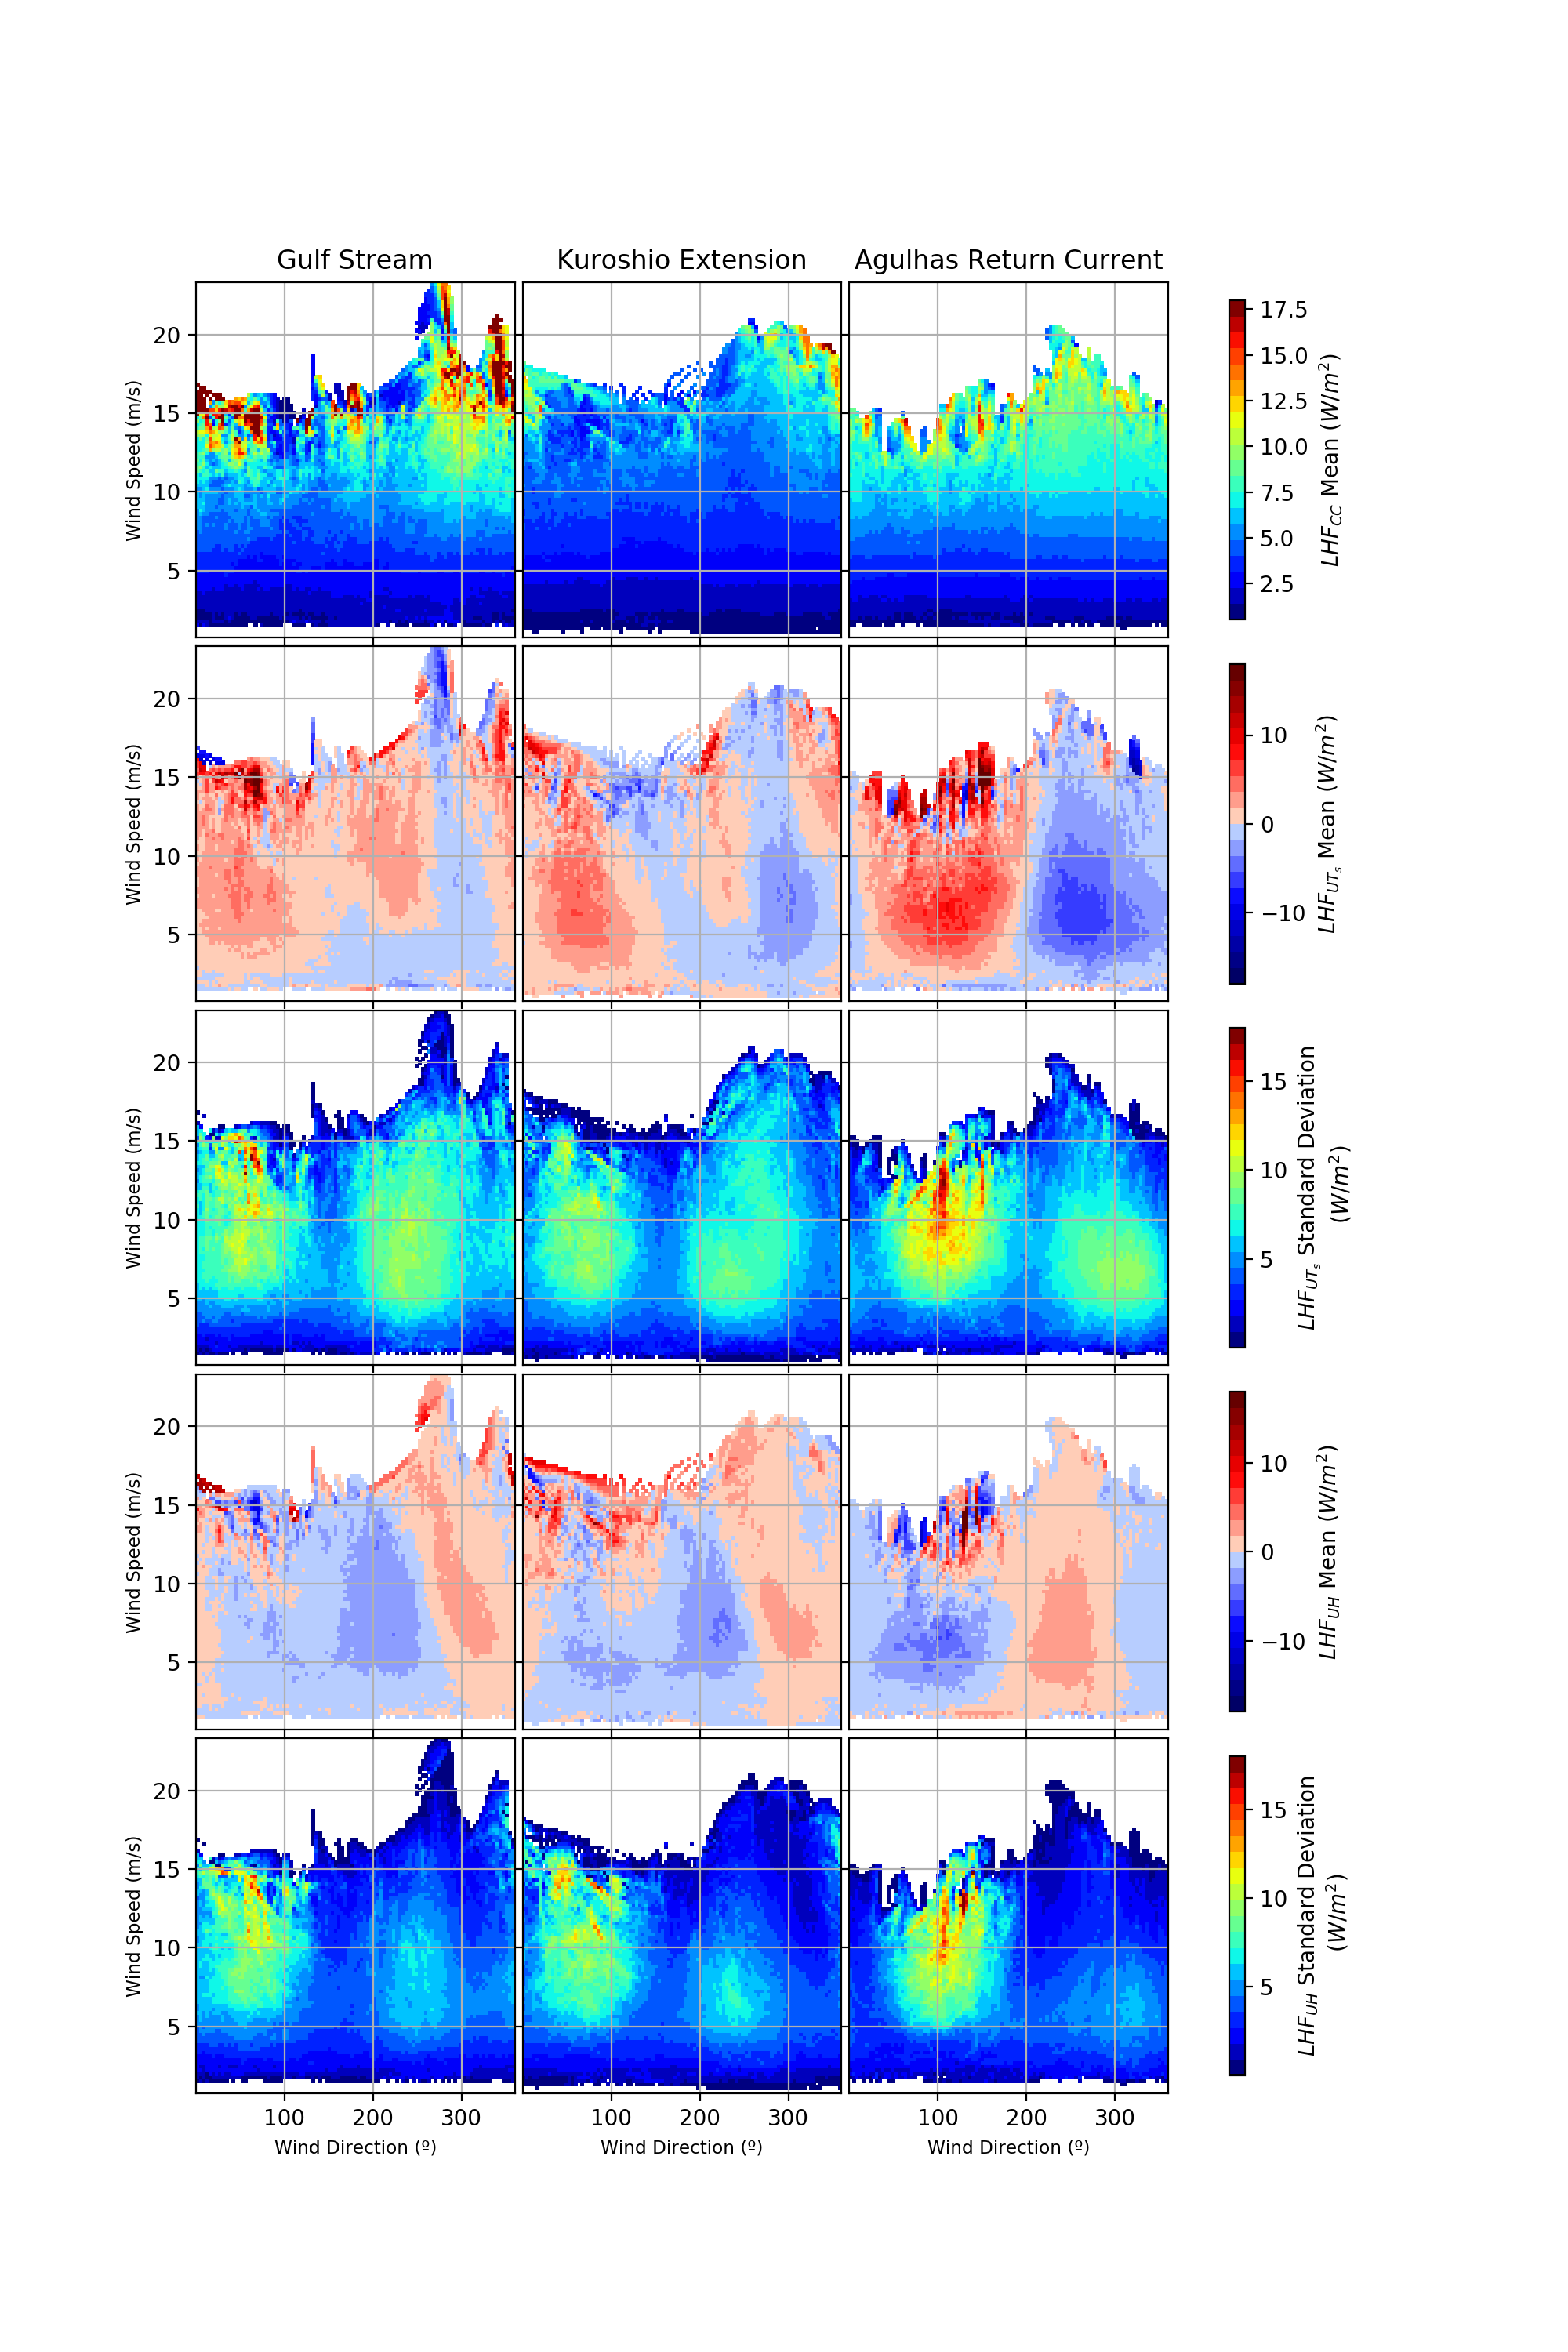

In [240]:
fig, axs = plt.subplots(5,3,figsize=(10,15))
fig.subplots_adjust(wspace=.025,hspace=0.025)

ax = axs[0,0]
pc = ax.pcolormesh(h,r,hist_GS4,cmap=cm.get_cmap('jet', 20),vmax=18)
ax.set_ylabel("Wind Speed (m/s)",fontsize='small')
ax.set_title("Gulf Stream")
plt.setp(ax.get_xticklabels(), visible=False)
ax.grid()

ax = axs[0,1]
pc = ax.pcolormesh(h,r,hist_K4,cmap=cm.get_cmap('jet', 20),vmax=18)
ax.set_title("Kuroshio Extension")
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

ax = axs[0,2]
pc = ax.pcolormesh(h,r,hist_A4,cmap=cm.get_cmap('jet', 20),vmax=18)
fig.colorbar(pc,ax=axs[0],label="$LHF_{CC}$ Mean ($W/m^2$)",shrink=.9)
ax.set_title("Agulhas Return Current")
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

######

ax = axs[1,0]
pc = ax.pcolormesh(h,r,hist_GS5,cmap=cm.get_cmap('BlueRed3', 20),vmin=-18,vmax=18)
ax.set_ylabel("Wind Speed (m/s)",fontsize='small')
plt.setp(ax.get_xticklabels(), visible=False)
ax.grid()

ax = axs[1,1]
pc = ax.pcolormesh(h,r,hist_K5,cmap=cm.get_cmap('BlueRed3', 20),vmin=-18,vmax=18)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

ax = axs[1,2]
pc = ax.pcolormesh(h,r,hist_A5,cmap=cm.get_cmap('BlueRed3', 20),vmin=-18,vmax=18) #good
fig.colorbar(pc,ax=axs[1],label="$LHF_{UT_s}$ Mean ($W/m^2$)",shrink=.9)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

######

ax = axs[2,0]
pc = ax.pcolormesh(h,r,hist_GS5std,cmap=cm.get_cmap('jet', 20),vmax=18)
ax.set_ylabel("Wind Speed (m/s)",fontsize='small')
plt.setp(ax.get_xticklabels(), visible=False)
ax.grid()

ax = axs[2,1]
pc = ax.pcolormesh(h,r,hist_K5std,cmap=cm.get_cmap('jet', 20),vmax=18)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

ax = axs[2,2]
pc = ax.pcolormesh(h,r,hist_A5std,cmap=cm.get_cmap('jet', 20),vmax=18)
fig.colorbar(pc,ax=axs[2],label="$LHF_{UT_s}$ Standard Deviation\n ($W/m^2$)",shrink=.9)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

#####

ax = axs[3,0]
pc = ax.pcolormesh(h,r,hist_GS6,cmap=cm.get_cmap('BlueRed3', 20),vmin=-18,vmax=18)
ax.set_ylabel("Wind Speed (m/s)",fontsize='small')
plt.setp(ax.get_xticklabels(), visible=False)
ax.grid()

ax = axs[3,1]
pc = ax.pcolormesh(h,r,hist_K6,cmap=cm.get_cmap('BlueRed3', 20),vmin=-18,vmax=18)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

ax = axs[3,2]
pc = ax.pcolormesh(h,r,hist_A6,cmap=cm.get_cmap('BlueRed3', 20),vmin=-18,vmax=18)
fig.colorbar(pc,ax=axs[3],label="$LHF_{UH}$ Mean ($W/m^2$)",shrink=.9)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

######

ax = axs[4,0]
pc = ax.pcolormesh(h,r,hist_GS6std,cmap=cm.get_cmap('jet',20),vmax=18)
ax.set_xlabel("Wind Direction (º)",fontsize='small')
ax.set_ylabel("Wind Speed (m/s)",fontsize='small')
ax.grid()

ax = axs[4,1]
pc = ax.pcolormesh(h,r,hist_K6std,cmap=cm.get_cmap('jet', 20),vmax=18)
ax.set_xlabel("Wind Direction (º)",fontsize='small')
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

ax = axs[4,2]
pc = ax.pcolormesh(h,r,hist_A6std,cmap=cm.get_cmap('jet',20),vmax=18)
fig.colorbar(pc,ax=axs[4],label="$LHF_{UH}$ Standard Deviation\n ($W/m^2$)",shrink=.9)
ax.set_xlabel("Wind Direction (º)",fontsize='small')
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()



In [241]:
plt.savefig('PAPER_windpdf_dirfrom.png', dpi=300, bbox_inches='tight')


In [130]:
r, h, hist_GS4, hist_K4, hist_A4 = makehistavg3x(sphsm_GS,sphsm_K,sphsm_A,sstsm_GS,sstsm_K,sstsm_A,Q4_GS,Q4_K,Q4_A,100,100)
r, h, hist_GS5, hist_K5, hist_A5 = makehistavg3x(sphsm_GS,sphsm_K,sphsm_A,sstsm_GS,sstsm_K,sstsm_A,Q5_GS,Q5_K,Q5_A,100,100)
r, h, hist_GS6, hist_K6, hist_A6 = makehistavg3x(sphsm_GS,sphsm_K,sphsm_A,sstsm_GS,sstsm_K,sstsm_A,Q6_GS,Q6_K,Q6_A,100,100)

hist_GS4[np.where(hist_GS4 == 0.0)] = None
hist_K4[np.where(hist_K4 == 0.0)] = None
hist_A4[np.where(hist_A4 == 0.0)] = None

hist_GS5[np.where(hist_GS5 == 0.0)] = None
hist_K5[np.where(hist_K5 == 0.0)] = None
hist_A5[np.where(hist_A5 == 0.0)] = None

hist_GS6[np.where(hist_GS6 == 0.0)] = None
hist_K6[np.where(hist_K6 == 0.0)] = None
hist_A6[np.where(hist_A6 == 0.0)] = None


r, h, hist_GS5std, hist_K5std, hist_A5std = makehiststd3x(sphsm_GS,sphsm_K,sphsm_A,sstsm_GS,sstsm_K,sstsm_A,Q5_GS,Q5_K,Q5_A,100,100)
r, h, hist_GS6std, hist_K6std, hist_A6std = makehiststd3x(sphsm_GS,sphsm_K,sphsm_A,sstsm_GS,sstsm_K,sstsm_A,Q6_GS,Q6_K,Q6_A,100,100)

hist_GS5std[np.where(hist_GS5std == 0.0)] = None
hist_K5std[np.where(hist_K5std == 0.0)] = None
hist_A5std[np.where(hist_A5std == 0.0)] = None

hist_GS6std[np.where(hist_GS6std == 0.0)] = None
hist_K6std[np.where(hist_K6std == 0.0)] = None
hist_A6std[np.where(hist_A6std == 0.0)] = None



/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: Mean of empty slice


<IPython.core.display.Javascript object>


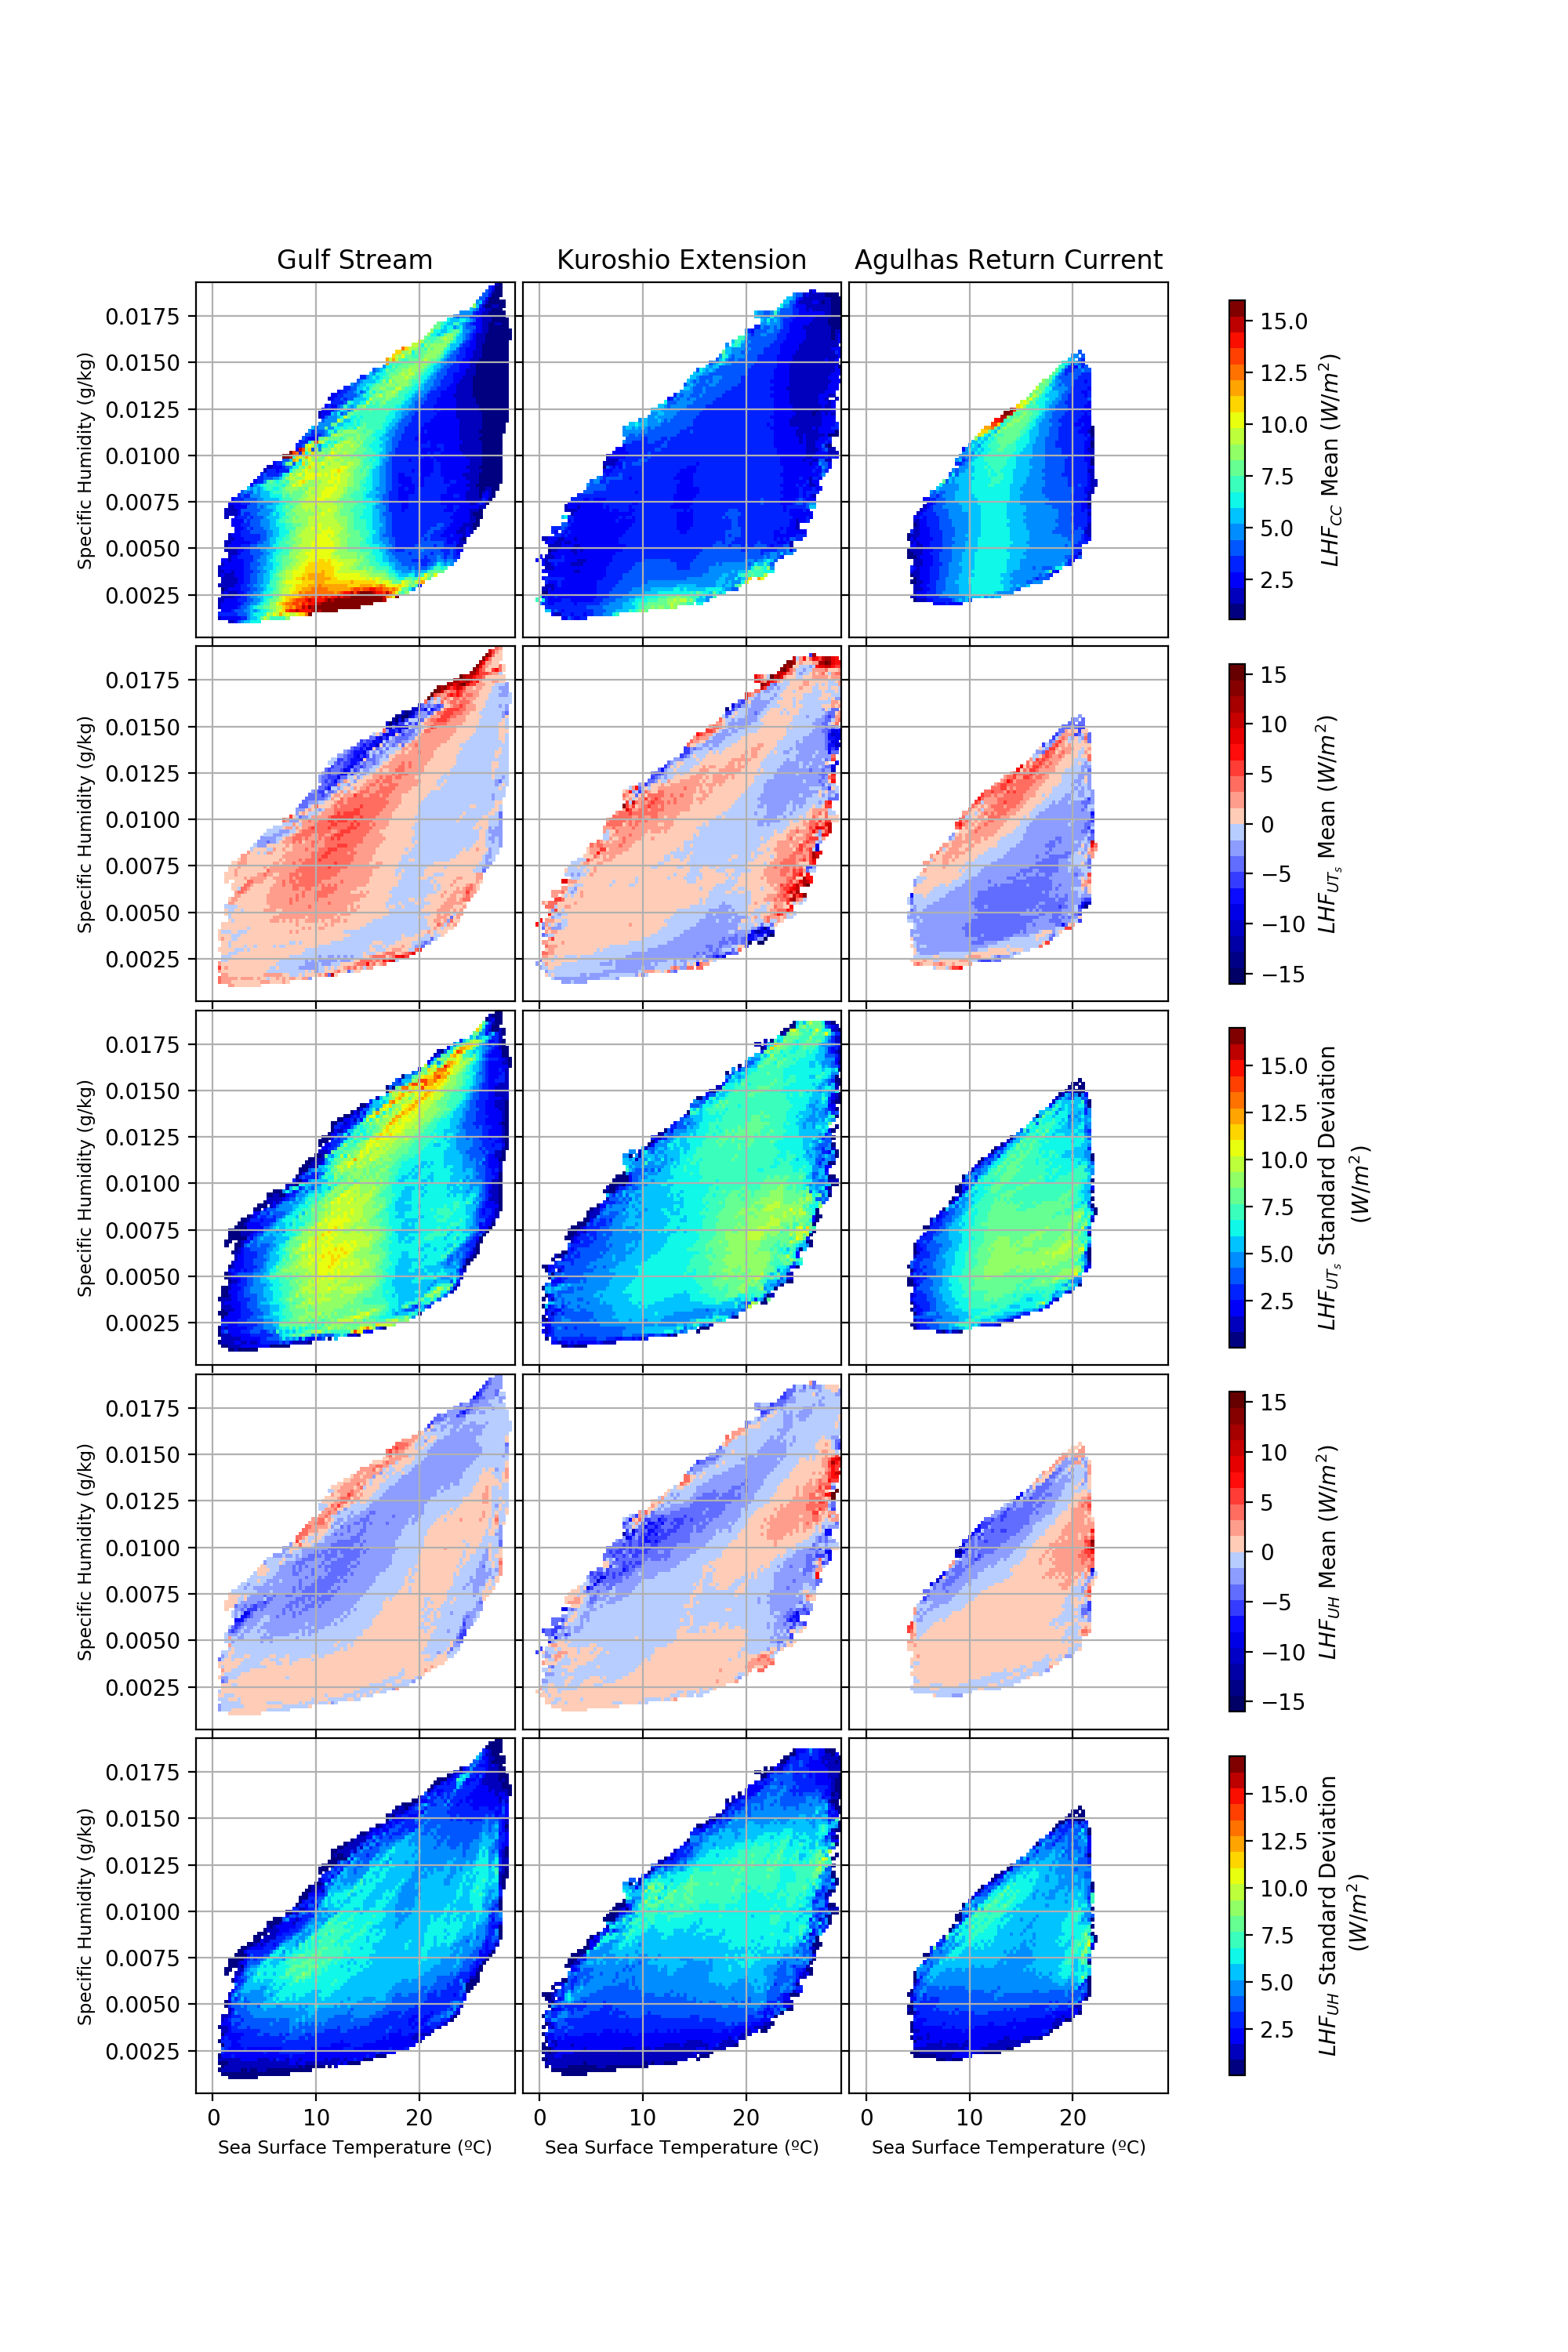

In [135]:
fig, axs = plt.subplots(5,3,figsize=(10,15))
fig.subplots_adjust(wspace=.025,hspace=0.025)

ax = axs[0,0]
pc = ax.pcolormesh(h,r,hist_GS4,cmap=cm.get_cmap('jet', 20),vmax=16)
ax.set_ylabel("Specific Humidity (g/kg)",fontsize='small')
ax.set_title("Gulf Stream")
plt.setp(ax.get_xticklabels(), visible=False)
ax.grid()

ax = axs[0,1]
pc = ax.pcolormesh(h,r,hist_K4,cmap=cm.get_cmap('jet', 20),vmax=16)
ax.set_title("Kuroshio Extension")
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

ax = axs[0,2]
pc = ax.pcolormesh(h,r,hist_A4,cmap=cm.get_cmap('jet', 20),vmax=16)
fig.colorbar(pc,ax=axs[0],label="$LHF_{CC}$ Mean ($W/m^2$)",shrink=.9)
ax.set_title("Agulhas Return Current")
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

######

ax = axs[1,0]
pc = ax.pcolormesh(h,r,hist_GS5,cmap=cm.get_cmap('BlueRed3', 20),vmin=-16,vmax=16)
ax.set_ylabel("Specific Humidity (g/kg)",fontsize='small')
plt.setp(ax.get_xticklabels(), visible=False)
ax.grid()

ax = axs[1,1]
pc = ax.pcolormesh(h,r,hist_K5,cmap=cm.get_cmap('BlueRed3', 20),vmin=-16,vmax=16)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

ax = axs[1,2]
pc = ax.pcolormesh(h,r,hist_A5,cmap=cm.get_cmap('BlueRed3', 20),vmin=-16,vmax=16) #good
fig.colorbar(pc,ax=axs[1],label="$LHF_{UT_s}$ Mean ($W/m^2$)",shrink=.9)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

######

ax = axs[2,0]
pc = ax.pcolormesh(h,r,hist_GS5std,cmap=cm.get_cmap('jet', 20),vmax=17)
ax.set_ylabel("Specific Humidity (g/kg)",fontsize='small')
plt.setp(ax.get_xticklabels(), visible=False)
ax.grid()

ax = axs[2,1]
pc = ax.pcolormesh(h,r,hist_K5std,cmap=cm.get_cmap('jet', 20),vmax=17)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

ax = axs[2,2]
pc = ax.pcolormesh(h,r,hist_A5std,cmap=cm.get_cmap('jet', 20),vmax=17)
fig.colorbar(pc,ax=axs[2],label="$LHF_{UT_s}$ Standard Deviation\n ($W/m^2$)",shrink=.9)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

#####

ax = axs[3,0]
pc = ax.pcolormesh(h,r,hist_GS6,cmap=cm.get_cmap('BlueRed3', 20),vmin=-16,vmax=16)
ax.set_ylabel("Specific Humidity (g/kg)",fontsize='small')
plt.setp(ax.get_xticklabels(), visible=False)
ax.grid()

ax = axs[3,1]
pc = ax.pcolormesh(h,r,hist_K6,cmap=cm.get_cmap('BlueRed3', 20),vmin=-16,vmax=16)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

ax = axs[3,2]
pc = ax.pcolormesh(h,r,hist_A6,cmap=cm.get_cmap('BlueRed3', 20),vmin=-16,vmax=16)
fig.colorbar(pc,ax=axs[3],label="$LHF_{UH}$ Mean ($W/m^2$)",shrink=.9)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

######

ax = axs[4,0]
pc = ax.pcolormesh(h,r,hist_GS6std,cmap=cm.get_cmap('jet',20),vmax=17)
ax.set_xlabel("Sea Surface Temperature (ºC)",fontsize='small')
ax.set_ylabel("Specific Humidity (g/kg)",fontsize='small')
ax.grid()

ax = axs[4,1]
pc = ax.pcolormesh(h,r,hist_K6std,cmap=cm.get_cmap('jet', 20),vmax=17)
ax.set_xlabel("Sea Surface Temperature (ºC)",fontsize='small')
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

ax = axs[4,2]
pc = ax.pcolormesh(h,r,hist_A6std,cmap=cm.get_cmap('jet',20),vmax=17)
fig.colorbar(pc,ax=axs[4],label="$LHF_{UH}$ Standard Deviation\n ($W/m^2$)",shrink=.9)
ax.set_xlabel("Sea Surface Temperature (ºC)",fontsize='small')
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()



In [136]:
plt.savefig('PAPER_sstsphpdf.png', dpi=300, bbox_inches='tight')

In [313]:
r, h, hist_GS4, hist_K4, hist_A4 = makehistavg3x(sphsm_GS/qssm_GS,sphsm_K/qssm_K,sphsm_A/qssm_A,sstsm_GS,sstsm_K,sstsm_A,Q4_GS,Q4_K,Q4_A,100,100)
r, h, hist_GS5, hist_K5, hist_A5 = makehistavg3x(sphsm_GS/qssm_GS,sphsm_K/qssm_K,sphsm_A/qssm_A,sstsm_GS,sstsm_K,sstsm_A,Q5_GS,Q5_K,Q5_A,100,100)
r, h, hist_GS6, hist_K6, hist_A6 = makehistavg3x(sphsm_GS/qssm_GS,sphsm_K/qssm_K,sphsm_A/qssm_A,sstsm_GS,sstsm_K,sstsm_A,Q6_GS,Q6_K,Q6_A,100,100)

hist_GS4[np.where(hist_GS4 == 0.0)] = None
hist_K4[np.where(hist_K4 == 0.0)] = None
hist_A4[np.where(hist_A4 == 0.0)] = None

hist_GS5[np.where(hist_GS5 == 0.0)] = None
hist_K5[np.where(hist_K5 == 0.0)] = None
hist_A5[np.where(hist_A5 == 0.0)] = None

hist_GS6[np.where(hist_GS6 == 0.0)] = None
hist_K6[np.where(hist_K6 == 0.0)] = None
hist_A6[np.where(hist_A6 == 0.0)] = None


r, h, hist_GS5std, hist_K5std, hist_A5std = makehiststd3x(sphsm_GS/qssm_GS,sphsm_K/qssm_K,sphsm_A/qssm_A,sstsm_GS,sstsm_K,sstsm_A,Q5_GS,Q5_K,Q5_A,100,100)
r, h, hist_GS6std, hist_K6std, hist_A6std = makehiststd3x(sphsm_GS/qssm_GS,sphsm_K/qssm_K,sphsm_A/qssm_A,sstsm_GS,sstsm_K,sstsm_A,Q6_GS,Q6_K,Q6_A,100,100)

hist_GS5std[np.where(hist_GS5std == 0.0)] = None
hist_K5std[np.where(hist_K5std == 0.0)] = None
hist_A5std[np.where(hist_A5std == 0.0)] = None

hist_GS6std[np.where(hist_GS6std == 0.0)] = None
hist_K6std[np.where(hist_K6std == 0.0)] = None
hist_A6std[np.where(hist_A6std == 0.0)] = None


/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: Mean of empty slice


<IPython.core.display.Javascript object>


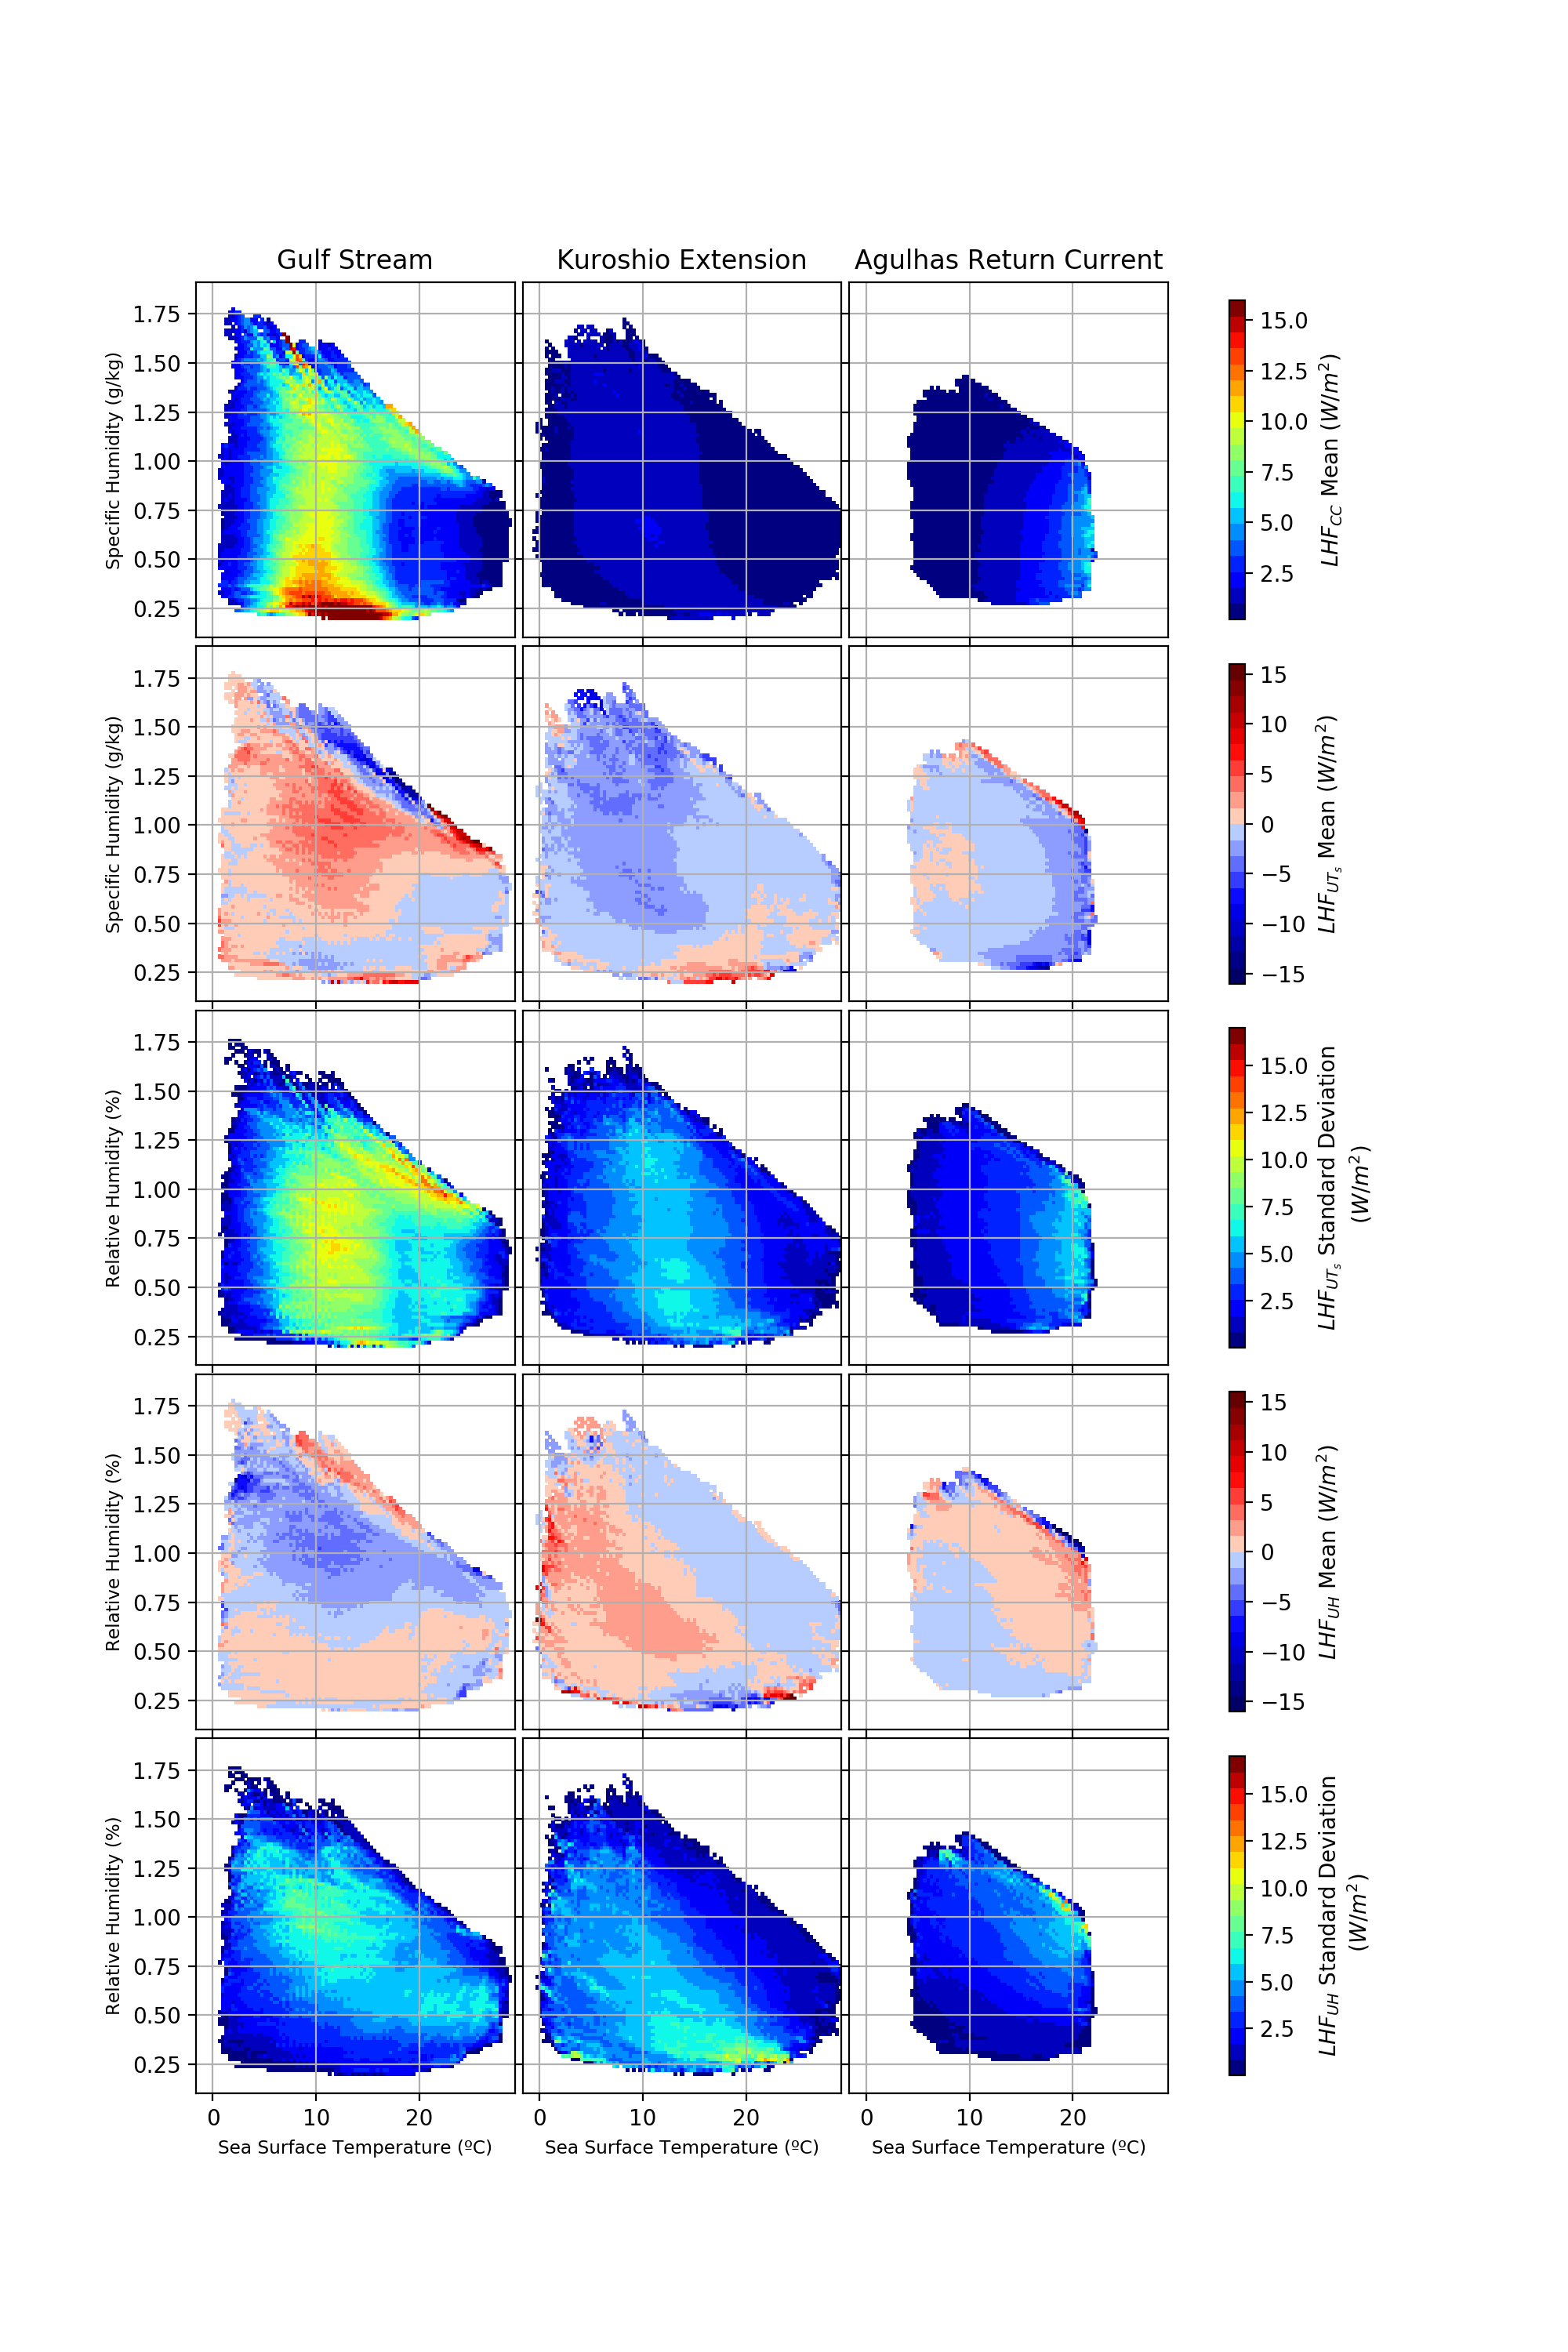

In [314]:
fig, axs = plt.subplots(5,3,figsize=(10,15))
fig.subplots_adjust(wspace=.025,hspace=0.025)

ax = axs[0,0]
pc = ax.pcolormesh(h,r,hist_GS4,cmap=cm.get_cmap('jet', 20),vmax=16)
ax.set_ylabel("Specific Humidity (g/kg)",fontsize='small')
ax.set_title("Gulf Stream")
plt.setp(ax.get_xticklabels(), visible=False)
ax.grid()

ax = axs[0,1]
pc = ax.pcolormesh(h,r,hist_K4,cmap=cm.get_cmap('jet', 20),vmax=16)
ax.set_title("Kuroshio Extension")
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

ax = axs[0,2]
pc = ax.pcolormesh(h,r,hist_A4,cmap=cm.get_cmap('jet', 20),vmax=16)
fig.colorbar(pc,ax=axs[0],label="$LHF_{CC}$ Mean ($W/m^2$)",shrink=.9)
ax.set_title("Agulhas Return Current")
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

######

ax = axs[1,0]
pc = ax.pcolormesh(h,r,hist_GS5,cmap=cm.get_cmap('BlueRed3', 20),vmin=-16,vmax=16)
ax.set_ylabel("Specific Humidity (g/kg)",fontsize='small')
plt.setp(ax.get_xticklabels(), visible=False)
ax.grid()

ax = axs[1,1]
pc = ax.pcolormesh(h,r,hist_K5,cmap=cm.get_cmap('BlueRed3', 20),vmin=-16,vmax=16)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

ax = axs[1,2]
pc = ax.pcolormesh(h,r,hist_A5,cmap=cm.get_cmap('BlueRed3', 20),vmin=-16,vmax=16) #good
fig.colorbar(pc,ax=axs[1],label="$LHF_{UT_s}$ Mean ($W/m^2$)",shrink=.9)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

######

ax = axs[2,0]
pc = ax.pcolormesh(h,r,hist_GS5std,cmap=cm.get_cmap('jet', 20),vmax=17)
ax.set_ylabel("Relative Humidity (%)",fontsize='small')
plt.setp(ax.get_xticklabels(), visible=False)
ax.grid()

ax = axs[2,1]
pc = ax.pcolormesh(h,r,hist_K5std,cmap=cm.get_cmap('jet', 20),vmax=17)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

ax = axs[2,2]
pc = ax.pcolormesh(h,r,hist_A5std,cmap=cm.get_cmap('jet', 20),vmax=17)
fig.colorbar(pc,ax=axs[2],label="$LHF_{UT_s}$ Standard Deviation\n ($W/m^2$)",shrink=.9)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

#####

ax = axs[3,0]
pc = ax.pcolormesh(h,r,hist_GS6,cmap=cm.get_cmap('BlueRed3', 20),vmin=-16,vmax=16)
ax.set_ylabel("Relative Humidity (%)",fontsize='small')
plt.setp(ax.get_xticklabels(), visible=False)
ax.grid()

ax = axs[3,1]
pc = ax.pcolormesh(h,r,hist_K6,cmap=cm.get_cmap('BlueRed3', 20),vmin=-16,vmax=16)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

ax = axs[3,2]
pc = ax.pcolormesh(h,r,hist_A6,cmap=cm.get_cmap('BlueRed3', 20),vmin=-16,vmax=16)
fig.colorbar(pc,ax=axs[3],label="$LHF_{UH}$ Mean ($W/m^2$)",shrink=.9)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

######

ax = axs[4,0]
pc = ax.pcolormesh(h,r,hist_GS6std,cmap=cm.get_cmap('jet',20),vmax=17)
ax.set_xlabel("Sea Surface Temperature (ºC)",fontsize='small')
ax.set_ylabel("Relative Humidity (%)",fontsize='small')
ax.grid()

ax = axs[4,1]
pc = ax.pcolormesh(h,r,hist_K6std,cmap=cm.get_cmap('jet', 20),vmax=17)
ax.set_xlabel("Sea Surface Temperature (ºC)",fontsize='small')
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

ax = axs[4,2]
pc = ax.pcolormesh(h,r,hist_A6std,cmap=cm.get_cmap('jet',20),vmax=17)
fig.colorbar(pc,ax=axs[4],label="$LHF_{UH}$ Standard Deviation\n ($W/m^2$)",shrink=.9)
ax.set_xlabel("Sea Surface Temperature (ºC)",fontsize='small')
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()



## Composites Spatially

In [ ]:
def spatial_composite(lat,lon,data,gt):
    '''
    we will count the values greater than gt 
    
    '''    
    comp = np.zeros([len(lat),len(lon)],dtype=float)

    i = 0
    j = 0
    for i in range(len(lat)): 
        for j in range(len(lon)):
            comp[i,j] = np.count_nonzero(data[:,i,j] > gt)
    return comp


In [ ]:
comp = spatial_composite(lat_GS,lon_GS,UT_GS,0)

In [ ]:
fig, ax = plt.subplots()

pc = ax.pcolormesh(lon_GS,lat_GS,comp)
fig.colorbar(pc,ax=ax,label='Counts')
ax.grid()

In [ ]:
fig, ax = plt.subplots()

pc = ax.pcolormesh(lon_GS,lat_GS,np.nanmean(Q5_GS,axis=0))
fig.colorbar(pc,ax=ax,label='Q5')
ax.grid()

In [ ]:
plt.savefig('qcc&qut_space_alltime_GS.png', dpi=300, bbox_inches='tight')


## Compare ERA5 LHF and my LHF

In [ ]:
f = nc4.Dataset('/Users/baileydonaldson/python/plot_heat_flux/GulfStreamN29Qa.nc','r')
grp = f.groups['Regional_data']
lon_GS = grp.variables['Longitude'][:]
lat_GS = grp.variables['Latitude'][:]
Q_GS = grp.variables['Latent Heat Flux Observational (Q)'][:,:,:]
Q1_GS = grp.variables['Latent Heat Flux Large Scale (Q1)'][:,:,:]
Q4_GS = grp.variables['Clausius Clapeyron (Q4)'][:,:,:][:,:,:]
Q5_GS = grp.variables['Covariability of SST and U (Q5)'][:,:,:]
Q6_GS = grp.variables['Covariability of U and SPH (Q6)'][:,:,:]
f.close()

f = nc4.Dataset('/Users/baileydonaldson/python/plot_heat_flux/AgulhasN29Qa.nc','r')
grp = f.groups['Regional_data']
lon_A = grp.variables['Longitude'][25:213]
lat_A = grp.variables['Latitude'][26:50]
Q_A = grp.variables['Latent Heat Flux Observational (Q)'][:,26:50,25:213]
Q1_A = grp.variables['Latent Heat Flux Large Scale (Q1)'][:,26:50,25:213]
Q4_A = grp.variables['Clausius Clapeyron (Q4)'][:,26:50,25:213]
Q5_A = grp.variables['Covariability of SST and U (Q5)'][:,26:50,25:213]
Q6_A = grp.variables['Covariability of U and SPH (Q6)'][:,26:50,25:213]
f.close()

f = nc4.Dataset('/Users/baileydonaldson/python/plot_heat_flux/KuroshioN29Qa.nc','r')
grp = f.groups['Regional_data']
lon_K = grp.variables['Longitude'][43:180]
lat_K = grp.variables['Latitude'][47:79]
time = grp.variables['Time'][:]
Q_K = grp.variables['Latent Heat Flux Observational (Q)'][:,47:79,43:180]
Q1_K = grp.variables['Latent Heat Flux Large Scale (Q1)'][:,47:79,43:180]
Q4_K = grp.variables['Clausius Clapeyron (Q4)'][:,47:79,43:180]
Q5_K = grp.variables['Covariability of SST and U (Q5)'][:,47:79,43:180]
Q6_K = grp.variables['Covariability of U and SPH (Q6)'][:,47:79,43:180]
f.close()


In [ ]:
f = nc4.Dataset('/Users/baileydonaldson/python/ERA5/ERA5LHF_GS.nc')
grp = f.groups['Regional_data']
lhf_GS = grp.variables['Latent Heat Flux Smooth'][:,:,:]
#lhf_GS = grp.variables['Latent Heat Flux'][:,:,:]
lon_GS2 = grp.variables['Longitude'][:]
lat_GS2 = grp.variables['Latitude'][:]
time = grp.variables['Time'][:]
f.close()

f = nc4.Dataset('/Users/baileydonaldson/python/ERA5/ERA5LHF_A.nc')
grp = f.groups['Regional_data']
lhf_A = grp.variables['Latent Heat Flux Smooth'][:,26:50,25:213]
#lhf_A = grp.variables['Latent Heat Flux'][:,26:50,25:213]
lon_A2 = grp.variables['Longitude'][25:213]
lat_A2 = grp.variables['Latitude'][26:50]
f.close()

f = nc4.Dataset('/Users/baileydonaldson/python/ERA5/ERA5LHF_K.nc')
grp = f.groups['Regional_data']
lhf_K = grp.variables['Latent Heat Flux Smooth'][:,47:79,43:180]
#lhf_K = grp.variables['Latent Heat Flux'][:,47:79,43:180]
lon_K2 = grp.variables['Longitude'][43:180]
lat_K2 = grp.variables['Latitude'][47:79]
f.close()


In [ ]:
lhf_GS[np.where(np.isnan(Q_GS) == True)]= None
lhf_K[np.where(np.isnan(Q_K) == True)]= None
lhf_A[np.where(np.isnan(Q_A) == True)]= None


In [ ]:
Q4Q5 = np.add(Q4_A,Q5_A)
Q4Q5Q6 = np.add(Q4Q5,Q6_A)
Q4Q5Q6Q1 = np.add(Q4Q5Q6,Q1_A)
epsilon_A = np.subtract(Q_A,Q4Q5Q6Q1)
epsilon_A5 = np.subtract(lhf_A,Q4Q5Q6Q1)

Q4Q5 = np.add(Q4_K,Q5_K)
Q4Q5Q6 = np.add(Q4Q5,Q6_K)
Q4Q5Q6Q1 = np.add(Q4Q5Q6,Q1_K)
epsilon_K = np.subtract(Q_K,Q4Q5Q6Q1)
epsilon_K5 = np.subtract(lhf_K,Q4Q5Q6Q1)

Q4Q5 = np.add(Q4_GS,Q5_GS)
Q4Q5Q6 = np.add(Q4Q5,Q6_GS)
Q4Q5Q6Q1 = np.add(Q4Q5Q6,Q1_GS)
epsilon_GS = np.subtract(Q_GS,Q4Q5Q6Q1)
epsilon_GS5 = np.subtract(lhf_GS,Q4Q5Q6Q1)


In [ ]:
print(np.nanmean(lhf_GS-Q_GS))
print(np.nanmean(lhf_K-Q_K))
print(np.nanmean(lhf_A-Q_A))

print(np.nanmean(epsilon_GS5))
print(np.nanpercentile(epsilon_GS5,95))
print(np.nanpercentile(epsilon_GS5,5))

print(np.nanmean(epsilon_K5))
print(np.nanpercentile(epsilon_K5,95))
print(np.nanpercentile(epsilon_K5,5))

print(np.nanmean(epsilon_A5))
print(np.nanpercentile(epsilon_A5,95))
print(np.nanpercentile(epsilon_A5,5))


In [ ]:
fig, axs = plt.subplots(nrows=2)
fig.subplots_adjust(hspace=.55)

i = np.arange(0, len(time)+1, 183)
temp = np.array(t_str)
temp = temp[i]
yyyymm_str = ['2003/1','2003/7','2004/1','2004/7','2005/1','2005/7','2006/1','2006/7','2007/1','2007/7','2008/1','2008/7']

ax = axs[0]
ax.plot(t_str,np.nanmean(Q_GS,axis=(1,2)),label='Calculated LHF',linewidth=1.5)
ax.plot(t_str,np.nanmean(lhf_GS,axis=(1,2)),label='ERA5 LHF',alpha=0.65,linewidth=1.5)
ax.legend(loc='upper right', fontsize='x-small')#,ncol=1,bbox_to_anchor=(1.009, 1.55))
ax.set_title('Large Scale LHF in Gulf Stream',fontsize='medium')
ax.set_ylabel('$W/m^2$',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
ax.grid()

ax = axs[1]
ax.plot(t_str,np.nanmean(epsilon_GS,axis=(1,2)),label='Calculated LHF',zorder=2,linewidth=1.5)
ax.plot(t_str,np.nanmean(epsilon_GS5,axis=(1,2)),label='ERA5 LHF',alpha=0.65,zorder=1,linewidth=1.5)
ax.legend(loc='upper right', fontsize='x-small')#,ncol=1,bbox_to_anchor=(1.009, 1.55))
ax.set_title('$\epsilon$ in Gulf Stream',fontsize='medium')
ax.set_ylabel('$W/m^2$',fontsize='small')
ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
ax.grid()


In [ ]:
plt.savefig('q0&epsilon_compare_era_GS.png', dpi=300, bbox_inches='tight')


In [ ]:
fig, ax = plt.subplots()
fig.subplots_adjust()

pc = ax.pcolormesh(lon_GS2,lat_GS2,np.nanmean(lhf_GS - Q_GS,axis=0))
fig.colorbar(pc,ax=ax,label="($W/m^2$)")
ax.set_xlabel("Lon")
ax.set_ylabel("Lat")
ax.set_title("ERA5 - My LHF 2003-2008")
ax.grid()


In [ ]:
fig, ax = plt.subplots()
fig.subplots_adjust()

pc = ax.pcolormesh(lon_GS,lat_GS,Q_GS[0,:,:])
fig.colorbar(pc,ax=ax,label="($W/m^2$)")
ax.set_xlabel("Lon")
ax.set_ylabel("Lat")
ax.set_title("my LHF 1/1/2003")
ax.grid()

In [ ]:
#mean LHF
f = nc4.Dataset('/Users/baileydonaldson/python/ERA5/ERA5MEANLHF_GS.nc')
grp = f.groups['Regional_data']
mlhf_GS = grp.variables['Mean Latent Heat Flux Smooth'][:,:,:]
#mlhf_GS = grp.variables['Mean Latent Heat Flux Short'][:,:,:]
lon_GS = grp.variables['Longitude'][:]
lat_GS = grp.variables['Latitude'][:]
time = grp.variables['Time'][:]
f.close()

mlhf_GS[np.where(np.isnan(Q_GS[0:365,:,:]) == True)]= None

#f = nc4.Dataset('/Users/baileydonaldson/python/ERA5/ERA5MEANLHF_A.nc')
#grp = f.groups['Regional_data']
#mlhf_A = grp.variables['Mean Latent Heat Flux Smooth'][:,26:50,25:213]
#mlhf_A = grp.variables['Mean Latent Heat Flux Short'][:,26:50,25:213]
#lon_A = grp.variables['Longitude'][25:213]
#lat_A = grp.variables['Latitude'][26:50]
#f.close()

#f = nc4.Dataset('/Users/baileydonaldson/python/ERA5/ERA5MEANLHF_K.nc')
#grp = f.groups['Regional_data']
#mlhf_K = grp.variables['Mean Latent Heat Flux Smooth'][:,47:79,43:180]
#mlhf_K = grp.variables['Mean Latent Heat Flux Short'][:,47:79,43:180]
#lon_K = grp.variables['Longitude'][43:180]
#lat_K = grp.variables['Latitude'][47:79]
#f.close(

In [ ]:
fig, ax = plt.subplots()
fig.subplots_adjust(hspace=0.7)

i = [0,31,59,90,120,151,181,212,243,273,304,334]
yyyymm_str = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']


ax.plot(time[0:365],np.nanmean(lhf_GS[0:365,:,:],axis=(1,2)),label='ERA5 LHF')
ax.plot(time[0:365],np.nanmean(-mlhf_GS[0:365,:,:],axis=(1,2)),label='ERA5 Mean LHF')
ax.set_title('LHF in Gulf Stream 2003')
ax.set_ylabel('W/m^2',fontsize='small')
ax.legend(loc='upper right', fontsize='x-small', ncol=2,bbox_to_anchor=(1.01, 1.32))
ax.legend(bbox_to_anchor=(1.008, 1.0),fontsize='x-small', loc='upper right', ncol=3)
ax.set_xticks(time[i])
ax.set_xticklabels(yyyymm_str, rotation=20,fontsize='small')


In [ ]:
#data was taken evvery hour and I averaged the entire day for one month

f = nc4.Dataset('/Users/baileydonaldson/python/ERA5/ERA5MEANLHF_200301avg_GS.nc')
grp = f.groups['Regional_data']
mlhf_GS3 = grp.variables['Mean Latent Heat Flux Smooth'][:,:,:]
#mlhf_GS3 = grp.variables['Mean Latent Heat Flux Short'][:,:,:]
lon_GS3 = grp.variables['Longitude'][:]
lat_GS3 = grp.variables['Latitude'][:]
#time = grp.variables['Time'][:]
f.close()

mlhf_GS3[np.where(np.isnan(Q_GS[0:31,:,:]) == True)]= None



In [ ]:
# jan = np.arange(0,31,1)+1

fig, ax = plt.subplots()

ax.plot(jan,np.nanmean(lhf_GS[0:31,:,:],axis=(1,2)),label='ERA5 LHF')
ax.plot(jan,np.nanmean(-mlhf_GS[0:31,:,:],axis=(1,2)),label='ERA5 Mean LHF')
ax.plot(jan,np.nanmean(-mlhf_GS3,axis=(1,2)),linestyle='dashed',label='ERA5 Mean LHF Averaged')
ax.plot(jan,np.nanmean(Q_GS[0:31,:,:],axis=(1,2)),linestyle='dotted',label='my LHF')
ax.set_title('LHF in Gulf Stream 2003')
ax.set_ylabel('W/m^2',fontsize='small')
ax.legend(loc='upper right', fontsize='x-small', ncol=2,bbox_to_anchor=(1.01, 1.32))
ax.legend(bbox_to_anchor=(1.008, 1.0),fontsize='x-small', loc='upper right', ncol=3)
#ax.set_xticks(time[i])
#ax.set_xticklabels(yyyymm_str, rotation=20,fontsize='small')


## SST Std Dependence

In [32]:
r4, h4, hist_GS4, hist_K4, hist_A4 = makehistcount3x(Q4_GS,Q4_K,Q4_A,sststd_GS,sststd_K,sststd_A,100,100)
r5, h5, hist_GS5, hist_K5, hist_A5 = makehistcount3x(Q5_GS,Q5_K,Q5_A,sststd_GS,sststd_K,sststd_A,100,100)
r6, h6, hist_GS6, hist_K6, hist_A6 = makehistcount3x(Q6_GS,Q6_K,Q6_A,sststd_GS,sststd_K,sststd_A,100,100)

hist_GS4[np.where(hist_GS4 == 0.0)] = None
hist_GS5[np.where(hist_GS5 == 0.0)] = None
hist_GS6[np.where(hist_GS6 == 0.0)] = None

hist_K4[np.where(hist_K4 == 0.0)] = None
hist_K5[np.where(hist_K5 == 0.0)] = None
hist_K6[np.where(hist_K6 == 0.0)] = None

hist_A4[np.where(hist_A4 == 0.0)] = None
hist_A5[np.where(hist_A5 == 0.0)] = None
hist_A6[np.where(hist_A6 == 0.0)] = None


rmin [0.013017747, 0.075693116, 0.068120494]
rmax [45.64732, 21.011082, 23.688768]
hmin [0.17972891, 0.41508195, 0.6017114]
hmax [8.041697, 5.885225, 5.8283024]


/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater_equal
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in less
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater_equal
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


rmin [-45.5383, -34.042652, -42.896187]
rmax [59.79907, 37.317677, 42.833282]
hmin [0.17972891, 0.41508195, 0.6017114]
hmax [8.041697, 5.885225, 5.8283024]
rmin [-55.41568, -38.544716, -37.9866]
rmax [39.40009, 43.949585, 45.023933]
hmin [0.17972891, 0.41508195, 0.6017114]
hmax [8.041697, 5.885225, 5.8283024]


<IPython.core.display.Javascript object>


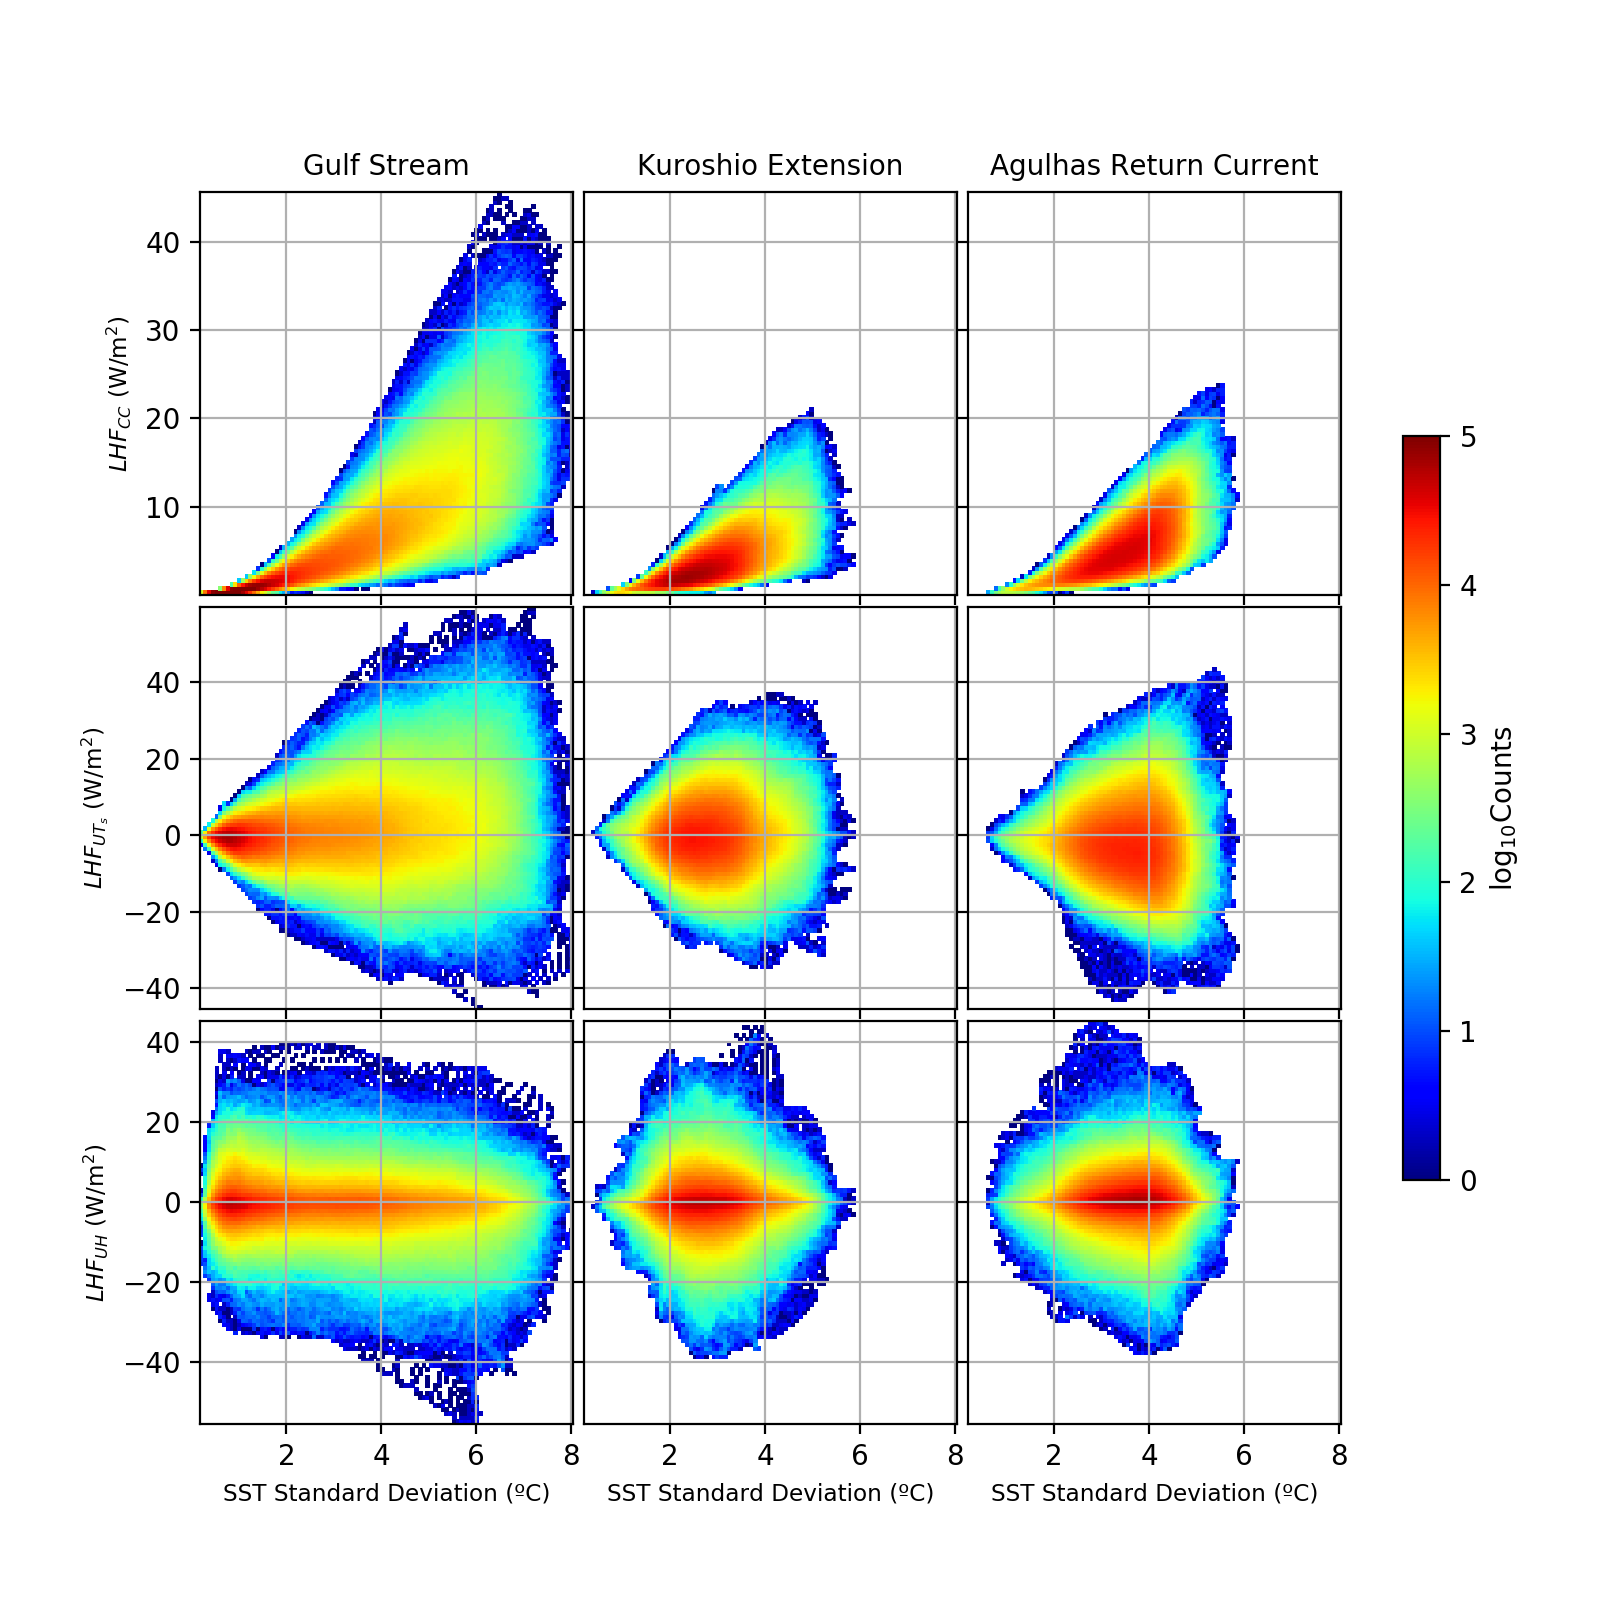

In [33]:
fig, axs = plt.subplots(3,3,figsize=(8,8))
fig.subplots_adjust(wspace=.03,hspace=0.03)

ax = axs[0,0]
pc = ax.pcolormesh(h4,r4,np.log10(hist_GS4),cmap=cm.get_cmap('jet'),vmax=5)
ax.set_title("Gulf Stream",fontsize='medium')
ax.set_ylabel("$LHF_{CC}$ (W/m$^2$)",fontsize='small')
plt.setp(ax.get_xticklabels(), visible=False)
ax.grid()

ax = axs[0,1]
pc = ax.pcolormesh(h4,r4,np.log10(hist_K4),cmap=cm.get_cmap('jet'),vmax=5)
ax.set_title("Kuroshio Extension",fontsize='medium')
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

ax = axs[0,2]
pc = ax.pcolormesh(h4,r4,np.log10(hist_A4),cmap=cm.get_cmap('jet'),vmax=5)
ax.set_title("Agulhas Return Current",fontsize='medium')
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

####

ax = axs[1,0]
pc = ax.pcolormesh(h5,r5,np.log10(hist_GS5),cmap=cm.get_cmap('jet'),vmax=5)
ax.set_ylabel("$LHF_{UT_s}$ (W/m$^2$)",fontsize='small')
plt.setp(ax.get_xticklabels(), visible=False)
ax.grid()

ax = axs[1,1]
pc = ax.pcolormesh(h5,r5,np.log10(hist_K5),cmap=cm.get_cmap('jet'),vmax=5)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

ax = axs[1,2]
pc = ax.pcolormesh(h5,r5,np.log10(hist_A5),cmap=cm.get_cmap('jet'),vmax=5)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

####

ax = axs[2,0]
pc = ax.pcolormesh(h6,r6,np.log10(hist_GS6),cmap=cm.get_cmap('jet'),vmax=5)
ax.set_xlabel("SST Standard Deviation (ºC)",fontsize='small')
ax.set_ylabel("$LHF_{UH}$ (W/m$^2$)",fontsize='small')
ax.grid()

ax = axs[2,1]
pc = ax.pcolormesh(h6,r6,np.log10(hist_K6),cmap=cm.get_cmap('jet'),vmax=5)
ax.set_xlabel("SST Standard Deviation (ºC)",fontsize='small')
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

ax = axs[2,2]
pc = ax.pcolormesh(h6,r6,np.log10(hist_A6),cmap=cm.get_cmap('jet'),vmax=5)
ax.set_xlabel("SST Standard Deviation (ºC)",fontsize='small')
fig.colorbar(pc,ax=axs,label="log$_{10}$Counts",fraction=0.03)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()




In [34]:
plt.savefig('PAPER_sststd_pdf.png', dpi=300, bbox_inches='tight')

In [252]:
print(lon_GS[0]-360,lon_GS[-1]-360)
print(lat_GS[0],lat_GS[-1])


-71.0 -36.25
36.0 47.75


In [248]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

m = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=-180,urcrnrlon=180,resolution='c')

<IPython.core.display.Javascript object>


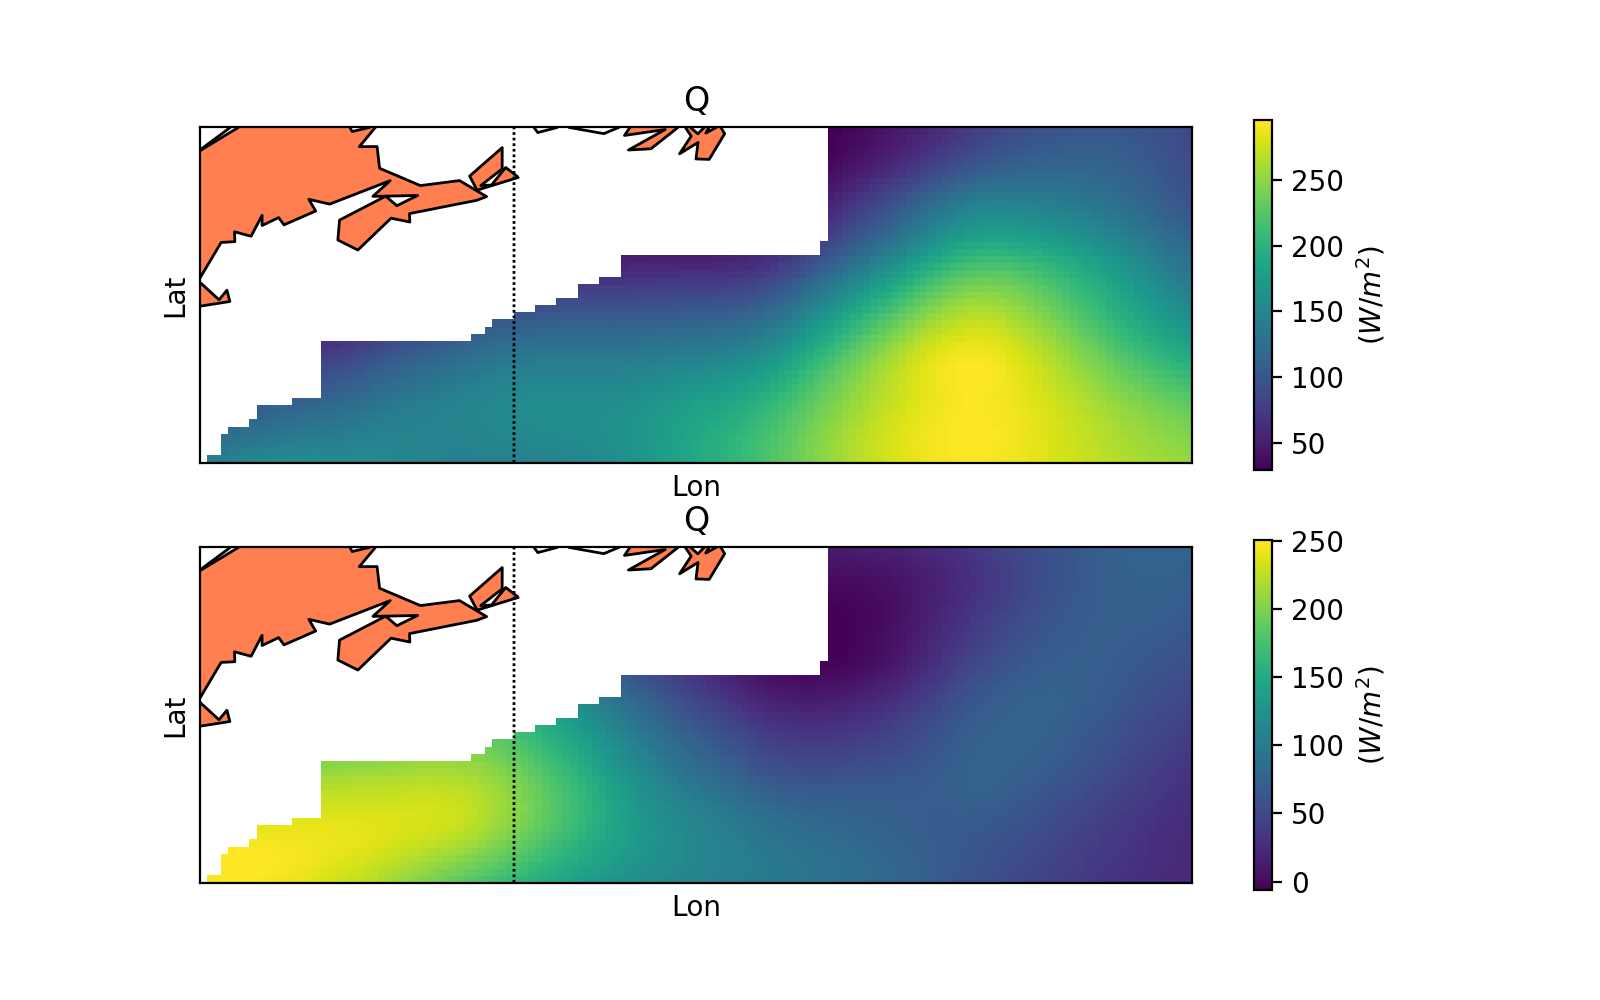

In [291]:
fig, axs = plt.subplots(nrows=2,figsize=(8,5))

m = Basemap(projection='cyl',llcrnrlat=36,urcrnrlat=47.75,llcrnrlon=-71,urcrnrlon=-36.25,resolution='c')

#m = Basemap(llcrnrlat=36,urcrnrlat=47.75,llcrnrlon=-71,urcrnrlon=-36.25)
ax=axs[0]
pc = ax.pcolormesh(lon_GS-360,lat_GS,Q_GS[0,:,:])
fig.colorbar(pc,ax=ax,label="($W/m^2$)")
m.drawcoastlines(ax=ax)
m.drawparallels(np.arange(-90.,120.,30.),ax=ax)
m.drawmeridians(np.arange(0.,360.,60.),ax=ax)
m.fillcontinents(color='coral',ax=ax)
ax.set_xlabel("Lon")
ax.set_ylabel("Lat")
ax.set_title("Q")
ax.grid()

ax=axs[1]
pc = ax.pcolormesh(lon_GS-360,lat_GS,Q_GS[10,:,:])
fig.colorbar(pc,ax=ax,label="($W/m^2$)")
m.drawcoastlines(ax=ax)
m.drawparallels(np.arange(-90.,120.,30.),ax=ax)
m.drawmeridians(np.arange(0.,360.,60.),ax=ax)
m.fillcontinents(color='coral')
ax.set_xlabel("Lon")
ax.set_ylabel("Lat")
ax.set_title("Q")
ax.grid()

In [280]:
drawcoastlines()

NameError: name 'drawcoastlines' is not defined